In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_18554/707780074.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


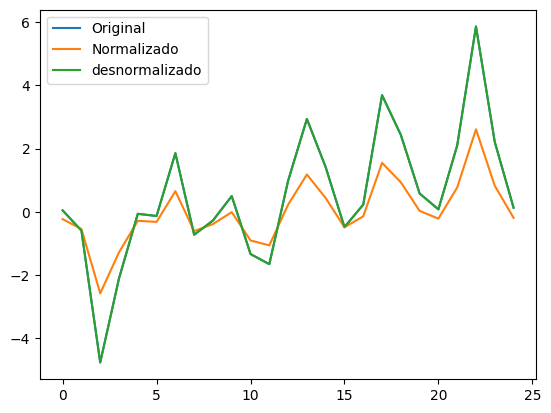

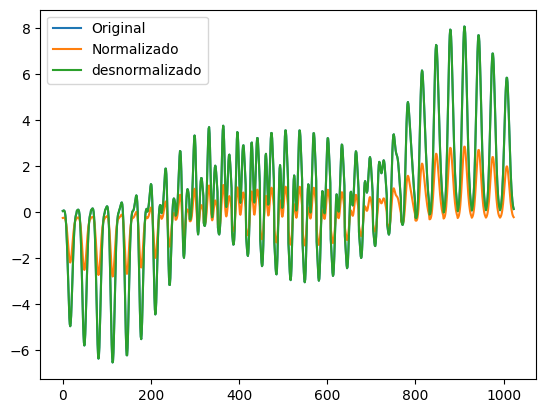

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-28 11:15:57.120724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:15:57.136003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:15:57.137608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:15:57.183456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 11:16:00.936111: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[5], [6], [7], [8], [9], [10], [11], [12], [13], [14]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_0  0.929854  0.776983  0.078442  0.719106  0.521607  0.469066   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_0  1.491315  1.303142  0.647329  0.975235  0.521138  0.684884   

               r2_adj      rsd        aic        bic  
model_2_3_0  0.438833  0.71404  43.514026  69.110418

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_8  0.925456  0.767885  0.959703  0.837700  0.929870  0.498475   
model_3_7_7  0.926089  0.767470  0.963021  0.848299  0.934941  0.494240   
model_3_7_6  0.926455  0.766879  0.965938  0.857058  0.939256  0.491795   
model_3_7_5  0.926590  0.766183  0.968487  0.864350  0.942935  0.490890   
model_3_7_4  0.926543  0.765426  0.970725  0.870600  0.946126  0.491208   
model_3_7_3  0.926357  0.764639  0.972719  0.876166  0.948969  0.492449   
model_3_7_2  0.926073  0.763845  0.974540  0.881330  0.951586  0.494353   
model_3_7_1  0.925726  0.763064  0.976270  0.886318  0.954092  0.496671   
model_3_7_0  0.925353  0.762318  0.978001  0.891313  0.956602  0.499164   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_8  1.552156  0.385179  0.552401  0.468790  0.829025  0.706027   
model_3_7_7  1.554931  0.353460  0.516326  0.434893  0.795038  0.703022   
model_3_7_6  1.558879  0.325580  0.486516  0.406048  0.803894  0.701281   
model_3_7_5  1.563535  0.301218  0.461696  0.381457  0.812550  0.700636   
model_3_7_4  1.568600  0.279825  0.440424  0.360125  0.830752  0.700862   
model_3_7_3  1.573863  0.260767  0.421481  0.341124  0.848972  0.701747   
model_3_7_2  1.579172  0.243358  0.403903  0.323630  0.864807  0.703102   
model_3_7_1  1.584391  0.226824  0.386925  0.306875  0.878066  0.704749   
model_3_7_0  1.589377  0.210273  0.369924  0.290099  0.888473  0.706515   

               r2_adj       rsd        aic        bic  
model_3_7_8  0.403650  0.736084  43.392406  68.988798  
model_3_7_7  0.408716  0.732951  43.409468  69.005861  
model_3_7_6  0.411641  0.731136  43.419386  69.015778  
model_3_7_5  0.412723  0.730463  43.423069  69.019462  
model_3_7_4  0.412344  0.730699  43.421777  69.018169  
model_3_7_3  0.410858  0.731622  43.416728  69.013120  
model_3_7_2  0.408581  0.733035  43.409013  69.005405  
model_3_7_1  0.405808  0.734751  43.399655  68.996047  
model_3_7_0  0.402825  0.736593  43.389641  68.986033

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_2  0.929716  0.733141  0.925943  0.834973  0.919972  0.469988   
model_3_9_1  0.928352  0.732895  0.921588  0.845729  0.918546  0.479111   
model_3_9_0  0.926626  0.732653  0.916048  0.854578  0.915958  0.490655   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_2  1.784490  0.661086  0.326560  0.493823  1.999367  0.685557   
model_3_9_1  1.786130  0.699970  0.305277  0.502623  2.099510  0.692178   
model_3_9_0  1.787749  0.749418  0.287765  0.518592  2.192798  0.700468   

               r2_adj       rsd        aic        bic  
model_3_9_2  0.437730  0.714742  43.510096  69.106488  
model_3_9_1  0.426816  0.721646  43.471647  69.068039  
model_3_9_0  0.413005  0.730288  43.424028  69.020420

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[5], regularizer=0.05, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_5_2   0.929268  0.796674  0.553484  0.936076  0.952173  0.472985   
model_5_5_3   0.930929  0.796657  0.542652  0.940652  0.953761  0.461876   
model_5_5_1   0.927505  0.796638  0.563355  0.931135  0.950380  0.484776   
model_5_5_4   0.932494  0.796588  0.530908  0.944890  0.955158  0.451411   
model_5_5_0   0.925633  0.796545  0.572221  0.925805  0.948370  0.497290   
model_5_5_5   0.933968  0.796472  0.518299  0.948810  0.956375  0.441558   
model_5_5_6   0.935354  0.796310  0.504866  0.952432  0.957423  0.432286   
model_5_5_7   0.936659  0.796106  0.490653  0.955775  0.958313  0.423564   
model_5_5_8   0.937885  0.795862  0.475704  0.958855  0.959053  0.415365   
model_5_5_9   0.939036  0.795581  0.460056  0.961687  0.959652  0.407666   
model_5_5_10  0.940116  0.795263  0.443749  0.964286  0.960118  0.400442   
model_5_5_11  0.941129  0.794912  0.426822  0.966663  0.960458  0.393670   
model_5_5_12  0.942077  0.794529  0.409313  0.968831  0.960679  0.387331   
model_5_5_13  0.942963  0.794116  0.391254  0.970802  0.960789  0.381405   
model_5_5_14  0.943791  0.793674  0.372682  0.972585  0.960791  0.375873   
model_5_5_15  0.944561  0.793204  0.353626  0.974189  0.960693  0.370720   
model_5_5_16  0.945278  0.792709  0.334124  0.975623  0.960500  0.365926   
model_5_5_17  0.945943  0.792190  0.314201  0.976897  0.960217  0.361479   
model_5_5_18  0.946559  0.791648  0.293893  0.978017  0.959848  0.357361   
model_5_5_19  0.947127  0.791083  0.273218  0.978990  0.959397  0.353562   
model_5_5_20  0.947650  0.790498  0.252212  0.979824  0.958870  0.350066   
model_5_5_21  0.948129  0.789893  0.230898  0.980524  0.958270  0.346861   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_5_2   1.359639  0.317866  0.475777  0.396821  1.159636  0.687739   
model_5_5_3   1.359758  0.325577  0.441713  0.383645  1.151136  0.679614   
model_5_5_1   1.359880  0.310839  0.512547  0.411693  1.168277  0.696259   
model_5_5_4   1.360217  0.333937  0.410174  0.372055  1.142773  0.671871   
model_5_5_0   1.360507  0.304527  0.552221  0.428374  1.177057  0.705188   
model_5_5_5   1.360996  0.342913  0.380998  0.361956  1.134544  0.664499   
model_5_5_6   1.362075  0.352476  0.354038  0.353257  1.126443  0.657484   
model_5_5_7   1.363438  0.362594  0.329158  0.345876  1.118472  0.650818   
model_5_5_8   1.365069  0.373236  0.306234  0.339735  1.110617  0.644488   
model_5_5_9   1.366952  0.384375  0.285155  0.334765  1.102888  0.638487   
model_5_5_10  1.369075  0.395984  0.265816  0.330900  1.095274  0.632805   
model_5_5_11  1.371423  0.408034  0.248121  0.328077  1.087775  0.627432   
model_5_5_12  1.373985  0.420498  0.231982  0.326240  1.080382  0.622359   
model_5_5_13  1.376749  0.433354  0.217315  0.325334  1.073103  0.617580   
model_5_5_14  1.379705  0.446575  0.204047  0.325311  1.065927  0.613085   
model_5_5_15  1.382843  0.460140  0.192108  0.326124  1.058858  0.608868   
model_5_5_16  1.386153  0.474023  0.181430  0.327727  1.051889  0.604918   
model_5_5_17  1.389626  0.488207  0.171953  0.330080  1.045016  0.601231   
model_5_5_18  1.393253  0.502663  0.163619  0.333141  1.038237  0.597797   
model_5_5_19  1.397027  0.517381  0.156374  0.336878  1.031557  0.594611   
model_5_5_20  1.400939  0.532335  0.150168  0.341251  1.024965  0.591664   
model_5_5_21  1.404984  0.547508  0.144954  0.346231  1.018465  0.588949   

                r2_adj       rsd        aic        bic  
model_5_5_2   2.697566  0.717017  51.497385  81.969281  
model_5_5_3   2.657695  0.708547  51.544920  82.016815  
model_5_5_1   2.739887  0.725900  51.448135  81.920031  
model_5_5_4   2.620138  0.700474  51.590753  82.062649  
model_5_5_0   2.784799  0.735209  51.397164  81.869060  
model_5_5_5   2.584776  0.692788  51.634890  82.106786  
model_5_5_6   2.551495  0.685475  51.677337  82.149233  
model_5_5_7   2.520192  0.678524  51.718102  82.189998  
model_5_5

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_10  0.946929  0.792497  0.682762  0.848707  0.853139  0.354888   
model_5_6_9   0.947293  0.792474  0.688449  0.852444  0.855909  0.352450   
model_5_6_11  0.946503  0.792464  0.676611  0.844731  0.850152  0.357733   
model_5_6_8   0.947600  0.792398  0.693704  0.855938  0.858474  0.350401   
model_5_6_12  0.946014  0.792372  0.669968  0.840517  0.846937  0.361003   
model_5_6_7   0.947851  0.792274  0.698554  0.859187  0.860845  0.348723   
model_5_6_13  0.945460  0.792218  0.662807  0.836073  0.843484  0.364713   
model_5_6_6   0.948048  0.792103  0.703027  0.862190  0.863032  0.347400   
model_5_6_14  0.944837  0.792000  0.655103  0.831401  0.839784  0.368878   
model_5_6_5   0.948196  0.791890  0.707151  0.864942  0.865047  0.346415   
model_5_6_15  0.944144  0.791715  0.646831  0.826513  0.835828  0.373511   
model_5_6_4   0.948295  0.791638  0.710951  0.867441  0.866898  0.345752   
model_5_6_16  0.943379  0.791363  0.637973  0.821416  0.831611  0.378622   
model_5_6_3   0.948348  0.791350  0.714450  0.869679  0.868593  0.345400   
model_5_6_2   0.948356  0.791029  0.717670  0.871650  0.870143  0.345345   
model_5_6_17  0.942543  0.790942  0.628514  0.816122  0.827127  0.384216   
model_5_6_1   0.948321  0.790677  0.720633  0.873342  0.871552  0.345578   
model_5_6_18  0.941633  0.790452  0.618441  0.810642  0.822373  0.390301   
model_5_6_0   0.948245  0.790297  0.723361  0.874747  0.872828  0.346086   
model_5_6_19  0.940650  0.789893  0.607744  0.804990  0.817348  0.396877   
model_5_6_20  0.939593  0.789265  0.596421  0.799177  0.812050  0.403944   
model_5_6_21  0.938463  0.788571  0.584471  0.793217  0.806483  0.411498   
model_5_6_22  0.937261  0.787811  0.571896  0.787120  0.800649  0.419533   
model_5_6_23  0.935989  0.786986  0.558704  0.780899  0.794551  0.428043   
model_5_6_24  0.934647  0.786098  0.544904  0.774566  0.788196  0.437016   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_10  1.387575  1.323970  0.211890  0.767930  0.868316  0.595725   
model_5_6_9   1.387728  1.300233  0.206657  0.753445  0.878786  0.593675   
model_5_6_11  1.387794  1.349641  0.217459  0.783550  0.857773  0.598108   
model_5_6_8   1.388234  1.278303  0.201763  0.740033  0.889221  0.591947   
model_5_6_12  1.388409  1.377362  0.223360  0.800361  0.847121  0.600835   
model_5_6_7   1.389068  1.258061  0.197212  0.727637  0.899671  0.590528   
model_5_6_13  1.389438  1.407247  0.229585  0.818416  0.846675  0.603914   
model_5_6_6   1.390207  1.239392  0.193007  0.716200  0.910183  0.589407   
model_5_6_14  1.390898  1.439403  0.236127  0.837765  0.849145  0.607353   
model_5_6_5   1.391630  1.222182  0.189152  0.705667  0.920812  0.588570   
model_5_6_15  1.392802  1.473922  0.242973  0.858448  0.851987  0.611155   
model_5_6_4   1.393315  1.206324  0.185652  0.695988  0.936437  0.588007   
model_5_6_16  1.395159  1.510892  0.250112  0.880502  0.855208  0.615322   
model_5_6_3   1.395243  1.191722  0.182518  0.687120  0.952591  0.587708   
model_5_6_2   1.397393  1.178281  0.179758  0.679019  0.968845  0.587661   
model_5_6_17  1.397974  1.550367  0.257526  0.903946  0.858782  0.619852   
model_5_6_1   1.399746  1.165915  0.177388  0.671651  0.985223  0.587859   
model_5_6_18  1.401251  1.592408  0.265201  0.928804  0.862694  0.624741   
model_5_6_0   1.402283  1.154532  0.175420  0.664976  1.001760  0.588291   
model_5_6_19  1.404989  1.637049  0.273117  0.955083  0.866924  0.629982   
model_5_6_20  1.409183  1.684306  0.281257  0.982782  0.871453  0.635566   
model_5_6_21  1.413826  1.734179  0.289606  1.011892  0.876247  0.641481   
model_5_6_22  1.418911  1.786658  0.298144  1.042401  0.881279  0.647714   
model_5_6_23  1.424426  1.841714  0.306856  1.074285  0.886524  0.654250   
model_5_6_24  1.430361  1.899307  0.315727  1.107517  0.891946  0.661072   

                r2_adj       rsd        aic        bic  
model_5_6

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_0   0.935196  0.785736  0.933425 -0.200338  0.909288  0.433343   
model_5_7_1   0.935634  0.785272  0.928855 -0.302945  0.902481  0.430417   
model_5_7_2   0.935967  0.784713  0.923465 -0.410489  0.894839  0.428188   
model_5_7_3   0.936204  0.784067  0.917307 -0.522085  0.886432  0.426605   
model_5_7_4   0.936350  0.783339  0.910431 -0.636932  0.877326  0.425625   
model_5_7_5   0.936413  0.782537  0.902885 -0.754362  0.867578  0.425204   
model_5_7_6   0.936398  0.781665  0.894710 -0.873749  0.857244  0.425305   
model_5_7_7   0.936311  0.780729  0.885948 -0.994555  0.846373  0.425892   
model_5_7_8   0.936155  0.779733  0.876639 -1.116297  0.835013  0.426931   
model_5_7_9   0.935937  0.778683  0.866820 -1.238543  0.823207  0.428390   
model_5_7_10  0.935660  0.777582  0.856523 -1.360928  0.810994  0.430244   
model_5_7_11  0.935328  0.776433  0.845781 -1.483172  0.798409  0.432465   
model_5_7_12  0.934944  0.775241  0.834625 -1.604936  0.785488  0.435027   
model_5_7_13  0.934513  0.774009  0.823082 -1.726036  0.772259  0.437909   
model_5_7_14  0.934038  0.772740  0.811180 -1.846236  0.758752  0.441090   
model_5_7_15  0.933520  0.771436  0.798943 -1.965382  0.744993  0.444550   
model_5_7_16  0.932964  0.770101  0.786394 -2.083315  0.731005  0.448273   
model_5_7_17  0.932370  0.768736  0.773556 -2.199938  0.716811  0.452239   
model_5_7_18  0.931743  0.767344  0.760449 -2.315121  0.702431  0.456435   
model_5_7_19  0.931083  0.765927  0.747094 -2.428809  0.687884  0.460846   
model_5_7_20  0.930394  0.764487  0.733508 -2.540925  0.673187  0.465457   
model_5_7_21  0.929676  0.763025  0.719709 -2.651434  0.658356  0.470256   
model_5_7_22  0.928932  0.761544  0.705712 -2.760285  0.643406  0.475233   
model_5_7_23  0.928163  0.760044  0.691533 -2.867475  0.628350  0.480376   
model_5_7_24  0.927370  0.758528  0.677189 -2.972999  0.613202  0.485675   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_0   1.432782  0.231547  0.141920  0.186733  0.873777  0.658288   
model_5_7_1   1.435886  0.247442  0.154051  0.200746  0.856953  0.656062   
model_5_7_2   1.439623  0.266189  0.166766  0.216478  0.846861  0.654361   
model_5_7_3   1.443946  0.287604  0.179961  0.233782  0.836641  0.653150   
model_5_7_4   1.448810  0.311518  0.193539  0.252529  0.826308  0.652399   
model_5_7_5   1.454176  0.337766  0.207424  0.272595  0.815877  0.652077   
model_5_7_6   1.460007  0.366198  0.221539  0.293868  0.805351  0.652154   
model_5_7_7   1.466267  0.396671  0.235822  0.316246  0.803148  0.652604   
model_5_7_8   1.472924  0.429047  0.250216  0.339632  0.810703  0.653399   
model_5_7_9   1.479949  0.463198  0.264670  0.363934  0.817616  0.654515   
model_5_7_10  1.487313  0.499010  0.279140  0.389075  0.823918  0.655930   
model_5_7_11  1.494993  0.536371  0.293593  0.414982  0.829644  0.657620   
model_5_7_12  1.502962  0.575172  0.307989  0.441581  0.834814  0.659566   
model_5_7_13  1.511202  0.615317  0.322308  0.468812  0.839461  0.661747   
model_5_7_14  1.519689  0.656714  0.336519  0.496616  0.843608  0.664146   
model_5_7_15  1.528407  0.699274  0.350606  0.524940  0.847278  0.666746   
model_5_7_16  1.537338  0.742920  0.364550  0.553735  0.850495  0.669532   
model_5_7_17  1.546465  0.787570  0.378338  0.582954  0.853279  0.672487   
model_5_7_18  1.555773  0.833154  0.391957  0.612555  0.855650  0.675600   
model_5_7_19  1.565249  0.879605  0.405398  0.642502  0.857635  0.678856   
model_5_7_20  1.574879  0.926857  0.418654  0.672756  0.859239  0.682244   
model_5_7_21  1.584653  0.974850  0.431720  0.703285  0.860502  0.685752   
model_5_7_22  1.594558  1.023529  0.444590  0.734060  0.861421  0.689372   
model_5_7_23  1.604584  1.072842  0.457263  0.765053  0.862020  0.693092   
model_5_7_24  1.614722  1.122733  0.469740  0.796236  0.862321  0.696904   

                r2_adj       rsd        aic        bic  
model_5_7

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_24  0.952328  0.781975  0.863935  0.834210  0.920597  0.318781   
model_5_8_23  0.951727  0.781530  0.869392  0.836399  0.922974  0.322800   
model_5_8_22  0.951099  0.781054  0.874630  0.838394  0.925236  0.327001   
model_5_8_21  0.950443  0.780547  0.879644  0.840189  0.927380  0.331388   
model_5_8_20  0.949759  0.780006  0.884429  0.841768  0.929402  0.335965   
model_5_8_19  0.949045  0.779432  0.888982  0.843120  0.931299  0.340738   
model_5_8_18  0.948301  0.778822  0.893300  0.844233  0.933067  0.345710   
model_5_8_17  0.947527  0.778176  0.897377  0.845092  0.934702  0.350887   
model_5_8_16  0.946721  0.777492  0.901209  0.845683  0.936199  0.356275   
model_5_8_15  0.945883  0.776769  0.904791  0.845995  0.937555  0.361877   
model_5_8_14  0.945013  0.776005  0.908121  0.846007  0.938765  0.367700   
model_5_8_13  0.944108  0.775199  0.911192  0.845706  0.939825  0.373748   
model_5_8_12  0.943169  0.774350  0.914001  0.845074  0.940730  0.380029   
model_5_8_11  0.942194  0.773456  0.916542  0.844095  0.941474  0.386547   
model_5_8_10  0.941183  0.772515  0.918811  0.842749  0.942054  0.393308   
model_5_8_9   0.940135  0.771525  0.920802  0.841018  0.942462  0.400318   
model_5_8_8   0.939048  0.770485  0.922511  0.838881  0.942695  0.407585   
model_5_8_7   0.937922  0.769394  0.923933  0.836316  0.942746  0.415115   
model_5_8_6   0.936756  0.768248  0.925060  0.833303  0.942609  0.422914   
model_5_8_5   0.935548  0.767046  0.925889  0.829817  0.942278  0.430989   
model_5_8_4   0.934298  0.765786  0.926411  0.825835  0.941746  0.439348   
model_5_8_3   0.933005  0.764465  0.926622  0.821331  0.941007  0.447998   
model_5_8_2   0.931666  0.763081  0.926515  0.816279  0.940053  0.456948   
model_5_8_1   0.930282  0.761632  0.926082  0.810651  0.938876  0.466205   
model_5_8_0   0.928850  0.760116  0.925316  0.804417  0.937468  0.475778   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_24  1.457937  0.189458  0.115286  0.152372  0.777871  0.564607   
model_5_8_23  1.460911  0.181859  0.113764  0.147812  0.775758  0.568155   
model_5_8_22  1.464091  0.174566  0.112377  0.143471  0.773577  0.571840   
model_5_8_21  1.467484  0.167584  0.111129  0.139357  0.771326  0.575663   
model_5_8_20  1.471098  0.160921  0.110031  0.135476  0.769005  0.579625   
model_5_8_19  1.474939  0.154582  0.109091  0.131836  0.766608  0.583727   
model_5_8_18  1.479016  0.148570  0.108316  0.128443  0.764131  0.587971   
model_5_8_17  1.483339  0.142894  0.107719  0.125306  0.761582  0.592357   
model_5_8_16  1.487913  0.137558  0.107308  0.122433  0.758953  0.596887   
model_5_8_15  1.492749  0.132569  0.107091  0.119830  0.756244  0.601562   
model_5_8_14  1.497856  0.127933  0.107083  0.117508  0.753454  0.606383   
model_5_8_13  1.503244  0.123656  0.107293  0.115475  0.750578  0.611349   
model_5_8_12  1.508923  0.119746  0.107732  0.113739  0.747626  0.616465   
model_5_8_11  1.514903  0.116208  0.108412  0.112310  0.744581  0.621729   
model_5_8_10  1.521196  0.113048  0.109348  0.111198  0.741458  0.627143   
model_5_8_9   1.527812  0.110276  0.110552  0.110414  0.738243  0.632707   
model_5_8_8   1.534765  0.107896  0.112038  0.109967  0.744753  0.638424   
model_5_8_7   1.542066  0.105917  0.113822  0.109869  0.755295  0.644294   
model_5_8_6   1.549728  0.104346  0.115917  0.110132  0.766028  0.650318   
model_5_8_5   1.557766  0.103193  0.118341  0.110767  0.777022  0.656497   
model_5_8_4   1.566193  0.102465  0.121110  0.111788  0.789068  0.662833   
model_5_8_3   1.575025  0.102171  0.124242  0.113207  0.801468  0.669327   
model_5_8_2   1.584277  0.102321  0.127755  0.115038  0.814332  0.675980   
model_5_8_1   1.593965  0.102924  0.131669  0.117296  0.830163  0.682792   
model_5_8_0   1.604108  0.103991  0.136004  0.119997  0.846162  0.689766   

                r2_adj       rsd        aic        bic  
model_5_8

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_24  0.966923  0.790664  0.954526  0.682647  0.864862  0.221187   
model_5_9_23  0.966523  0.790476  0.955177  0.681225  0.864753  0.223859   
model_5_9_22  0.966111  0.790277  0.955790  0.679735  0.864599  0.226616   
model_5_9_21  0.965686  0.790067  0.956363  0.678172  0.864397  0.229459   
model_5_9_20  0.965247  0.789846  0.956895  0.676536  0.864146  0.232391   
model_5_9_19  0.964795  0.789614  0.957384  0.674825  0.863844  0.235415   
model_5_9_18  0.964329  0.789369  0.957830  0.673036  0.863491  0.238531   
model_5_9_17  0.963849  0.789113  0.958231  0.671167  0.863084  0.241742   
model_5_9_16  0.963354  0.788843  0.958586  0.669215  0.862621  0.245051   
model_5_9_15  0.962844  0.788561  0.958893  0.667178  0.862102  0.248460   
model_5_9_14  0.962319  0.788266  0.959151  0.665053  0.861524  0.251971   
model_5_9_13  0.961778  0.787957  0.959358  0.662839  0.860886  0.255588   
model_5_9_12  0.961222  0.787634  0.959514  0.660530  0.860186  0.259311   
model_5_9_11  0.960648  0.787296  0.959616  0.658127  0.859422  0.263145   
model_5_9_10  0.960058  0.786944  0.959662  0.655623  0.858592  0.267091   
model_5_9_9   0.959451  0.786577  0.959653  0.653017  0.857693  0.271152   
model_5_9_8   0.958826  0.786194  0.959585  0.650305  0.856725  0.275332   
model_5_9_7   0.958183  0.785795  0.959458  0.647484  0.855685  0.279633   
model_5_9_6   0.957521  0.785380  0.959269  0.644551  0.854570  0.284058   
model_5_9_5   0.956840  0.784948  0.959017  0.641500  0.853379  0.288610   
model_5_9_4   0.956140  0.784499  0.958700  0.638327  0.852107  0.293293   
model_5_9_3   0.955420  0.784032  0.958316  0.635029  0.850755  0.298110   
model_5_9_2   0.954679  0.783546  0.957865  0.631602  0.849319  0.303063   
model_5_9_1   0.953917  0.783042  0.957342  0.628039  0.847794  0.308157   
model_5_9_0   0.953134  0.782518  0.956748  0.624336  0.846181  0.313395   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_24  1.399833  0.114010  0.468786  0.291398  0.996004  0.470305   
model_5_9_23  1.401090  0.112377  0.470886  0.291631  0.987215  0.473138   
model_5_9_22  1.402419  0.110841  0.473087  0.291964  0.978399  0.476042   
model_5_9_21  1.403821  0.109405  0.475396  0.292400  0.969568  0.479019   
model_5_9_20  1.405298  0.108071  0.477812  0.292941  0.960716  0.482070   
model_5_9_19  1.406854  0.106844  0.480339  0.293592  0.951851  0.485195   
model_5_9_18  1.408488  0.105725  0.482982  0.294354  0.942975  0.488396   
model_5_9_17  1.410205  0.104720  0.485744  0.295232  0.934086  0.491673   
model_5_9_16  1.412006  0.103831  0.488627  0.296229  0.925201  0.495026   
model_5_9_15  1.413893  0.103061  0.491635  0.297348  0.916311  0.498457   
model_5_9_14  1.415868  0.102414  0.494775  0.298595  0.907425  0.501968   
model_5_9_13  1.417935  0.101895  0.498046  0.299970  0.898550  0.505557   
model_5_9_12  1.420095  0.101505  0.501455  0.301480  0.889681  0.509226   
model_5_9_11  1.422351  0.101250  0.505006  0.303128  0.880830  0.512976   
model_5_9_10  1.424705  0.101132  0.508704  0.304918  0.872002  0.516808   
model_5_9_9   1.427161  0.101156  0.512554  0.306855  0.863200  0.520723   
model_5_9_8   1.429721  0.101326  0.516560  0.308943  0.854425  0.524721   
model_5_9_7   1.432387  0.101646  0.520727  0.311186  0.845687  0.528803   
model_5_9_6   1.435163  0.102120  0.525060  0.313590  0.836996  0.532971   
model_5_9_5   1.438052  0.102751  0.529567  0.316159  0.828352  0.537225   
model_5_9_4   1.441057  0.103546  0.534254  0.318900  0.819767  0.541566   
model_5_9_3   1.444181  0.104508  0.539125  0.321816  0.811237  0.545994   
model_5_9_2   1.447428  0.105640  0.544187  0.324913  0.802775  0.550511   
model_5_9_1   1.450800  0.106949  0.549451  0.328200  0.794389  0.555119   
model_5_9_0   1.454302  0.108438  0.554921  0.331680  0.786087  0.559817   

                r2_adj       rsd        aic        bic  
model_5_9

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[6], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==========

2024-10-28 13:40:02.695438: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_0  0.925319  0.656572  0.953074  0.945037  0.951322  0.499390   
model_9_8_1  0.926130  0.655434  0.952230  0.943752  0.950375  0.493968   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_0  2.296504  0.524278  0.195736  0.360007  1.044329  0.706675   
model_9_8_1  2.304112  0.533711  0.200311  0.367011  1.036182  0.702829   

               r2_adj      rsd        aic        bic  
model_9_8_0  1.358467  0.73676  59.388738  94.736137  
model_9_8_1  1.354576  0.73275  59.410568  94.757967

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 9 +++++++++++++++

2024-10-28 13:51:09.436384: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_9_17  0.929802  0.791552 -0.365492 -5.065999 -0.174681  0.469412   
model_10_9_16  0.929805  0.791350 -0.363265 -5.074408 -0.173968  0.469396   
model_10_9_15  0.929803  0.791121 -0.360794 -5.083691 -0.173175  0.469409   
model_10_9_14  0.929794  0.790860 -0.358056 -5.093961 -0.172294  0.469466   
model_10_9_13  0.929778  0.790562 -0.355018 -5.105294 -0.171313  0.469577   
model_10_9_12  0.929750  0.790222 -0.351658 -5.117807 -0.170227  0.469765   
model_10_9_11  0.929707  0.789832 -0.347941 -5.131630 -0.169024  0.470050   
model_10_9_10  0.929645  0.789383 -0.343835 -5.146898 -0.167695  0.470465   
model_10_9_9   0.929558  0.788864 -0.339315 -5.163750 -0.166235  0.471047   
model_10_9_8   0.929439  0.788264 -0.334343 -5.182394 -0.164636  0.471845   
model_10_9_7   0.929277  0.787564 -0.328905 -5.203066 -0.162905  0.472925   
model_10_9_6   0.929061  0.786746 -0.322983 -5.226062 -0.161053  0.474367   
model_10_9_5   0.928776  0.785784 -0.316577 -5.251731 -0.159101  0.476274   
model_10_9_4   0.928401  0.784647 -0.309720 -5.280550 -0.157100  0.478780   
model_10_9_3   0.927911  0.783292 -0.302483 -5.313248 -0.155137  0.482061   
model_10_9_2   0.927271  0.781669 -0.294993 -5.350775 -0.153349  0.486339   
model_10_9_1   0.926438  0.779706 -0.287486 -5.394555 -0.151963  0.491906   
model_10_9_0   0.925357  0.777316 -0.280326 -5.446688 -0.151322  0.499140   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_9_17  1.393893  1.932982  0.993711  1.463347  2.320831  0.685137   
model_10_9_16  1.395244  1.929830  0.995089  1.462459  2.319086  0.685124   
model_10_9_15  1.396777  1.926332  0.996609  1.461471  2.317084  0.685135   
model_10_9_14  1.398522  1.922455  0.998292  1.460373  2.314781  0.685176   
model_10_9_13  1.400512  1.918156  1.000148  1.459152  2.312128  0.685257   
model_10_9_12  1.402787  1.913399  1.002198  1.457799  2.309065  0.685394   
model_10_9_11  1.405396  1.908137  1.004463  1.456300  2.305524  0.685602   
model_10_9_10  1.408399  1.902324  1.006964  1.454644  2.301423  0.685904   
model_10_9_9   1.411864  1.895926  1.009724  1.452825  2.296664  0.686329   
model_10_9_8   1.415881  1.888888  1.012779  1.450833  2.291142  0.686910   
model_10_9_7   1.420558  1.881190  1.016165  1.448678  2.284726  0.687695   
model_10_9_6   1.426028  1.872807  1.019932  1.446370  2.277271  0.688743   
model_10_9_5   1.432460  1.863739  1.024137  1.443938  2.268600  0.690126   
model_10_9_4   1.440068  1.854032  1.028858  1.441445  2.258521  0.691940   
model_10_9_3   1.449125  1.843787  1.034215  1.439001  2.246824  0.694306   
model_10_9_2   1.459984  1.833184  1.040362  1.436773  2.233265  0.697380   
model_10_9_1   1.473105  1.822557  1.047534  1.435046  2.217588  0.701360   
model_10_9_0   1.489091  1.812422  1.056074  1.434248  2.199529  0.706499   

                 r2_adj       rsd        aic        bic  
model_10_9_17  1.336949  0.714304  59.512548  94.859947  
model_10_9_16  1.336937  0.714292  59.512619  94.860018  
model_10_9_15  1.336947  0.714302  59.512560  94.859959  
model_10_9_14  1.336987  0.714345  59.512320  94.859719  
model_10_9_13  1.337068  0.714430  59.511844  94.859243  
model_10_9_12  1.337202  0.714573  59.511046  94.858445  
model_10_9_11  1.337407  0.714790  59.509830  94.857229  
model_10_9_10  1.337704  0.715105  59.508069  94.855468  
model_10_9_9   1.338122  0.715547  59.505595  94.852994  
model_10_9_8   1.338695  0.716153  59.502209  94.849608  
model_10_9_7   1.339470  0.716972  59.497637  94.845036  
model_10_9_6   1.340505  0.718064  59.491550  94.838949  
model_10_9_5   1.341874  0.719506  59.483526  94.830925  
model_10_9_4   1.343673  0.721397  59.473027  94.820425  
model_10_9_3   1.346029  0.723865  59.459367  94.806766  
model_10_9_2   1.349099  0.727069  59.441699  94.789098  
model_10_9_1   1.353095  0.731219  59.418935  94.766334  
model_10_9_0   1.358288  0.736576  59.389737  94.

DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[7], regularizer=0.05, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_2_17  0.929257  0.657289  0.724547  0.625310  0.746508  0.473061   
model_12_2_16  0.929662  0.656877  0.726004  0.628973  0.748769  0.470348   
model_12_2_15  0.930094  0.656416  0.727594  0.633106  0.751310  0.467459   
model_12_2_14  0.930551  0.655901  0.729326  0.637775  0.754169  0.464404   
model_12_2_13  0.931029  0.655324  0.731212  0.643050  0.757387  0.461209   
model_12_2_12  0.931523  0.654678  0.733268  0.649011  0.761011  0.457908   
model_12_2_11  0.932024  0.653954  0.735513  0.655748  0.765092  0.454558   
model_12_2_10  0.932520  0.653143  0.737972  0.663355  0.769687  0.451240   
model_12_2_9   0.932993  0.652233  0.740680  0.671932  0.774856  0.448074   
model_12_2_8   0.933420  0.651213  0.743693  0.681581  0.780666  0.445224   
model_12_2_7   0.933764  0.650066  0.747088  0.692397  0.787181  0.442920   
model_12_2_6   0.933980  0.648775  0.750983  0.704463  0.794469  0.441478   
model_12_2_5   0.934003  0.647318  0.755564  0.717833  0.802590  0.441322   
model_12_2_4   0.933750  0.645666  0.761093  0.732521  0.811600  0.443017   
model_12_2_3   0.933107  0.643783  0.767950  0.748475  0.821536  0.447316   
model_12_2_2   0.931928  0.641618  0.776642  0.765572  0.832420  0.455199   
model_12_2_1   0.930021  0.639100  0.787793  0.783590  0.844241  0.467947   
model_12_2_0   0.927136  0.636119  0.802072  0.802199  0.856936  0.487241   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_2_17  2.291713  0.558140  2.359857  1.458998  2.136943  0.687794   
model_12_2_16  2.294465  0.555186  2.336789  1.445988  2.138265  0.685819   
model_12_2_15  2.297544  0.551966  2.310757  1.431361  2.139648  0.683709   
model_12_2_14  2.300992  0.548456  2.281354  1.414905  2.141064  0.681472   
model_12_2_13  2.304851  0.544635  2.248132  1.396383  2.142474  0.679124   
model_12_2_12  2.309173  0.540467  2.210585  1.375526  2.143817  0.676689   
model_12_2_11  2.314013  0.535918  2.168159  1.352039  2.145010  0.674209   
model_12_2_10  2.319437  0.530937  2.120248  1.325592  2.145931  0.671744   
model_12_2_9   2.325518  0.525449  2.066229  1.295839  2.146397  0.669383   
model_12_2_8   2.332341  0.519345  2.005457  1.262401  2.146154  0.667251   
model_12_2_7   2.340009  0.512466  1.937333  1.224899  2.144857  0.665523   
model_12_2_6   2.348642  0.504572  1.861340  1.182956  2.142914  0.664438   
model_12_2_5   2.358388  0.495291  1.777132  1.136212  2.142643  0.664321   
model_12_2_4   2.369434  0.484087  1.684630  1.084359  2.140213  0.665595   
model_12_2_3   2.382026  0.470193  1.584145  1.027169  2.135013  0.668817   
model_12_2_2   2.396499  0.452581  1.476466  0.964523  2.126438  0.674684   
model_12_2_1   2.413338  0.429985  1.362984  0.896485  2.114120  0.684067   
model_12_2_0   2.433274  0.401053  1.245786  0.823419  2.097986  0.698026   

                 r2_adj       rsd        aic        bic  
model_12_2_17  1.339568  0.717075  59.497064  94.844463  
model_12_2_16  1.337620  0.715016  59.508566  94.855965  
model_12_2_15  1.335547  0.712816  59.520889  94.868288  
model_12_2_14  1.333354  0.710484  59.533999  94.881398  
model_12_2_13  1.331060  0.708035  59.547809  94.895208  
model_12_2_12  1.328691  0.705497  59.562175  94.909574  
model_12_2_11  1.326286  0.702911  59.576861  94.924260  
model_12_2_10  1.323905  0.700342  59.591512  94.938911  
model_12_2_9   1.321632  0.697880  59.605594  94.952993  
model_12_2_8   1.319586  0.695657  59.618358  94.965757  
model_12_2_7   1.317933  0.693855  59.628731  94.976130  
model_12_2_6   1.316898  0.692725  59.635252  94.982651  
model_12_2_5   1.316785  0.692602  59.635962  94.983361  
model_12_2_4   1.318002  0.693931  59.628293  94.975692  
model_12_2_3   1.321088  0.697290  59.608980  94.956379  
model_12_2_2   1.326746  0.703407  59.574042  94.921441  
model_12_2_1   1.335897  0.713189  59.518799  94.866198  
model_12_2_0   1.349746  0.727743  59.437994  94.

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_3_4   0.951466  0.672984  0.956139 -3.039798  0.658995  0.324545   
model_12_3_3   0.950248  0.672762  0.969090 -2.499168  0.710452  0.332690   
model_12_3_5   0.951830  0.672490  0.942344 -3.547733  0.609313  0.322114   
model_12_3_2   0.947877  0.671537  0.980645 -1.930708  0.762862  0.348543   
model_12_3_6   0.951566  0.671495  0.928144 -4.021365  0.561887  0.323879   
model_12_3_7   0.950848  0.670157  0.913881 -4.460904  0.516983  0.328678   
model_12_3_1   0.943961  0.668924  0.990129 -1.344634  0.814898  0.374731   
model_12_3_8   0.949810  0.668596  0.899812 -4.867562  0.474721  0.335621   
model_12_3_9   0.948554  0.666901  0.886127 -5.242987  0.435132  0.344020   
model_12_3_10  0.947159  0.665139  0.872963 -5.589013  0.398190  0.353348   
model_12_3_0   0.937982  0.664404  0.996742 -0.759549  0.864500  0.414716   
model_12_3_11  0.945686  0.663361  0.860412 -5.907492  0.363831  0.363200   
model_12_3_12  0.944180  0.661603  0.848533 -6.200244  0.331968  0.373268   
model_12_3_13  0.942677  0.659892  0.837360 -6.468949  0.302499  0.383317   
model_12_3_14  0.941203  0.658246  0.826905 -6.715273  0.275311  0.393174   
model_12_3_15  0.939777  0.656680  0.817165 -6.940762  0.250283  0.402714   
model_12_3_16  0.938411  0.655199  0.808128 -7.146901  0.227293  0.411848   
model_12_3_17  0.937114  0.653810  0.799770 -7.335119  0.206215  0.420517   
model_12_3_18  0.935892  0.652513  0.792064 -7.506752  0.186924  0.428687   
model_12_3_19  0.934748  0.651308  0.784976 -7.663075  0.169297  0.436341   
model_12_3_20  0.933681  0.650193  0.778474 -7.805287  0.153217  0.443473   
model_12_3_21  0.932691  0.649164  0.772519 -7.934536  0.138565  0.450092   
model_12_3_22  0.931776  0.648218  0.767076 -8.051896  0.125232  0.456212   
model_12_3_23  0.930933  0.647350  0.762110 -8.158354  0.113113  0.461852   
model_12_3_24  0.930158  0.646556  0.757585 -8.254862  0.102108  0.467036   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_3_4   2.186758  0.116667  0.986713  0.551690  1.587591  0.569689   
model_12_3_3   2.188243  0.082217  0.854665  0.468441  1.677230  0.576793   
model_12_3_5   2.190059  0.153360  1.110775  0.632067  1.506646  0.567551   
model_12_3_2   2.196433  0.051481  0.715819  0.383650  1.776232  0.590376   
model_12_3_6   2.196716  0.191130  1.226458  0.708794  1.433633  0.569104   
model_12_3_7   2.205663  0.229069  1.333815  0.781442  1.367865  0.573305   
model_12_3_1   2.213907  0.026256  0.572672  0.299464  1.885311  0.612153   
model_12_3_8   2.216103  0.266491  1.433140  0.849816  1.308687  0.579328   
model_12_3_9   2.227437  0.302892  1.524837  0.913864  1.255483  0.586532   
model_12_3_10  2.239215  0.337907  1.609353  0.973630  1.207681  0.594431   
model_12_3_0   2.244129  0.008666  0.429766  0.219216  2.005190  0.643984   
model_12_3_11  2.251106  0.371292  1.687141  1.029217  1.164749  0.602661   
model_12_3_12  2.262863  0.402888  1.758645  1.080767  1.126195  0.610957   
model_12_3_13  2.274306  0.432608  1.824276  1.128442  1.091588  0.619126   
model_12_3_14  2.285308  0.460417  1.884440  1.172428  1.060512  0.627036   
model_12_3_15  2.295785  0.486323  1.939515  1.212919  1.032614  0.634598   
model_12_3_16  2.305684  0.510362  1.989864  1.250113  1.007566  0.641754   
model_12_3_17  2.314975  0.532593  2.035836  1.284215  0.985142  0.648473   
model_12_3_18  2.323648  0.553091  2.077757  1.315424  0.965000  0.654742   
model_12_3_19  2.331706  0.571943  2.115939  1.343941  0.946907  0.660561   
model_12_3_20  2.339164  0.589239  2.150674  1.369957  0.930653  0.665938   
model_12_3_21  2.346043  0.605079  2.182243  1.393661  0.916042  0.670889   
model_12_3_22  2.352369  0.619556  2.210907  1.415232  0.902912  0.675435   
model_12_3_23  2.358172  0.632765  2.236909  1.434837  0.891114  0.679597   
model_12_3_24  2.363484  0.644803  2.260481  1.452642  0.880504  0.683400   

               

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_4_2  0.939048  0.669092  0.819750  0.607475  0.736567  0.407585   
model_12_4_3  0.931287  0.667611  0.725486  0.416257  0.604365  0.459485   
model_12_4_1  0.942564  0.666662  0.897807  0.753217  0.841051  0.384072   
model_12_4_0  0.940037  0.659447  0.948194  0.833853  0.903178  0.400973   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_4_2  2.212781  0.476529  0.685063  0.580796  1.083784  0.638424   
model_12_4_3  2.222685  0.725735  1.018791  0.872263  1.153751  0.677853   
model_12_4_1  2.229034  0.270169  0.430704  0.350436  1.006951  0.619735   
model_12_4_0  2.277281  0.136958  0.289972  0.213465  0.933093  0.633225   

                r2_adj       rsd        aic        bic  
model_12_4_2  1.292569  0.665603  59.795013  95.142412  
model_12_4_3  1.329823  0.706711  59.555297  94.902696  
model_12_4_1  1.275690  0.646118  59.913853  95.261252  
model_12_4_0  1.287823  0.660182  59.827721  95.175120

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_5_3   0.945018  0.704036  0.790744  0.608777  0.779713  0.367662   
model_12_5_2   0.944277  0.704033  0.794544  0.668842  0.788977  0.372623   
model_12_5_4   0.945169  0.703614  0.786933  0.543821  0.769954  0.366655   
model_12_5_1   0.942781  0.703457  0.798242  0.722500  0.797514  0.382624   
model_12_5_5   0.944866  0.702886  0.783186  0.475531  0.759919  0.368679   
model_12_5_0   0.940341  0.702123  0.801725  0.768420  0.805098  0.398943   
model_12_5_6   0.944225  0.701946  0.779558  0.405393  0.749803  0.372967   
model_12_5_7   0.943340  0.700867  0.776088  0.334737  0.739773  0.378887   
model_12_5_8   0.942287  0.699706  0.772801  0.264703  0.729964  0.385928   
model_12_5_9   0.941128  0.698506  0.769714  0.196219  0.720482  0.393678   
model_12_5_10  0.939911  0.697300  0.766832  0.130015  0.711405  0.401817   
model_12_5_11  0.938673  0.696112  0.764158  0.066632  0.702788  0.410096   
model_12_5_12  0.937442  0.694959  0.761686  0.006446  0.694664  0.418326   
model_12_5_13  0.936239  0.693854  0.759411 -0.050309  0.687051  0.426369   
model_12_5_14  0.935080  0.692805  0.757323 -0.103505  0.679954  0.434124   
model_12_5_15  0.933973  0.691817  0.755412 -0.153114  0.673367  0.441524   
model_12_5_16  0.932926  0.690891  0.753666 -0.199168  0.667277  0.448524   
model_12_5_17  0.931943  0.690029  0.752075 -0.241768  0.661664  0.455100   
model_12_5_18  0.931024  0.689229  0.750627 -0.281037  0.656507  0.461242   
model_12_5_19  0.930170  0.688490  0.749311 -0.317137  0.651778  0.466952   
model_12_5_20  0.929380  0.687809  0.748117 -0.350241  0.647453  0.472237   
model_12_5_21  0.928651  0.687184  0.747033 -0.380529  0.643504  0.477112   
model_12_5_22  0.927980  0.686611  0.746052 -0.408189  0.639905  0.481595   
model_12_5_23  0.927365  0.686087  0.745164 -0.433409  0.636628  0.485708   
model_12_5_24  0.926802  0.685609  0.744360 -0.456372  0.633650  0.489472   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_5_3   1.979115  1.512099  0.324070  0.918084  0.690475  0.606352   
model_12_5_2   1.979133  1.484637  0.274315  0.879476  0.691489  0.610428   
model_12_5_4   1.981936  1.539637  0.377876  0.958757  0.692131  0.605521   
model_12_5_1   1.982983  1.457919  0.229867  0.843893  0.696196  0.618566   
model_12_5_5   1.986803  1.566713  0.434444  1.000578  0.695638  0.607190   
model_12_5_0   1.991903  1.432747  0.191829  0.812288  0.705873  0.631619   
model_12_5_6   1.993090  1.592931  0.492543  1.042737  0.700380  0.610711   
model_12_5_7   2.000305  1.618006  0.551071  1.084538  0.705887  0.615538   
model_12_5_8   2.008070  1.641755  0.609083  1.125419  0.711810  0.621231   
model_12_5_9   2.016094  1.664064  0.665812  1.164938  0.717902  0.627438   
model_12_5_10  2.024159  1.684885  0.720652  1.202768  0.723979  0.633890   
model_12_5_11  2.032103  1.704211  0.773155  1.238683  0.729910  0.640387   
model_12_5_12  2.039809  1.722071  0.823011  1.272541  0.735606  0.646781   
model_12_5_13  2.047197  1.738512  0.870024  1.304268  0.741025  0.652969   
model_12_5_14  2.054212  1.753600  0.914089  1.333844  0.746121  0.658881   
model_12_5_15  2.060823  1.767412  0.955182  1.361297  0.750884  0.664472   
model_12_5_16  2.067014  1.780027  0.993331  1.386679  0.755309  0.669719   
model_12_5_17  2.072781  1.791523  1.028619  1.410071  0.759401  0.674611   
model_12_5_18  2.078129  1.801986  1.061147  1.431567  0.763167  0.679148   
model_12_5_19  2.083071  1.811494  1.091051  1.451272  0.766629  0.683339   
model_12_5_20  2.087622  1.820126  1.118473  1.469299  0.769798  0.687195   
model_12_5_21  2.091803  1.827953  1.143562  1.485757  0.772693  0.690733   
model_12_5_22  2.095633  1.835043  1.166474  1.500758  0.775333  0.693971   
model_12_5_23  2.099135  1.841462  1.187365  1.514413  0.777734  0.696927   
model_12_5_24  2.102332  1.847268  1.206386  1.526827  0.779914  0.699623   

               

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_6_0   0.982587  0.740086  0.804541  0.594233  0.753388  0.116440   
model_12_6_1   0.982480  0.739793  0.804612  0.574496  0.745068  0.117159   
model_12_6_2   0.982338  0.739479  0.804846  0.556289  0.737457  0.118107   
model_12_6_3   0.982174  0.739156  0.805189  0.539550  0.730509  0.119200   
model_12_6_4   0.981998  0.738832  0.805605  0.524204  0.724179  0.120379   
model_12_6_5   0.981816  0.738515  0.806063  0.510168  0.718418  0.121598   
model_12_6_6   0.981633  0.738209  0.806544  0.497358  0.713185  0.122821   
model_12_6_7   0.981453  0.737916  0.807027  0.485685  0.708433  0.124024   
model_12_6_8   0.981279  0.737639  0.807505  0.475066  0.704126  0.125190   
model_12_6_9   0.981112  0.737379  0.807968  0.465417  0.700223  0.126306   
model_12_6_10  0.980954  0.737136  0.808412  0.456660  0.696689  0.127364   
model_12_6_11  0.980805  0.736910  0.808831  0.448720  0.693492  0.128360   
model_12_6_12  0.980665  0.736701  0.809225  0.441528  0.690601  0.129292   
model_12_6_13  0.980536  0.736508  0.809594  0.435016  0.687989  0.130159   
model_12_6_14  0.980415  0.736330  0.809936  0.429126  0.685629  0.130962   
model_12_6_15  0.980305  0.736168  0.810252  0.423800  0.683498  0.131704   
model_12_6_16  0.980202  0.736019  0.810543  0.418987  0.681574  0.132386   
model_12_6_17  0.980109  0.735883  0.810811  0.414640  0.679838  0.133013   
model_12_6_18  0.980023  0.735759  0.811055  0.410715  0.678272  0.133587   
model_12_6_19  0.979945  0.735646  0.811280  0.407172  0.676860  0.134111   
model_12_6_20  0.979873  0.735543  0.811484  0.403975  0.675586  0.134590   
model_12_6_21  0.979808  0.735450  0.811670  0.401091  0.674438  0.135025   
model_12_6_22  0.979748  0.735366  0.811839  0.398491  0.673403  0.135422   
model_12_6_23  0.979695  0.735289  0.811993  0.396146  0.672470  0.135782   
model_12_6_24  0.979646  0.735220  0.812134  0.394032  0.671630  0.136109   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_6_0   1.738047  0.194171  0.444285  0.319228  0.906069  0.341233   
model_12_6_1   1.740006  0.194100  0.465896  0.329998  0.908266  0.342286   
model_12_6_2   1.742106  0.193868  0.485832  0.339850  0.910147  0.343666   
model_12_6_3   1.744267  0.193527  0.504160  0.348844  0.911761  0.345254   
model_12_6_4   1.746428  0.193114  0.520962  0.357038  0.913146  0.346957   
model_12_6_5   1.748549  0.192659  0.536330  0.364495  0.914333  0.348709   
model_12_6_6   1.750598  0.192182  0.550357  0.371269  0.915359  0.350458   
model_12_6_7   1.752555  0.191701  0.563138  0.377420  0.916244  0.352171   
model_12_6_8   1.754408  0.191226  0.574765  0.382996  0.917005  0.353822   
model_12_6_9   1.756149  0.190766  0.585330  0.388048  0.917660  0.355395   
model_12_6_10  1.757775  0.190326  0.594918  0.392622  0.918227  0.356881   
model_12_6_11  1.759286  0.189909  0.603611  0.396760  0.918719  0.358273   
model_12_6_12  1.760685  0.189518  0.611487  0.400503  0.919147  0.359571   
model_12_6_13  1.761975  0.189151  0.618617  0.403884  0.919512  0.360775   
model_12_6_14  1.763161  0.188811  0.625066  0.406939  0.919830  0.361886   
model_12_6_15  1.764248  0.188498  0.630898  0.409698  0.920112  0.362910   
model_12_6_16  1.765244  0.188208  0.636167  0.412188  0.920352  0.363849   
model_12_6_17  1.766153  0.187942  0.640927  0.414435  0.920563  0.364709   
model_12_6_18  1.766982  0.187700  0.645224  0.416462  0.920751  0.365495   
model_12_6_19  1.767736  0.187477  0.649104  0.418290  0.920912  0.366212   
model_12_6_20  1.768422  0.187274  0.652604  0.419939  0.921053  0.366865   
model_12_6_21  1.769045  0.187089  0.655762  0.421425  0.921177  0.367458   
model_12_6_22  1.769611  0.186921  0.658609  0.422765  0.921286  0.367997   
model_12_6_23  1.770123  0.186768  0.661176  0.423972  0.921381  0.368486   
model_12_6_24  1.770587  0.186628  0.663491  0.425060  0.921466  0.368930   

               

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_7_1  0.978596  0.739418  0.990850  0.889297  0.969272  0.143131   
model_12_7_0  0.981393  0.738521  0.995675  0.968169  0.989869  0.124425   
model_12_7_2  0.971897  0.737985  0.982498  0.769355  0.937174  0.187927   
model_12_7_3  0.961782  0.734105  0.970934  0.612931  0.894799  0.255563   
model_12_7_4  0.948906  0.727800  0.957219  0.425146  0.844057  0.341668   
model_12_7_5  0.934208  0.719351  0.942839  0.214750  0.787959  0.439955   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_7_1  1.742515  0.083252  0.282384  0.182818  1.219823  0.378327   
model_12_7_0  1.748510  0.039351  0.081194  0.060273  1.076341  0.352739   
model_12_7_2  1.752093  0.159234  0.588335  0.373785  1.353437  0.433506   
model_12_7_3  1.778038  0.264447  0.987347  0.625897  1.480521  0.505532   
model_12_7_4  1.820199  0.389231  1.466353  0.927792  1.602406  0.584524   
model_12_7_5  1.876701  0.520056  2.003039  1.261548  1.718606  0.663291   

                r2_adj       rsd        aic        bic  
model_12_7_1  1.102741  0.394433  61.887991  97.235389  
model_12_7_0  1.089314  0.367756  62.168102  97.515501  
model_12_7_2  1.134896  0.451961  61.343399  96.690798  
model_12_7_3  1.183446  0.527054  60.728574  96.075973  
model_12_7_4  1.245253  0.609408  60.147830  95.495229  
model_12_7_5  1.315804  0.691528  59.642167  94.989566

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_19  0.944617  0.832524  0.886672  0.901350  0.896427  0.370347   
model_13_6_18  0.943978  0.832510  0.891584  0.902684  0.899516  0.374619   
model_13_6_20  0.945224  0.832506  0.881483  0.900021  0.893202  0.366286   
model_13_6_17  0.943307  0.832463  0.896210  0.904025  0.902466  0.379106   
model_13_6_21  0.945801  0.832457  0.876029  0.898694  0.889845  0.362429   
model_13_6_16  0.942603  0.832383  0.900540  0.905376  0.905272  0.383814   
model_13_6_22  0.946348  0.832377  0.870321  0.897365  0.886361  0.358773   
model_13_6_15  0.941865  0.832269  0.904564  0.906738  0.907931  0.388746   
model_13_6_23  0.946866  0.832267  0.864371  0.896033  0.882754  0.355310   
model_13_6_14  0.941093  0.832120  0.908274  0.908113  0.910439  0.393909   
model_13_6_13  0.940286  0.831937  0.911662  0.909502  0.912792  0.399308   
model_13_6_12  0.939443  0.831717  0.914721  0.910903  0.914988  0.404947   
model_13_6_11  0.938563  0.831460  0.917445  0.912319  0.917023  0.410832   
model_13_6_10  0.937645  0.831166  0.919828  0.913746  0.918892  0.416967   
model_13_6_9   0.936689  0.830833  0.921864  0.915184  0.920594  0.423358   
model_13_6_8   0.935694  0.830462  0.923548  0.916629  0.922123  0.430011   
model_13_6_7   0.934660  0.830049  0.924876  0.918079  0.923477  0.436931   
model_13_6_6   0.933584  0.829595  0.925845  0.919530  0.924651  0.444123   
model_13_6_5   0.932467  0.829097  0.926450  0.920975  0.925642  0.451595   
model_13_6_4   0.931307  0.828555  0.926688  0.922409  0.926443  0.459351   
model_13_6_3   0.930103  0.827965  0.926557  0.923823  0.927050  0.467399   
model_13_6_2   0.928855  0.827326  0.926052  0.925209  0.927458  0.475747   
model_13_6_1   0.927561  0.826635  0.925173  0.926554  0.927658  0.484400   
model_13_6_0   0.926220  0.825889  0.923915  0.927845  0.927644  0.493368   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_19  1.119914  0.222694  0.184652  0.203673  1.224053  0.608562   
model_13_6_18  1.120008  0.213041  0.182155  0.197598  1.225015  0.612062   
model_13_6_20  1.120034  0.232891  0.187139  0.210015  1.222269  0.605216   
model_13_6_17  1.120320  0.203951  0.179644  0.191798  1.225149  0.615716   
model_13_6_21  1.120364  0.243609  0.189623  0.216616  1.219678  0.602021   
model_13_6_16  1.120855  0.195443  0.177116  0.186280  1.224433  0.619527   
model_13_6_22  1.120898  0.254825  0.192110  0.223468  1.216303  0.598976   
model_13_6_15  1.121617  0.187536  0.174566  0.181051  1.222864  0.623495   
model_13_6_23  1.121633  0.266517  0.194605  0.230561  1.212157  0.596079   
model_13_6_14  1.122611  0.180246  0.171992  0.176119  1.220438  0.627622   
model_13_6_13  1.123841  0.173588  0.169394  0.171491  1.217152  0.631908   
model_13_6_12  1.125311  0.167576  0.166770  0.167173  1.212999  0.636354   
model_13_6_11  1.127027  0.162224  0.164121  0.163172  1.207980  0.640962   
model_13_6_10  1.128994  0.157542  0.161449  0.159496  1.202099  0.645730   
model_13_6_9   1.131217  0.153541  0.158758  0.156150  1.195360  0.650660   
model_13_6_8   1.133705  0.150232  0.156052  0.153142  1.187769  0.655752   
model_13_6_7   1.136463  0.147621  0.153338  0.150480  1.179325  0.661008   
model_13_6_6   1.139501  0.145718  0.150623  0.148170  1.172071  0.666426   
model_13_6_5   1.142827  0.144529  0.147918  0.146223  1.164200  0.672008   
model_13_6_4   1.146455  0.144061  0.145234  0.144647  1.155525  0.677755   
model_13_6_3   1.150398  0.144319  0.142586  0.143453  1.146070  0.683666   
model_13_6_2   1.154670  0.145311  0.139993  0.142652  1.135853  0.689744   
model_13_6_1   1.159292  0.147039  0.137476  0.142257  1.124888  0.695989   
model_13_6_0   1.164283  0.149511  0.135059  0.142285  1.115722  0.702402   

                 r2_adj       rsd        aic         bic  
model_13_6_19  1.147688  0.634469  67.986628  108.209530  
model_13_6_18  1.149392  0.638118  67.963689  108.1

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_0   0.952894  0.827602  0.623849  0.573346  0.684649  0.314998   
model_13_7_1   0.953086  0.827325  0.618127  0.566390  0.679640  0.313711   
model_13_7_2   0.953267  0.827047  0.612280  0.559484  0.674612  0.312503   
model_13_7_3   0.953437  0.826768  0.606312  0.552628  0.669569  0.311369   
model_13_7_4   0.953596  0.826488  0.600225  0.545830  0.664515  0.310307   
model_13_7_5   0.953744  0.826207  0.594024  0.539091  0.659451  0.309314   
model_13_7_6   0.953882  0.825925  0.587712  0.532416  0.654381  0.308389   
model_13_7_7   0.954011  0.825643  0.581290  0.525808  0.649306  0.307528   
model_13_7_8   0.954131  0.825360  0.574764  0.519270  0.644230  0.306729   
model_13_7_9   0.954241  0.825076  0.568135  0.512806  0.639155  0.305991   
model_13_7_10  0.954343  0.824791  0.561403  0.506419  0.634082  0.305310   
model_13_7_11  0.954436  0.824506  0.554573  0.500110  0.629014  0.304686   
model_13_7_12  0.954521  0.824220  0.547644  0.493884  0.623953  0.304115   
model_13_7_13  0.954599  0.823933  0.540619  0.487744  0.618899  0.303597   
model_13_7_14  0.954669  0.823646  0.533499  0.481693  0.613856  0.303128   
model_13_7_15  0.954732  0.823358  0.526285  0.475731  0.608824  0.302709   
model_13_7_16  0.954787  0.823069  0.518975  0.469861  0.603803  0.302336   
model_13_7_17  0.954836  0.822780  0.511572  0.464088  0.598797  0.302009   
model_13_7_18  0.954879  0.822490  0.504075  0.458412  0.593805  0.301726   
model_13_7_19  0.954915  0.822199  0.496485  0.452836  0.588829  0.301485   
model_13_7_20  0.954945  0.821907  0.488800  0.447363  0.583870  0.301285   
model_13_7_21  0.954969  0.821615  0.481020  0.441995  0.578928  0.301124   
model_13_7_22  0.954987  0.821322  0.473144  0.436733  0.574005  0.301003   
model_13_7_23  0.955000  0.821028  0.465172  0.431582  0.569101  0.300918   
model_13_7_24  0.955007  0.820734  0.457103  0.426542  0.564217  0.300869   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_0   1.152825  0.331145  0.537614  0.434380  1.157633  0.561247   
model_13_7_1   1.154678  0.336182  0.546379  0.441280  1.155423  0.560100   
model_13_7_2   1.156538  0.341330  0.555081  0.448206  1.153271  0.559020   
model_13_7_3   1.158404  0.346584  0.563719  0.455152  1.151181  0.558004   
model_13_7_4   1.160276  0.351942  0.572286  0.462114  1.149148  0.557052   
model_13_7_5   1.162154  0.357402  0.580778  0.469090  1.147171  0.556160   
model_13_7_6   1.164037  0.362958  0.589189  0.476074  1.145243  0.555328   
model_13_7_7   1.165926  0.368612  0.597515  0.483063  1.143368  0.554552   
model_13_7_8   1.167819  0.374357  0.605753  0.490055  1.141539  0.553831   
model_13_7_9   1.169717  0.380193  0.613898  0.497046  1.139759  0.553164   
model_13_7_10  1.171620  0.386119  0.621947  0.504033  1.138024  0.552549   
model_13_7_11  1.173528  0.392133  0.629896  0.511014  1.136330  0.551984   
model_13_7_12  1.175441  0.398232  0.637741  0.517987  1.134680  0.551466   
model_13_7_13  1.177358  0.404417  0.645478  0.524947  1.133068  0.550996   
model_13_7_14  1.179280  0.410684  0.653103  0.531894  1.131495  0.550571   
model_13_7_15  1.181206  0.417036  0.660616  0.538826  1.129963  0.550190   
model_13_7_16  1.183137  0.423471  0.668012  0.545742  1.128464  0.549851   
model_13_7_17  1.185073  0.429988  0.675287  0.552637  1.127003  0.549554   
model_13_7_18  1.187013  0.436588  0.682439  0.559513  1.125576  0.549296   
model_13_7_19  1.188958  0.443270  0.689464  0.566367  1.124180  0.549077   
model_13_7_20  1.190907  0.450036  0.696361  0.573199  1.122815  0.548894   
model_13_7_21  1.192861  0.456885  0.703125  0.580005  1.121485  0.548748   
model_13_7_22  1.194820  0.463818  0.709755  0.586787  1.120185  0.548637   
model_13_7_23  1.196783  0.470837  0.716246  0.593542  1.118912  0.548560   
model_13_7_24  1.198752  0.477940  0.722597  0.600269  1.117668  0.548515   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_0   0.955142  0.820059  0.208636  0.980191  0.924089  0.299965   
model_13_8_1   0.955261  0.819370  0.195242  0.979984  0.922916  0.299167   
model_13_8_2   0.955365  0.818667  0.181638  0.979770  0.921721  0.298474   
model_13_8_3   0.955454  0.817950  0.167832  0.979548  0.920504  0.297882   
model_13_8_4   0.955527  0.817221  0.153830  0.979318  0.919266  0.297390   
model_13_8_5   0.955586  0.816479  0.139641  0.979080  0.918007  0.296994   
model_13_8_6   0.955631  0.815726  0.125273  0.978835  0.916728  0.296693   
model_13_8_7   0.955662  0.814961  0.110734  0.978583  0.915430  0.296485   
model_13_8_8   0.955680  0.814184  0.096033  0.978322  0.914114  0.296366   
model_13_8_9   0.955685  0.813398  0.081179  0.978054  0.912779  0.296335   
model_13_8_10  0.955677  0.812601  0.066180  0.977779  0.911427  0.296390   
model_13_8_11  0.955656  0.811794  0.051044  0.977496  0.910059  0.296528   
model_13_8_12  0.955624  0.810978  0.035782  0.977205  0.908674  0.296746   
model_13_8_13  0.955579  0.810153  0.020403  0.976906  0.907274  0.297043   
model_13_8_14  0.955523  0.809320  0.004913  0.976600  0.905859  0.297416   
model_13_8_15  0.955456  0.808478 -0.010677  0.976286  0.904430  0.297863   
model_13_8_16  0.955379  0.807629 -0.026356  0.975964  0.902987  0.298383   
model_13_8_17  0.955290  0.806773 -0.042119  0.975634  0.901531  0.298973   
model_13_8_18  0.955192  0.805909 -0.057956  0.975296  0.900063  0.299631   
model_13_8_19  0.955084  0.805040 -0.073857  0.974950  0.898583  0.300355   
model_13_8_20  0.954966  0.804164 -0.089815  0.974596  0.897092  0.301143   
model_13_8_21  0.954839  0.803282 -0.105821  0.974234  0.895590  0.301993   
model_13_8_22  0.954703  0.802395 -0.121867  0.973864  0.894078  0.302903   
model_13_8_23  0.954558  0.801504 -0.137944  0.973486  0.892557  0.303871   
model_13_8_24  0.954405  0.800607 -0.154047  0.973099  0.891027  0.304896   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_0   1.203266  0.707116  0.207541  0.457328  1.085884  0.547690   
model_13_8_1   1.207875  0.719084  0.209706  0.464395  1.054246  0.546962   
model_13_8_2   1.212577  0.731240  0.211952  0.471596  1.022757  0.546328   
model_13_8_3   1.217367  0.743575  0.214280  0.478928  0.991859  0.545786   
model_13_8_4   1.222244  0.756087  0.216688  0.486388  1.015055  0.545335   
model_13_8_5   1.227204  0.768765  0.219177  0.493971  1.038093  0.544972   
model_13_8_6   1.232243  0.781603  0.221745  0.501674  1.060971  0.544696   
model_13_8_7   1.237360  0.794595  0.224393  0.509494  1.083681  0.544504   
model_13_8_8   1.242550  0.807731  0.227120  0.517425  1.106219  0.544395   
model_13_8_9   1.247811  0.821003  0.229928  0.525466  1.128582  0.544367   
model_13_8_10  1.253140  0.834406  0.232815  0.533610  1.150769  0.544417   
model_13_8_11  1.258535  0.847931  0.235782  0.541856  1.172768  0.544543   
model_13_8_12  1.263992  0.861567  0.238829  0.550198  1.194584  0.544744   
model_13_8_13  1.269508  0.875310  0.241957  0.558633  1.216211  0.545016   
model_13_8_14  1.275081  0.889151  0.245166  0.567158  1.237646  0.545358   
model_13_8_15  1.280708  0.903081  0.248457  0.575769  1.258891  0.545769   
model_13_8_16  1.286386  0.917091  0.251830  0.584460  1.279939  0.546245   
model_13_8_17  1.292113  0.931176  0.255286  0.593231  1.300793  0.546784   
model_13_8_18  1.297885  0.945326  0.258826  0.602076  1.321449  0.547386   
model_13_8_19  1.303701  0.959534  0.262449  0.610992  1.341907  0.548047   
model_13_8_20  1.309558  0.973793  0.266157  0.619975  1.362165  0.548765   
model_13_8_21  1.315452  0.988095  0.269950  0.629023  1.382226  0.549539   
model_13_8_22  1.321383  1.002433  0.273828  0.638131  1.402089  0.550366   
model_13_8_23  1.327346  1.016799  0.277792  0.647295  1.421745  0.551245   
model_13_8_24  1.333340  1.031188  0.281842  0.656515  1.441206  0.552174   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_3   0.956545  0.800866  0.709197  0.945916  0.912672  0.290583   
model_13_9_2   0.956043  0.800851  0.713452  0.946836  0.914045  0.293939   
model_13_9_4   0.957026  0.800849  0.704423  0.945027  0.911237  0.287366   
model_13_9_1   0.955520  0.800804  0.717166  0.947784  0.915354  0.297439   
model_13_9_5   0.957488  0.800801  0.699157  0.944170  0.909747  0.284280   
model_13_9_6   0.957930  0.800724  0.693426  0.943348  0.908209  0.281319   
model_13_9_0   0.954974  0.800723  0.720319  0.948758  0.916590  0.301089   
model_13_9_7   0.958355  0.800619  0.687253  0.942561  0.906625  0.278479   
model_13_9_8   0.958763  0.800486  0.680669  0.941811  0.905003  0.275752   
model_13_9_9   0.959155  0.800328  0.673697  0.941098  0.903346  0.273133   
model_13_9_10  0.959531  0.800145  0.666365  0.940424  0.901660  0.270618   
model_13_9_11  0.959892  0.799937  0.658700  0.939787  0.899948  0.268201   
model_13_9_12  0.960240  0.799707  0.650725  0.939188  0.898215  0.265877   
model_13_9_13  0.960574  0.799455  0.642464  0.938626  0.896463  0.263642   
model_13_9_14  0.960896  0.799182  0.633940  0.938101  0.894697  0.261492   
model_13_9_15  0.961205  0.798888  0.625173  0.937612  0.892918  0.259423   
model_13_9_16  0.961503  0.798576  0.616184  0.937158  0.891129  0.257432   
model_13_9_17  0.961789  0.798245  0.606991  0.936737  0.889333  0.255516   
model_13_9_18  0.962065  0.797896  0.597611  0.936348  0.887530  0.253673   
model_13_9_19  0.962330  0.797530  0.588059  0.935990  0.885723  0.251899   
model_13_9_20  0.962585  0.797148  0.578349  0.935661  0.883912  0.250193   
model_13_9_21  0.962831  0.796750  0.568494  0.935359  0.882097  0.248552   
model_13_9_22  0.963066  0.796338  0.558508  0.935082  0.880281  0.246976   
model_13_9_23  0.963293  0.795911  0.548399  0.934828  0.878462  0.245462   
model_13_9_24  0.963510  0.795470  0.538178  0.934596  0.876641  0.244010   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_3   1.331611  0.238229  0.205664  0.221946  1.391022  0.539058   
model_13_9_2   1.331708  0.234743  0.202166  0.218454  1.401551  0.542161   
model_13_9_4   1.331726  0.242140  0.209045  0.225592  1.380611  0.536065   
model_13_9_1   1.332024  0.231700  0.198560  0.215130  1.413256  0.545380   
model_13_9_5   1.332045  0.246453  0.212303  0.229378  1.370318  0.533179   
model_13_9_6   1.332560  0.251148  0.215429  0.233289  1.360129  0.530395   
model_13_9_0   1.332566  0.229117  0.194857  0.211987  1.427143  0.548716   
model_13_9_7   1.333263  0.256205  0.218421  0.237313  1.350053  0.527711   
model_13_9_8   1.334149  0.261599  0.221273  0.241436  1.340082  0.525121   
model_13_9_9   1.335208  0.267311  0.223983  0.245647  1.330220  0.522622   
model_13_9_10  1.336434  0.273317  0.226548  0.249932  1.320462  0.520210   
model_13_9_11  1.337821  0.279597  0.228969  0.254283  1.310805  0.517881   
model_13_9_12  1.339360  0.286129  0.231247  0.258688  1.301249  0.515632   
model_13_9_13  1.341047  0.292897  0.233383  0.263140  1.291792  0.513460   
model_13_9_14  1.342874  0.299880  0.235380  0.267630  1.282431  0.511362   
model_13_9_15  1.344835  0.307062  0.237240  0.272151  1.273167  0.509336   
model_13_9_16  1.346926  0.314426  0.238968  0.276697  1.263992  0.507378   
model_13_9_17  1.349140  0.321956  0.240568  0.281262  1.254914  0.505486   
model_13_9_18  1.351472  0.329641  0.242046  0.285843  1.245927  0.503659   
model_13_9_19  1.353918  0.337466  0.243407  0.290437  1.237027  0.501895   
model_13_9_20  1.356473  0.345421  0.244660  0.295040  1.228218  0.500193   
model_13_9_21  1.359132  0.353494  0.245808  0.299651  1.219494  0.498550   
model_13_9_22  1.361891  0.361674  0.246862  0.304268  1.210852  0.496967   
model_13_9_23  1.364745  0.369956  0.247825  0.308891  1.202297  0.495441   
model_13_9_24  1.367692  0.378329  0.248708  0.313519  1.193822  0.493973   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[8], regularizer=0.2, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_5_2  0.931125  0.736123  0.870677  0.046893  0.874073  0.460570   
model_14_5_1  0.932043  0.735904  0.886395  0.067877  0.883125  0.454429   
model_14_5_3  0.929699  0.735904  0.855394  0.024837  0.865162  0.470103   
model_14_5_4  0.927814  0.735348  0.840364  0.001053  0.856262  0.482707   
model_14_5_0  0.932350  0.735051  0.902702  0.087657  0.892386  0.452376   
model_14_5_5  0.925505  0.734502  0.825477 -0.025371  0.847256  0.498151   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_5_2  1.764546  1.162108  1.157174  1.159641  1.059969  0.678653   
model_14_5_1  1.766012  1.020860  1.131698  1.076279  1.085162  0.674114   
model_14_5_3  1.766013  1.299445  1.183953  1.241699  1.038802  0.685641   
model_14_5_4  1.769730  1.434500  1.212829  1.323665  1.019136  0.694771   
model_14_5_0  1.771713  0.874326  1.107682  0.991004  1.116903  0.672589   
model_14_5_5  1.775387  1.568280  1.244911  1.406596  0.999136  0.705798   

                r2_adj       rsd        aic         bic  
model_14_5_2  1.183668  0.707545  67.550581  107.773483  
model_14_5_1  1.181219  0.702812  67.577426  107.800328  
model_14_5_3  1.187469  0.714830  67.509606  107.732508  
model_14_5_4  1.192496  0.724349  67.456690  107.679592  
model_14_5_0  1.180400  0.701222  67.586485  107.809387  
model_14_5_5  1.198654  0.735845  67.393704  107.616606

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 9 ++++++

r2    r2_sup   r2_test     r2_val     r2_vt       mse  \
model_14_9_6   0.946617  0.794570  0.593232  -4.112563  0.289474  0.356974   
model_14_9_7   0.945668  0.794284  0.554121  -4.849558  0.205084  0.363315   
model_14_9_5   0.946897  0.793895  0.632874  -3.365596  0.375008  0.355099   
model_14_9_8   0.944093  0.792990  0.516021  -5.610925  0.120032  0.373853   
model_14_9_4   0.946377  0.792293  0.672150  -2.585845  0.462350  0.358575   
model_14_9_9   0.941929  0.790724  0.479144  -6.419254  0.033034  0.388318   
model_14_9_3   0.944754  0.789674  0.709804  -1.784582  0.549603  0.369430   
model_14_9_10  0.939260  0.787624  0.443599  -7.277671 -0.056014  0.406169   
model_14_9_2   0.941526  0.785787  0.744439  -1.015945  0.631930  0.391019   
model_14_9_11  0.936196  0.783878  0.409477  -8.175175 -0.146307  0.426658   
model_14_9_1   0.935999  0.780234  0.774719  -0.375596  0.701834  0.427976   
model_14_9_12  0.932857  0.779681  0.376873  -9.094901 -0.236654  0.448986   
model_14_9_13  0.929354  0.775203  0.345870 -10.019467 -0.325839  0.472413   
model_14_9_0   0.927300  0.772492  0.799624   0.002980  0.749630  0.486143   
model_14_9_14  0.925780  0.770588  0.316529 -10.933572 -0.412803  0.496309   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_9_6   1.373711  0.787333  0.701643  0.744488  2.082664  0.597473   
model_14_9_7   1.375621  0.863036  0.802787  0.832912  2.218857  0.602756   
model_14_9_5   1.378226  0.710602  0.599130  0.654866  1.943904  0.595902   
model_14_9_8   1.384278  0.936781  0.907276  0.922028  2.354368  0.611435   
model_14_9_4   1.388941  0.634580  0.492117  0.563349  1.798372  0.598811   
model_14_9_9   1.399431  1.008160  1.018210  1.013185  2.488991  0.623152   
model_14_9_3   1.406454  0.561697  0.382153  0.471925  1.639789  0.607808   
model_14_9_10  1.420162  1.076961  1.136019  1.106490  2.621331  0.637314   
model_14_9_2   1.432443  0.494660  0.276666  0.385663  1.460926  0.625315   
model_14_9_11  1.445206  1.143006  1.259191  1.201099  2.749650  0.653191   
model_14_9_1   1.469577  0.436050  0.188785  0.312418  1.255104  0.654199   
model_14_9_12  1.473276  1.206114  1.385413  1.295764  2.872432  0.670064   
model_14_9_13  1.503219  1.266123  1.512300  1.389211  2.988565  0.687323   
model_14_9_0   1.521349  0.387844  0.136830  0.262337  1.059447  0.697240   
model_14_9_14  1.534078  1.322914  1.637750  1.480332  3.097365  0.704492   

                 r2_adj       rsd        aic         bic  
model_14_9_6   1.142355  0.622909  68.060183  108.283086  
model_14_9_7   1.144884  0.628417  68.024968  108.247871  
model_14_9_5   1.141607  0.621270  68.070719  108.293622  
model_14_9_8   1.149086  0.637465  67.967787  108.190689  
model_14_9_4   1.142994  0.624304  68.051237  108.274139  
model_14_9_9   1.154855  0.649680  67.891862  108.114764  
model_14_9_3   1.147323  0.633684  67.991586  108.214488  
model_14_9_10  1.161974  0.664446  67.801970  108.024872  
model_14_9_2   1.155932  0.651936  67.878000  108.100902  
model_14_9_11  1.170144  0.680998  67.703544  107.926447  
model_14_9_1   1.170670  0.682049  67.697377  107.920280  
model_14_9_12  1.179048  0.698590  67.601529  107.824431  
model_14_9_13  1.188390  0.716584  67.499804  107.722707  
model_14_9_0   1.193866  0.726922  67.442505  107.665407  
model_14_9_14  1.197920  0.734484  67.401113  107.624015

DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[8], regularizer=0.05, learning_rate=0.01
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

2024-10-28 14:09:36.304562: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_0   0.934687  0.778138  0.916532  0.920399  0.918520  0.436746   
model_15_9_1   0.934706  0.778126  0.916298  0.920602  0.918511  0.436619   
model_15_9_2   0.934725  0.778112  0.916065  0.920804  0.918501  0.436497   
model_15_9_3   0.934742  0.778098  0.915835  0.921004  0.918492  0.436379   
model_15_9_4   0.934759  0.778084  0.915606  0.921201  0.918482  0.436265   
model_15_9_5   0.934776  0.778069  0.915378  0.921397  0.918472  0.436156   
model_15_9_6   0.934791  0.778054  0.915153  0.921591  0.918462  0.436051   
model_15_9_7   0.934806  0.778038  0.914928  0.921783  0.918451  0.435951   
model_15_9_8   0.934821  0.778022  0.914706  0.921973  0.918441  0.435854   
model_15_9_9   0.934835  0.778005  0.914485  0.922161  0.918430  0.435761   
model_15_9_10  0.934848  0.777988  0.914267  0.922347  0.918420  0.435671   
model_15_9_11  0.934861  0.777971  0.914049  0.922531  0.918409  0.435586   
model_15_9_12  0.934873  0.777953  0.913833  0.922714  0.918398  0.435504   
model_15_9_13  0.934885  0.777935  0.913619  0.922894  0.918386  0.435426   
model_15_9_14  0.934896  0.777917  0.913407  0.923073  0.918375  0.435351   
model_15_9_15  0.934907  0.777898  0.913196  0.923250  0.918363  0.435279   
model_15_9_16  0.934917  0.777879  0.912987  0.923426  0.918352  0.435211   
model_15_9_17  0.934927  0.777860  0.912779  0.923599  0.918340  0.435146   
model_15_9_18  0.934936  0.777840  0.912573  0.923771  0.918328  0.435084   
model_15_9_19  0.934945  0.777820  0.912368  0.923941  0.918316  0.435025   
model_15_9_20  0.934953  0.777800  0.912166  0.924110  0.918304  0.434969   
model_15_9_21  0.934961  0.777780  0.911964  0.924276  0.918292  0.434916   
model_15_9_22  0.934969  0.777759  0.911765  0.924441  0.918280  0.434865   
model_15_9_23  0.934976  0.777738  0.911567  0.924605  0.918267  0.434818   
model_15_9_24  0.934982  0.777717  0.911370  0.924767  0.918255  0.434773   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_0   1.483589  1.332015  1.342718  1.337366  0.265501  0.660868   
model_15_9_1   1.483675  1.335748  1.339284  1.337516  0.263800  0.660772   
model_15_9_2   1.483764  1.339457  1.335882  1.337669  0.262114  0.660679   
model_15_9_3   1.483857  1.343138  1.332514  1.337826  0.260446  0.660590   
model_15_9_4   1.483953  1.346792  1.329180  1.337986  0.258792  0.660504   
model_15_9_5   1.484053  1.350420  1.325879  1.338149  0.257158  0.660421   
model_15_9_6   1.484155  1.354021  1.322610  1.338316  0.255539  0.660342   
model_15_9_7   1.484260  1.357598  1.319376  1.338487  0.253937  0.660266   
model_15_9_8   1.484368  1.361145  1.316170  1.338658  0.252349  0.660192   
model_15_9_9   1.484479  1.364667  1.312999  1.338833  0.250780  0.660122   
model_15_9_10  1.484593  1.368159  1.309859  1.339009  0.249226  0.660054   
model_15_9_11  1.484709  1.371630  1.306750  1.339190  0.247686  0.659989   
model_15_9_12  1.484827  1.375073  1.303671  1.339372  0.246164  0.659927   
model_15_9_13  1.484948  1.378490  1.300624  1.339557  0.244653  0.659868   
model_15_9_14  1.485071  1.381881  1.297606  1.339744  0.243160  0.659811   
model_15_9_15  1.485196  1.385247  1.294621  1.339934  0.241679  0.659757   
model_15_9_16  1.485323  1.388585  1.291661  1.340123  0.240217  0.659705   
model_15_9_17  1.485452  1.391898  1.288735  1.340316  0.238765  0.659656   
model_15_9_18  1.485583  1.395188  1.285835  1.340511  0.237331  0.659609   
model_15_9_19  1.485716  1.398450  1.282966  1.340708  0.235911  0.659564   
model_15_9_20  1.485850  1.401687  1.280124  1.340906  0.234504  0.659522   
model_15_9_21  1.485987  1.404897  1.277313  1.341105  0.233112  0.659481   
model_15_9_22  1.486125  1.408084  1.274528  1.341306  0.231733  0.659443   
model_15_9_23  1.486264  1.411247  1.271771  1.341509  0.230368  0.659407   
model_15_9_24  1.486405  1.414382  1.269042  1.341712  0.229019  0.659373   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[8], regularizer=0.05, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_6_1   0.938274  0.651863  0.940173  0.388787  0.852562  0.412763   
model_16_6_0   0.932543  0.650877  0.957437  0.504005  0.884993  0.451084   
model_16_6_2   0.941576  0.650662  0.919461  0.264176  0.815906  0.390679   
model_16_6_3   0.942945  0.647800  0.896694  0.130269  0.776121  0.381525   
model_16_6_4   0.942815  0.643610  0.873577 -0.014176  0.734322  0.382394   
model_16_6_5   0.941569  0.638317  0.851914 -0.170771  0.691640  0.390732   
model_16_6_6   0.939528  0.632086  0.833355 -0.341019  0.649105  0.404375   
model_16_6_7   0.936958  0.625061  0.819099 -0.525437  0.607559  0.421562   
model_16_6_8   0.934076  0.617406  0.809669 -0.722039  0.567738  0.440832   
model_16_6_9   0.931088  0.609355  0.804813 -0.924781  0.530445  0.460818   
model_16_6_10  0.928197  0.601210  0.803661 -1.123797  0.496637  0.480147   
model_16_6_11  0.925579  0.593281  0.805066 -1.308666  0.467150  0.497654   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_6_1   2.327993  0.251994  0.549585  0.400789  1.489898  0.642466   
model_16_6_0   2.334590  0.179274  0.445985  0.312629  1.431302  0.671628   
model_16_6_2   2.336027  0.339232  0.661631  0.500432  1.540662  0.625043   
model_16_6_3   2.355161  0.435126  0.782037  0.608581  1.584212  0.617677   
model_16_6_4   2.383183  0.532495  0.911918  0.722206  1.621761  0.618380   
model_16_6_5   2.418578  0.623740  1.052724  0.838232  1.651730  0.625085   
model_16_6_6   2.460241  0.701911  1.205805  0.953858  1.673857  0.635904   
model_16_6_7   2.507220  0.761958  1.371629  1.066794  1.688049  0.649278   
model_16_6_8   2.558405  0.801677  1.548408  1.175042  1.694570  0.663952   
model_16_6_9   2.612242  0.822129  1.730707  1.276418  1.693934  0.678836   
model_16_6_10  2.666711  0.826982  1.909657  1.368319  1.686800  0.692927   
model_16_6_11  2.719729  0.821066  2.075885  1.448476  1.674197  0.705446   

                 r2_adj       rsd        aic         bic  
model_16_6_1   1.164603  0.669817  67.769766  107.992668  
model_16_6_0   1.179885  0.700220  67.592204  107.815106  
model_16_6_2   1.155796  0.651653  67.879737  108.102639  
model_16_6_3   1.152146  0.643973  67.927160  108.150062  
model_16_6_4   1.152492  0.644706  67.922608  108.145511  
model_16_6_5   1.155817  0.651697  67.879468  108.102371  
model_16_6_6   1.161258  0.662976  67.810828  108.033730  
model_16_6_7   1.168112  0.676919  67.727576  107.950478  
model_16_6_8   1.175797  0.692218  67.638181  107.861083  
model_16_6_9   1.183767  0.707735  67.549505  107.772407  
model_16_6_10  1.191475  0.722426  67.467325  107.690227  
model_16_6_11  1.198456  0.735478  67.395701  107.618604

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_8_0   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_1   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_22  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_21  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_20  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_19  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_18  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_17  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_16  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_15  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_14  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_13  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_12  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_11  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_10  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_9   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_8   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_7   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_6   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_5   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_4   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_3   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_2   0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_23  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   
model_16_8_24  0.974687  0.656819  0.902765  0.989394  0.957965  0.169267   

                mse_sup  mse_test   mse_val   mse_vt      mape      rmse  \
model_16_8_0   2.294850  0.929121  0.128799  0.52896  0.860880  0.411421   
model_16_8_1   2.294851  0.929120  0.128799  0.52896  0.860881  0.411421   
model_16_8_22  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_21  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_20  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_19  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_18  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_17  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_16  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_15  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_14  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_13  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_12  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_11  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_10  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_9   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_8   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_7   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_6   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_5   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_4   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_3   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_2   2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_23  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   
model_16_8_24  2.294852  0.929120  0.128799  0.52896  0.860880  0.411421   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_9_0   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_22  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_21  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_20  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_19  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_18  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_17  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_16  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_15  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_14  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_13  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_23  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_12  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_10  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_9   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_8   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_7   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_6   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_5   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_4   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_3   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_2   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_1   0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_11  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   
model_16_9_24  0.974687  0.656819  0.999766  0.602364  0.949008  0.169267   

                mse_sup  mse_test   mse_val    mse_vt     mape      rmse  \
model_16_9_0   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_22  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_21  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_20  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_19  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_18  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_17  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_16  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_15  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_14  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_13  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_23  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_12  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_10  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_9   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_8   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_7   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_6   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_5   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_4   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_3   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_2   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_1   2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_11  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   
model_16_9_24  2.294852   0.00315  0.816907  0.410028  0.86088  0.411421   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[9], regularizer=0.2, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

2024-10-28 14:19:21.866943: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_5_21  0.974906  0.725445  0.970137  0.480935  0.930027  0.167801   
model_18_5_22  0.974891  0.725441  0.970262  0.476035  0.929579  0.167906   
model_18_5_20  0.974908  0.725434  0.969999  0.486407  0.930529  0.167791   
model_18_5_23  0.974865  0.725426  0.970376  0.471645  0.929178  0.168079   
model_18_5_19  0.974890  0.725406  0.969849  0.492522  0.931092  0.167910   
model_18_5_18  0.974846  0.725352  0.969685  0.499362  0.931724  0.168203   
model_18_5_17  0.974768  0.725267  0.969509  0.507017  0.932434  0.168725   
model_18_5_16  0.974645  0.725141  0.969321  0.515592  0.933235  0.169546   
model_18_5_15  0.974465  0.724963  0.969125  0.525210  0.934141  0.170753   
model_18_5_14  0.974211  0.724721  0.968923  0.536007  0.935168  0.172452   
model_18_5_13  0.973863  0.724398  0.968725  0.548141  0.936336  0.174777   
model_18_5_12  0.973397  0.723976  0.968540  0.561794  0.937672  0.177894   
model_18_5_11  0.972782  0.723432  0.968388  0.577173  0.939204  0.182005   
model_18_5_10  0.971982  0.722741  0.968294  0.594512  0.940973  0.187359   
model_18_5_9   0.970950  0.721873  0.968298  0.614076  0.943026  0.194261   
model_18_5_8   0.969630  0.720795  0.968456  0.636152  0.945422  0.203085   
model_18_5_7   0.967954  0.719468  0.968848  0.661042  0.948236  0.214294   
model_18_5_6   0.965835  0.717853  0.969581  0.689037  0.951552  0.228465   
model_18_5_5   0.963163  0.715902  0.970794  0.720367  0.955469  0.246330   
model_18_5_4   0.959794  0.713556  0.972648  0.755115  0.960077  0.268856   
model_18_5_3   0.955532  0.710731  0.975304  0.793083  0.965441  0.297357   
model_18_5_2   0.950101  0.707291  0.978865  0.833616  0.971546  0.333673   
model_18_5_1   0.943116  0.703012  0.983304  0.875439  0.978243  0.380387   
model_18_5_0   0.934044  0.697537  0.988379  0.916513  0.985193  0.441046   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_5_21  1.835954  0.226364  0.791508  0.508936  1.190770  0.409635   
model_18_5_22  1.835980  0.225413  0.798980  0.512196  1.180878  0.409763   
model_18_5_20  1.836021  0.227408  0.783164  0.505286  1.201623  0.409622   
model_18_5_23  1.836075  0.224550  0.805674  0.515112  1.171880  0.409974   
model_18_5_19  1.836214  0.228549  0.773839  0.501194  1.213507  0.409768   
model_18_5_18  1.836572  0.229788  0.763409  0.496599  1.226488  0.410126   
model_18_5_17  1.837142  0.231123  0.751737  0.491430  1.240617  0.410762   
model_18_5_16  1.837984  0.232545  0.738660  0.485603  1.256157  0.411760   
model_18_5_15  1.839171  0.234037  0.723994  0.479015  1.273289  0.413222   
model_18_5_14  1.840791  0.235562  0.707531  0.471546  1.291674  0.415273   
model_18_5_13  1.842950  0.237069  0.689027  0.463048  1.311263  0.418064   
model_18_5_12  1.845773  0.238467  0.668208  0.453337  1.331912  0.421775   
model_18_5_11  1.849409  0.239622  0.644758  0.442190  1.353393  0.426620   
model_18_5_10  1.854030  0.240334  0.618317  0.429325  1.375316  0.432849   
model_18_5_9   1.859836  0.240304  0.588486  0.414395  1.397107  0.440750   
model_18_5_8   1.867048  0.239105  0.554822  0.396964  1.417923  0.450650   
model_18_5_7   1.875917  0.236133  0.516868  0.376501  1.436580  0.462919   
model_18_5_6   1.886717  0.230576  0.474179  0.352377  1.451529  0.477980   
model_18_5_5   1.899765  0.221382  0.426405  0.323893  1.460808  0.496316   
model_18_5_4   1.915453  0.207327  0.373418  0.290372  1.462230  0.518513   
model_18_5_3   1.934344  0.187197  0.315522  0.251359  1.453752  0.545304   
model_18_5_2   1.957345  0.160202  0.253714  0.206958  1.434232  0.577644   
model_18_5_1   1.985960  0.126560  0.189940  0.158250  1.404193  0.616755   
model_18_5_0   2.022571  0.088091  0.127307  0.107699  1.366297  0.664113   

                 r2_adj       rsd        aic         bic  
model_18_5_21  1.046327  0.427074  77.569956  122.668361  
model_18_5_22  1.046356  0.427208  77.568702  122.6

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_6_1   0.981477  0.727240  0.919883  0.990709  0.970848  0.123865   
model_18_6_0   0.979020  0.727053  0.952001  0.996582  0.983780  0.140291   
model_18_6_2   0.982639  0.726362  0.874418  0.980966  0.951715  0.116094   
model_18_6_3   0.982835  0.724722  0.820387  0.968422  0.928418  0.114780   
model_18_6_4   0.982328  0.722560  0.761473  0.953979  0.902572  0.118170   
model_18_6_5   0.981325  0.720065  0.700445  0.938377  0.875428  0.124881   
model_18_6_6   0.979986  0.717381  0.639327  0.922209  0.847928  0.133836   
model_18_6_7   0.978434  0.714617  0.579555  0.905931  0.820765  0.144211   
model_18_6_8   0.976764  0.711853  0.522102  0.889891  0.794427  0.155382   
model_18_6_9   0.975043  0.709147  0.467596  0.874337  0.769245  0.166888   
model_18_6_10  0.973323  0.706539  0.416399  0.859445  0.745428  0.178390   
model_18_6_11  0.971639  0.704054  0.368688  0.845327  0.723095  0.189649   
model_18_6_12  0.970016  0.701710  0.324497  0.832052  0.702293  0.200500   
model_18_6_13  0.968471  0.699514  0.283770  0.819649  0.683025  0.210834   
model_18_6_14  0.967013  0.697469  0.246383  0.808123  0.665255  0.220585   
model_18_6_15  0.965647  0.695575  0.212175  0.797462  0.648930  0.229717   
model_18_6_16  0.964376  0.693828  0.180955  0.787636  0.633975  0.238219   
model_18_6_17  0.963198  0.692221  0.152527  0.778608  0.620311  0.246097   
model_18_6_18  0.962111  0.690748  0.126683  0.770335  0.607850  0.253366   
model_18_6_19  0.961111  0.689400  0.103226  0.762772  0.596510  0.260051   
model_18_6_20  0.960194  0.688169  0.081960  0.755871  0.586203  0.266182   
model_18_6_21  0.959355  0.687048  0.062704  0.749586  0.576848  0.271790   
model_18_6_22  0.958590  0.686028  0.045277  0.743867  0.568365  0.276912   
model_18_6_23  0.957892  0.685101  0.029523  0.738673  0.560682  0.281578   
model_18_6_24  0.957257  0.684260  0.015286  0.733959  0.553727  0.285826   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_6_1   1.823950  0.094870  0.021485  0.058178  1.044789  0.351945   
model_18_6_0   1.825201  0.056838  0.007904  0.032371  1.103540  0.374554   
model_18_6_2   1.829820  0.148708  0.044014  0.096361  1.010033  0.340725   
model_18_6_3   1.840787  0.212688  0.073019  0.142854  0.999490  0.338792   
model_18_6_4   1.855242  0.282452  0.106417  0.194434  0.990521  0.343759   
model_18_6_5   1.871926  0.354717  0.142494  0.248605  0.982667  0.353385   
model_18_6_6   1.889873  0.427090  0.179881  0.303485  0.975924  0.365836   
model_18_6_7   1.908356  0.497869  0.217520  0.357694  0.970180  0.379751   
model_18_6_8   1.926838  0.565902  0.254611  0.410257  0.964795  0.394185   
model_18_6_9   1.944934  0.630445  0.290577  0.460511  0.959732  0.408519   
model_18_6_10  1.962377  0.691070  0.325013  0.508041  0.954937  0.422362   
model_18_6_11  1.978992  0.747567  0.357658  0.552612  0.950403  0.435487   
model_18_6_12  1.994669  0.799895  0.388355  0.594125  0.946126  0.447773   
model_18_6_13  2.009354  0.848123  0.417035  0.632579  0.942095  0.459167   
model_18_6_14  2.023024  0.892394  0.443687  0.668041  0.938312  0.469664   
model_18_6_15  2.035689  0.932901  0.468340  0.700621  0.934774  0.479288   
model_18_6_16  2.047374  0.969870  0.491062  0.730466  0.931472  0.488077   
model_18_6_17  2.058119  1.003533  0.511938  0.757736  0.928409  0.496081   
model_18_6_18  2.067972  1.034137  0.531067  0.782602  0.925567  0.503355   
model_18_6_19  2.076985  1.061913  0.548556  0.805235  0.922939  0.509952   
model_18_6_20  2.085212  1.087095  0.564512  0.825804  0.920521  0.515929   
model_18_6_21  2.092709  1.109898  0.579047  0.844473  0.918293  0.521335   
model_18_6_22  2.099531  1.130533  0.592270  0.861402  0.916256  0.526224   
model_18_6_23  2.105729  1.149188  0.604281  0.876735  0.914387  0.530640   
model_18_6_24  2.111356  1.166047  0.615181  0.890614  0.912679  0.534627   

               

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_7_6   0.982018  0.704865  0.839954  0.994755  0.867778  0.120248   
model_18_7_7   0.982144  0.704857  0.835389  0.993431  0.863836  0.119401   
model_18_7_8   0.982097  0.704704  0.831148  0.986285  0.859314  0.119717   
model_18_7_5   0.981659  0.704677  0.844842  0.988253  0.870848  0.122646   
model_18_7_9   0.981923  0.704447  0.827226  0.974933  0.854444  0.120884   
model_18_7_4   0.980996  0.704228  0.850039  0.971466  0.872680  0.127083   
model_18_7_10  0.981658  0.704119  0.823614  0.960666  0.849405  0.122654   
model_18_7_11  0.981331  0.703744  0.820297  0.944500  0.844332  0.124836   
model_18_7_3   0.979938  0.703439  0.855524  0.941413  0.872819  0.134156   
model_18_7_12  0.980966  0.703342  0.817261  0.927227  0.839330  0.127279   
model_18_7_13  0.980579  0.702928  0.814488  0.909457  0.834471  0.129867   
model_18_7_14  0.980184  0.702512  0.811959  0.891647  0.829808  0.132512   
model_18_7_2   0.978376  0.702210  0.861253  0.894525  0.870715  0.144602   
model_18_7_15  0.979789  0.702103  0.809658  0.874139  0.825375  0.135151   
model_18_7_16  0.979403  0.701706  0.807568  0.857179  0.821195  0.137733   
model_18_7_17  0.979030  0.701327  0.805671  0.840935  0.817277  0.140227   
model_18_7_18  0.978674  0.700967  0.803951  0.825522  0.813626  0.142608   
model_18_7_19  0.978337  0.700627  0.802393  0.811003  0.810237  0.144863   
model_18_7_1   0.976176  0.700421  0.867168  0.826575  0.865704  0.159313   
model_18_7_20  0.978020  0.700309  0.800983  0.797413  0.807105  0.146982   
model_18_7_21  0.977724  0.700014  0.799708  0.784757  0.804220  0.148963   
model_18_7_22  0.977448  0.699739  0.798555  0.773022  0.801568  0.150804   
model_18_7_23  0.977193  0.699486  0.797514  0.762180  0.799138  0.152509   
model_18_7_24  0.976958  0.699253  0.796573  0.752196  0.796916  0.154083   
model_18_7_0   0.973177  0.697926  0.873184  0.732625  0.857000  0.179369   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_7_6   1.973569  0.621516  0.003601  0.312558  0.714347  0.346767   
model_18_7_7   1.973623  0.639245  0.004510  0.321877  0.720474  0.345545   
model_18_7_8   1.974646  0.655714  0.009418  0.332566  0.738595  0.346001   
model_18_7_5   1.974826  0.602535  0.008067  0.305301  0.730468  0.350208   
model_18_7_9   1.976362  0.670945  0.017213  0.344078  0.754864  0.347683   
model_18_7_4   1.977827  0.582352  0.019594  0.300972  0.747970  0.356486   
model_18_7_10  1.978558  0.684973  0.027010  0.355991  0.769460  0.350221   
model_18_7_11  1.981064  0.697852  0.038110  0.367982  0.782553  0.353322   
model_18_7_3   1.983107  0.561053  0.040230  0.300642  0.766916  0.366273   
model_18_7_12  1.983753  0.709642  0.049971  0.379806  0.794288  0.356761   
model_18_7_13  1.986524  0.720412  0.062174  0.391293  0.804810  0.360370   
model_18_7_14  1.989305  0.730231  0.074403  0.402316  0.814240  0.364022   
model_18_7_2   1.991325  0.538805  0.072427  0.305617  0.787360  0.380266   
model_18_7_15  1.992040  0.739166  0.086425  0.412796  0.822693  0.367628   
model_18_7_16  1.994690  0.747283  0.098071  0.422677  0.830273  0.371124   
model_18_7_17  1.997229  0.754650  0.109225  0.431938  0.837067  0.374469   
model_18_7_18  1.999638  0.761329  0.119809  0.440569  0.843154  0.377635   
model_18_7_19  2.001907  0.767380  0.129779  0.448580  0.848621  0.380609   
model_18_7_1   2.003286  0.515835  0.119086  0.317462  0.809329  0.399141   
model_18_7_20  2.004032  0.772855  0.139111  0.455983  0.853519  0.383383   
model_18_7_21  2.006010  0.777807  0.147801  0.462804  0.857919  0.385957   
model_18_7_22  2.007844  0.782284  0.155859  0.469072  0.861863  0.388335   
model_18_7_23  2.009539  0.786329  0.163305  0.474817  0.865401  0.390524   
model_18_7_24  2.011099  0.789980  0.170160  0.480070  0.868580  0.392534   
model_18_7_0   2.019970  0.492473  0.183599  0.338036  0.832827  0.423519   

               

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_8_11  0.992805  0.711831  0.950902  0.953157  0.953265  0.048113   
model_18_8_12  0.992910  0.711830  0.947318  0.954394  0.952932  0.047412   
model_18_8_13  0.992969  0.711798  0.943966  0.955329  0.952475  0.047016   
model_18_8_10  0.992640  0.711788  0.954714  0.951539  0.953418  0.049214   
model_18_8_14  0.992994  0.711743  0.940846  0.956025  0.951935  0.046852   
model_18_8_9   0.992398  0.711686  0.958743  0.949442  0.953324  0.050833   
model_18_8_15  0.992993  0.711673  0.937954  0.956535  0.951343  0.046859   
model_18_8_16  0.992973  0.711593  0.935282  0.956898  0.950726  0.046991   
model_18_8_17  0.992940  0.711508  0.932821  0.957148  0.950102  0.047213   
model_18_8_8   0.992057  0.711507  0.962968  0.946745  0.952896  0.053117   
model_18_8_18  0.992897  0.711421  0.930560  0.957309  0.949483  0.047495   
model_18_8_19  0.992849  0.711333  0.928488  0.957404  0.948881  0.047817   
model_18_8_20  0.992798  0.711248  0.926593  0.957449  0.948302  0.048161   
model_18_8_7   0.991588  0.711224  0.967360  0.943298  0.952026  0.056251   
model_18_8_21  0.992745  0.711165  0.924863  0.957455  0.947751  0.048515   
model_18_8_22  0.992692  0.711085  0.923285  0.957434  0.947231  0.048869   
model_18_8_23  0.992640  0.711010  0.921849  0.957393  0.946743  0.049217   
model_18_8_24  0.992590  0.710939  0.920543  0.957339  0.946288  0.049554   
model_18_8_6   0.990958  0.710807  0.971873  0.938921  0.950579  0.060462   
model_18_8_5   0.990125  0.710216  0.976449  0.933387  0.948388  0.066032   
model_18_8_4   0.989037  0.709403  0.981007  0.926427  0.945248  0.073309   
model_18_8_3   0.987630  0.708306  0.985445  0.917711  0.940908  0.082720   
model_18_8_2   0.985825  0.706847  0.989632  0.906846  0.935066  0.094786   
model_18_8_1   0.983528  0.704934  0.993403  0.893356  0.927354  0.110150   
model_18_8_0   0.980620  0.702449  0.996546  0.876674  0.917330  0.129593   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_8_11  1.926989  0.090222  0.177399  0.133811  1.170482  0.219347   
model_18_8_12  1.926994  0.096809  0.172716  0.134762  1.180070  0.217743   
model_18_8_13  1.927211  0.102968  0.169174  0.136071  1.188513  0.216832   
model_18_8_10  1.927275  0.083217  0.183527  0.133372  1.159588  0.221843   
model_18_8_14  1.927576  0.108701  0.166537  0.137619  1.195967  0.216452   
model_18_8_9   1.927954  0.075814  0.191468  0.133641  1.147196  0.225461   
model_18_8_15  1.928044  0.114015  0.164608  0.139312  1.202549  0.216469   
model_18_8_16  1.928576  0.118925  0.163232  0.141078  1.208371  0.216775   
model_18_8_17  1.929145  0.123448  0.162286  0.142867  1.213529  0.217285   
model_18_8_8   1.929156  0.068049  0.201681  0.134865  1.133081  0.230472   
model_18_8_18  1.929730  0.127602  0.161674  0.144638  1.218104  0.217934   
model_18_8_19  1.930315  0.131409  0.161314  0.146362  1.222166  0.218671   
model_18_8_20  1.930889  0.134892  0.161146  0.148019  1.225777  0.219456   
model_18_8_7   1.931048  0.059980  0.214734  0.137357  1.116975  0.237173   
model_18_8_21  1.931444  0.138072  0.161122  0.149597  1.228991  0.220261   
model_18_8_22  1.931974  0.140970  0.161201  0.151086  1.231853  0.221063   
model_18_8_23  1.932477  0.143610  0.161356  0.152483  1.234406  0.221849   
model_18_8_24  1.932949  0.146009  0.161563  0.153786  1.236684  0.222607   
model_18_8_6   1.933836  0.051686  0.231313  0.141500  1.098563  0.245889   
model_18_8_5   1.937784  0.043278  0.252269  0.147774  1.077498  0.256967   
model_18_8_4   1.943223  0.034902  0.278628  0.156765  1.053376  0.270756   
model_18_8_3   1.950562  0.026746  0.311635  0.169190  1.025732  0.287610   
model_18_8_2   1.960315  0.019051  0.352784  0.185918  0.994026  0.307874   
model_18_8_1   1.973110  0.012123  0.403871  0.207997  0.957662  0.331888   
model_18_8_0   1.989723  0.006346  0.467047  0.236697  0.915966  0.359990   

               

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_9_13  0.997215  0.713934  0.966838  0.995249  0.988369  0.018620   
model_18_9_14  0.997245  0.713932  0.967142  0.995031  0.988285  0.018422   
model_18_9_12  0.997175  0.713929  0.966496  0.995483  0.988456  0.018889   
model_18_9_15  0.997267  0.713927  0.967412  0.994830  0.988205  0.018278   
model_18_9_16  0.997282  0.713918  0.967652  0.994645  0.988129  0.018179   
model_18_9_11  0.997121  0.713916  0.966110  0.995735  0.988545  0.019249   
model_18_9_17  0.997291  0.713907  0.967867  0.994475  0.988058  0.018112   
model_18_9_18  0.997298  0.713895  0.968058  0.994319  0.987991  0.018071   
model_18_9_10  0.997051  0.713893  0.965675  0.996004  0.988634  0.019723   
model_18_9_19  0.997301  0.713882  0.968229  0.994176  0.987929  0.018050   
model_18_9_20  0.997302  0.713869  0.968381  0.994046  0.987871  0.018043   
model_18_9_21  0.997301  0.713856  0.968518  0.993927  0.987818  0.018047   
model_18_9_9   0.996958  0.713855  0.965182  0.996289  0.988721  0.020341   
model_18_9_22  0.997299  0.713843  0.968640  0.993819  0.987769  0.018059   
model_18_9_23  0.997297  0.713831  0.968749  0.993720  0.987724  0.018076   
model_18_9_24  0.997294  0.713819  0.968847  0.993631  0.987683  0.018096   
model_18_9_8   0.996838  0.713799  0.964624  0.996591  0.988803  0.021141   
model_18_9_7   0.996685  0.713719  0.963989  0.996905  0.988877  0.022170   
model_18_9_6   0.996488  0.713608  0.963266  0.997231  0.988937  0.023485   
model_18_9_5   0.996238  0.713458  0.962440  0.997564  0.988976  0.025159   
model_18_9_4   0.995920  0.713259  0.961493  0.997897  0.988987  0.027280   
model_18_9_3   0.995520  0.712997  0.960405  0.998225  0.988958  0.029960   
model_18_9_2   0.995015  0.712657  0.959150  0.998537  0.988876  0.033336   
model_18_9_1   0.994380  0.712218  0.957695  0.998820  0.988725  0.037578   
model_18_9_0   0.993585  0.711656  0.956000  0.999059  0.988482  0.042897   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_9_13  1.912925  0.074274  0.031549  0.052912  0.940343  0.136455   
model_18_9_14  1.912935  0.073594  0.032993  0.053294  0.932199  0.135726   
model_18_9_12  1.912957  0.075040  0.029992  0.052516  0.949424  0.137439   
model_18_9_15  1.912973  0.072989  0.034328  0.053658  0.924895  0.135198   
model_18_9_16  1.913032  0.072450  0.035558  0.054004  0.918343  0.134828   
model_18_9_11  1.913042  0.075904  0.028320  0.052112  0.959559  0.138741   
model_18_9_17  1.913105  0.071970  0.036688  0.054329  0.912463  0.134581   
model_18_9_18  1.913186  0.071542  0.037724  0.054633  0.907188  0.134430   
model_18_9_10  1.913200  0.076879  0.026534  0.051707  0.970878  0.140439   
model_18_9_19  1.913272  0.071159  0.038671  0.054915  0.902443  0.134349   
model_18_9_20  1.913360  0.070818  0.039537  0.055177  0.898189  0.134324   
model_18_9_21  1.913448  0.070512  0.040325  0.055419  0.894362  0.134339   
model_18_9_9   1.913453  0.077982  0.024638  0.051310  0.983520  0.142622   
model_18_9_22  1.913534  0.070239  0.041043  0.055641  0.890924  0.134382   
model_18_9_23  1.913616  0.069994  0.041696  0.055845  0.887835  0.134446   
model_18_9_24  1.913695  0.069774  0.042289  0.056032  0.885058  0.134523   
model_18_9_8   1.913829  0.079234  0.022638  0.050936  0.997662  0.145401   
model_18_9_7   1.914365  0.080656  0.020548  0.050602  1.013485  0.148897   
model_18_9_6   1.915105  0.082275  0.018385  0.050330  1.031199  0.153249   
model_18_9_5   1.916106  0.084125  0.016177  0.050151  1.051064  0.158616   
model_18_9_4   1.917438  0.086245  0.013961  0.050103  1.073452  0.165168   
model_18_9_3   1.919188  0.088682  0.011785  0.050233  1.098636  0.173091   
model_18_9_2   1.921464  0.091493  0.009715  0.050604  1.127013  0.182583   
model_18_9_1   1.924400  0.094752  0.007835  0.051294  1.159020  0.193851   
model_18_9_0   1.928161  0.098547  0.006251  0.052399  1.195143  0.207117   

               

DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[9], regularizer=0.05, learning_rate=0.01
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_8_0  0.925318  0.774074  0.298489  0.927521  0.815445  0.499397   
model_19_8_1  0.925663  0.773774  0.290299  0.925338  0.812395  0.497095   
model_19_8_2  0.925992  0.773472  0.282099  0.923180  0.809359  0.494891   
model_19_8_3  0.926307  0.773168  0.273876  0.921047  0.806336  0.492785   
model_19_8_4  0.926607  0.772861  0.265621  0.918939  0.803323  0.490779   
model_19_8_5  0.926892  0.772553  0.257320  0.916857  0.800319  0.488872   
model_19_8_6  0.927163  0.772243  0.248967  0.914800  0.797321  0.487063   
model_19_8_7  0.927419  0.771930  0.240553  0.912768  0.794329  0.485352   
model_19_8_8  0.927660  0.771614  0.232071  0.910762  0.791340  0.483738   
model_19_8_9  0.927887  0.771296  0.223519  0.908780  0.788355  0.482222   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_8_0  1.510766  0.966628  0.345180  0.655904  1.081804  0.706680   
model_19_8_1  1.512775  0.977913  0.355573  0.666743  1.082034  0.705050   
model_19_8_2  1.514796  0.989211  0.365852  0.677531  1.082142  0.703485   
model_19_8_3  1.516829  1.000543  0.376011  0.688277  1.082116  0.701987   
model_19_8_4  1.518876  1.011917  0.386048  0.698983  1.081950  0.700556   
model_19_8_5  1.520938  1.023356  0.395965  0.709661  1.081635  0.699194   
model_19_8_6  1.523015  1.034866  0.405761  0.720313  1.081174  0.697899   
model_19_8_7  1.525108  1.046459  0.415437  0.730948  1.080551  0.696672   
model_19_8_8  1.527217  1.058146  0.424993  0.741570  1.079774  0.695513   
model_19_8_9  1.529344  1.069931  0.434430  0.752181  1.078840  0.694422   

                r2_adj       rsd        aic         bic  
model_19_8_0  1.137874  0.736765  75.388707  120.487112  
model_19_8_1  1.137238  0.735065  75.397948  120.496354  
model_19_8_2  1.136630  0.733433  75.406837  120.505242  
model_19_8_3  1.136049  0.731872  75.415364  120.513769  
model_19_8_4  1.135495  0.730380  75.423523  120.521928  
model_19_8_5  1.134968  0.728960  75.431309  120.529715  
model_19_8_6  1.134469  0.727610  75.438725  120.537131  
model_19_8_7  1.133996  0.726331  75.445762  120.544168  
model_19_8_8  1.133551  0.725123  75.452422  120.550827  
model_19_8_9  1.133132  0.723985  75.458699  120.557105

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_14  0.933171  0.771437  0.900319  0.768481  0.890212  0.446886   
model_19_9_13  0.932900  0.771437  0.899684  0.774989  0.890504  0.448700   
model_19_9_15  0.933432  0.771436  0.900950  0.761959  0.889916  0.445139   
model_19_9_12  0.932618  0.771435  0.899046  0.781479  0.890790  0.450582   
model_19_9_16  0.933684  0.771433  0.901576  0.755430  0.889615  0.443457   
model_19_9_11  0.932326  0.771431  0.898405  0.787943  0.891071  0.452535   
model_19_9_17  0.933926  0.771429  0.902198  0.748899  0.889310  0.441839   
model_19_9_10  0.932023  0.771427  0.897762  0.794374  0.891347  0.454560   
model_19_9_18  0.934159  0.771423  0.902813  0.742371  0.889001  0.440282   
model_19_9_9   0.931709  0.771421  0.897118  0.800765  0.891616  0.456659   
model_19_9_19  0.934382  0.771416  0.903423  0.735850  0.888687  0.438786   
model_19_9_8   0.931384  0.771413  0.896474  0.807107  0.891880  0.458834   
model_19_9_20  0.934597  0.771406  0.904026  0.729340  0.888370  0.437349   
model_19_9_7   0.931047  0.771405  0.895831  0.813390  0.892136  0.461088   
model_19_9_21  0.934803  0.771395  0.904623  0.722845  0.888049  0.435970   
model_19_9_6   0.930698  0.771395  0.895190  0.819607  0.892387  0.463421   
model_19_9_5   0.930337  0.771384  0.894552  0.825744  0.892629  0.465839   
model_19_9_22  0.935001  0.771382  0.905212  0.716368  0.887724  0.434647   
model_19_9_4   0.929963  0.771372  0.893918  0.831794  0.892865  0.468340   
model_19_9_23  0.935191  0.771368  0.905793  0.709913  0.887396  0.433378   
model_19_9_3   0.929575  0.771359  0.893289  0.837743  0.893092  0.470930   
model_19_9_24  0.935373  0.771351  0.906367  0.703482  0.887065  0.432163   
model_19_9_2   0.929175  0.771345  0.892668  0.843579  0.893310  0.473610   
model_19_9_1   0.928760  0.771330  0.892054  0.849288  0.893520  0.476383   
model_19_9_0   0.928331  0.771313  0.891450  0.854858  0.893720  0.479253   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_14  1.528401  1.459716  0.517419  0.988568  1.105768  0.668495   
model_19_9_13  1.528404  1.469016  0.502873  0.985944  1.104970  0.669851   
model_19_9_15  1.528408  1.450475  0.531994  0.991234  1.106451  0.667187   
model_19_9_12  1.528417  1.478361  0.488369  0.983365  1.104050  0.671254   
model_19_9_16  1.528426  1.441302  0.546586  0.993944  1.107020  0.665926   
model_19_9_11  1.528440  1.487747  0.473923  0.980835  1.103007  0.672707   
model_19_9_17  1.528455  1.432202  0.561181  0.996691  1.107484  0.664709   
model_19_9_10  1.528471  1.497161  0.459550  0.978355  1.101831  0.674211   
model_19_9_18  1.528494  1.423187  0.575772  0.999479  1.107843  0.663538   
model_19_9_9   1.528512  1.506588  0.445268  0.975928  1.100517  0.675765   
model_19_9_19  1.528545  1.414260  0.590345  1.002302  1.108109  0.662409   
model_19_9_8   1.528561  1.516018  0.431094  0.973556  1.099063  0.677373   
model_19_9_20  1.528608  1.405428  0.604893  1.005161  1.108276  0.661324   
model_19_9_7   1.528618  1.525437  0.417052  0.971244  1.097460  0.679035   
model_19_9_21  1.528682  1.396695  0.619410  1.008052  1.108353  0.660280   
model_19_9_6   1.528683  1.534823  0.403158  0.968991  1.095706  0.680751   
model_19_9_5   1.528756  1.544168  0.389441  0.966804  1.093802  0.682524   
model_19_9_22  1.528768  1.388068  0.633885  1.010977  1.108346  0.659278   
model_19_9_4   1.528836  1.553453  0.375921  0.964687  1.091730  0.684354   
model_19_9_23  1.528866  1.379549  0.648310  1.013930  1.108258  0.658315   
model_19_9_3   1.528923  1.562656  0.362626  0.962641  1.089497  0.686244   
model_19_9_24  1.528976  1.371143  0.662683  1.016913  1.108093  0.657391   
model_19_9_2   1.529017  1.571760  0.349584  0.960672  1.087095  0.688193   
model_19_9_1   1.529119  1.580747  0.336823  0.958785  1.084520  0.690205   
model_19_9_0   1.529228  1.589595  0.324376  0.956985  1.081769  0.692281   

               

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[9], regularizer=0.05, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_2_2   0.936997  0.736863  0.623704  0.492649  0.573280  0.421299   
model_20_2_3   0.939440  0.736849  0.596525  0.478310  0.552769  0.404967   
model_20_2_4   0.941139  0.736284  0.570764  0.464255  0.533115  0.393604   
model_20_2_1   0.933605  0.736153  0.652216  0.507008  0.594480  0.443981   
model_20_2_5   0.942261  0.735310  0.546489  0.450664  0.514433  0.386099   
model_20_2_0   0.929007  0.734513  0.681953  0.521011  0.616141  0.474733   
model_20_2_6   0.942940  0.734045  0.523740  0.437662  0.496804  0.381562   
model_20_2_7   0.943280  0.732582  0.502530  0.425327  0.480269  0.379284   
model_20_2_8   0.943368  0.730996  0.482848  0.413699  0.464841  0.378699   
model_20_2_9   0.943269  0.729346  0.464660  0.402800  0.450514  0.379363   
model_20_2_10  0.943035  0.727677  0.447916  0.392632  0.437261  0.380926   
model_20_2_11  0.942708  0.726024  0.432548  0.383185  0.425045  0.383115   
model_20_2_12  0.942318  0.724413  0.418484  0.374437  0.413818  0.385718   
model_20_2_13  0.941891  0.722861  0.405642  0.366362  0.403526  0.388574   
model_20_2_14  0.941445  0.721382  0.393940  0.358927  0.394113  0.391560   
model_20_2_15  0.940992  0.719983  0.383294  0.352101  0.385519  0.394584   
model_20_2_16  0.940545  0.718669  0.373624  0.345844  0.377688  0.397576   
model_20_2_17  0.940109  0.717441  0.364849  0.340121  0.370561  0.400490   
model_20_2_18  0.939690  0.716300  0.356896  0.334895  0.364083  0.403291   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_2_2   1.759600  0.751700  0.917257  0.834479  1.364681  0.649075   
model_20_2_3   1.759695  0.805995  0.943182  0.874588  1.256392  0.636370   
model_20_2_4   1.763472  0.857455  0.968592  0.913024  1.158311  0.627379   
model_20_2_1   1.764343  0.694745  0.891297  0.793021  1.484185  0.666319   
model_20_2_5   1.769981  0.905949  0.993163  0.949556  1.073781  0.621369   
model_20_2_0   1.775313  0.635341  0.865980  0.750660  1.616030  0.689008   
model_20_2_6   1.778441  0.951393  1.016670  0.984031  1.008675  0.617707   
model_20_2_7   1.788224  0.993763  1.038971  1.016367  0.950187  0.615860   
model_20_2_8   1.798831  1.033079  1.059994  1.046536  0.897641  0.615385   
model_20_2_9   1.809866  1.069411  1.079698  1.074555  0.850439  0.615925   
model_20_2_10  1.821026  1.102861  1.098081  1.100471  0.808037  0.617192   
model_20_2_11  1.832079  1.133559  1.115162  1.124361  0.769942  0.618963   
model_20_2_12  1.842855  1.161655  1.130977  1.146316  0.735718  0.621062   
model_20_2_13  1.853230  1.187308  1.145576  1.166442  0.704960  0.623357   
model_20_2_14  1.863122  1.210684  1.159018  1.184851  0.677317  0.625748   
model_20_2_15  1.872476  1.231952  1.171359  1.201656  0.652473  0.628159   
model_20_2_16  1.881263  1.251269  1.182672  1.216970  0.630139  0.630536   
model_20_2_17  1.889472  1.268798  1.193019  1.230908  0.610061  0.632843   
model_20_2_18  1.897104  1.284685  1.202467  1.243576  0.592007  0.635052   

                 r2_adj       rsd        aic         bic  
model_20_2_2   1.116313  0.676708  75.728826  120.827231  
model_20_2_3   1.111804  0.663462  75.807898  120.906303  
model_20_2_4   1.108666  0.654087  75.864821  120.963226  
model_20_2_1   1.122575  0.694685  75.623948  120.722354  
model_20_2_5   1.106595  0.647822  75.903320  121.001726  
model_20_2_0   1.131065  0.718341  75.490007  120.588413  
model_20_2_6   1.105342  0.644004  75.926962  121.025367  
model_20_2_7   1.104713  0.642079  75.938942  121.037347  
model_20_2_8   1.104552  0.641584  75.942026  121.040432  
model_20_2_9   1.104735  0.642146  75.938521  121.036927  
model_20_2_10  1.105166  0.643467  75.930300  121.028705  
model_20_2_11  1.105771  0.645313  75.918840  121.017245  
model_20_2_12  1.106489  0.647502  75.905296  121.003701  
model_20_2_13  1.107278  0.649895  75.890544  120.988949  
model_20_2_14  1.108102  0.652387  75.875232  120.9736

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_3_2  0.945063  0.728829  0.980133  0.912612  0.949910  0.367361   
model_20_3_3  0.942689  0.728040  0.972656  0.902372  0.941771  0.383238   
model_20_3_1  0.945822  0.727715  0.987453  0.920582  0.956906  0.362290   
model_20_3_4  0.939157  0.725926  0.965285  0.890532  0.932922  0.406855   
model_20_3_0  0.944342  0.723906  0.994034  0.925536  0.962149  0.372187   
model_20_3_5  0.934835  0.722919  0.958142  0.877712  0.923710  0.435756   
model_20_3_6  0.930022  0.719346  0.951288  0.864450  0.914417  0.467942   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_3_2  1.813321  0.264211  1.247253  0.755732  0.727629  0.606103   
model_20_3_3  1.818600  0.363657  1.393402  0.878530  0.751070  0.619062   
model_20_3_1  1.820772  0.166865  1.133500  0.650183  0.695278  0.601906   
model_20_3_4  1.832737  0.461680  1.562389  1.012035  0.767772  0.637852   
model_20_3_0  1.846245  0.079346  1.062792  0.571069  0.651130  0.610071   
model_20_3_5  1.852840  0.556674  1.745362  1.151018  0.779368  0.660118   
model_20_3_6  1.876734  0.647829  1.934635  1.291232  0.787063  0.684063   

                r2_adj       rsd        aic         bic  
model_20_3_2  1.101421  0.631906  76.002821  121.101227  
model_20_3_3  1.105805  0.645417  75.918201  121.016606  
model_20_3_1  1.100021  0.627530  76.030619  121.129025  
model_20_3_4  1.112325  0.665007  75.798597  120.897002  
model_20_3_0  1.102754  0.636043  75.976718  121.075124  
model_20_3_5  1.120304  0.688221  75.661344  120.759750  
model_20_3_6  1.129190  0.713185  75.518821  120.617226

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_5_5   0.956630  0.755038 -3.135894  0.987335  0.919275  0.290014   
model_20_5_6   0.957067  0.754801 -3.685994  0.987358  0.910150  0.287095   
model_20_5_4   0.955361  0.754278 -2.589435  0.987146  0.928184  0.298498   
model_20_5_7   0.956882  0.753822 -4.228552  0.987252  0.901028  0.288330   
model_20_5_8   0.956245  0.752306 -4.755306  0.987051  0.892078  0.292590   
model_20_5_3   0.952995  0.752218 -2.061947  0.986756  0.936587  0.314320   
model_20_5_9   0.955291  0.750423 -5.260158  0.986783  0.883431  0.298969   
model_20_5_2   0.949193  0.748502 -1.575484  0.986129  0.944084  0.339749   
model_20_5_10  0.954127  0.748303 -5.738728  0.986474  0.875181  0.306751   
model_20_5_11  0.952838  0.746050 -6.188163  0.986143  0.867395  0.315375   
model_20_5_12  0.951486  0.743743 -6.606862  0.985804  0.860114  0.324416   
model_20_5_1   0.943509  0.742716 -1.162801  0.985236  0.950104  0.377753   
model_20_5_13  0.950119  0.741442 -6.994228  0.985469  0.853356  0.333553   
model_20_5_14  0.948773  0.739190 -7.350588  0.985145  0.847124  0.342554   
model_20_5_15  0.947471  0.737018 -7.676808  0.984836  0.841408  0.351259   
model_20_5_16  0.946230  0.734947 -7.974272  0.984545  0.836187  0.359559   
model_20_5_0   0.935351  0.734385 -0.873722  0.984051  0.953793  0.432305   
model_20_5_17  0.945059  0.732990 -8.244635  0.984273  0.831435  0.367389   
model_20_5_18  0.943964  0.731155 -8.489710  0.984021  0.827122  0.374713   
model_20_5_19  0.942946  0.729444 -8.711390  0.983789  0.823217  0.381519   
model_20_5_20  0.942006  0.727857 -8.911616  0.983576  0.819686  0.387809   
model_20_5_21  0.941140  0.726391 -9.092191  0.983381  0.816499  0.393598   
model_20_5_22  0.940346  0.725042 -9.254899  0.983202  0.813626  0.398906   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_5_5   1.638062  0.912207  0.158519  0.535363  0.360734  0.538530   
model_20_5_6   1.639644  1.033536  0.158228  0.595882  0.343856  0.535813   
model_20_5_4   1.643145  0.791680  0.160880  0.476280  0.379220  0.546350   
model_20_5_7   1.646195  1.153202  0.159556  0.656379  0.328406  0.536964   
model_20_5_8   1.656329  1.269382  0.162081  0.715731  0.314257  0.540916   
model_20_5_3   1.656920  0.675338  0.165771  0.420555  0.399494  0.560643   
model_20_5_9   1.668926  1.380731  0.165431  0.773081  0.301283  0.546780   
model_20_5_2   1.681769  0.568045  0.173617  0.370831  0.421762  0.582880   
model_20_5_10  1.683101  1.486284  0.169299  0.827791  0.289400  0.553851   
model_20_5_11  1.698166  1.585410  0.173442  0.879426  0.278519  0.561582   
model_20_5_12  1.713590  1.677758  0.177676  0.927717  0.268560  0.569576   
model_20_5_1   1.720456  0.477024  0.184797  0.330910  0.446238  0.614616   
model_20_5_13  1.728978  1.763195  0.181869  0.972532  0.259469  0.577540   
model_20_5_14  1.744037  1.841793  0.185931  1.013862  0.251164  0.585282   
model_20_5_15  1.758562  1.913744  0.189801  1.051772  0.243597  0.592671   
model_20_5_16  1.772411  1.979352  0.193445  1.086399  0.236711  0.599633   
model_20_5_0   1.776170  0.413265  0.199619  0.306442  0.482286  0.657499   
model_20_5_17  1.785496  2.038983  0.196845  1.117914  0.230446  0.606127   
model_20_5_18  1.797769  2.093036  0.199998  1.146517  0.224757  0.612138   
model_20_5_19  1.809209  2.141930  0.202904  1.172417  0.219593  0.617672   
model_20_5_20  1.819821  2.186091  0.205572  1.195831  0.214912  0.622743   
model_20_5_21  1.829622  2.225919  0.208015  1.216967  0.210669  0.627374   
model_20_5_22  1.838643  2.261805  0.210246  1.236026  0.206829  0.631590   

                 r2_adj       rsd        aic         bic  
model_20_5_5   1.080067  0.561456  76.475652  121.574057  
model_20_5_6   1.079261  0.558623  76.495883  121.594288  
model_20_5_4   1.082410  0.569609  76.417983  121.516388  
model_20_5_7   1.079602  0.559824  76.487298  121.585703  
model_20_5_8   1.080778  0.5

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_6_16  0.927030  0.787931  0.434351  0.969637  0.889273  0.487949   
model_20_6_17  0.926658  0.787928  0.432771  0.969153  0.888630  0.490436   
model_20_6_15  0.927440  0.787923  0.436177  0.970166  0.889991  0.485209   
model_20_6_18  0.926321  0.787917  0.431404  0.968713  0.888055  0.492689   
model_20_6_14  0.927891  0.787901  0.438293  0.970744  0.890794  0.482192   
model_20_6_19  0.926016  0.787901  0.430217  0.968311  0.887540  0.494730   
model_20_6_20  0.925740  0.787880  0.429186  0.967946  0.887079  0.496577   
model_20_6_13  0.928387  0.787859  0.440751  0.971375  0.891692  0.478876   
model_20_6_21  0.925490  0.787857  0.428287  0.967614  0.886666  0.498246   
model_20_6_22  0.925265  0.787832  0.427503  0.967313  0.886295  0.499756   
model_20_6_12  0.928931  0.787793  0.443606  0.972061  0.892697  0.475239   
model_20_6_11  0.929527  0.787695  0.446928  0.972807  0.893822  0.471255   
model_20_6_10  0.930177  0.787557  0.450798  0.973615  0.895082  0.466904   
model_20_6_9   0.930886  0.787368  0.455303  0.974487  0.896491  0.462168   
model_20_6_8   0.931654  0.787116  0.460552  0.975426  0.898069  0.457033   
model_20_6_7   0.932482  0.786784  0.466663  0.976434  0.899834  0.451494   
model_20_6_6   0.933370  0.786354  0.473769  0.977512  0.901808  0.445554   
model_20_6_5   0.934314  0.785802  0.482016  0.978659  0.904011  0.439240   
model_20_6_4   0.935308  0.785099  0.491562  0.979875  0.906468  0.432597   
model_20_6_3   0.936338  0.784211  0.502576  0.981157  0.909203  0.425706   
model_20_6_2   0.937388  0.783093  0.515230  0.982504  0.912238  0.418689   
model_20_6_1   0.938429  0.781688  0.529706  0.983910  0.915598  0.411725   
model_20_6_0   0.939426  0.779926  0.546189  0.985374  0.919309  0.405056   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_6_16  1.418105  2.341500  0.697143  1.519322  0.154680  0.698534   
model_20_6_17  1.418125  2.348037  0.708237  1.528138  0.154107  0.700311   
model_20_6_15  1.418159  2.333940  0.684994  1.509467  0.155306  0.696569   
model_20_6_18  1.418199  2.353697  0.718358  1.536028  0.153597  0.701918   
model_20_6_14  1.418309  2.325179  0.671720  1.498449  0.156000  0.694401   
model_20_6_19  1.418310  2.358610  0.727576  1.543093  0.153135  0.703371   
model_20_6_20  1.418447  2.362880  0.735964  1.549422  0.152712  0.704682   
model_20_6_13  1.418586  2.315006  0.657237  1.486122  0.156761  0.692009   
model_20_6_21  1.418602  2.366600  0.743583  1.555092  0.152332  0.705866   
model_20_6_22  1.418765  2.369846  0.750503  1.560175  0.151989  0.706934   
model_20_6_12  1.419029  2.303187  0.641473  1.472330  0.157601  0.689376   
model_20_6_11  1.419683  2.289435  0.624354  1.456894  0.158519  0.686480   
model_20_6_10  1.420607  2.273417  0.605809  1.439613  0.160779  0.683303   
model_20_6_9   1.421870  2.254768  0.585778  1.420273  0.164734  0.679830   
model_20_6_8   1.423558  2.233038  0.564211  1.398624  0.169039  0.676042   
model_20_6_7   1.425776  2.207743  0.541067  1.374404  0.173703  0.671933   
model_20_6_6   1.428652  2.178329  0.516327  1.347327  0.178741  0.667499   
model_20_6_5   1.432344  2.144190  0.489991  1.317091  0.184160  0.662752   
model_20_6_4   1.437041  2.104673  0.462077  1.283375  0.189959  0.657721   
model_20_6_3   1.442982  2.059082  0.432630  1.245855  0.196133  0.652461   
model_20_6_2   1.450461  2.006699  0.401716  1.204208  0.202660  0.647062   
model_20_6_1   1.459852  1.946779  0.369418  1.158098  0.209485  0.641658   
model_20_6_0   1.471639  1.878547  0.335822  1.107185  0.216540  0.636440   

                 r2_adj       rsd        aic         bic  
model_20_6_16  1.134713  0.728272  75.435087  120.533492  
model_20_6_17  1.135400  0.730125  75.424922  120.523327  
model_20_6_15  1.133957  0.726224  75.446352  120.544757  
model_20_6_18  1.136022  0.731800  75.415755  120.514160  
model_20_6_14  1.133124  0.7

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_7_0   0.954639  0.792772 -0.498778  0.972981  0.923760  0.303329   
model_20_7_1   0.959880  0.791325 -1.169506  0.967818  0.895828  0.268285   
model_20_7_2   0.963905  0.789255 -1.785648  0.963844  0.870856  0.241366   
model_20_7_3   0.967028  0.786805 -2.333086  0.960862  0.849158  0.220483   
model_20_7_4   0.969453  0.784134 -2.814218  0.958638  0.830442  0.204271   
model_20_7_5   0.971323  0.781357 -3.237057  0.956958  0.814240  0.191760   
model_20_7_6   0.972751  0.778562 -3.610200  0.955656  0.800102  0.182213   
model_20_7_7   0.973823  0.775811 -3.941225  0.954607  0.787656  0.175043   
model_20_7_8   0.974611  0.773149 -4.236396  0.953724  0.776604  0.169777   
model_20_7_9   0.975171  0.770609 -4.500841  0.952949  0.766718  0.166029   
model_20_7_10  0.975552  0.768208 -4.738738  0.952248  0.757819  0.163482   
model_20_7_11  0.975792  0.765957 -4.953541  0.951598  0.749770  0.161880   
model_20_7_12  0.975921  0.763859 -5.148079  0.950987  0.742460  0.161013   
model_20_7_13  0.975966  0.761913 -5.324687  0.950410  0.735804  0.160712   
model_20_7_14  0.975947  0.760116 -5.485400  0.949865  0.729729  0.160841   
model_20_7_15  0.975880  0.758460 -5.631805  0.949350  0.724178  0.161289   
model_20_7_16  0.975779  0.756939 -5.765338  0.948865  0.719102  0.161968   
model_20_7_17  0.975653  0.755544 -5.887160  0.948410  0.714460  0.162806   
model_20_7_18  0.975512  0.754268 -5.998334  0.947985  0.710215  0.163750   
model_20_7_19  0.975362  0.753101 -6.099809  0.947588  0.706332  0.164755   
model_20_7_20  0.975207  0.752037 -6.192355  0.947220  0.702785  0.165789   
model_20_7_21  0.975052  0.751067 -6.276739  0.946878  0.699546  0.166826   
model_20_7_22  0.974900  0.750184 -6.353628  0.946562  0.696590  0.167846   
model_20_7_23  0.974752  0.749380 -6.423613  0.946270  0.693896  0.168836   
model_20_7_24  0.974609  0.748650 -6.487320  0.946001  0.691441  0.169787   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_7_0   1.385733  0.177483  0.082162  0.129822  0.505946  0.550753   
model_20_7_1   1.395409  0.256909  0.097862  0.177386  0.576562  0.517962   
model_20_7_2   1.409252  0.329872  0.109946  0.219909  0.631195  0.491290   
model_20_7_3   1.425638  0.394699  0.119014  0.256856  0.673203  0.469556   
model_20_7_4   1.443498  0.451674  0.125779  0.288726  0.705953  0.451963   
model_20_7_5   1.462064  0.501746  0.130887  0.316316  0.731797  0.437904   
model_20_7_6   1.480759  0.545933  0.134847  0.340390  0.756961  0.426864   
model_20_7_7   1.499156  0.585132  0.138037  0.361584  0.778143  0.418382   
model_20_7_8   1.516951  0.620086  0.140722  0.380403  0.795751  0.412041   
model_20_7_9   1.533939  0.651401  0.143076  0.397238  0.810358  0.407466   
model_20_7_10  1.549993  0.679572  0.145208  0.412390  0.822499  0.404329   
model_20_7_11  1.565047  0.705009  0.147186  0.426097  0.832468  0.402343   
model_20_7_12  1.579076  0.728046  0.149043  0.438544  0.840576  0.401264   
model_20_7_13  1.592086  0.748959  0.150797  0.449878  0.847098  0.400889   
model_20_7_14  1.604107  0.767991  0.152456  0.460223  0.852296  0.401050   
model_20_7_15  1.615179  0.785328  0.154022  0.469675  0.856383  0.401608   
model_20_7_16  1.625351  0.801141  0.155496  0.478318  0.859560  0.402452   
model_20_7_17  1.634677  0.815566  0.156879  0.486223  0.861992  0.403492   
model_20_7_18  1.643213  0.828732  0.158172  0.493451  0.863826  0.404660   
model_20_7_19  1.651012  0.840748  0.159378  0.500063  0.865182  0.405901   
model_20_7_20  1.658130  0.851707  0.160499  0.506103  0.866151  0.407172   
model_20_7_21  1.664618  0.861700  0.161537  0.511619  0.866826  0.408443   
model_20_7_22  1.670524  0.870805  0.162499  0.516652  0.867267  0.409690   
model_20_7_23  1.675897  0.879092  0.163387  0.521239  0.867533  0.410897   
model_20_7_24  1.680779  0.886636  0.164205  0.525421  0.867661  0.412052   

               

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_8_1   0.973613  0.750892  0.994203  0.932491  0.957158  0.176451   
model_20_8_0   0.974790  0.750755  0.998446  0.943498  0.965433  0.168578   
model_20_8_2   0.971259  0.749366  0.987754  0.919712  0.946957  0.192192   
model_20_8_3   0.967886  0.746425  0.979535  0.905214  0.935030  0.214749   
model_20_8_4   0.963643  0.742281  0.969924  0.889116  0.921598  0.243118   
model_20_8_5   0.958687  0.737133  0.959246  0.871641  0.906920  0.276263   
model_20_8_6   0.953182  0.731180  0.947772  0.853130  0.891310  0.313072   
model_20_8_7   0.947306  0.724629  0.935741  0.834026  0.875124  0.352365   
model_20_8_8   0.941244  0.717700  0.923364  0.814849  0.858760  0.392902   
model_20_8_9   0.935174  0.710608  0.910839  0.796119  0.842607  0.433495   
model_20_8_10  0.929253  0.703557  0.898353  0.778302  0.827018  0.473083   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_8_1   1.665785  0.037956  0.679695  0.358825  0.890963  0.420061   
model_20_8_0   1.666702  0.010174  0.568868  0.289521  0.878203  0.410583   
model_20_8_2   1.675989  0.080184  0.808352  0.444268  0.908770  0.438397   
model_20_8_3   1.695659  0.134002  0.954318  0.544160  0.930896  0.463410   
model_20_8_4   1.723370  0.196928  1.116396  0.656662  0.954781  0.493070   
model_20_8_5   1.757794  0.266849  1.292340  0.779595  0.987277  0.525607   
model_20_8_6   1.797602  0.341973  1.478716  0.910345  1.021824  0.559529   
model_20_8_7   1.841406  0.420753  1.671058  1.045906  1.055395  0.593603   
model_20_8_8   1.887743  0.501795  1.864132  1.182964  1.087154  0.626819   
model_20_8_9   1.935164  0.583801  2.052707  1.318254  1.116407  0.658403   
model_20_8_10  1.982315  0.665560  2.232092  1.448826  1.142684  0.687810   

                 r2_adj       rsd        aic         bic  
model_20_8_1   1.048715  0.437944  77.469422  122.567828  
model_20_8_0   1.046541  0.428062  77.560711  122.659117  
model_20_8_2   1.053060  0.457060  77.298525  122.396930  
model_20_8_3   1.059288  0.483138  77.076571  122.174977  
model_20_8_4   1.067120  0.514061  76.828418  121.926824  
model_20_8_5   1.076271  0.547983  76.572807  121.671213  
model_20_8_6   1.086433  0.583349  76.322642  121.421048  
model_20_8_7   1.097281  0.618874  76.086175  121.184581  
model_20_8_8   1.108473  0.653504  75.868390  120.966796  
model_20_8_9   1.119680  0.686433  75.671751  120.770157  
model_20_8_10  1.130609  0.717092  75.496970  120.595375

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val    r2_vt       mse  \
model_22_3_0  0.925338  0.693727  0.959939  0.320906  0.86741  0.499268   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_3_0  2.048047  0.371637  1.067634  0.719635  2.036625  0.706589   

                r2_adj      rsd        aic         bic  
model_22_3_0  1.105406  0.73667  83.389224  133.363132

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_5_24  0.979707  0.762464  0.756763  0.963274  0.929111  0.135700   
model_22_5_23  0.979776  0.762343  0.759796  0.963237  0.929589  0.135237   
model_22_5_22  0.979843  0.762197  0.763142  0.963193  0.930111  0.134790   
model_22_5_21  0.979905  0.762020  0.766831  0.963138  0.930683  0.134378   
model_22_5_20  0.979958  0.761806  0.770894  0.963070  0.931307  0.134024   
model_22_5_19  0.979997  0.761545  0.775366  0.962987  0.931986  0.133759   
model_22_5_18  0.980017  0.761228  0.780280  0.962886  0.932724  0.133623   
model_22_5_17  0.980011  0.760842  0.785675  0.962761  0.933525  0.133667   
model_22_5_16  0.979968  0.760370  0.791591  0.962610  0.934390  0.133953   
model_22_5_15  0.979876  0.759793  0.798067  0.962427  0.935321  0.134566   
model_22_5_14  0.979721  0.759086  0.805147  0.962204  0.936321  0.135608   
model_22_5_13  0.979481  0.758219  0.812871  0.961934  0.937392  0.137210   
model_22_5_12  0.979133  0.757154  0.821285  0.961610  0.938531  0.139534   
model_22_5_11  0.978647  0.755844  0.830430  0.961221  0.939741  0.142785   
model_22_5_10  0.977985  0.754231  0.840349  0.960757  0.941018  0.147214   
model_22_5_9   0.977099  0.752242  0.851082  0.960207  0.942360  0.153138   
model_22_5_8   0.975931  0.749790  0.862666  0.959558  0.943763  0.160947   
model_22_5_7   0.974409  0.746763  0.875127  0.958797  0.945220  0.171125   
model_22_5_6   0.972442  0.743026  0.888472  0.957910  0.946723  0.184277   
model_22_5_5   0.969917  0.738411  0.902670  0.956883  0.948252  0.201163   
model_22_5_4   0.966691  0.732713  0.917618  0.955697  0.949775  0.222736   
model_22_5_3   0.962581  0.725681  0.933070  0.954329  0.951233  0.250219   
model_22_5_2   0.957352  0.717005  0.948551  0.952744  0.952518  0.285185   
model_22_5_1   0.950699  0.706306  0.963222  0.950892  0.953448  0.329676   
model_22_5_0   0.942225  0.693117  0.975734  0.948699  0.953735  0.386345   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_5_24  1.588401  0.479938  0.356546  0.418242  1.483687  0.368375   
model_22_5_23  1.589212  0.473954  0.356900  0.415426  1.487799  0.367745   
model_22_5_22  1.590190  0.467351  0.357332  0.412342  1.492332  0.367137   
model_22_5_21  1.591373  0.460072  0.357867  0.408970  1.497321  0.366576   
model_22_5_20  1.592807  0.452054  0.358524  0.405289  1.502793  0.366093   
model_22_5_19  1.594549  0.443232  0.359329  0.401281  1.508779  0.365731   
model_22_5_18  1.596669  0.433535  0.360315  0.396925  1.515303  0.365545   
model_22_5_17  1.599252  0.422889  0.361520  0.392205  1.522376  0.365604   
model_22_5_16  1.602407  0.411217  0.362986  0.387101  1.529998  0.365996   
model_22_5_15  1.606266  0.398438  0.364771  0.381605  1.538142  0.366832   
model_22_5_14  1.610992  0.384470  0.366935  0.375702  1.546748  0.368250   
model_22_5_13  1.616790  0.369228  0.369549  0.369389  1.555700  0.370419   
model_22_5_12  1.623912  0.352628  0.372699  0.362663  1.564810  0.373543   
model_22_5_11  1.632673  0.334584  0.376473  0.355528  1.573796  0.377869   
model_22_5_10  1.643460  0.315012  0.380975  0.347994  1.582223  0.383685   
model_22_5_9   1.656756  0.293834  0.386319  0.340076  1.589469  0.391329   
model_22_5_8   1.673156  0.270978  0.392622  0.331800  1.594697  0.401181   
model_22_5_7   1.693398  0.246390  0.400008  0.323199  1.596650  0.413672   
model_22_5_6   1.718389  0.220059  0.408614  0.314337  1.593684  0.429275   
model_22_5_5   1.749249  0.192044  0.418586  0.305315  1.583634  0.448511   
model_22_5_4   1.787348  0.162551  0.430101  0.296326  1.563735  0.471950   
model_22_5_3   1.834372  0.132061  0.443386  0.287723  1.530619  0.500219   
model_22_5_2   1.892386  0.101515  0.458772  0.280144  1.480350  0.534027   
model_22_5_1   1.963931  0.072567  0.476750  0.274658  1.408591  0.574174   
model_22_5_0   2.052130  0.047880  0.498042  0.272961  1.310910  0.621566   

               

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  104
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_6_8   0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_5   0.993897  0.789982  0.999288  0.894038  0.986835  0.040809   
model_22_6_7   0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_6   0.993897  0.789982  0.999288  0.894038  0.986835  0.040809   
model_22_6_2   0.993897  0.789982  0.999288  0.894039  0.986835  0.040808   
model_22_6_4   0.993897  0.789982  0.999288  0.894038  0.986835  0.040808   
model_22_6_3   0.993897  0.789982  0.999288  0.894038  0.986835  0.040808   
model_22_6_12  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_22  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_21  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_20  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_19  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_18  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_17  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_16  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_24  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_14  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_13  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_23  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_11  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_10  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_9   0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_15  0.993897  0.789982  0.999288  0.894037  0.986835  0.040809   
model_22_6_0   0.993897  0.789982  0.999288  0.894040  0.986835  0.040808   
model_22_6_1   0.993897  0.789982  0.999288  0.894039  0.986835  0.040808   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_6_8   1.404389  0.010439  0.244616  0.127527  0.094508  0.202012   
model_22_6_5   1.404389  0.010439  0.244615  0.127527  0.094511  0.202012   
model_22_6_7   1.404389  0.010439  0.244616  0.127527  0.094509  0.202012   
model_22_6_6   1.404389  0.010439  0.244615  0.127527  0.094511  0.202011   
model_22_6_2   1.404389  0.010439  0.244613  0.127526  0.094521  0.202011   
model_22_6_4   1.404389  0.010439  0.244614  0.127526  0.094514  0.202011   
model_22_6_3   1.404389  0.010439  0.244614  0.127526  0.094516  0.202011   
model_22_6_12  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_22  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_21  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_20  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_19  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_18  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_17  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_16  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_24  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_14  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_13  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_23  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_11  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_10  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_9   1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_15  1.404389  0.010439  0.244617  0.127528  0.094500  0.202012   
model_22_6_0   1.404390  0.010439  0.244610  0.127524  0.094537  0.202009   
model_22_6_1   1.404390  0.010439  0.244611  0.127525  0.094532  0.202010   

               

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_7_1   0.994126  0.790083  0.999993  0.999318  0.999933  0.039282   
model_22_7_0   0.993897  0.789982  0.999997  0.999239  0.999930  0.040809   
model_22_7_2   0.995201  0.789888  0.999976  0.998834  0.999875  0.032088   
model_22_7_3   0.996021  0.789526  0.999945  0.997659  0.999743  0.026609   
model_22_7_4   0.996632  0.789038  0.999904  0.995896  0.999550  0.022525   
model_22_7_5   0.997074  0.788459  0.999856  0.993642  0.999307  0.019568   
model_22_7_6   0.997379  0.787817  0.999803  0.990988  0.999024  0.017523   
model_22_7_7   0.997576  0.787136  0.999747  0.988015  0.998710  0.016210   
model_22_7_8   0.997685  0.786434  0.999690  0.984802  0.998374  0.015479   
model_22_7_9   0.997726  0.785725  0.999632  0.981418  0.998023  0.015207   
model_22_7_10  0.997713  0.785023  0.999575  0.977929  0.997662  0.015293   
model_22_7_11  0.997659  0.784335  0.999520  0.974390  0.997299  0.015653   
model_22_7_12  0.997575  0.783669  0.999466  0.970854  0.996937  0.016217   
model_22_7_13  0.997468  0.783030  0.999414  0.967361  0.996581  0.016929   
model_22_7_14  0.997347  0.782422  0.999364  0.963948  0.996234  0.017742   
model_22_7_15  0.997216  0.781846  0.999317  0.960643  0.995899  0.018619   
model_22_7_16  0.997079  0.781304  0.999273  0.957470  0.995578  0.019531   
model_22_7_17  0.996941  0.780797  0.999231  0.954443  0.995272  0.020454   
model_22_7_18  0.996804  0.780324  0.999192  0.951574  0.994983  0.021370   
model_22_7_19  0.996670  0.779885  0.999155  0.948870  0.994710  0.022266   
model_22_7_20  0.996541  0.779479  0.999121  0.946335  0.994455  0.023131   
model_22_7_21  0.996417  0.779104  0.999090  0.943967  0.994217  0.023959   
model_22_7_22  0.996300  0.778759  0.999060  0.941765  0.993996  0.024745   
model_22_7_23  0.996189  0.778442  0.999033  0.939724  0.993791  0.025485   
model_22_7_24  0.996085  0.778152  0.999009  0.937838  0.993602  0.026179   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_7_1   1.403715  0.000169  0.001526  0.000847  0.102180  0.198196   
model_22_7_0   1.404389  0.000058  0.001701  0.000879  0.094500  0.202012   
model_22_7_2   1.405017  0.000546  0.002607  0.001577  0.096382  0.179131   
model_22_7_3   1.407441  0.001251  0.005236  0.003244  0.091946  0.163124   
model_22_7_4   1.410705  0.002193  0.009179  0.005686  0.088096  0.150082   
model_22_7_5   1.414577  0.003299  0.014218  0.008758  0.084773  0.139887   
model_22_7_6   1.418869  0.004513  0.020154  0.012333  0.081903  0.132376   
model_22_7_7   1.423424  0.005791  0.026802  0.016296  0.079423  0.127317   
model_22_7_8   1.428120  0.007101  0.033989  0.020545  0.077281  0.124413   
model_22_7_9   1.432856  0.008416  0.041556  0.024986  0.075428  0.123317   
model_22_7_10  1.437554  0.009718  0.049359  0.029539  0.073826  0.123666   
model_22_7_11  1.442152  0.010992  0.057272  0.034132  0.072447  0.125112   
model_22_7_12  1.446605  0.012227  0.065181  0.038704  0.071244  0.127346   
model_22_7_13  1.450879  0.013414  0.072993  0.043204  0.070195  0.130111   
model_22_7_14  1.454948  0.014549  0.080625  0.047587  0.069281  0.133198   
model_22_7_15  1.458799  0.015627  0.088015  0.051821  0.068480  0.136452   
model_22_7_16  1.462421  0.016645  0.095112  0.055879  0.067777  0.139752   
model_22_7_17  1.465813  0.017603  0.101882  0.059743  0.067158  0.143017   
model_22_7_18  1.468974  0.018501  0.108297  0.063399  0.066612  0.146185   
model_22_7_19  1.471910  0.019338  0.114344  0.066841  0.066132  0.149217   
model_22_7_20  1.474627  0.020118  0.120014  0.070066  0.065706  0.152089   
model_22_7_21  1.477134  0.020840  0.125309  0.073074  0.065328  0.154787   
model_22_7_22  1.479441  0.021508  0.130233  0.075871  0.064995  0.157304   
model_22_7_23  1.481560  0.022124  0.134798  0.078461  0.064696  0.159640   
model_22_7_24  1.483501  0.022690  0.139015  0.080853  0.064434  0.161798   

               

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_8_24  0.998247  0.790601  0.997761  0.990539  0.996085  0.011725   
model_22_8_23  0.998249  0.790538  0.997783  0.990495  0.996091  0.011712   
model_22_8_22  0.998251  0.790469  0.997807  0.990444  0.996097  0.011699   
model_22_8_21  0.998253  0.790391  0.997833  0.990387  0.996104  0.011686   
model_22_8_20  0.998254  0.790304  0.997862  0.990321  0.996110  0.011674   
model_22_8_19  0.998256  0.790207  0.997894  0.990247  0.996117  0.011663   
model_22_8_18  0.998257  0.790098  0.997929  0.990162  0.996124  0.011655   
model_22_8_17  0.998258  0.789977  0.997967  0.990065  0.996131  0.011651   
model_22_8_16  0.998258  0.789842  0.998010  0.989954  0.996137  0.011651   
model_22_8_15  0.998257  0.789691  0.998056  0.989826  0.996142  0.011659   
model_22_8_14  0.998254  0.789522  0.998106  0.989680  0.996146  0.011675   
model_22_8_13  0.998250  0.789333  0.998161  0.989511  0.996148  0.011704   
model_22_8_12  0.998243  0.789122  0.998221  0.989315  0.996148  0.011748   
model_22_8_11  0.998233  0.788884  0.998286  0.989089  0.996145  0.011813   
model_22_8_10  0.998220  0.788618  0.998356  0.988826  0.996136  0.011905   
model_22_8_9   0.998201  0.788319  0.998432  0.988519  0.996122  0.012030   
model_22_8_8   0.998176  0.787983  0.998513  0.988162  0.996100  0.012197   
model_22_8_7   0.998143  0.787605  0.998599  0.987744  0.996068  0.012419   
model_22_8_6   0.998100  0.787180  0.998691  0.987254  0.996023  0.012709   
model_22_8_5   0.998043  0.786699  0.998787  0.986679  0.995962  0.013084   
model_22_8_4   0.997971  0.786157  0.998888  0.986001  0.995880  0.013566   
model_22_8_3   0.997879  0.785544  0.998991  0.985202  0.995771  0.014182   
model_22_8_2   0.997762  0.784850  0.999096  0.984258  0.995630  0.014964   
model_22_8_1   0.997614  0.784062  0.999200  0.983141  0.995448  0.015953   
model_22_8_0   0.997428  0.783168  0.999302  0.981817  0.995216  0.017198   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_8_24  1.400250  0.031807  0.041362  0.036585  0.027763  0.108284   
model_22_8_23  1.400670  0.031500  0.041557  0.036529  0.027907  0.108222   
model_22_8_22  1.401138  0.031161  0.041779  0.036470  0.028061  0.108160   
model_22_8_21  1.401659  0.030788  0.042030  0.036409  0.028234  0.108100   
model_22_8_20  1.402241  0.030376  0.042316  0.036346  0.028438  0.108044   
model_22_8_19  1.402890  0.029923  0.042642  0.036282  0.028685  0.107996   
model_22_8_18  1.403614  0.029424  0.043012  0.036218  0.028956  0.107959   
model_22_8_17  1.404423  0.028877  0.043436  0.036157  0.029260  0.107938   
model_22_8_16  1.405326  0.028277  0.043922  0.036099  0.029592  0.107941   
model_22_8_15  1.406335  0.027621  0.044479  0.036050  0.029965  0.107975   
model_22_8_14  1.407465  0.026903  0.045120  0.036012  0.030381  0.108052   
model_22_8_13  1.408729  0.026121  0.045860  0.035990  0.030835  0.108185   
model_22_8_12  1.410144  0.025270  0.046714  0.035992  0.031338  0.108390   
model_22_8_11  1.411731  0.024348  0.047705  0.036026  0.031897  0.108690   
model_22_8_10  1.413511  0.023350  0.048854  0.036102  0.032516  0.109108   
model_22_8_9   1.415510  0.022277  0.050193  0.036235  0.033207  0.109679   
model_22_8_8   1.417756  0.021126  0.051755  0.036441  0.033959  0.110441   
model_22_8_7   1.420284  0.019898  0.053583  0.036740  0.034797  0.111440   
model_22_8_6   1.423132  0.018597  0.055724  0.037161  0.036078  0.112732   
model_22_8_5   1.426343  0.017229  0.058240  0.037734  0.037835  0.114384   
model_22_8_4   1.429969  0.015803  0.061202  0.038502  0.039777  0.116473   
model_22_8_3   1.434069  0.014334  0.064695  0.039514  0.041920  0.119087   
model_22_8_2   1.438712  0.012844  0.068822  0.040833  0.044285  0.122327   
model_22_8_1   1.443978  0.011360  0.073706  0.042533  0.046896  0.126304   
model_22_8_0   1.449959  0.009922  0.079494  0.044708  0.049767  0.131140   

               

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_9_0   0.998964  0.789149  0.989720  0.995508  0.992481  0.006927   
model_22_9_1   0.998952  0.789111  0.989611  0.995397  0.992373  0.007008   
model_22_9_2   0.998941  0.789076  0.989512  0.995296  0.992275  0.007083   
model_22_9_3   0.998930  0.789044  0.989422  0.995204  0.992186  0.007152   
model_22_9_4   0.998921  0.789015  0.989341  0.995121  0.992105  0.007216   
model_22_9_5   0.998912  0.788988  0.989268  0.995045  0.992032  0.007275   
model_22_9_6   0.998904  0.788964  0.989201  0.994976  0.991965  0.007330   
model_22_9_7   0.998896  0.788943  0.989141  0.994913  0.991905  0.007379   
model_22_9_8   0.998890  0.788923  0.989087  0.994856  0.991851  0.007425   
model_22_9_9   0.998883  0.788905  0.989038  0.994805  0.991802  0.007466   
model_22_9_10  0.998878  0.788889  0.988993  0.994759  0.991757  0.007504   
model_22_9_11  0.998873  0.788875  0.988954  0.994717  0.991717  0.007538   
model_22_9_12  0.998868  0.788862  0.988917  0.994679  0.991681  0.007569   
model_22_9_13  0.998864  0.788850  0.988885  0.994644  0.991648  0.007598   
model_22_9_14  0.998860  0.788839  0.988856  0.994613  0.991619  0.007623   
model_22_9_15  0.998856  0.788829  0.988829  0.994586  0.991592  0.007647   
model_22_9_16  0.998853  0.788821  0.988805  0.994560  0.991568  0.007668   
model_22_9_17  0.998850  0.788813  0.988784  0.994537  0.991546  0.007687   
model_22_9_18  0.998848  0.788806  0.988765  0.994517  0.991527  0.007704   
model_22_9_19  0.998846  0.788799  0.988747  0.994498  0.991509  0.007720   
model_22_9_20  0.998843  0.788794  0.988731  0.994482  0.991493  0.007734   
model_22_9_21  0.998842  0.788788  0.988717  0.994467  0.991479  0.007747   
model_22_9_22  0.998840  0.788784  0.988705  0.994453  0.991466  0.007758   
model_22_9_23  0.998838  0.788780  0.988693  0.994441  0.991454  0.007769   
model_22_9_24  0.998837  0.788776  0.988683  0.994430  0.991444  0.007778   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_9_0   1.409960  0.031377  0.011341  0.021359  0.341904  0.083229   
model_22_9_1   1.410218  0.031711  0.011621  0.021666  0.345269  0.083712   
model_22_9_2   1.410452  0.032013  0.011876  0.021944  0.348293  0.084158   
model_22_9_3   1.410666  0.032287  0.012108  0.022198  0.351016  0.084571   
model_22_9_4   1.410860  0.032535  0.012319  0.022427  0.353459  0.084949   
model_22_9_5   1.411036  0.032759  0.012511  0.022635  0.355663  0.085296   
model_22_9_6   1.411196  0.032962  0.012685  0.022824  0.357639  0.085613   
model_22_9_7   1.411341  0.033146  0.012843  0.022994  0.359420  0.085903   
model_22_9_8   1.411472  0.033312  0.012986  0.023149  0.361023  0.086167   
model_22_9_9   1.411590  0.033461  0.013115  0.023288  0.362463  0.086407   
model_22_9_10  1.411698  0.033596  0.013233  0.023415  0.363755  0.086625   
model_22_9_11  1.411795  0.033718  0.013339  0.023529  0.364924  0.086823   
model_22_9_12  1.411883  0.033828  0.013435  0.023632  0.365973  0.087003   
model_22_9_13  1.411962  0.033928  0.013521  0.023725  0.366916  0.087165   
model_22_9_14  1.412034  0.034017  0.013600  0.023808  0.367766  0.087313   
model_22_9_15  1.412098  0.034098  0.013670  0.023884  0.368530  0.087446   
model_22_9_16  1.412156  0.034170  0.013734  0.023952  0.369215  0.087566   
model_22_9_17  1.412209  0.034236  0.013791  0.024014  0.369835  0.087675   
model_22_9_18  1.412256  0.034295  0.013843  0.024069  0.370391  0.087774   
model_22_9_19  1.412299  0.034348  0.013890  0.024119  0.370892  0.087863   
model_22_9_20  1.412338  0.034396  0.013932  0.024164  0.371344  0.087943   
model_22_9_21  1.412372  0.034439  0.013970  0.024205  0.371748  0.088015   
model_22_9_22  1.412404  0.034478  0.014004  0.024241  0.372110  0.088080   
model_22_9_23  1.412432  0.034514  0.014035  0.024274  0.372442  0.088139   
model_22_9_24  1.412458  0.034545  0.014063  0.024304  0.372737  0.088193   

               

DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[10], regularizer=0.05, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-28 14:38:47.225105: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_1  0.926252  0.770229  0.859212  0.822678  0.881236  0.493156   
model_23_7_2  0.926980  0.770225  0.859935  0.817207  0.881317  0.488286   
model_23_7_0  0.925507  0.770224  0.858490  0.828041  0.881148  0.498137   
model_23_7_3  0.927692  0.770211  0.860660  0.811631  0.881390  0.483526   
model_23_7_4  0.928387  0.770188  0.861387  0.805955  0.881456  0.478874   
model_23_7_5  0.929067  0.770156  0.862114  0.800183  0.881515  0.474326   
model_23_7_6  0.929732  0.770115  0.862843  0.794320  0.881567  0.469881   
model_23_7_7  0.930382  0.770066  0.863573  0.788368  0.881612  0.465536   
model_23_7_8  0.931017  0.770009  0.864303  0.782333  0.881651  0.461290   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_1  1.536480  1.407178  0.199012  0.803095  1.136456  0.702251   
model_23_7_2  1.536510  1.399945  0.205152  0.802548  1.118584  0.698775   
model_23_7_0  1.536516  1.414391  0.192993  0.803692  1.154694  0.705788   
model_23_7_3  1.536603  1.392699  0.211409  0.802054  1.101063  0.695361   
model_23_7_4  1.536757  1.385437  0.217780  0.801609  1.083903  0.692007   
model_23_7_5  1.536970  1.378167  0.224258  0.801212  1.067091  0.688714   
model_23_7_6  1.537242  1.370881  0.230839  0.800860  1.050623  0.685479   
model_23_7_7  1.537570  1.363590  0.237518  0.800554  1.034501  0.682302   
model_23_7_8  1.537954  1.356291  0.244291  0.800291  1.018719  0.679183   

                r2_adj       rsd        aic         bic  
model_23_7_1  1.104115  0.732147  83.413860  133.387769  
model_23_7_2  1.103087  0.728523  83.433707  133.407616  
model_23_7_0  1.105167  0.735835  83.393762  133.367670  
model_23_7_3  1.102082  0.724964  83.453299  133.427208  
model_23_7_4  1.101100  0.721467  83.472635  133.446544  
model_23_7_5  1.100140  0.718034  83.491719  133.465628  
model_23_7_6  1.099202  0.714661  83.510551  133.484460  
model_23_7_7  1.098284  0.711349  83.529130  133.503039  
model_23_7_8  1.097388  0.708098  83.547456  133.521365

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup    r2_test    r2_val     r2_vt       mse  \
model_23_8_0   0.931725  0.769676  -8.375197  0.924377  0.776887  0.456555   
model_23_8_1   0.932389  0.769312  -8.598683  0.921261  0.770289  0.452117   
model_23_8_2   0.933010  0.768917  -8.832457  0.917958  0.763345  0.447965   
model_23_8_3   0.933589  0.768493  -9.075991  0.914476  0.756071  0.444089   
model_23_8_4   0.934129  0.768041  -9.328859  0.910824  0.748483  0.440482   
model_23_8_5   0.934629  0.767561  -9.590651  0.907009  0.740593  0.437135   
model_23_8_6   0.935092  0.767056  -9.860882  0.903040  0.732418  0.434039   
model_23_8_7   0.935519  0.766526 -10.139152  0.898922  0.723971  0.431184   
model_23_8_8   0.935911  0.765973 -10.425020  0.894664  0.715267  0.428564   
model_23_8_9   0.936269  0.765397 -10.718093  0.890274  0.706318  0.426169   
model_23_8_10  0.936595  0.764800 -11.017921  0.885757  0.697138  0.423992   
model_23_8_11  0.936889  0.764181 -11.324223  0.881121  0.687740  0.422026   
model_23_8_12  0.937152  0.763544 -11.636560  0.876372  0.678134  0.420262   
model_23_8_13  0.937387  0.762887 -11.954598  0.871517  0.668335  0.418695   
model_23_8_14  0.937593  0.762213 -12.277991  0.866561  0.658351  0.417316   
model_23_8_15  0.937772  0.761522 -12.606452  0.861510  0.648196  0.416119   
model_23_8_16  0.937925  0.760814 -12.939574  0.856370  0.637878  0.415097   
model_23_8_17  0.938052  0.760091 -13.277137  0.851147  0.627409  0.414244   
model_23_8_18  0.938156  0.759354 -13.618828  0.845845  0.616798  0.413554   
model_23_8_19  0.938235  0.758602 -13.964313  0.840470  0.606054  0.413021   
model_23_8_20  0.938292  0.757838 -14.313345  0.835027  0.595187  0.412639   
model_23_8_21  0.938328  0.757060 -14.665678  0.829519  0.584206  0.412403   
model_23_8_22  0.938342  0.756272 -15.021033  0.823953  0.573119  0.412306   
model_23_8_23  0.938336  0.755472 -15.379211  0.818331  0.561933  0.412345   
model_23_8_24  0.938311  0.754661 -15.739933  0.812659  0.550656  0.412513   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_0   1.540176  0.390751  0.192635  0.291693  1.062132  0.675689   
model_23_8_1   1.542612  0.400066  0.200572  0.300319  1.105252  0.672396   
model_23_8_2   1.545253  0.409809  0.208986  0.309398  1.148057  0.669302   
model_23_8_3   1.548089  0.419960  0.217855  0.318907  1.190523  0.666400   
model_23_8_4   1.551113  0.430499  0.227158  0.328828  1.232644  0.663689   
model_23_8_5   1.554318  0.441410  0.236876  0.339143  1.274404  0.661162   
model_23_8_6   1.557696  0.452673  0.246987  0.349830  1.315794  0.658816   
model_23_8_7   1.561239  0.464271  0.257476  0.360874  1.356801  0.656646   
model_23_8_8   1.564939  0.476186  0.268322  0.372254  1.397414  0.654648   
model_23_8_9   1.568790  0.488401  0.279506  0.383954  1.437626  0.652816   
model_23_8_10  1.572786  0.500898  0.291011  0.395955  1.477436  0.651147   
model_23_8_11  1.576919  0.513664  0.302820  0.408242  1.516832  0.649636   
model_23_8_12  1.581184  0.526682  0.314918  0.420800  1.555812  0.648276   
model_23_8_13  1.585574  0.539938  0.327285  0.433612  1.594373  0.647066   
model_23_8_14  1.590083  0.553417  0.339911  0.446664  1.632513  0.646000   
model_23_8_15  1.594706  0.567107  0.352776  0.459941  1.670233  0.645073   
model_23_8_16  1.599438  0.580991  0.365868  0.473430  1.707524  0.644280   
model_23_8_17  1.604272  0.595060  0.379174  0.487117  1.744965  0.643618   
model_23_8_18  1.609204  0.609302  0.392678  0.500990  1.782146  0.643082   
model_23_8_19  1.614229  0.623701  0.406371  0.515036  1.818882  0.642667   
model_23_8_20  1.619341  0.638249  0.420236  0.529243  1.855181  0.642370   
model_23_8_21  1.624538  0.652934  0.434266  0.543600  1.891037  0.642186   
model_23_8_22  1.629813  0.667745  0.448445  0.558095  1.926458  0.642111   
model_23_8_23  1.635163  0.682673  0.462765  0.572719  1.961446  0.642141   
model_23_8_24  1.640584  0.697708  0.477215  0.587462  1.996008  0.

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_24  0.951992  0.760798  0.951122  0.926698  0.957481  0.321028   
model_23_9_23  0.951639  0.760699  0.951200  0.927157  0.957630  0.323388   
model_23_9_22  0.951273  0.760590  0.951267  0.927608  0.957772  0.325838   
model_23_9_21  0.950893  0.760471  0.951323  0.928053  0.957907  0.328378   
model_23_9_20  0.950499  0.760341  0.951368  0.928489  0.958035  0.331013   
model_23_9_19  0.950091  0.760200  0.951402  0.928917  0.958154  0.333745   
model_23_9_18  0.949667  0.760049  0.951424  0.929337  0.958266  0.336574   
model_23_9_17  0.949229  0.759886  0.951434  0.929747  0.958369  0.339505   
model_23_9_16  0.948775  0.759712  0.951432  0.930148  0.958463  0.342539   
model_23_9_15  0.948306  0.759525  0.951417  0.930539  0.958549  0.345679   
model_23_9_14  0.947820  0.759327  0.951389  0.930920  0.958626  0.348928   
model_23_9_13  0.947318  0.759116  0.951348  0.931289  0.958693  0.352287   
model_23_9_12  0.946799  0.758892  0.951293  0.931647  0.958750  0.355759   
model_23_9_11  0.946262  0.758655  0.951225  0.931994  0.958798  0.359348   
model_23_9_10  0.945707  0.758405  0.951142  0.932327  0.958835  0.363055   
model_23_9_9   0.945135  0.758141  0.951045  0.932648  0.958862  0.366885   
model_23_9_8   0.944543  0.757863  0.950933  0.932955  0.958878  0.370838   
model_23_9_7   0.943933  0.757570  0.950806  0.933248  0.958883  0.374920   
model_23_9_6   0.943303  0.757262  0.950663  0.933526  0.958877  0.379131   
model_23_9_5   0.942654  0.756939  0.950505  0.933789  0.958858  0.383475   
model_23_9_4   0.941984  0.756601  0.950330  0.934036  0.958828  0.387955   
model_23_9_3   0.941293  0.756246  0.950139  0.934266  0.958785  0.392575   
model_23_9_2   0.940581  0.755875  0.949932  0.934479  0.958730  0.397338   
model_23_9_1   0.939847  0.755488  0.949707  0.934674  0.958661  0.402246   
model_23_9_0   0.939090  0.755083  0.949465  0.934850  0.958579  0.407303   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_24  1.599542  0.642079  0.449318  0.545698  1.948127  0.566593   
model_23_9_23  1.600206  0.641057  0.446506  0.543781  1.950190  0.568672   
model_23_9_22  1.600936  0.640176  0.443738  0.541957  1.952245  0.570822   
model_23_9_21  1.601734  0.639435  0.441013  0.540224  1.954292  0.573043   
model_23_9_20  1.602602  0.638841  0.438338  0.538590  1.956330  0.575337   
model_23_9_19  1.603541  0.638397  0.435714  0.537056  1.958360  0.577706   
model_23_9_18  1.604554  0.638110  0.433142  0.535626  1.960378  0.580150   
model_23_9_17  1.605643  0.637978  0.430627  0.534303  1.962387  0.582671   
model_23_9_16  1.606808  0.638009  0.428168  0.533089  1.964380  0.585268   
model_23_9_15  1.608054  0.638206  0.425773  0.531990  1.966371  0.587945   
model_23_9_14  1.609381  0.638572  0.423441  0.531007  1.968343  0.590701   
model_23_9_13  1.610792  0.639113  0.421176  0.530144  1.970303  0.593538   
model_23_9_12  1.612288  0.639831  0.418980  0.529406  1.972248  0.596455   
model_23_9_11  1.613872  0.640730  0.416858  0.528794  1.974182  0.599456   
model_23_9_10  1.615546  0.641817  0.414814  0.528315  1.976101  0.602541   
model_23_9_9   1.617313  0.643093  0.412848  0.527970  1.978002  0.605710   
model_23_9_8   1.619174  0.644564  0.410965  0.527765  1.979885  0.608965   
model_23_9_7   1.621132  0.646235  0.409170  0.527702  1.981756  0.612307   
model_23_9_6   1.623190  0.648107  0.407464  0.527786  1.983609  0.615736   
model_23_9_5   1.625349  0.650187  0.405852  0.528020  1.985438  0.619254   
model_23_9_4   1.627612  0.652479  0.404339  0.528409  1.987251  0.622861   
model_23_9_3   1.629983  0.654988  0.402927  0.528957  1.989045  0.626558   
model_23_9_2   1.632462  0.657715  0.401622  0.529669  1.990814  0.630347   
model_23_9_1   1.635054  0.660666  0.400428  0.530547  1.992564  0.634228   
model_23_9_0   1.637760  0.663849  0.399349  0.531599  1.994296  0.638203   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[10], regularizer=0.05, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_1_0   0.927465  0.734173  0.876893 -0.646531  0.807312  0.485040   
model_24_1_1   0.929305  0.733686  0.879919 -0.699864  0.806398  0.472736   
model_24_1_2   0.930584  0.732929  0.882169 -0.751984  0.804967  0.464185   
model_24_1_3   0.931411  0.731972  0.883710 -0.801848  0.803133  0.458652   
model_24_1_4   0.931878  0.730872  0.884616 -0.848806  0.800993  0.455530   
model_24_1_5   0.932060  0.729676  0.884969 -0.892498  0.798629  0.454317   
model_24_1_6   0.932018  0.728421  0.884845 -0.932757  0.796110  0.454599   
model_24_1_7   0.931803  0.727137  0.884321 -0.969583  0.793493  0.456037   
model_24_1_8   0.931456  0.725847  0.883467 -1.003081  0.790827  0.458353   
model_24_1_9   0.931013  0.724572  0.882349 -1.033412  0.788150  0.461318   
model_24_1_10  0.930500  0.723323  0.881026 -1.060782  0.785497  0.464745   
model_24_1_11  0.929941  0.722114  0.879551 -1.085413  0.782893  0.468482   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_1_0   1.777586  1.240274  1.315744  1.278009  2.454933  0.696448   
model_24_1_1   1.780844  1.209785  1.358362  1.284073  2.269752  0.687558   
model_24_1_2   1.785905  1.187117  1.400012  1.293564  2.119666  0.681311   
model_24_1_3   1.792305  1.171596  1.439858  1.305727  2.051770  0.677238   
model_24_1_4   1.799660  1.162461  1.477382  1.319921  1.991495  0.674929   
model_24_1_5   1.807659  1.158909  1.512297  1.335603  1.938057  0.674030   
model_24_1_6   1.816052  1.160154  1.544467  1.352310  1.890735  0.674240   
model_24_1_7   1.824638  1.165434  1.573895  1.369664  1.848858  0.675305   
model_24_1_8   1.833260  1.174039  1.600663  1.387351  1.811837  0.677018   
model_24_1_9   1.841792  1.185304  1.624900  1.405102  1.779117  0.679204   
model_24_1_10  1.850138  1.198633  1.646772  1.422703  1.750206  0.681722   
model_24_1_11  1.858224  1.213488  1.666455  1.439972  1.724668  0.684457   

                 r2_adj       rsd        aic         bic  
model_24_1_0   1.102402  0.726097  83.447049  133.420958  
model_24_1_1   1.099804  0.716829  83.498436  133.472345  
model_24_1_2   1.097999  0.710316  83.534945  133.508854  
model_24_1_3   1.096831  0.706070  83.558929  133.532837  
model_24_1_4   1.096172  0.703662  83.572590  133.546498  
model_24_1_5   1.095916  0.702725  83.577922  133.551830  
model_24_1_6   1.095975  0.702943  83.576679  133.550588  
model_24_1_7   1.096279  0.704054  83.570363  133.544272  
model_24_1_8   1.096768  0.705840  83.560230  133.534139  
model_24_1_9   1.097394  0.708119  83.547334  133.521243  
model_24_1_10  1.098117  0.710745  83.532531  133.506440  
model_24_1_11  1.098906  0.713596  83.516516  133.490424

DataFrame salvo em ../results/metrics_24_1
+++++++++++ [24_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_2_24  0.971888  0.773783 -0.006258  0.749723  0.864421  0.187985   
model_24_2_23  0.972274  0.773693  0.005879  0.755139  0.866683  0.185401   
model_24_2_22  0.972694  0.773588  0.019460  0.761111  0.869190  0.182598   
model_24_2_21  0.973146  0.773466  0.034605  0.767693  0.871966  0.179575   
model_24_2_20  0.973631  0.773323  0.051423  0.774946  0.875034  0.176332   
model_24_2_19  0.974148  0.773158  0.070035  0.782935  0.878420  0.172876   
model_24_2_18  0.974694  0.772969  0.090560  0.791727  0.882148  0.169223   
model_24_2_17  0.975266  0.772752  0.113125  0.801392  0.886247  0.165398   
model_24_2_16  0.975857  0.772503  0.137881  0.811992  0.890743  0.161442   
model_24_2_15  0.976460  0.772217  0.165013  0.823577  0.895663  0.157413   
model_24_2_14  0.977060  0.771884  0.194767  0.836163  0.901026  0.153397   
model_24_2_13  0.977641  0.771490  0.227448  0.849729  0.906850  0.149516   
model_24_2_12  0.978176  0.771013  0.263433  0.864175  0.913134  0.145940   
model_24_2_11  0.978629  0.770419  0.303159  0.879314  0.919861  0.142909   
model_24_2_10  0.978952  0.769661  0.347092  0.894846  0.926983  0.140747   
model_24_2_9   0.979082  0.768678  0.395664  0.910377  0.934429  0.139876   
model_24_2_8   0.978939  0.767396  0.449095  0.925449  0.942093  0.140836   
model_24_2_7   0.978420  0.765732  0.507107  0.939630  0.949845  0.144307   
model_24_2_6   0.977394  0.763603  0.568347  0.952577  0.957499  0.151166   
model_24_2_5   0.975684  0.760916  0.629533  0.964054  0.964766  0.162600   
model_24_2_4   0.973041  0.757559  0.684395  0.973896  0.971164  0.180272   
model_24_2_3   0.969118  0.753386  0.722573  0.981968  0.975936  0.206507   
model_24_2_2   0.963450  0.748187  0.728859  0.988233  0.978011  0.244410   
model_24_2_1   0.955458  0.741662  0.683461  0.992896  0.976063  0.297853   
model_24_2_0   0.944496  0.733303  0.564907  0.996180  0.968650  0.371159   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_2_24  1.512715  0.601157  0.559941  0.580549  0.428791  0.433573   
model_24_2_23  1.513313  0.593906  0.547823  0.570864  0.437955  0.430582   
model_24_2_22  1.514016  0.585793  0.534462  0.560128  0.447890  0.427315   
model_24_2_21  1.514836  0.576745  0.519736  0.548240  0.458658  0.423763   
model_24_2_20  1.515790  0.566698  0.503509  0.535104  0.470318  0.419919   
model_24_2_19  1.516892  0.555578  0.485636  0.520607  0.482922  0.415783   
model_24_2_18  1.518158  0.543317  0.465964  0.504641  0.496552  0.411367   
model_24_2_17  1.519609  0.529836  0.444341  0.487088  0.511277  0.406691   
model_24_2_16  1.521272  0.515046  0.420627  0.467836  0.527184  0.401798   
model_24_2_15  1.523185  0.498837  0.394709  0.446773  0.544359  0.396753   
model_24_2_14  1.525410  0.481061  0.366550  0.423805  0.562881  0.391660   
model_24_2_13  1.528044  0.461537  0.336199  0.398868  0.582859  0.386673   
model_24_2_12  1.531235  0.440039  0.303879  0.371959  0.604374  0.382021   
model_24_2_11  1.535208  0.416306  0.270009  0.343157  0.627491  0.378033   
model_24_2_10  1.540276  0.390059  0.235258  0.312658  0.652226  0.375163   
model_24_2_9   1.546850  0.361042  0.200512  0.280777  0.678516  0.374000   
model_24_2_8   1.555426  0.329121  0.166790  0.247956  0.706186  0.375282   
model_24_2_7   1.566549  0.294463  0.135064  0.214763  0.735481  0.379878   
model_24_2_6   1.580789  0.257878  0.106099  0.181988  0.770769  0.388801   
model_24_2_5   1.598759  0.221324  0.080420  0.150872  0.815980  0.403236   
model_24_2_4   1.621201  0.188548  0.058401  0.123475  0.886249  0.424584   
model_24_2_3   1.649110  0.165740  0.040344  0.103042  1.011941  0.454430   
model_24_2_2   1.683874  0.161985  0.026326  0.094155  1.157118  0.494378   
model_24_2_1   1.727506  0.189106  0.015893  0.102500  1.323742  0.545759   
model_24_2_0   1.783404  0.259933  0.008547  0.134240  1.512805  0.609228   

               

DataFrame salvo em ../results/metrics_24_2
+++++++++++ [24_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [24_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_3_0  0.972336  0.778575  0.976021  0.987522  0.984301  0.184989   
model_24_3_1  0.965487  0.776385  0.971444  0.950726  0.967972  0.230790   
model_24_3_2  0.951881  0.767453  0.965960  0.889541  0.941783  0.321775   
model_24_3_3  0.934151  0.753946  0.959374  0.814632  0.909778  0.440330   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_3_0  1.480671  0.283604  0.126182  0.204893  0.650474  0.430104   
model_24_3_1  1.495318  0.337735  0.498282  0.418009  0.932916  0.480406   
model_24_3_2  1.555041  0.402598  1.117015  0.759807  1.200526  0.567252   
model_24_3_3  1.645362  0.480497  1.874522  1.177509  1.432744  0.663573   

                r2_adj       rsd        aic         bic  
model_24_3_0  1.039055  0.448414  85.374917  135.348826  
model_24_3_1  1.048725  0.500858  84.932491  134.906400  
model_24_3_2  1.067933  0.591401  84.267805  134.241714  
model_24_3_3  1.092963  0.691823  83.640463  133.614372

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_16  0.946935  0.772400  0.982707  0.853685  0.861966  0.354844   
model_24_4_15  0.946826  0.772018  0.983177  0.853888  0.862186  0.355574   
model_24_4_14  0.946678  0.771575  0.983689  0.854106  0.862423  0.356563   
model_24_4_13  0.946482  0.771060  0.984243  0.854342  0.862679  0.357876   
model_24_4_12  0.946223  0.770460  0.984842  0.854594  0.862953  0.359604   
model_24_4_11  0.945887  0.769758  0.985488  0.854862  0.863246  0.361852   
model_24_4_10  0.945453  0.768935  0.986179  0.855147  0.863557  0.364756   
model_24_4_9   0.944896  0.767968  0.986917  0.855448  0.863886  0.368481   
model_24_4_8   0.944185  0.766829  0.987700  0.855762  0.864230  0.373237   
model_24_4_7   0.943281  0.765484  0.988524  0.856088  0.864588  0.379279   
model_24_4_6   0.942137  0.763890  0.989385  0.856422  0.864956  0.386928   
model_24_4_5   0.940694  0.761997  0.990275  0.856761  0.865330  0.396579   
model_24_4_4   0.938878  0.759742  0.991182  0.857099  0.865705  0.408723   
model_24_4_3   0.936598  0.757050  0.992092  0.857430  0.866073  0.423971   
model_24_4_2   0.933741  0.753826  0.992984  0.857745  0.866424  0.443077   
model_24_4_1   0.930166  0.749953  0.993832  0.858034  0.866750  0.466983   
model_24_4_0   0.925698  0.745288  0.994603  0.858287  0.867036  0.496857   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_16  1.521963  0.017550  2.165917  1.091733  0.232283  0.595687   
model_24_4_15  1.524517  0.017072  2.162914  1.089993  0.250959  0.596300   
model_24_4_14  1.527479  0.016553  2.159682  1.088118  0.271674  0.597129   
model_24_4_13  1.530923  0.015990  2.156195  1.086093  0.294636  0.598228   
model_24_4_12  1.534938  0.015383  2.152464  1.083923  0.320079  0.599670   
model_24_4_11  1.539632  0.014728  2.148486  1.081607  0.348279  0.601542   
model_24_4_10  1.545132  0.014026  2.144266  1.079146  0.379518  0.603950   
model_24_4_9   1.551597  0.013277  2.139818  1.076547  0.414119  0.607027   
model_24_4_8   1.559213  0.012483  2.135162  1.073823  0.452426  0.610931   
model_24_4_7   1.568212  0.011646  2.130339  1.070992  0.494837  0.615856   
model_24_4_6   1.578871  0.010772  2.125391  1.068082  0.541767  0.622035   
model_24_4_5   1.591530  0.009869  2.120372  1.065121  0.593696  0.629745   
model_24_4_4   1.606607  0.008948  2.115370  1.062159  0.651134  0.639315   
model_24_4_3   1.624610  0.008025  2.110478  1.059252  0.714660  0.651131   
model_24_4_2   1.646170  0.007120  2.105816  1.056468  0.784907  0.665641   
model_24_4_1   1.672064  0.006260  2.101529  1.053894  0.862596  0.683361   
model_24_4_0   1.703261  0.005478  2.097789  1.051633  0.948517  0.704880   

                 r2_adj       rsd        aic         bic  
model_24_4_16  1.074915  0.621047  84.072157  134.046065  
model_24_4_15  1.075069  0.621686  84.068044  134.041953  
model_24_4_14  1.075278  0.622550  84.062491  134.036400  
model_24_4_13  1.075555  0.623695  84.055136  134.029045  
model_24_4_12  1.075920  0.625199  84.045504  134.019413  
model_24_4_11  1.076394  0.627150  84.033039  134.006947  
model_24_4_10  1.077007  0.629662  84.017055  133.990963  
model_24_4_9   1.077794  0.632869  83.996731  133.970639  
model_24_4_8   1.078798  0.636940  83.971085  133.944994  
model_24_4_7   1.080074  0.642075  83.938966  133.912875  
model_24_4_6   1.081689  0.648517  83.899033  133.872942  
model_24_4_5   1.083726  0.656555  83.849761  133.823670  
model_24_4_4   1.086290  0.666532  83.789435  133.763343  
model_24_4_3   1.089509  0.678851  83.716180  133.690089  
model_24_4_2   1.093543  0.693978  83.628021  133.601930  
model_24_4_1   1.098590  0.712454  83.522925  133.496834  
model_24_4_0   1.104897  0.734889  83.398908  133.372817

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Stopped at epoch:  46
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_5_0   0.941054  0.736327  0.446451  0.715989  0.582026  0.394174   
model_24_5_1   0.940962  0.736206  0.445580  0.715530  0.581362  0.394787   
model_24_5_2   0.940879  0.736097  0.444794  0.715115  0.580764  0.395342   
model_24_5_3   0.940804  0.735999  0.444084  0.714742  0.580225  0.395843   
model_24_5_4   0.940737  0.735911  0.443445  0.714405  0.579738  0.396295   
model_24_5_5   0.940676  0.735831  0.442869  0.714102  0.579300  0.396703   
model_24_5_6   0.940620  0.735759  0.442348  0.713829  0.578904  0.397072   
model_24_5_7   0.940571  0.735694  0.441880  0.713583  0.578548  0.397404   
model_24_5_8   0.940526  0.735636  0.441458  0.713361  0.578227  0.397704   
model_24_5_9   0.940485  0.735583  0.441077  0.713163  0.577938  0.397974   
model_24_5_10  0.940449  0.735535  0.440735  0.712982  0.577677  0.398218   
model_24_5_11  0.940416  0.735493  0.440426  0.712820  0.577443  0.398438   
model_24_5_12  0.940386  0.735454  0.440147  0.712674  0.577231  0.398636   
model_24_5_13  0.940360  0.735419  0.439897  0.712544  0.577041  0.398814   
model_24_5_14  0.940336  0.735388  0.439671  0.712425  0.576870  0.398975   
model_24_5_15  0.940314  0.735360  0.439467  0.712319  0.576715  0.399120   
model_24_5_16  0.940294  0.735335  0.439284  0.712223  0.576576  0.399251   
model_24_5_17  0.940277  0.735312  0.439119  0.712137  0.576451  0.399369   
model_24_5_18  0.940261  0.735291  0.438971  0.712059  0.576338  0.399475   
model_24_5_19  0.940247  0.735273  0.438837  0.711989  0.576236  0.399571   
model_24_5_20  0.940234  0.735256  0.438716  0.711927  0.576145  0.399656   
model_24_5_21  0.940222  0.735241  0.438608  0.711870  0.576063  0.399734   
model_24_5_22  0.940212  0.735228  0.438511  0.711820  0.575989  0.399803   
model_24_5_23  0.940203  0.735215  0.438423  0.711774  0.575922  0.399866   
model_24_5_24  0.940194  0.735204  0.438344  0.711731  0.575862  0.399923   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_5_0   1.763184  1.746148  0.717042  1.231595  0.548818  0.627833   
model_24_5_1   1.763990  1.748896  0.718203  1.233550  0.549306  0.628321   
model_24_5_2   1.764718  1.751376  0.719249  1.235313  0.549755  0.628762   
model_24_5_3   1.765374  1.753613  0.720191  1.236902  0.550150  0.629160   
model_24_5_4   1.765966  1.755630  0.721042  1.238336  0.550509  0.629519   
model_24_5_5   1.766500  1.757449  0.721806  1.239628  0.550833  0.629844   
model_24_5_6   1.766981  1.759090  0.722496  1.240793  0.551126  0.630136   
model_24_5_7   1.767415  1.760568  0.723117  1.241843  0.551389  0.630400   
model_24_5_8   1.767806  1.761898  0.723678  1.242789  0.551626  0.630638   
model_24_5_9   1.768158  1.763099  0.724178  1.243639  0.551841  0.630852   
model_24_5_10  1.768476  1.764180  0.724635  1.244408  0.552035  0.631045   
model_24_5_11  1.768762  1.765155  0.725043  1.245099  0.552207  0.631219   
model_24_5_12  1.769020  1.766032  0.725411  1.245722  0.552364  0.631376   
model_24_5_13  1.769251  1.766823  0.725742  1.246282  0.552502  0.631517   
model_24_5_14  1.769461  1.767536  0.726040  1.246788  0.552634  0.631645   
model_24_5_15  1.769649  1.768178  0.726308  1.247243  0.552745  0.631760   
model_24_5_16  1.769819  1.768755  0.726551  1.247654  0.552849  0.631863   
model_24_5_17  1.769972  1.769276  0.726768  1.248022  0.552943  0.631956   
model_24_5_18  1.770109  1.769743  0.726965  1.248354  0.553023  0.632040   
model_24_5_19  1.770233  1.770166  0.727141  1.248654  0.553103  0.632116   
model_24_5_20  1.770344  1.770547  0.727299  1.248923  0.553167  0.632184   
model_24_5_21  1.770445  1.770888  0.727442  1.249165  0.553229  0.632245   
model_24_5_22  1.770535  1.771195  0.727570  1.249382  0.553283  0.632300   
model_24_5_23  1.770616  1.771472  0.727686  1.249579  0.553336  0.632349   
model_24_5_24  1.770690  1.771720  0.727792  1.249757  0.553377  0.632394   

               

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_6_3   0.948760  0.743803  0.882558  0.915011  0.910262  0.342642   
model_24_6_2   0.948465  0.743707  0.893928  0.921837  0.918377  0.344615   
model_24_6_4   0.948336  0.743129  0.870821  0.908317  0.902028  0.345480   
model_24_6_1   0.947187  0.742534  0.904489  0.928650  0.926109  0.353161   
model_24_6_5   0.947397  0.741917  0.859048  0.901853  0.893871  0.351755   
model_24_6_6   0.946102  0.740342  0.847478  0.895677  0.885926  0.360413   
model_24_6_0   0.944581  0.739879  0.913650  0.935217  0.933083  0.370587   
model_24_6_7   0.944573  0.738537  0.836283  0.889823  0.878289  0.370641   
model_24_6_8   0.942902  0.736602  0.825580  0.884314  0.871023  0.381817   
model_24_6_9   0.941159  0.734612  0.815444  0.879157  0.864167  0.393469   
model_24_6_10  0.939398  0.732619  0.805918  0.874352  0.857741  0.405245   
model_24_6_11  0.937657  0.730664  0.797022  0.869894  0.851751  0.416887   
model_24_6_12  0.935964  0.728774  0.788757  0.865773  0.846194  0.428206   
model_24_6_13  0.934339  0.726969  0.781111  0.861973  0.841059  0.439074   
model_24_6_14  0.932794  0.725260  0.774065  0.858480  0.836330  0.449404   
model_24_6_15  0.931338  0.723653  0.767591  0.855278  0.831989  0.459144   
model_24_6_16  0.929973  0.722153  0.761658  0.852347  0.828011  0.468269   
model_24_6_17  0.928702  0.720758  0.756235  0.849670  0.824376  0.476769   
model_24_6_18  0.927523  0.719467  0.751285  0.847229  0.821060  0.484652   
model_24_6_19  0.926434  0.718277  0.746776  0.845007  0.818039  0.491935   
model_24_6_20  0.925431  0.717182  0.742674  0.842986  0.815291  0.498641   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_6_3   1.713190  0.923716  0.581734  0.752725  1.396845  0.585357   
model_24_6_2   1.713834  0.834294  0.535011  0.684652  1.212569  0.587039   
model_24_6_4   1.717698  1.016031  0.627548  0.821790  1.564327  0.587775   
model_24_6_1   1.721678  0.751223  0.488375  0.619799  1.010636  0.594273   
model_24_6_5   1.725805  1.108632  0.671794  0.890214  1.716039  0.593090   
model_24_6_6   1.736335  1.199631  0.714071  0.956851  1.853157  0.600344   
model_24_6_0   1.739433  0.679173  0.443428  0.561300  0.790693  0.608759   
model_24_6_7   1.748402  1.287683  0.754136  1.020910  1.976863  0.608803   
model_24_6_8   1.761340  1.371871  0.791846  1.081858  2.088331  0.617913   
model_24_6_9   1.774653  1.451593  0.827142  1.139368  2.188658  0.627271   
model_24_6_10  1.787978  1.526514  0.860030  1.193272  2.278892  0.636589   
model_24_6_11  1.801051  1.596487  0.890545  1.243516  2.360008  0.645668   
model_24_6_12  1.813687  1.661495  0.918756  1.290126  2.432901  0.654374   
model_24_6_13  1.825760  1.721630  0.944762  1.333196  2.498376  0.662627   
model_24_6_14  1.837190  1.777050  0.968670  1.372860  2.557186  0.670376   
model_24_6_15  1.847932  1.827969  0.990591  1.409280  2.609999  0.677602   
model_24_6_16  1.857966  1.874632  1.010652  1.442641  2.657422  0.684302   
model_24_6_17  1.867292  1.917290  1.028973  1.473131  2.700006  0.690484   
model_24_6_18  1.875923  1.956223  1.045680  1.500952  2.738255  0.696170   
model_24_6_19  1.883884  1.991688  1.060891  1.526290  2.772604  0.701381   
model_24_6_20  1.891203  2.023951  1.074723  1.549337  2.803452  0.706145   

                 r2_adj       rsd        aic         bic  
model_24_6_3   1.072339  0.610277  84.142135  134.116044  
model_24_6_2   1.072755  0.612030  84.130657  134.104566  
model_24_6_4   1.072938  0.612798  84.125641  134.099550  
model_24_6_1   1.074560  0.619573  84.081664  134.055572  
model_24_6_5   1.074263  0.618339  84.089639  134.063548  
model_24_6_6   1.076091  0.625902  84.041010  134.014919  
model_24_6_0   1.078239  0.634675  83.985334  133.959242  
model_24_6_7   1.078250  0.634721  83.985045  133.958954  
model_24_6_8   1.080609  0.644219  83.925627  133.899536  
model_24_6_9   1.083069  0.653975  83.865

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_7_24  0.965679  0.809734  0.974155  0.469193  0.778925  0.229507   
model_24_7_23  0.965979  0.809470  0.974592  0.474629  0.781294  0.227498   
model_24_7_22  0.966330  0.809180  0.975073  0.481084  0.784085  0.225155   
model_24_7_21  0.966736  0.808860  0.975603  0.488714  0.787360  0.222436   
model_24_7_20  0.967205  0.808504  0.976184  0.497684  0.791185  0.219302   
model_24_7_19  0.967740  0.808104  0.976817  0.508161  0.795623  0.215723   
model_24_7_18  0.968345  0.807650  0.977501  0.520300  0.800736  0.211677   
model_24_7_17  0.969020  0.807126  0.978230  0.534242  0.806574  0.207166   
model_24_7_16  0.969759  0.806515  0.978993  0.550088  0.813168  0.202222   
model_24_7_15  0.970552  0.805790  0.979768  0.567881  0.820523  0.196919   
model_24_7_14  0.971379  0.804918  0.980524  0.587592  0.828607  0.191386   
model_24_7_13  0.972211  0.803858  0.981215  0.609083  0.837340  0.185827   
model_24_7_12  0.973003  0.802558  0.981773  0.632098  0.846580  0.180531   
model_24_7_11  0.973696  0.800954  0.982109  0.656234  0.856118  0.175895   
model_24_7_10  0.974213  0.798971  0.982100  0.680924  0.865659  0.172439   
model_24_7_9   0.974454  0.796518  0.981587  0.705423  0.874816  0.170827   
model_24_7_8   0.974296  0.793491  0.980363  0.728805  0.883106  0.171884   
model_24_7_7   0.973590  0.789767  0.978165  0.749990  0.889949  0.176602   
model_24_7_6   0.972162  0.785209  0.974657  0.767789  0.894679  0.186152   
model_24_7_5   0.969812  0.779658  0.969420  0.781001  0.896576  0.201870   
model_24_7_4   0.966316  0.772937  0.961934  0.788563  0.894909  0.225243   
model_24_7_3   0.961434  0.764847  0.951556  0.789713  0.888990  0.257892   
model_24_7_2   0.954900  0.755160  0.937493  0.784139  0.878211  0.301581   
model_24_7_1   0.946423  0.743617  0.918772  0.772051  0.862057  0.358273   
model_24_7_0   0.935659  0.729908  0.894184  0.754167  0.840065  0.430250   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_7_24  1.272310  0.102001  1.320848  0.711424  1.057791  0.479069   
model_24_7_23  1.274074  0.100279  1.307321  0.703800  1.041769  0.476967   
model_24_7_22  1.276012  0.098378  1.291259  0.694818  1.022953  0.474505   
model_24_7_21  1.278153  0.096287  1.272274  0.684280  1.000889  0.471631   
model_24_7_20  1.280535  0.093994  1.249951  0.671973  0.975034  0.468297   
model_24_7_19  1.283209  0.091495  1.223883  0.657689  0.944814  0.464460   
model_24_7_18  1.286248  0.088796  1.193675  0.641235  0.909572  0.460083   
model_24_7_17  1.289747  0.085918  1.158981  0.622449  0.868601  0.455155   
model_24_7_16  1.293837  0.082910  1.119550  0.601230  0.843005  0.449691   
model_24_7_15  1.298686  0.079850  1.075274  0.577562  0.884978  0.443755   
model_24_7_14  1.304516  0.076864  1.026228  0.551546  0.930270  0.437477   
model_24_7_13  1.311603  0.074139  0.972749  0.523444  0.979401  0.431077   
model_24_7_12  1.320297  0.071935  0.915480  0.493708  1.033042  0.424890   
model_24_7_11  1.331020  0.070610  0.855419  0.463014  1.092039  0.419398   
model_24_7_10  1.344282  0.070645  0.793982  0.432313  1.157459  0.415257   
model_24_7_9   1.360684  0.072669  0.733019  0.402844  1.230613  0.413312   
model_24_7_8   1.380929  0.077499  0.674836  0.376168  1.313072  0.414589   
model_24_7_7   1.405829  0.086176  0.622118  0.354148  1.406682  0.420240   
model_24_7_6   1.436312  0.100022  0.577829  0.338926  1.513940  0.431453   
model_24_7_5   1.473430  0.120689  0.544953  0.332821  1.637116  0.449299   
model_24_7_4   1.518370  0.150234  0.526134  0.338184  1.779019  0.474598   
model_24_7_3   1.572470  0.191195  0.523274  0.357234  1.942875  0.507831   
model_24_7_2   1.637243  0.246696  0.537143  0.391919  2.132338  0.549164   
model_24_7_1   1.714435  0.320583  0.567222  0.443903  2.351525  0.598559   
model_24_7_0   1.806107  0.417624  0.611725  0.514674  2.605116  0.655934   

               

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_1   0.980170  0.812492  0.966254  0.987867  0.974199  0.132604   
model_24_8_2   0.982855  0.812377  0.971099  0.981547  0.975622  0.114646   
model_24_8_0   0.976547  0.812183  0.959907  0.993121  0.971479  0.156832   
model_24_8_3   0.984776  0.811941  0.974692  0.974369  0.975972  0.101805   
model_24_8_4   0.986080  0.811270  0.977264  0.966538  0.975461  0.093085   
model_24_8_5   0.986894  0.810432  0.979023  0.958253  0.974282  0.087637   
model_24_8_6   0.987326  0.809484  0.980142  0.949700  0.972604  0.084750   
model_24_8_7   0.987463  0.808469  0.980767  0.941044  0.970568  0.083835   
model_24_8_8   0.987377  0.807423  0.981015  0.932426  0.968294  0.084409   
model_24_8_9   0.987127  0.806372  0.980983  0.923963  0.965878  0.086083   
model_24_8_10  0.986759  0.805337  0.980744  0.915746  0.963394  0.088543   
model_24_8_11  0.986311  0.804332  0.980361  0.907846  0.960904  0.091542   
model_24_8_12  0.985811  0.803367  0.979878  0.900313  0.958453  0.094884   
model_24_8_13  0.985282  0.802450  0.979333  0.893180  0.956073  0.098418   
model_24_8_14  0.984742  0.801584  0.978753  0.886468  0.953789  0.102030   
model_24_8_15  0.984203  0.800773  0.978158  0.880184  0.951616  0.105632   
model_24_8_16  0.983676  0.800016  0.977564  0.874329  0.949566  0.109160   
model_24_8_17  0.983166  0.799313  0.976982  0.868894  0.947642  0.112569   
model_24_8_18  0.982679  0.798662  0.976420  0.863868  0.945848  0.115827   
model_24_8_19  0.982217  0.798063  0.975884  0.859233  0.944181  0.118914   
model_24_8_20  0.981783  0.797511  0.975377  0.854971  0.942638  0.121818   
model_24_8_21  0.981377  0.797005  0.974900  0.851060  0.941216  0.124533   
model_24_8_22  0.980999  0.796543  0.974455  0.847480  0.939908  0.127060   
model_24_8_23  0.980649  0.796120  0.974042  0.844209  0.938708  0.129401   
model_24_8_24  0.980326  0.795734  0.973659  0.841224  0.937609  0.131563   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_8_1   1.253870  0.293423  0.045039  0.169231  0.802313  0.364148   
model_24_8_2   1.254638  0.251291  0.068501  0.159896  0.726953  0.338594   
model_24_8_0   1.255934  0.348608  0.025537  0.187072  0.883152  0.396020   
model_24_8_3   1.257550  0.220055  0.095147  0.157601  0.657710  0.319069   
model_24_8_4   1.262038  0.197684  0.124216  0.160950  0.593907  0.305098   
model_24_8_5   1.267641  0.182392  0.154972  0.168682  0.535348  0.296036   
model_24_8_6   1.273984  0.172661  0.186722  0.179692  0.481753  0.291119   
model_24_8_7   1.280769  0.167230  0.218856  0.193043  0.439689  0.289543   
model_24_8_8   1.287764  0.165071  0.250846  0.207959  0.437839  0.290533   
model_24_8_9   1.294790  0.165355  0.282264  0.223809  0.437278  0.293399   
model_24_8_10  1.301713  0.167426  0.312766  0.240096  0.437692  0.297562   
model_24_8_11  1.308434  0.170762  0.342093  0.256428  0.438828  0.302558   
model_24_8_12  1.314884  0.174957  0.370059  0.272508  0.440469  0.308032   
model_24_8_13  1.321018  0.179698  0.396536  0.288117  0.442464  0.313716   
model_24_8_14  1.326806  0.184745  0.421453  0.303099  0.444675  0.319421   
model_24_8_15  1.332233  0.189918  0.444779  0.317348  0.447007  0.325010   
model_24_8_16  1.337296  0.195082  0.466514  0.330798  0.449382  0.330393   
model_24_8_17  1.341997  0.200139  0.486689  0.343414  0.451750  0.335513   
model_24_8_18  1.346346  0.205023  0.505348  0.355186  0.454064  0.340334   
model_24_8_19  1.350356  0.209684  0.522554  0.366119  0.456299  0.344839   
model_24_8_20  1.354043  0.214095  0.538377  0.376236  0.458431  0.349024   
model_24_8_21  1.357425  0.218240  0.552893  0.385567  0.460446  0.352892   
model_24_8_22  1.360521  0.222110  0.566182  0.394146  0.462344  0.356454   
model_24_8_23  1.363349  0.225706  0.578328  0.402016  0.464117  0.359723   
model_24_8_24  1.365928  0.229035  0.589409  0.409222  0.465764  0.362716   

               

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_9_0   0.983728  0.794726  0.983836  0.992515  0.992473  0.108812   
model_24_9_1   0.986005  0.793228  0.941357  0.978820  0.976833  0.093588   
model_24_9_2   0.987340  0.791402  0.875589  0.958911  0.953516  0.084657   
model_24_9_3   0.987901  0.789382  0.791479  0.933492  0.923726  0.080906   
model_24_9_4   0.987835  0.787267  0.694700  0.903166  0.888702  0.081345   
model_24_9_5   0.987272  0.785122  0.590794  0.868511  0.849645  0.085113   
model_24_9_6   0.986323  0.782990  0.484565  0.830157  0.807688  0.091460   
model_24_9_7   0.985085  0.780899  0.379773  0.788824  0.763874  0.099739   
model_24_9_8   0.983641  0.778866  0.279193  0.745302  0.719152  0.109391   
model_24_9_9   0.982063  0.776903  0.184645  0.700410  0.674353  0.119945   
model_24_9_10  0.980408  0.775018  0.097204  0.654929  0.630174  0.131012   
model_24_9_11  0.978724  0.773221  0.017386  0.609574  0.587185  0.142275   
model_24_9_12  0.977047  0.771514 -0.054729  0.564957  0.545823  0.153486   
model_24_9_13  0.975406  0.769902 -0.119376  0.521568  0.506392  0.164457   
model_24_9_14  0.973823  0.768386 -0.176956  0.479806  0.469112  0.175049   
model_24_9_15  0.972310  0.766966 -0.227980  0.439952  0.434103  0.185164   
model_24_9_16  0.970878  0.765642 -0.273023  0.402193  0.401411  0.194740   
model_24_9_17  0.969532  0.764411 -0.312681  0.366651  0.371036  0.203739   
model_24_9_18  0.968275  0.763271 -0.347514  0.333383  0.342934  0.212145   
model_24_9_19  0.967107  0.762218 -0.378081  0.302389  0.317027  0.219957   
model_24_9_20  0.966026  0.761248 -0.404871  0.273631  0.293215  0.227187   
model_24_9_21  0.965029  0.760356 -0.428345  0.247042  0.271389  0.233853   
model_24_9_22  0.964112  0.759538 -0.448924  0.222538  0.251423  0.239983   
model_24_9_23  0.963272  0.758789 -0.466962  0.200014  0.233200  0.245602   
model_24_9_24  0.962503  0.758105 -0.482783  0.179358  0.216593  0.250744   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_0   1.372667  0.004666  0.010351  0.007508  0.473353  0.329867   
model_24_9_1   1.382687  0.016927  0.029290  0.023109  0.482255  0.305921   
model_24_9_2   1.394894  0.035911  0.056823  0.046367  0.491804  0.290959   
model_24_9_3   1.408401  0.060190  0.091975  0.076082  0.501843  0.284439   
model_24_9_4   1.422549  0.088126  0.133913  0.111019  0.514071  0.285211   
model_24_9_5   1.436892  0.118118  0.181838  0.149978  0.527110  0.291742   
model_24_9_6   1.451144  0.148781  0.234877  0.191829  0.540238  0.302424   
model_24_9_7   1.465128  0.179030  0.292038  0.235534  0.553125  0.315814   
model_24_9_8   1.478725  0.208062  0.352225  0.280144  0.565529  0.330743   
model_24_9_9   1.491853  0.235354  0.414307  0.324830  0.577269  0.346331   
model_24_9_10  1.504452  0.260594  0.477202  0.368898  0.588255  0.361956   
model_24_9_11  1.516475  0.283634  0.539924  0.411779  0.598428  0.377194   
model_24_9_12  1.527888  0.304450  0.601625  0.453038  0.607783  0.391773   
model_24_9_13  1.538669  0.323110  0.661628  0.492369  0.616332  0.405533   
model_24_9_14  1.548807  0.339731  0.719382  0.529557  0.624110  0.418389   
model_24_9_15  1.558299  0.354459  0.774497  0.564478  0.631161  0.430307   
model_24_9_16  1.567154  0.367461  0.826714  0.597088  0.637533  0.441293   
model_24_9_17  1.575383  0.378908  0.875865  0.627386  0.643279  0.451375   
model_24_9_18  1.583006  0.388963  0.921871  0.655417  0.648451  0.460592   
model_24_9_19  1.590049  0.397786  0.964734  0.681260  0.653107  0.468995   
model_24_9_20  1.596537  0.405519  1.004504  0.705012  0.657283  0.476641   
model_24_9_21  1.602500  0.412295  1.041273  0.726783  0.661038  0.483584   
model_24_9_22  1.607971  0.418235  1.075160  0.746699  0.664406  0.489880   
model_24_9_23  1.612978  0.423442  1.106310  0.764876  0.667427  0.495583   
model_24_9_24  1.617555  0.428008  1.134874  0.781441  0.670139  0.500743   

               

DataFrame salvo em ../results/metrics_24_9
Testando combinacao25: Hidden Size=[11], regularizer=0.2, learning_rate=0.01
+++++++++++ [25_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_6_20  0.939700  0.814145  0.972289  0.675835  0.939618  0.403227   
model_25_6_19  0.939309  0.814040  0.972285  0.682674  0.940444  0.405843   
model_25_6_18  0.938891  0.813913  0.972256  0.689435  0.941241  0.408634   
model_25_6_17  0.938446  0.813763  0.972200  0.696112  0.942007  0.411610   
model_25_6_16  0.937973  0.813588  0.972115  0.702700  0.942741  0.414775   
model_25_6_15  0.937470  0.813390  0.972001  0.709192  0.943441  0.418139   
model_25_6_14  0.936936  0.813165  0.971854  0.715582  0.944104  0.421708   
model_25_6_13  0.936371  0.812913  0.971675  0.721865  0.944728  0.425491   
model_25_6_12  0.935772  0.812634  0.971460  0.728034  0.945312  0.429494   
model_25_6_11  0.935139  0.812326  0.971208  0.734085  0.945854  0.433727   
model_25_6_10  0.934470  0.811989  0.970917  0.740011  0.946350  0.438197   
model_25_6_9   0.933765  0.811621  0.970585  0.745807  0.946800  0.442911   
model_25_6_8   0.933022  0.811221  0.970210  0.751470  0.947201  0.447879   
model_25_6_7   0.932240  0.810788  0.969791  0.756993  0.947551  0.453108   
model_25_6_6   0.931418  0.810322  0.969324  0.762372  0.947847  0.458606   
model_25_6_5   0.930555  0.809821  0.968809  0.767602  0.948089  0.464381   
model_25_6_4   0.929648  0.809285  0.968243  0.772680  0.948273  0.470441   
model_25_6_3   0.928698  0.808712  0.967624  0.777600  0.948398  0.476795   
model_25_6_2   0.927703  0.808102  0.966950  0.782359  0.948462  0.483452   
model_25_6_1   0.926661  0.807453  0.966219  0.786952  0.948462  0.490418   
model_25_6_0   0.925572  0.806764  0.965429  0.791376  0.948397  0.497702   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_6_20  1.242814  0.357976  0.666530  0.512254  1.529656  0.635002   
model_25_6_19  1.243517  0.358031  0.652469  0.505250  1.489267  0.637058   
model_25_6_18  1.244367  0.358409  0.638567  0.498488  1.448374  0.639245   
model_25_6_17  1.245371  0.359134  0.624838  0.491986  1.406991  0.641568   
model_25_6_16  1.246535  0.360226  0.611293  0.485759  1.365141  0.644030   
model_25_6_15  1.247865  0.361703  0.597944  0.479824  1.322840  0.646636   
model_25_6_14  1.249368  0.363592  0.584804  0.474198  1.280114  0.649390   
model_25_6_13  1.251049  0.365912  0.571887  0.468899  1.237629  0.652296   
model_25_6_12  1.252916  0.368688  0.559201  0.463945  1.194982  0.655358   
model_25_6_11  1.254975  0.371944  0.546761  0.459352  1.151998  0.658580   
model_25_6_10  1.257232  0.375704  0.534576  0.455140  1.108704  0.661964   
model_25_6_9   1.259694  0.379992  0.522657  0.451324  1.065123  0.665516   
model_25_6_8   1.262368  0.384833  0.511014  0.447924  1.021288  0.669238   
model_25_6_7   1.265260  0.390255  0.499658  0.444957  0.977505  0.673133   
model_25_6_6   1.268377  0.396280  0.488598  0.442439  0.933786  0.677204   
model_25_6_5   1.271725  0.402938  0.477844  0.440391  0.889892  0.681455   
model_25_6_4   1.275311  0.410250  0.467403  0.438826  0.845847  0.685887   
model_25_6_3   1.279142  0.418245  0.457286  0.437765  0.801679  0.690504   
model_25_6_2   1.283224  0.426951  0.447502  0.437226  0.757410  0.695307   
model_25_6_1   1.287564  0.436391  0.438057  0.437224  0.746454  0.700298   
model_25_6_0   1.292169  0.446594  0.428962  0.437778  0.790048  0.705480   

                 r2_adj       rsd        aic         bic  
model_25_6_20  1.068914  0.662035  91.816510  146.665922  
model_25_6_19  1.069361  0.664179  91.803579  146.652991  
model_25_6_18  1.069839  0.666459  91.789868  146.639281  
model_25_6_17  1.070347  0.668881  91.775360  146.624772  
model_25_6_16  1.070888  0.671448  91.760038  146.609450  
model_25_6_15  1.071463  0.674165  91.743884  146.593296  
model_25_6_14  1.072073  0.677036  91.726884  146.576297  
model_25_6_13  1.072719  0.680066  91.709025  146.558437  
model_25_6_12  1.073404  0.683258  91.690294  146.539706  
model_25_6_11  1.074127  0.686617  91.670

DataFrame salvo em ../results/metrics_25_6
+++++++++++ [25_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_7_24  0.955419  0.826748  0.753143  0.956559  0.939736  0.298114   
model_25_7_23  0.955032  0.826464  0.756557  0.956696  0.940246  0.300700   
model_25_7_22  0.954630  0.826165  0.759936  0.956819  0.940742  0.303390   
model_25_7_21  0.954212  0.825851  0.763270  0.956925  0.941220  0.306186   
model_25_7_20  0.953777  0.825521  0.766558  0.957014  0.941682  0.309094   
model_25_7_19  0.953325  0.825176  0.769792  0.957085  0.942124  0.312115   
model_25_7_18  0.952856  0.824814  0.772965  0.957138  0.942546  0.315255   
model_25_7_17  0.952368  0.824435  0.776074  0.957172  0.942947  0.318518   
model_25_7_16  0.951861  0.824038  0.779109  0.957186  0.943326  0.321906   
model_25_7_15  0.951335  0.823624  0.782065  0.957180  0.943680  0.325425   
model_25_7_14  0.950788  0.823191  0.784934  0.957153  0.944010  0.329080   
model_25_7_13  0.950221  0.822739  0.787710  0.957103  0.944312  0.332874   
model_25_7_12  0.949632  0.822268  0.790385  0.957032  0.944587  0.336812   
model_25_7_11  0.949021  0.821777  0.792952  0.956937  0.944833  0.340898   
model_25_7_10  0.948387  0.821265  0.795404  0.956818  0.945047  0.345137   
model_25_7_9   0.947729  0.820732  0.797732  0.956674  0.945229  0.349534   
model_25_7_8   0.947048  0.820178  0.799929  0.956505  0.945378  0.354093   
model_25_7_7   0.946341  0.819602  0.801986  0.956309  0.945492  0.358819   
model_25_7_6   0.945608  0.819004  0.803896  0.956087  0.945569  0.363717   
model_25_7_5   0.944850  0.818382  0.805651  0.955838  0.945608  0.368791   
model_25_7_4   0.944064  0.817738  0.807242  0.955560  0.945607  0.374047   
model_25_7_3   0.943250  0.817069  0.808661  0.955254  0.945566  0.379490   
model_25_7_2   0.942407  0.816376  0.809900  0.954918  0.945482  0.385124   
model_25_7_1   0.941535  0.815658  0.810949  0.954552  0.945355  0.390955   
model_25_7_0   0.940633  0.814914  0.811801  0.954156  0.945182  0.396988   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_7_24  1.158537  0.373820  0.377862  0.375841  0.797328  0.545998   
model_25_7_23  1.160438  0.368649  0.376663  0.372656  0.821126  0.548361   
model_25_7_22  1.162437  0.363533  0.375600  0.369567  0.845378  0.550808   
model_25_7_21  1.164536  0.358484  0.374679  0.366581  0.870080  0.553341   
model_25_7_20  1.166739  0.353505  0.373905  0.363705  0.895241  0.555962   
model_25_7_19  1.169050  0.348608  0.373285  0.360946  0.920864  0.558673   
model_25_7_18  1.171471  0.343802  0.372823  0.358313  0.946949  0.561476   
model_25_7_17  1.174005  0.339095  0.372529  0.355812  0.973503  0.564374   
model_25_7_16  1.176656  0.334498  0.372404  0.353451  1.000521  0.567368   
model_25_7_15  1.179427  0.330022  0.372457  0.351240  1.028007  0.570461   
model_25_7_14  1.182323  0.325677  0.372695  0.349186  1.055960  0.573655   
model_25_7_13  1.185344  0.321473  0.373123  0.347298  1.084379  0.576953   
model_25_7_12  1.188496  0.317423  0.373747  0.345585  1.113266  0.580355   
model_25_7_11  1.191781  0.313535  0.374574  0.344054  1.142613  0.583865   
model_25_7_10  1.195203  0.309823  0.375609  0.342716  1.172424  0.587484   
model_25_7_9   1.198765  0.306297  0.376860  0.341579  1.202687  0.591214   
model_25_7_8   1.202470  0.302971  0.378332  0.340651  1.233408  0.595057   
model_25_7_7   1.206322  0.299856  0.380029  0.339943  1.264577  0.599015   
model_25_7_6   1.210323  0.296964  0.381962  0.339463  1.296197  0.603090   
model_25_7_5   1.214478  0.294306  0.384132  0.339219  1.328250  0.607282   
model_25_7_4   1.218789  0.291896  0.386548  0.339222  1.360747  0.611594   
model_25_7_3   1.223260  0.289748  0.389213  0.339481  1.393674  0.616028   
model_25_7_2   1.227895  0.287872  0.392132  0.340002  1.427028  0.620584   
model_25_7_1   1.232696  0.286282  0.395314  0.340798  1.460811  0.625264   
model_25_7_0   1.237668  0.284993  0.398759  0.341876  1.495020  0.630069   

               

DataFrame salvo em ../results/metrics_25_7
+++++++++++ [25_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_8_21  0.955362  0.832637  0.709902  0.805890  0.843175  0.298492   
model_25_8_22  0.955127  0.832630  0.705553  0.800606  0.839782  0.300068   
model_25_8_20  0.955582  0.832625  0.714172  0.811104  0.846518  0.297022   
model_25_8_23  0.954876  0.832605  0.701126  0.795260  0.836342  0.301744   
model_25_8_19  0.955786  0.832594  0.718361  0.816244  0.849809  0.295660   
model_25_8_24  0.954611  0.832562  0.696623  0.789857  0.832859  0.303515   
model_25_8_18  0.955973  0.832542  0.722468  0.821302  0.853043  0.294411   
model_25_8_17  0.956142  0.832469  0.726493  0.826274  0.856219  0.293281   
model_25_8_16  0.956293  0.832375  0.730434  0.831153  0.859333  0.292272   
model_25_8_15  0.956424  0.832257  0.734288  0.835931  0.862382  0.291391   
model_25_8_14  0.956537  0.832117  0.738058  0.840603  0.865364  0.290641   
model_25_8_13  0.956628  0.831953  0.741741  0.845163  0.868275  0.290026   
model_25_8_12  0.956699  0.831764  0.745337  0.849604  0.871112  0.289552   
model_25_8_11  0.956748  0.831550  0.748845  0.853919  0.873872  0.289223   
model_25_8_10  0.956775  0.831309  0.752266  0.858103  0.876553  0.289043   
model_25_8_9   0.956779  0.831042  0.755598  0.862148  0.879152  0.289017   
model_25_8_8   0.956760  0.830747  0.758842  0.866049  0.881665  0.289149   
model_25_8_7   0.956716  0.830425  0.761999  0.869800  0.884091  0.289443   
model_25_8_6   0.956647  0.830073  0.765068  0.873395  0.886426  0.289904   
model_25_8_5   0.956552  0.829692  0.768049  0.876827  0.888669  0.290535   
model_25_8_4   0.956432  0.829280  0.770944  0.880092  0.890817  0.291340   
model_25_8_3   0.956285  0.828838  0.773751  0.883184  0.892867  0.292324   
model_25_8_2   0.956110  0.828364  0.776474  0.886099  0.894819  0.293489   
model_25_8_1   0.955908  0.827858  0.779111  0.888830  0.896669  0.294841   
model_25_8_0   0.955678  0.827320  0.781663  0.891375  0.898416  0.296381   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_8_21  1.119156  0.516106  0.614037  0.565072  0.672181  0.546345   
model_25_8_22  1.119203  0.523844  0.630751  0.577297  0.667651  0.547785   
model_25_8_20  1.119235  0.508509  0.597542  0.553026  0.676763  0.544997   
model_25_8_23  1.119373  0.531720  0.647662  0.589691  0.663175  0.549312   
model_25_8_19  1.119445  0.501057  0.581284  0.541170  0.681402  0.543746   
model_25_8_24  1.119661  0.539731  0.664754  0.602243  0.658747  0.550922   
model_25_8_18  1.119791  0.493750  0.565282  0.529516  0.686093  0.542597   
model_25_8_17  1.120279  0.486590  0.549554  0.518072  0.690841  0.541554   
model_25_8_16  1.120912  0.479579  0.534122  0.506851  0.695642  0.540622   
model_25_8_15  1.121695  0.472722  0.519007  0.495864  0.700505  0.539806   
model_25_8_14  1.122634  0.466014  0.504227  0.485121  0.705426  0.539111   
model_25_8_13  1.123732  0.459463  0.489802  0.474632  0.710406  0.538541   
model_25_8_12  1.124996  0.453065  0.475755  0.464410  0.715447  0.538101   
model_25_8_11  1.126429  0.446824  0.462104  0.454464  0.720549  0.537795   
model_25_8_10  1.128036  0.440738  0.448870  0.444804  0.726661  0.537628   
model_25_8_9   1.129823  0.434810  0.436073  0.435442  0.732953  0.537603   
model_25_8_8   1.131793  0.429038  0.423732  0.426385  0.739277  0.537726   
model_25_8_7   1.133952  0.423422  0.411867  0.417644  0.745626  0.537999   
model_25_8_6   1.136304  0.417963  0.400496  0.409229  0.752004  0.538427   
model_25_8_5   1.138854  0.412659  0.389637  0.401148  0.758409  0.539013   
model_25_8_4   1.141605  0.407509  0.379310  0.393409  0.764839  0.539759   
model_25_8_3   1.144563  0.402513  0.369528  0.386021  0.771292  0.540670   
model_25_8_2   1.147731  0.397671  0.360309  0.378990  0.777767  0.541747   
model_25_8_1   1.151114  0.392979  0.351668  0.372323  0.784267  0.542992   
model_25_8_0   1.154714  0.388439  0.343619  0.366029  0.790785  0.544409   

               

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_9_0   0.954741  0.832397  0.955139  0.860552  0.937978  0.302649   
model_25_9_1   0.954855  0.832221  0.953546  0.860485  0.936751  0.301888   
model_25_9_2   0.954953  0.832035  0.951930  0.860429  0.935508  0.301228   
model_25_9_3   0.955038  0.831839  0.950293  0.860384  0.934251  0.300663   
model_25_9_4   0.955108  0.831633  0.948635  0.860349  0.932980  0.300192   
model_25_9_5   0.955166  0.831417  0.946959  0.860326  0.931698  0.299808   
model_25_9_6   0.955210  0.831193  0.945266  0.860316  0.930406  0.299509   
model_25_9_7   0.955243  0.830960  0.943558  0.860316  0.929104  0.299291   
model_25_9_8   0.955264  0.830718  0.941836  0.860329  0.927794  0.299149   
model_25_9_9   0.955274  0.830469  0.940102  0.860353  0.926477  0.299081   
model_25_9_10  0.955274  0.830212  0.938357  0.860389  0.925154  0.299083   
model_25_9_11  0.955264  0.829948  0.936603  0.860436  0.923826  0.299152   
model_25_9_12  0.955244  0.829676  0.934840  0.860494  0.922494  0.299285   
model_25_9_13  0.955215  0.829398  0.933071  0.860563  0.921159  0.299477   
model_25_9_14  0.955178  0.829113  0.931296  0.860641  0.919822  0.299728   
model_25_9_15  0.955132  0.828822  0.929517  0.860729  0.918484  0.300033   
model_25_9_16  0.955079  0.828525  0.927735  0.860826  0.917145  0.300389   
model_25_9_17  0.955018  0.828223  0.925951  0.860932  0.915806  0.300795   
model_25_9_18  0.954950  0.827914  0.924166  0.861046  0.914469  0.301248   
model_25_9_19  0.954876  0.827601  0.922382  0.861167  0.913133  0.301745   
model_25_9_20  0.954795  0.827282  0.920599  0.861296  0.911799  0.302283   
model_25_9_21  0.954709  0.826959  0.918818  0.861430  0.910469  0.302861   
model_25_9_22  0.954617  0.826631  0.917040  0.861570  0.909142  0.303477   
model_25_9_23  0.954520  0.826299  0.915267  0.861715  0.907819  0.304128   
model_25_9_24  0.954417  0.825962  0.913499  0.861864  0.906501  0.304812   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_9_0   1.120763  0.456665  0.371635  0.414150  0.657867  0.550135   
model_25_9_1   1.121938  0.472878  0.371812  0.422345  0.656970  0.549443   
model_25_9_2   1.123183  0.489328  0.371963  0.430645  0.656049  0.548842   
model_25_9_3   1.124496  0.505997  0.372083  0.439040  0.655108  0.548328   
model_25_9_4   1.125874  0.522871  0.372175  0.447523  0.654135  0.547897   
model_25_9_5   1.127315  0.539932  0.372236  0.456084  0.653135  0.547547   
model_25_9_6   1.128815  0.557165  0.372264  0.464715  0.652102  0.547274   
model_25_9_7   1.130374  0.574552  0.372262  0.473407  0.651032  0.547075   
model_25_9_8   1.131987  0.592081  0.372229  0.482155  0.649930  0.546945   
model_25_9_9   1.133655  0.609735  0.372164  0.490950  0.648788  0.546883   
model_25_9_10  1.135373  0.627498  0.372069  0.499784  0.647605  0.546885   
model_25_9_11  1.137141  0.645358  0.371944  0.508651  0.646386  0.546948   
model_25_9_12  1.138956  0.663300  0.371789  0.517545  0.645121  0.547069   
model_25_9_13  1.140816  0.681311  0.371607  0.526459  0.643818  0.547245   
model_25_9_14  1.142720  0.699378  0.371398  0.535388  0.642468  0.547474   
model_25_9_15  1.144666  0.717487  0.371163  0.544326  0.641075  0.547752   
model_25_9_16  1.146652  0.735628  0.370903  0.553266  0.639643  0.548078   
model_25_9_17  1.148676  0.753787  0.370621  0.562204  0.638166  0.548448   
model_25_9_18  1.150737  0.771954  0.370317  0.571136  0.636647  0.548861   
model_25_9_19  1.152833  0.790120  0.369994  0.580057  0.635082  0.549313   
model_25_9_20  1.154963  0.808269  0.369652  0.588961  0.633478  0.549803   
model_25_9_21  1.157125  0.826397  0.369293  0.597845  0.631829  0.550328   
model_25_9_22  1.159319  0.844491  0.368921  0.606706  0.630133  0.550887   
model_25_9_23  1.161541  0.862543  0.368535  0.615539  0.628400  0.551478   
model_25_9_24  1.163792  0.880543  0.368137  0.624340  0.626621  0.552098   

               

DataFrame salvo em ../results/metrics_25_9
Testando combinacao26: Hidden Size=[11], regularizer=0.2, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_5_8   0.933068  0.756939  0.672074  0.762178  0.738853  0.447575   
model_26_5_7   0.933728  0.756871  0.681512  0.772565  0.747558  0.443161   
model_26_5_9   0.932309  0.756841  0.663269  0.752829  0.730845  0.452648   
model_26_5_10  0.931495  0.756625  0.655111  0.744406  0.723507  0.458091   
model_26_5_6   0.934231  0.756574  0.691533  0.784107  0.756973  0.439797   
model_26_5_11  0.930658  0.756328  0.647594  0.736813  0.716802  0.463691   
model_26_5_12  0.929820  0.755979  0.640701  0.729961  0.710690  0.469292   
model_26_5_5   0.934500  0.755967  0.702047  0.796934  0.767093  0.438002   
model_26_5_13  0.928999  0.755597  0.634401  0.723776  0.705130  0.474782   
model_26_5_14  0.928206  0.755200  0.628658  0.718191  0.700080  0.480084   
model_26_5_4   0.934430  0.754943  0.712904  0.811168  0.777875  0.438470   
model_26_5_15  0.927449  0.754800  0.623434  0.713145  0.695498  0.485147   
model_26_5_16  0.926733  0.754404  0.618693  0.708587  0.691346  0.489937   
model_26_5_17  0.926060  0.754020  0.614396  0.704469  0.687587  0.494436   
model_26_5_18  0.925432  0.753651  0.610504  0.700747  0.684187  0.498637   
model_26_5_3   0.933884  0.753363  0.723880  0.826917  0.789231  0.442115   
model_26_5_2   0.932684  0.751051  0.734658  0.844242  0.801008  0.450139   
model_26_5_1   0.930595  0.747776  0.744814  0.863120  0.812961  0.464109   
model_26_5_0   0.927316  0.743249  0.753809  0.883394  0.824742  0.486040   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_5_8   1.625349  1.771881  0.780541  1.276212  0.868304  0.669010   
model_26_5_7   1.625804  1.720886  0.746453  1.233670  0.887653  0.665703   
model_26_5_9   1.626005  1.819461  0.811226  1.315344  0.850462  0.672791   
model_26_5_10  1.627449  1.863541  0.838871  1.351206  0.834089  0.676824   
model_26_5_6   1.627788  1.666740  0.708571  1.187656  0.908532  0.663172   
model_26_5_11  1.629434  1.904154  0.863793  1.383973  0.819122  0.680948   
model_26_5_12  1.631772  1.941400  0.886281  1.413841  0.805474  0.685049   
model_26_5_5   1.631850  1.609932  0.666474  1.138202  0.930930  0.661817   
model_26_5_13  1.634321  1.975443  0.906580  1.441013  0.793062  0.689044   
model_26_5_14  1.636976  2.006476  0.924910  1.465693  0.781800  0.692881   
model_26_5_4   1.638700  1.551268  0.619756  1.085512  0.954795  0.662171   
model_26_5_15  1.639654  2.034698  0.941470  1.488084  0.771590  0.696525   
model_26_5_16  1.642299  2.060315  0.956432  1.508374  0.762355  0.699955   
model_26_5_17  1.644870  2.083538  0.969947  1.526743  0.754005  0.703162   
model_26_5_18  1.647336  2.104563  0.982161  1.543361  0.746459  0.706143   
model_26_5_3   1.649262  1.491962  0.568066  1.030013  0.980050  0.664917   
model_26_5_2   1.664726  1.433722  0.511205  0.972464  1.006585  0.670924   
model_26_5_1   1.686623  1.378847  0.449245  0.914047  1.034296  0.681255   
model_26_5_0   1.716898  1.330246  0.382706  0.856476  1.063132  0.697166   

                 r2_adj       rsd        aic         bic  
model_26_5_8   1.076494  0.697491  91.607823  146.457236  
model_26_5_7   1.075739  0.694043  91.627646  146.477059  
model_26_5_9   1.077361  0.701433  91.585282  146.434694  
model_26_5_10  1.078291  0.705638  91.561375  146.410787  
model_26_5_6   1.075164  0.691404  91.642884  146.492297  
model_26_5_11  1.079248  0.709938  91.537075  146.386487  
model_26_5_12  1.080205  0.714213  91.513062  146.362474  
model_26_5_5   1.074858  0.689992  91.651064  146.500476  
model_26_5_13  1.081144  0.718378  91.489799  146.339211  
model_26_5_14  1.082050  0.722379  91.467587  146.316999  
model_26_5_4   1.074938  0.690361  91.648927  146.498340  
model_26_5_15  1.082915  0.726178  91.446606  146.296018  
model_26_5_16  1.083734  0.729754  91.426956  146.276368  
model_26_5_17  1.084503  0.733097  91.408674  146.258086  
model_26_5_18  1.085221  0.736205  91.391753  146.2411

DataFrame salvo em ../results/metrics_26_5
+++++++++++ [26_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [26_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_6_0  0.943277  0.763777  0.981126  0.974701  0.979522  0.379307   
model_26_6_1  0.944937  0.762843  0.967661  0.967682  0.970294  0.368205   
model_26_6_2  0.943996  0.759787  0.951827  0.959898  0.959673  0.374501   
model_26_6_3  0.941592  0.755545  0.935611  0.951945  0.948804  0.390574   
model_26_6_4  0.938461  0.750724  0.920179  0.944164  0.938358  0.411514   
model_26_6_5  0.935051  0.745713  0.906118  0.936748  0.928679  0.434313   
model_26_6_6  0.931629  0.740751  0.893656  0.929793  0.919916  0.457197   
model_26_6_7  0.928342  0.735980  0.882810  0.923341  0.912093  0.479178   
model_26_6_8  0.925266  0.731481  0.873488  0.917396  0.905175  0.499745   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_6_0  1.579621  0.240167  0.364540  0.302353  1.055226  0.615879   
model_26_6_1  1.585871  0.411516  0.465684  0.438600  1.177664  0.606799   
model_26_6_2  1.606304  0.612997  0.577837  0.595416  1.275286  0.611965   
model_26_6_3  1.634674  0.819343  0.692444  0.755893  1.362404  0.624960   
model_26_6_4  1.666907  1.015722  0.804553  0.910137  1.439102  0.641494   
model_26_6_5  1.700417  1.194648  0.911415  1.053031  1.501640  0.659024   
model_26_6_6  1.733600  1.353224  1.011630  1.182427  1.551822  0.676163   
model_26_6_7  1.765503  1.491236  1.104608  1.297922  1.591730  0.692227   
model_26_6_8  1.795589  1.609863  1.190268  1.400066  1.623327  0.706926   

                r2_adj       rsd        aic         bic  
model_26_6_0  1.064826  0.642098  91.938818  146.788230  
model_26_6_1  1.062929  0.632632  91.998228  146.847640  
model_26_6_2  1.064005  0.638018  91.964319  146.813732  
model_26_6_3  1.066752  0.651565  91.880273  146.729685  
model_26_6_4  1.070331  0.668804  91.775823  146.625235  
model_26_6_5  1.074227  0.687080  91.667982  146.517394  
model_26_6_6  1.078138  0.704949  91.565283  146.414695  
model_26_6_7  1.081895  0.721696  91.471367  146.320779  
model_26_6_8  1.085410  0.737022  91.387316  146.236728

DataFrame salvo em ../results/metrics_26_6
+++++++++++ [26_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [26_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_7_23  0.944139  0.768551 -1.951319  0.946646  0.804585  0.373544   
model_26_7_22  0.944201  0.768307 -1.952052  0.947176  0.804992  0.373132   
model_26_7_21  0.944263  0.768031 -1.952835  0.947766  0.805447  0.372712   
model_26_7_20  0.944326  0.767719 -1.953656  0.948425  0.805957  0.372291   
model_26_7_19  0.944387  0.767364 -1.954507  0.949160  0.806530  0.371882   
model_26_7_18  0.944445  0.766960 -1.955389  0.949979  0.807172  0.371499   
model_26_7_17  0.944495  0.766499 -1.956288  0.950894  0.807893  0.371164   
model_26_7_16  0.944534  0.765974 -1.957179  0.951915  0.808704  0.370901   
model_26_7_15  0.944557  0.765372 -1.958030  0.953053  0.809615  0.370746   
model_26_7_14  0.944557  0.764683 -1.958810  0.954323  0.810640  0.370746   
model_26_7_13  0.944526  0.763890 -1.959452  0.955738  0.811794  0.370956   
model_26_7_12  0.944451  0.762976 -1.959911  0.957315  0.813093  0.371456   
model_26_7_11  0.944319  0.761920 -1.960082  0.959069  0.814555  0.372341   
model_26_7_10  0.944110  0.760696 -1.959854  0.961017  0.816200  0.373738   
model_26_7_9   0.943801  0.759274 -1.959055  0.963176  0.818052  0.375804   
model_26_7_8   0.943361  0.757617 -1.957493  0.965559  0.820130  0.378748   
model_26_7_7   0.942749  0.755680 -1.954903  0.968177  0.822458  0.382836   
model_26_7_6   0.941916  0.753407 -1.950943  0.971033  0.825055  0.388409   
model_26_7_5   0.940793  0.750726 -1.945198  0.974116  0.827934  0.395917   
model_26_7_4   0.939293  0.747549 -1.937203  0.977394  0.831091  0.405950   
model_26_7_3   0.937298  0.743759 -1.926463  0.980807  0.834501  0.419286   
model_26_7_2   0.934655  0.739201 -1.912597  0.984256  0.838102  0.436960   
model_26_7_1   0.931160  0.733668 -1.895539  0.987604  0.841780  0.460334   
model_26_7_0   0.926546  0.726889 -1.875875  0.990681  0.845364  0.491187   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_7_23  1.547700  1.792671  0.532337  1.162504  2.080816  0.611182   
model_26_7_22  1.549331  1.793117  0.527053  1.160085  2.078282  0.610845   
model_26_7_21  1.551176  1.793592  0.521163  1.157377  2.075401  0.610501   
model_26_7_20  1.553267  1.794091  0.514592  1.154342  2.072099  0.610157   
model_26_7_19  1.555641  1.794608  0.507261  1.150934  2.068328  0.609821   
model_26_7_18  1.558342  1.795144  0.499083  1.147113  2.064001  0.609507   
model_26_7_17  1.561419  1.795689  0.489958  1.142824  2.059032  0.609232   
model_26_7_16  1.564934  1.796230  0.479774  1.138002  2.053317  0.609016   
model_26_7_15  1.568955  1.796747  0.468415  1.132581  2.046737  0.608889   
model_26_7_14  1.573568  1.797221  0.455747  1.126484  2.039146  0.608889   
model_26_7_13  1.578871  1.797611  0.441625  1.119618  2.030377  0.609062   
model_26_7_12  1.584983  1.797890  0.425893  1.111892  2.020252  0.609472   
model_26_7_11  1.592045  1.797994  0.408393  1.103193  2.008546  0.610198   
model_26_7_10  1.600227  1.797856  0.388955  1.093405  1.995038  0.611341   
model_26_7_9   1.609734  1.797370  0.367416  1.082393  1.979444  0.613028   
model_26_7_8   1.620813  1.796421  0.343636  1.070028  1.961491  0.615425   
model_26_7_7   1.633768  1.794848  0.317511  1.056180  1.940912  0.618737   
model_26_7_6   1.648972  1.792443  0.289017  1.040729  1.917486  0.623225   
model_26_7_5   1.666895  1.788953  0.258258  1.023606  1.891149  0.629219   
model_26_7_4   1.688138  1.784097  0.225550  1.004823  1.862037  0.637142   
model_26_7_3   1.713484  1.777573  0.191497  0.984536  1.830718  0.647523   
model_26_7_2   1.743967  1.769151  0.157081  0.963117  1.798342  0.661029   
model_26_7_1   1.780964  1.758790  0.123679  0.941234  1.766844  0.678479   
model_26_7_0   1.826297  1.746845  0.092980  0.919912  1.739072  0.700847   

                 r2_adj       rsd        aic         bic  
model_26_7_23  1.063841  0.637202  91.969439  146.818851  
model_26_7_22  1.063771  0.636850  91.971649  146.8

DataFrame salvo em ../results/metrics_26_7
+++++++++++ [26_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_8_1   0.946937  0.769686  0.954523  0.826825  0.856109  0.354834   
model_26_8_0   0.945976  0.769513  0.953680  0.829124  0.857850  0.361257   
model_26_8_2   0.947261  0.769304  0.954041  0.823391  0.853305  0.352666   
model_26_8_3   0.947130  0.768544  0.952735  0.819230  0.849823  0.353545   
model_26_8_4   0.946678  0.767536  0.950925  0.814644  0.845941  0.356562   
model_26_8_5   0.946009  0.766374  0.948819  0.809855  0.841862  0.361036   
model_26_8_6   0.945199  0.765130  0.946560  0.805025  0.837733  0.366451   
model_26_8_7   0.944306  0.763854  0.944244  0.800269  0.833656  0.372426   
model_26_8_8   0.943371  0.762583  0.941936  0.795666  0.829702  0.378677   
model_26_8_9   0.942426  0.761342  0.939683  0.791270  0.825921  0.384996   
model_26_8_10  0.941493  0.760149  0.937513  0.787114  0.822341  0.391235   
model_26_8_11  0.940588  0.759015  0.935446  0.783215  0.818979  0.397289   
model_26_8_12  0.939721  0.757947  0.933496  0.779582  0.815843  0.403088   
model_26_8_13  0.938899  0.756947  0.931666  0.776214  0.812934  0.408585   
model_26_8_14  0.938125  0.756018  0.929962  0.773104  0.810246  0.413756   
model_26_8_15  0.937403  0.755157  0.928380  0.770244  0.807772  0.418587   
model_26_8_16  0.936731  0.754364  0.926918  0.767620  0.805501  0.423079   
model_26_8_17  0.936110  0.753635  0.925572  0.765220  0.803423  0.427234   
model_26_8_18  0.935537  0.752966  0.924335  0.763029  0.801525  0.431066   
model_26_8_19  0.935010  0.752355  0.923203  0.761032  0.799794  0.434586   
model_26_8_20  0.934528  0.751797  0.922166  0.759216  0.798219  0.437814   
model_26_8_21  0.934086  0.751289  0.921220  0.757565  0.796788  0.440766   
model_26_8_22  0.933683  0.750826  0.920359  0.756067  0.795487  0.443461   
model_26_8_23  0.933316  0.750406  0.919575  0.754708  0.794309  0.445917   
model_26_8_24  0.932982  0.750025  0.918862  0.753477  0.793240  0.448151   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_8_1   1.540114  0.072241  1.875569  0.973905  1.967389  0.595680   
model_26_8_0   1.541267  0.073581  1.850663  0.962121  2.021564  0.601047   
model_26_8_2   1.542664  0.073007  1.912757  0.992882  1.917910  0.593857   
model_26_8_3   1.547745  0.075082  1.957822  1.016452  1.872782  0.594597   
model_26_8_4   1.554489  0.077957  2.007491  1.042724  1.831670  0.597128   
model_26_8_5   1.562257  0.081302  2.059358  1.070331  1.794256  0.600862   
model_26_8_6   1.570578  0.084891  2.111672  1.098282  1.760242  0.605352   
model_26_8_7   1.579110  0.088570  2.163181  1.125876  1.729345  0.610267   
model_26_8_8   1.587610  0.092236  2.213029  1.152633  1.701303  0.615367   
model_26_8_9   1.595907  0.095815  2.260639  1.178227  1.675869  0.620480   
model_26_8_10  1.603884  0.099263  2.305656  1.202460  1.652820  0.625488   
model_26_8_11  1.611467  0.102546  2.347877  1.225211  1.631942  0.630309   
model_26_8_12  1.618611  0.105643  2.387227  1.246435  1.613040  0.634892   
model_26_8_13  1.625294  0.108550  2.423704  1.266127  1.595941  0.639207   
model_26_8_14  1.631509  0.111257  2.457386  1.284322  1.580477  0.643239   
model_26_8_15  1.637263  0.113770  2.488359  1.301065  1.566496  0.646983   
model_26_8_16  1.642569  0.116093  2.516779  1.316436  1.553867  0.650445   
model_26_8_17  1.647445  0.118231  2.542774  1.330502  1.542455  0.653631   
model_26_8_18  1.651916  0.120196  2.566504  1.343351  1.532157  0.656556   
model_26_8_19  1.656003  0.121995  2.588128  1.355061  1.522861  0.659231   
model_26_8_20  1.659733  0.123642  2.607802  1.365722  1.514463  0.661675   
model_26_8_21  1.663133  0.125144  2.625680  1.375413  1.506891  0.663902   
model_26_8_22  1.666225  0.126513  2.641910  1.384212  1.500064  0.665929   
model_26_8_23  1.669035  0.127757  2.656624  1.392191  1.493906  0.667770   
model_26_8_24  1.671585  0.128890  2.669953  1.399421  1.488355  0.669441   

               

DataFrame salvo em ../results/metrics_26_8
+++++++++++ [26_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_9_14  0.954176  0.771647  0.981267  0.058485  0.740022  0.306426   
model_26_9_13  0.954308  0.771642  0.982328  0.066041  0.742763  0.305541   
model_26_9_15  0.954017  0.771614  0.980284  0.051533  0.737495  0.307490   
model_26_9_12  0.954400  0.771586  0.983468  0.074234  0.745728  0.304925   
model_26_9_16  0.953841  0.771554  0.979376  0.045153  0.735171  0.308668   
model_26_9_17  0.953655  0.771475  0.978539  0.039306  0.733038  0.309906   
model_26_9_11  0.954436  0.771465  0.984688  0.083098  0.748926  0.304688   
model_26_9_18  0.953467  0.771383  0.977769  0.033956  0.731084  0.311167   
model_26_9_19  0.953279  0.771284  0.977063  0.029070  0.729298  0.312421   
model_26_9_10  0.954393  0.771258  0.985986  0.092664  0.752365  0.304972   
model_26_9_20  0.953096  0.771180  0.976417  0.024617  0.727667  0.313646   
model_26_9_21  0.952920  0.771075  0.975826  0.020561  0.726180  0.314827   
model_26_9_22  0.952751  0.770971  0.975287  0.016872  0.724826  0.315954   
model_26_9_9   0.954246  0.770940  0.987359  0.102955  0.756047  0.305958   
model_26_9_23  0.952592  0.770869  0.974795  0.013520  0.723595  0.317020   
model_26_9_24  0.952442  0.770772  0.974347  0.010477  0.722476  0.318022   
model_26_9_8   0.953959  0.770482  0.988800  0.113993  0.759973  0.307875   
model_26_9_7   0.953491  0.769847  0.990297  0.125796  0.764140  0.311006   
model_26_9_6   0.952788  0.768989  0.991831  0.138373  0.768536  0.315710   
model_26_9_5   0.951782  0.767852  0.993378  0.151722  0.773143  0.322435   
model_26_9_4   0.950391  0.766368  0.994903  0.165834  0.777935  0.331736   
model_26_9_3   0.948510  0.764453  0.996357  0.180681  0.782868  0.344312   
model_26_9_2   0.946011  0.762005  0.997679  0.196210  0.787884  0.361026   
model_26_9_1   0.942731  0.758895  0.998786  0.212350  0.792906  0.382955   
model_26_9_0   0.938472  0.754967  0.999572  0.228974  0.797825  0.411441   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_9_14  1.527001  0.096137  1.758964  0.927552  1.486456  0.553557   
model_26_9_13  1.527034  0.090693  1.744848  0.917771  1.484864  0.552758   
model_26_9_15  1.527218  0.101182  1.771952  0.936567  1.488027  0.554518   
model_26_9_12  1.527403  0.084843  1.729542  0.907193  1.483275  0.552200   
model_26_9_16  1.527618  0.105844  1.783873  0.944859  1.489563  0.555579   
model_26_9_17  1.528146  0.110140  1.794797  0.952468  1.491050  0.556692   
model_26_9_11  1.528215  0.078583  1.712982  0.895783  1.481721  0.551985   
model_26_9_18  1.528760  0.114088  1.804792  0.959440  1.492478  0.557823   
model_26_9_19  1.529428  0.117710  1.813918  0.965814  1.493841  0.558946   
model_26_9_10  1.529601  0.071919  1.695111  0.883515  1.480222  0.552243   
model_26_9_20  1.530122  0.121028  1.822238  0.971633  1.495137  0.560041   
model_26_9_21  1.530824  0.124060  1.829816  0.976938  1.496354  0.561094   
model_26_9_22  1.531519  0.126828  1.836707  0.981768  1.497495  0.562097   
model_26_9_9   1.531725  0.064871  1.675885  0.870379  1.478826  0.553135   
model_26_9_23  1.532197  0.129352  1.842970  0.986160  1.498563  0.563045   
model_26_9_24  1.532849  0.131649  1.848655  0.990152  1.499559  0.563935   
model_26_9_8   1.534787  0.057477  1.655264  0.856370  1.477573  0.554864   
model_26_9_7   1.539036  0.049798  1.633212  0.841505  1.476525  0.557679   
model_26_9_6   1.544774  0.041923  1.609716  0.825820  1.475744  0.561881   
model_26_9_5   1.552376  0.033983  1.584778  0.809381  1.475318  0.567833   
model_26_9_4   1.562297  0.026160  1.558413  0.792286  1.475351  0.575966   
model_26_9_3   1.575101  0.018695  1.530676  0.774686  1.476059  0.586781   
model_26_9_2   1.591476  0.011913  1.501663  0.756788  1.477511  0.600855   
model_26_9_1   1.612272  0.006232  1.471510  0.738871  1.479882  0.618834   
model_26_9_0   1.638540  0.002194  1.440452  0.721323  1.483389  0.641436   

               

DataFrame salvo em ../results/metrics_26_9
Testando combinacao27: Hidden Size=[11], regularizer=0.05, learning_rate=0.01
+++++++++++ [27_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [27_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_6_0  0.925508  0.798472  0.839958  0.281939  0.842540  0.498125   
model_27_6_1  0.925945  0.798435  0.834960  0.264196  0.838249  0.495206   
model_27_6_2  0.926326  0.798356  0.829471  0.245987  0.833710  0.492659   
model_27_6_3  0.926652  0.798233  0.823501  0.227328  0.828925  0.490477   
model_27_6_4  0.926925  0.798068  0.817061  0.208236  0.823903  0.488651   
model_27_6_5  0.927146  0.797862  0.810159  0.188729  0.818649  0.487173   
model_27_6_6  0.927317  0.797616  0.802808  0.168825  0.813169  0.486034   
model_27_6_7  0.927438  0.797330  0.795018  0.148542  0.807471  0.485224   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_6_0  1.347621  0.359464  0.565326  0.462394  1.821708  0.705780   
model_27_6_1  1.347863  0.370690  0.579294  0.474993  1.810519  0.703709   
model_27_6_2  1.348397  0.383018  0.593630  0.488324  1.799499  0.701897   
model_27_6_3  1.349217  0.396427  0.608320  0.502374  1.788651  0.700341   
model_27_6_4  1.350319  0.410893  0.623351  0.517122  1.777966  0.699036   
model_27_6_5  1.351696  0.426394  0.638709  0.532552  1.767439  0.697978   
model_27_6_6  1.353344  0.442906  0.654380  0.548643  1.757067  0.697161   
model_27_6_7  1.355256  0.460404  0.670348  0.565376  1.746846  0.696580   

                r2_adj       rsd        aic         bic  
model_27_6_0  1.085133  0.735827  91.393807  146.243219  
model_27_6_1  1.084634  0.733667  91.405563  146.254976  
model_27_6_2  1.084199  0.731778  91.415875  146.265288  
model_27_6_3  1.083826  0.730156  91.424753  146.274165  
model_27_6_4  1.083514  0.728795  91.432213  146.281625  
model_27_6_5  1.083261  0.727692  91.438272  146.287684  
model_27_6_6  1.083067  0.726841  91.442955  146.292367  
model_27_6_7  1.082928  0.726235  91.446288  146.295701

DataFrame salvo em ../results/metrics_27_6
+++++++++++ [27_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_7_10  0.931513  0.797949  0.680746  0.880049  0.704650  0.457976   
model_27_7_9   0.931210  0.797945  0.683311  0.880518  0.706965  0.459999   
model_27_7_11  0.931803  0.797943  0.678183  0.879532  0.702332  0.456037   
model_27_7_8   0.930895  0.797932  0.685879  0.880935  0.709277  0.462107   
model_27_7_12  0.932081  0.797929  0.675625  0.878966  0.700011  0.454178   
model_27_7_7   0.930567  0.797909  0.688449  0.881299  0.711584  0.464302   
model_27_7_13  0.932347  0.797906  0.673069  0.878353  0.697687  0.452399   
model_27_7_6   0.930225  0.797876  0.691023  0.881611  0.713889  0.466585   
model_27_7_14  0.932601  0.797874  0.670517  0.877694  0.695361  0.450698   
model_27_7_15  0.932844  0.797834  0.667968  0.876993  0.693033  0.449073   
model_27_7_5   0.929870  0.797833  0.693599  0.881868  0.716189  0.468959   
model_27_7_16  0.933076  0.797787  0.665423  0.876248  0.690703  0.447522   
model_27_7_4   0.929501  0.797778  0.696178  0.882068  0.718484  0.471426   
model_27_7_17  0.933297  0.797732  0.662881  0.875462  0.688372  0.446044   
model_27_7_3   0.929118  0.797713  0.698758  0.882211  0.720774  0.473988   
model_27_7_18  0.933507  0.797670  0.660344  0.874636  0.686040  0.444636   
model_27_7_2   0.928720  0.797635  0.701341  0.882296  0.723060  0.476647   
model_27_7_19  0.933707  0.797600  0.657811  0.873772  0.683706  0.443299   
model_27_7_1   0.928308  0.797546  0.703925  0.882320  0.725340  0.479404   
model_27_7_20  0.933897  0.797524  0.655282  0.872871  0.681372  0.442029   
model_27_7_0   0.927881  0.797444  0.706512  0.882285  0.727615  0.482263   
model_27_7_21  0.934077  0.797441  0.652757  0.871934  0.679038  0.440825   
model_27_7_22  0.934248  0.797352  0.650237  0.870963  0.676704  0.439685   
model_27_7_23  0.934409  0.797257  0.647722  0.869959  0.674370  0.438608   
model_27_7_24  0.934561  0.797156  0.645212  0.868923  0.672038  0.437592   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_7_10  1.351116  1.538530  0.076817  0.807673  1.619383  0.676739   
model_27_7_9   1.351139  1.526168  0.076517  0.801343  1.630382  0.678232   
model_27_7_11  1.351153  1.550878  0.077149  0.814013  1.608499  0.675305   
model_27_7_8   1.351227  1.513794  0.076250  0.795022  1.641492  0.679784   
model_27_7_12  1.351251  1.563208  0.077511  0.820360  1.597722  0.673927   
model_27_7_7   1.351381  1.501407  0.076016  0.788711  1.652722  0.681397   
model_27_7_13  1.351406  1.575524  0.077903  0.826714  1.587053  0.672606   
model_27_7_6   1.351602  1.489002  0.075817  0.782409  1.664062  0.683070   
model_27_7_14  1.351617  1.587825  0.078325  0.833075  1.576496  0.671340   
model_27_7_15  1.351882  1.600108  0.078775  0.839441  1.566046  0.670129   
model_27_7_5   1.351894  1.476586  0.075652  0.776119  1.675524  0.684806   
model_27_7_16  1.352200  1.612373  0.079251  0.845812  1.555697  0.668971   
model_27_7_4   1.352258  1.464160  0.075524  0.769842  1.687103  0.686605   
model_27_7_17  1.352568  1.624621  0.079755  0.852187  1.545456  0.667865   
model_27_7_3   1.352697  1.451725  0.075432  0.763579  1.698804  0.688468   
model_27_7_18  1.352984  1.636848  0.080284  0.858566  1.535314  0.666811   
model_27_7_2   1.353214  1.439279  0.075378  0.757329  1.710624  0.690396   
model_27_7_19  1.353448  1.649057  0.080837  0.864948  1.525275  0.665807   
model_27_7_1   1.353811  1.426824  0.075363  0.751094  1.722573  0.692390   
model_27_7_20  1.353958  1.661245  0.081414  0.871330  1.515334  0.664852   
model_27_7_0   1.354491  1.414358  0.075386  0.744872  1.734647  0.694451   
model_27_7_21  1.354511  1.673412  0.082014  0.877713  1.505494  0.663946   
model_27_7_22  1.355107  1.685555  0.082636  0.884095  1.495750  0.663087   
model_27_7_23  1.355744  1.697675  0.083279  0.890477  1.486104  0.662275   
model_27_7_24  1.356421  1.709771  0.083943  0.896857  1.476552  0.661508   

               

DataFrame salvo em ../results/metrics_27_7
+++++++++++ [27_8] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [27_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_8_24  0.958144  0.817641  0.973511  0.698209  0.928103  0.279890   
model_27_8_23  0.958175  0.817625  0.973560  0.715829  0.931343  0.279686   
model_27_8_22  0.958167  0.817577  0.973613  0.732656  0.934441  0.279738   
model_27_8_21  0.958121  0.817497  0.973669  0.748701  0.937398  0.280044   
model_27_8_20  0.958037  0.817384  0.973729  0.763972  0.940217  0.280605   
model_27_8_19  0.957915  0.817240  0.973792  0.778479  0.942898  0.281420   
model_27_8_18  0.957756  0.817064  0.973858  0.792233  0.945445  0.282488   
model_27_8_17  0.957558  0.816857  0.973926  0.805245  0.947858  0.283808   
model_27_8_16  0.957323  0.816618  0.973998  0.817527  0.950140  0.285380   
model_27_8_15  0.957051  0.816349  0.974073  0.829090  0.952293  0.287203   
model_27_8_14  0.956741  0.816050  0.974149  0.839948  0.954319  0.289275   
model_27_8_13  0.956393  0.815720  0.974228  0.850112  0.956221  0.291597   
model_27_8_12  0.956009  0.815360  0.974309  0.859596  0.957999  0.294167   
model_27_8_11  0.955588  0.814971  0.974392  0.868414  0.959658  0.296983   
model_27_8_10  0.955130  0.814552  0.974476  0.876578  0.961198  0.300047   
model_27_8_9   0.954635  0.814104  0.974562  0.884101  0.962622  0.303355   
model_27_8_8   0.954104  0.813628  0.974648  0.890997  0.963933  0.306908   
model_27_8_7   0.953536  0.813122  0.974735  0.897279  0.965133  0.310704   
model_27_8_6   0.952932  0.812589  0.974823  0.902959  0.966223  0.314744   
model_27_8_5   0.952292  0.812027  0.974910  0.908052  0.967207  0.319025   
model_27_8_4   0.951615  0.811437  0.974999  0.912569  0.968085  0.323550   
model_27_8_3   0.950903  0.810819  0.975086  0.916522  0.968861  0.328315   
model_27_8_2   0.950154  0.810174  0.975174  0.919923  0.969537  0.333321   
model_27_8_1   0.949369  0.809500  0.975262  0.922784  0.970114  0.338568   
model_27_8_0   0.948549  0.808800  0.975348  0.925116  0.970594  0.344055   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_8_24  1.219438  0.132533  0.429734  0.281133  1.091241  0.529046   
model_27_8_23  1.219541  0.132287  0.404644  0.268465  1.088255  0.528854   
model_27_8_22  1.219862  0.132024  0.380683  0.256353  1.085448  0.528902   
model_27_8_21  1.220399  0.131742  0.357835  0.244789  1.082818  0.529192   
model_27_8_20  1.221152  0.131444  0.336090  0.233767  1.080373  0.529722   
model_27_8_19  1.222117  0.131129  0.315433  0.223281  1.078116  0.530490   
model_27_8_18  1.223294  0.130799  0.295848  0.213324  1.076049  0.531496   
model_27_8_17  1.224680  0.130454  0.277320  0.203887  1.074495  0.532737   
model_27_8_16  1.226274  0.130095  0.259832  0.194964  1.073262  0.534210   
model_27_8_15  1.228073  0.129723  0.243366  0.186545  1.072256  0.535913   
model_27_8_14  1.230076  0.129339  0.227906  0.178622  1.071472  0.537843   
model_27_8_13  1.232281  0.128943  0.213432  0.171188  1.070912  0.539997   
model_27_8_12  1.234687  0.128539  0.199927  0.164233  1.070576  0.542371   
model_27_8_11  1.237291  0.128124  0.187371  0.157748  1.070471  0.544962   
model_27_8_10  1.240091  0.127703  0.175746  0.151725  1.071651  0.547765   
model_27_8_9   1.243085  0.127277  0.165034  0.146155  1.088287  0.550776   
model_27_8_8   1.246273  0.126845  0.155214  0.141030  1.104922  0.553992   
model_27_8_7   1.249651  0.126409  0.146269  0.136340  1.121547  0.557409   
model_27_8_6   1.253220  0.125971  0.138181  0.132076  1.138162  0.561020   
model_27_8_5   1.256977  0.125531  0.130929  0.128230  1.154777  0.564823   
model_27_8_4   1.260922  0.125091  0.124497  0.124794  1.171391  0.568814   
model_27_8_3   1.265054  0.124650  0.118868  0.121759  1.188007  0.572988   
model_27_8_2   1.269371  0.124212  0.114025  0.119119  1.204630  0.577339   
model_27_8_1   1.273872  0.123774  0.109951  0.116863  1.221262  0.581866   
model_27_8_0   1.278558  0.123340  0.106631  0.114985  1.237904  0.586562   

               

DataFrame salvo em ../results/metrics_27_8
+++++++++++ [27_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [27_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_9_8   0.965234  0.818929  0.936612  0.612188  0.929028  0.232481   
model_27_9_9   0.965842  0.818924  0.937592  0.596531  0.929496  0.228414   
model_27_9_7   0.964594  0.818909  0.935427  0.627035  0.928343  0.236758   
model_27_9_10  0.966421  0.818895  0.938381  0.580214  0.929764  0.224546   
model_27_9_6   0.963922  0.818862  0.934025  0.640910  0.927427  0.241254   
model_27_9_11  0.966971  0.818845  0.938989  0.563396  0.929848  0.220864   
model_27_9_5   0.963215  0.818786  0.932394  0.653663  0.926261  0.245983   
model_27_9_12  0.967496  0.818774  0.939429  0.546213  0.929763  0.217357   
model_27_9_13  0.967995  0.818684  0.939712  0.528806  0.929523  0.214017   
model_27_9_4   0.962471  0.818681  0.930520  0.665115  0.924829  0.250957   
model_27_9_14  0.968471  0.818577  0.939849  0.511313  0.929144  0.210833   
model_27_9_3   0.961689  0.818543  0.928392  0.675112  0.923115  0.256186   
model_27_9_15  0.968926  0.818453  0.939851  0.493848  0.928638  0.207794   
model_27_9_2   0.960867  0.818372  0.925996  0.683491  0.921102  0.261683   
model_27_9_16  0.969360  0.818315  0.939727  0.476539  0.928018  0.204892   
model_27_9_1   0.960003  0.818166  0.923321  0.690098  0.918775  0.267459   
model_27_9_17  0.969774  0.818163  0.939487  0.459479  0.927296  0.202119   
model_27_9_18  0.970171  0.817999  0.939141  0.442774  0.926485  0.199465   
model_27_9_0   0.959096  0.817923  0.920356  0.694782  0.916118  0.273524   
model_27_9_19  0.970551  0.817823  0.938696  0.426514  0.925593  0.196924   
model_27_9_20  0.970916  0.817637  0.938161  0.410774  0.924632  0.194487   
model_27_9_21  0.971265  0.817441  0.937544  0.395626  0.923610  0.192148   
model_27_9_22  0.971601  0.817237  0.936851  0.381129  0.922535  0.189901   
model_27_9_23  0.971925  0.817025  0.936089  0.367333  0.921417  0.187740   
model_27_9_24  0.972236  0.816806  0.935264  0.354285  0.920261  0.185658   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_9_8   1.210824  0.229055  0.043255  0.136155  0.916288  0.482163   
model_27_9_9   1.210858  0.225512  0.045001  0.135257  0.897481  0.477927   
model_27_9_7   1.210959  0.233336  0.041599  0.137468  0.935217  0.486578   
model_27_9_10  1.211049  0.222664  0.046821  0.134743  0.878795  0.473862   
model_27_9_6   1.211272  0.238401  0.040051  0.139226  0.954265  0.491176   
model_27_9_11  1.211386  0.220466  0.048697  0.134581  0.860224  0.469961   
model_27_9_5   1.211776  0.244297  0.038629  0.141463  0.973440  0.495967   
model_27_9_12  1.211860  0.218875  0.050614  0.134744  0.841764  0.466216   
model_27_9_13  1.212460  0.217852  0.052555  0.135204  0.823426  0.462620   
model_27_9_4   1.212482  0.251068  0.037352  0.144209  0.992738  0.500956   
model_27_9_14  1.213178  0.217357  0.054506  0.135932  0.805195  0.459165   
model_27_9_3   1.213401  0.258759  0.036237  0.147498  1.012168  0.506149   
model_27_9_15  1.214003  0.217351  0.056454  0.136903  0.787115  0.455844   
model_27_9_2   1.214545  0.267416  0.035302  0.151359  1.031731  0.511550   
model_27_9_16  1.214927  0.217798  0.058385  0.138091  0.769858  0.452650   
model_27_9_1   1.215925  0.277082  0.034565  0.155823  1.051429  0.517164   
model_27_9_17  1.215943  0.218665  0.060287  0.139476  0.752687  0.449576   
model_27_9_18  1.217042  0.219916  0.062151  0.141033  0.735596  0.446616   
model_27_9_0   1.217552  0.287797  0.034043  0.160920  1.071264  0.522995   
model_27_9_19  1.218218  0.221524  0.063964  0.142744  0.718596  0.443761   
model_27_9_20  1.219463  0.223457  0.065720  0.144588  0.701674  0.441007   
model_27_9_21  1.220771  0.225688  0.067409  0.146549  0.684833  0.438347   
model_27_9_22  1.222136  0.228193  0.069026  0.148609  0.668081  0.435777   
model_27_9_23  1.223554  0.230946  0.070565  0.150755  0.651412  0.433289   
model_27_9_24  1.225017  0.233925  0.072020  0.152973  0.634824  0.430881   

               

DataFrame salvo em ../results/metrics_27_9
Testando combinacao28: Hidden Size=[11], regularizer=0.05, learning_rate=0.1
+++++++++++ [28_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_1_0  0.925466  0.743493 -1.579971  0.857628  0.840385  0.498411   
model_28_1_1  0.925276  0.742428 -1.475954  0.849144  0.832867  0.499681   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_1_0  1.715265  0.316113  2.212742  1.264427  1.217002  0.705982   
model_28_1_1  1.722388  0.303368  2.344599  1.323983  1.105899  0.706881   

                r2_adj       rsd        aic         bic  
model_28_1_0  1.085182  0.736038  91.392660  146.242072  
model_28_1_1  1.085399  0.736975  91.387571  146.236983

DataFrame salvo em ../results/metrics_28_1
+++++++++++ [28_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_2_3  0.936409  0.753150  0.929219  0.947571  0.949518  0.425236   
model_28_2_2  0.937295  0.752705  0.943501  0.961562  0.960701  0.419306   
model_28_2_4  0.934301  0.752219  0.915211  0.933541  0.938459  0.439328   
model_28_2_5  0.931424  0.750370  0.901832  0.919849  0.927811  0.458565   
model_28_2_1  0.936319  0.750250  0.957474  0.974891  0.971538  0.425833   
model_28_2_6  0.928089  0.747935  0.889273  0.906708  0.917732  0.480868   
model_28_2_0  0.932613  0.744924  0.970353  0.986626  0.981365  0.450617   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_2_3  1.650686  1.010616  0.440541  0.725578  1.721842  0.652101   
model_28_2_2  1.653663  0.806700  0.322983  0.564841  1.494971  0.647538   
model_28_2_4  1.656916  1.210635  0.558432  0.884533  1.930405  0.662818   
model_28_2_5  1.669277  1.401655  0.673480  1.037567  2.118598  0.677174   
model_28_2_1  1.670078  0.607199  0.210980  0.409089  1.254960  0.652559   
model_28_2_6  1.685559  1.580973  0.783900  1.182436  2.286340  0.693447   
model_28_2_0  1.705691  0.423310  0.112381  0.267845  1.010686  0.671280   

                r2_adj       rsd        aic         bic  
model_28_2_3  1.072676  0.679863  91.710222  146.559634  
model_28_2_2  1.071662  0.675105  91.738310  146.587723  
model_28_2_4  1.075084  0.691036  91.645017  146.494430  
model_28_2_5  1.078372  0.706003  91.559308  146.408720  
model_28_2_1  1.072778  0.680340  91.707415  146.556828  
model_28_2_6  1.082184  0.722968  91.464324  146.313736  
model_28_2_0  1.077014  0.699858  91.594276  146.443688

DataFrame salvo em ../results/metrics_28_2
+++++++++++ [28_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step


2024-10-28 14:57:45.140107: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [28_3] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_3] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_3] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_3] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ 

2024-10-28 14:58:05.144494: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_4] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3m

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_5_13  0.947123  0.771447  0.886289  0.771547  0.872998  0.353591   
model_28_5_14  0.946342  0.771404  0.883126  0.765848  0.869542  0.358814   
model_28_5_12  0.947887  0.771396  0.889732  0.777722  0.876757  0.348479   
model_28_5_15  0.945563  0.771295  0.880227  0.760603  0.866371  0.364019   
model_28_5_11  0.948610  0.771218  0.893471  0.784391  0.880836  0.343648   
model_28_5_16  0.944801  0.771138  0.877576  0.755786  0.863469  0.369113   
model_28_5_17  0.944066  0.770949  0.875154  0.751373  0.860817  0.374031   
model_28_5_10  0.949257  0.770870  0.897521  0.791575  0.885249  0.339321   
model_28_5_18  0.943364  0.770741  0.872947  0.747340  0.858398  0.378724   
model_28_5_19  0.942700  0.770522  0.870937  0.743658  0.856195  0.383167   
model_28_5_20  0.942075  0.770301  0.869110  0.740303  0.854191  0.387342   
model_28_5_9   0.949785  0.770300  0.901896  0.799292  0.890011  0.335791   
model_28_5_21  0.941492  0.770081  0.867450  0.737252  0.852370  0.391242   
model_28_5_22  0.940950  0.769866  0.865944  0.734479  0.850717  0.394868   
model_28_5_23  0.940448  0.769659  0.864579  0.731962  0.849219  0.398224   
model_28_5_24  0.939985  0.769462  0.863343  0.729680  0.847861  0.401320   
model_28_5_8   0.950137  0.769437  0.906608  0.807560  0.895134  0.333433   
model_28_5_7   0.950243  0.768192  0.911667  0.816409  0.900631  0.332726   
model_28_5_6   0.950010  0.766446  0.917076  0.825883  0.906511  0.334286   
model_28_5_5   0.949317  0.764038  0.922829  0.836049  0.912775  0.338918   
model_28_5_4   0.948003  0.760740  0.928887  0.846994  0.919399  0.347702   
model_28_5_3   0.945839  0.756222  0.935141  0.858768  0.926292  0.362172   
model_28_5_2   0.942488  0.750005  0.941331  0.871196  0.933204  0.384580   
model_28_5_1   0.937460  0.741460  0.946970  0.883461  0.939611  0.418208   
model_28_5_0   0.930109  0.729943  0.951368  0.893506  0.944663  0.467359   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_5_13  1.528337  1.648414  0.435029  1.041721  0.237487  0.594635   
model_28_5_14  1.528619  1.694262  0.445881  1.070072  0.237205  0.599011   
model_28_5_12  1.528679  1.598506  0.423271  1.010888  0.237804  0.590321   
model_28_5_15  1.529354  1.736285  0.455870  1.096077  0.236961  0.603340   
model_28_5_11  1.529869  1.544300  0.410571  0.977436  0.241340  0.586215   
model_28_5_16  1.530404  1.774726  0.465042  1.119883  0.236736  0.607547   
model_28_5_17  1.531665  1.809828  0.473445  1.141636  0.236532  0.611580   
model_28_5_10  1.532190  1.485588  0.396891  0.941239  0.251545  0.582513   
model_28_5_18  1.533057  1.841827  0.481126  1.161476  0.236349  0.615406   
model_28_5_19  1.534517  1.870961  0.488137  1.179550  0.236173  0.619005   
model_28_5_20  1.536000  1.897450  0.494525  1.195987  0.236015  0.622368   
model_28_5_9   1.536004  1.422163  0.382197  0.902179  0.262835  0.579475   
model_28_5_21  1.537472  1.921509  0.500335  1.210922  0.235866  0.625493   
model_28_5_22  1.538907  1.943342  0.505615  1.224478  0.235729  0.628385   
model_28_5_23  1.540289  1.963130  0.510409  1.236770  0.235601  0.631050   
model_28_5_24  1.541605  1.981055  0.514755  1.247904  0.235483  0.633498   
model_28_5_8   1.541774  1.353852  0.366452  0.860152  0.275299  0.577436   
model_28_5_7   1.550100  1.280524  0.349601  0.815063  0.288977  0.576824   
model_28_5_6   1.561776  1.202106  0.331561  0.766833  0.303893  0.578175   
model_28_5_5   1.577879  1.118713  0.312202  0.715458  0.319950  0.582166   
model_28_5_4   1.599931  1.030886  0.291361  0.661124  0.336947  0.589663   
model_28_5_3   1.630144  0.940231  0.268940  0.604586  0.354492  0.601807   
model_28_5_2   1.671719  0.850499  0.245274  0.547887  0.372078  0.620145   
model_28_5_1   1.728860  0.768752  0.221918  0.495335  0.389362  0.646690   
model_28_5_0   1.805870  0.704996  0.202791  0.453894  0.406599  0.683637   

               

DataFrame salvo em ../results/metrics_28_5
+++++++++++ [28_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_6_8   0.973495  0.807684  0.873408  0.908873  0.884804  0.177240   
model_28_6_9   0.973131  0.807565  0.866373  0.896330  0.876000  0.179673   
model_28_6_7   0.973626  0.807433  0.880777  0.921407  0.893833  0.176361   
model_28_6_10  0.972601  0.807162  0.859727  0.883944  0.867510  0.183216   
model_28_6_6   0.973441  0.806716  0.888394  0.933742  0.902964  0.177597   
model_28_6_11  0.971958  0.806550  0.853497  0.871853  0.859398  0.187519   
model_28_6_12  0.971241  0.805792  0.847693  0.860168  0.851705  0.192309   
model_28_6_5   0.972835  0.805428  0.896123  0.945665  0.912041  0.181654   
model_28_6_13  0.970484  0.804939  0.842313  0.848975  0.844458  0.197373   
model_28_6_14  0.969710  0.804033  0.837344  0.838337  0.837668  0.202549   
model_28_6_4   0.971673  0.803460  0.903776  0.956939  0.920856  0.189423   
model_28_6_15  0.968938  0.803104  0.832769  0.828292  0.831336  0.207713   
model_28_6_16  0.968181  0.802175  0.828569  0.818861  0.825456  0.212775   
model_28_6_17  0.967449  0.801266  0.824720  0.810053  0.820014  0.217670   
model_28_6_3   0.969788  0.800695  0.911089  0.967302  0.929149  0.202025   
model_28_6_18  0.966748  0.800387  0.821200  0.801859  0.814993  0.222353   
model_28_6_19  0.966084  0.799547  0.817987  0.794268  0.810373  0.226794   
model_28_6_20  0.965459  0.798752  0.815057  0.787257  0.806133  0.230976   
model_28_6_21  0.964874  0.798005  0.812390  0.780801  0.802248  0.234890   
model_28_6_22  0.964329  0.797306  0.809965  0.774871  0.798698  0.238535   
model_28_6_2   0.966970  0.797004  0.917712  0.976488  0.936595  0.220870   
model_28_6_23  0.963823  0.796657  0.807763  0.769436  0.795457  0.241915   
model_28_6_24  0.963356  0.796056  0.805763  0.764465  0.792503  0.245039   
model_28_6_1   0.962954  0.792242  0.923181  0.984249  0.942800  0.247728   
model_28_6_0   0.957409  0.786233  0.926890  0.990409  0.947297  0.284804   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_6_8   1.286017  0.630384  0.214763  0.422573  0.275438  0.420998   
model_28_6_9   1.286814  0.665415  0.244323  0.454869  0.276955  0.423878   
model_28_6_7   1.287696  0.593684  0.185225  0.389455  0.273707  0.419954   
model_28_6_10  1.289510  0.698510  0.273515  0.486013  0.278219  0.428037   
model_28_6_6   1.292494  0.555758  0.156154  0.355956  0.271789  0.421423   
model_28_6_11  1.293602  0.729531  0.302011  0.515771  0.279211  0.433035   
model_28_6_12  1.298671  0.758431  0.329550  0.543990  0.279949  0.438531   
model_28_6_5   1.301104  0.517268  0.128054  0.322661  0.269727  0.426209   
model_28_6_13  1.304372  0.785222  0.355927  0.570575  0.280448  0.444267   
model_28_6_14  1.310434  0.809967  0.381001  0.595484  0.280738  0.450054   
model_28_6_4   1.314264  0.479161  0.101485  0.290323  0.267505  0.435227   
model_28_6_15  1.316648  0.832749  0.404673  0.618711  0.280861  0.455755   
model_28_6_16  1.322854  0.853666  0.426899  0.640282  0.280849  0.461276   
model_28_6_17  1.328937  0.872832  0.447659  0.660245  0.280732  0.466551   
model_28_6_3   1.332756  0.442744  0.077060  0.259902  0.265032  0.449472   
model_28_6_18  1.334815  0.890359  0.466968  0.678664  0.280586  0.471544   
model_28_6_19  1.340430  0.906360  0.484860  0.695610  0.280381  0.476229   
model_28_6_20  1.345747  0.920947  0.501382  0.711164  0.280126  0.480599   
model_28_6_21  1.350744  0.934228  0.516598  0.725413  0.279838  0.484654   
model_28_6_22  1.355414  0.946302  0.530573  0.738438  0.279534  0.488400   
model_28_6_2   1.357435  0.409763  0.055412  0.232587  0.262114  0.469969   
model_28_6_23  1.359756  0.957272  0.543382  0.750327  0.279219  0.491849   
model_28_6_24  1.363776  0.967226  0.555097  0.761162  0.278911  0.495014   
model_28_6_1   1.389276  0.382531  0.037122  0.209826  0.258410  0.497723   
model_28_6_0   1.429462  0.364061  0.022603  0.193331  0.253414  0.533670   

               

DataFrame salvo em ../results/metrics_28_6
+++++++++++ [28_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_7_24  0.966804  0.801974  0.646211  0.769316  0.758836  0.221979   
model_28_7_23  0.966817  0.801959  0.646542  0.769358  0.758970  0.221897   
model_28_7_22  0.966830  0.801942  0.646904  0.769405  0.759118  0.221811   
model_28_7_21  0.966843  0.801922  0.647305  0.769456  0.759282  0.221723   
model_28_7_20  0.966856  0.801898  0.647744  0.769512  0.759461  0.221635   
model_28_7_19  0.966869  0.801870  0.648229  0.769573  0.759658  0.221549   
model_28_7_18  0.966881  0.801837  0.648763  0.769639  0.759875  0.221467   
model_28_7_17  0.966892  0.801798  0.649348  0.769710  0.760112  0.221394   
model_28_7_16  0.966901  0.801752  0.649989  0.769787  0.760371  0.221334   
model_28_7_15  0.966907  0.801697  0.650693  0.769870  0.760654  0.221294   
model_28_7_14  0.966909  0.801632  0.651462  0.769959  0.760963  0.221282   
model_28_7_13  0.966905  0.801554  0.652304  0.770054  0.761300  0.221307   
model_28_7_12  0.966893  0.801461  0.653223  0.770154  0.761666  0.221384   
model_28_7_11  0.966872  0.801351  0.654225  0.770260  0.762063  0.221529   
model_28_7_10  0.966837  0.801218  0.655317  0.770371  0.762494  0.221761   
model_28_7_9   0.966785  0.801059  0.656503  0.770485  0.762958  0.222110   
model_28_7_8   0.966711  0.800868  0.657793  0.770603  0.763460  0.222604   
model_28_7_7   0.966609  0.800639  0.659191  0.770722  0.763999  0.223287   
model_28_7_6   0.966471  0.800365  0.660708  0.770839  0.764578  0.224208   
model_28_7_5   0.966288  0.800035  0.662347  0.770953  0.765197  0.225429   
model_28_7_4   0.966049  0.799638  0.664117  0.771059  0.765856  0.227030   
model_28_7_3   0.965739  0.799161  0.666026  0.771154  0.766557  0.229106   
model_28_7_2   0.965339  0.798587  0.668079  0.771230  0.767297  0.231776   
model_28_7_1   0.964829  0.797895  0.670280  0.771281  0.768075  0.235192   
model_28_7_0   0.964179  0.797061  0.672629  0.771298  0.768885  0.239536   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_7_24  1.324201  0.694002  0.692277  0.693139  0.258728  0.471147   
model_28_7_23  1.324299  0.693354  0.692150  0.692752  0.258939  0.471059   
model_28_7_22  1.324414  0.692644  0.692009  0.692326  0.259169  0.470968   
model_28_7_21  1.324549  0.691857  0.691856  0.691856  0.259427  0.470875   
model_28_7_20  1.324707  0.690995  0.691688  0.691341  0.259709  0.470782   
model_28_7_19  1.324893  0.690043  0.691505  0.690774  0.260027  0.470690   
model_28_7_18  1.325114  0.688997  0.691308  0.690152  0.260375  0.470603   
model_28_7_17  1.325375  0.687850  0.691093  0.689471  0.260760  0.470525   
model_28_7_16  1.325684  0.686591  0.690863  0.688727  0.261181  0.470462   
model_28_7_15  1.326051  0.685211  0.690614  0.687912  0.261650  0.470419   
model_28_7_14  1.326487  0.683702  0.690347  0.687024  0.262164  0.470406   
model_28_7_13  1.327007  0.682052  0.690062  0.686057  0.262734  0.470433   
model_28_7_12  1.327628  0.680248  0.689761  0.685004  0.263354  0.470515   
model_28_7_11  1.328370  0.678283  0.689443  0.683863  0.264044  0.470668   
model_28_7_10  1.329258  0.676141  0.689110  0.682626  0.264797  0.470916   
model_28_7_9   1.330321  0.673813  0.688767  0.681290  0.265624  0.471285   
model_28_7_8   1.331595  0.671284  0.688414  0.679849  0.266524  0.471810   
model_28_7_7   1.333125  0.668540  0.688058  0.678300  0.267509  0.472533   
model_28_7_6   1.334961  0.665566  0.687705  0.676635  0.268582  0.473506   
model_28_7_5   1.337167  0.662350  0.687363  0.674856  0.269742  0.474794   
model_28_7_4   1.339820  0.658877  0.687045  0.672961  0.271000  0.476477   
model_28_7_3   1.343011  0.655132  0.686761  0.670947  0.272361  0.478650   
model_28_7_2   1.346851  0.651105  0.686532  0.668819  0.273813  0.481432   
model_28_7_1   1.351477  0.646789  0.686379  0.666584  0.275392  0.484966   
model_28_7_0   1.357051  0.642180  0.686328  0.664254  0.277091  0.489424   

               

DataFrame salvo em ../results/metrics_28_7
+++++++++++ [28_8] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_8_5   0.971425  0.842264  0.927397  0.891863  0.911739  0.191083   
model_28_8_4   0.974015  0.841987  0.938662  0.908145  0.925200  0.173762   
model_28_8_6   0.968417  0.841942  0.916176  0.873874  0.897496  0.211193   
model_28_8_7   0.965073  0.841124  0.905034  0.854459  0.882621  0.233556   
model_28_8_3   0.976120  0.840999  0.949900  0.922659  0.937812  0.159683   
model_28_8_8   0.961492  0.839919  0.894009  0.834104  0.867363  0.257506   
model_28_8_2   0.977671  0.839171  0.960954  0.935509  0.949546  0.149313   
model_28_8_9   0.957784  0.838435  0.883168  0.813403  0.852037  0.282300   
model_28_8_10  0.954058  0.836772  0.872615  0.792933  0.836967  0.307212   
model_28_8_1   0.978575  0.836341  0.971543  0.946891  0.960349  0.143270   
model_28_8_11  0.950407  0.835016  0.862459  0.773161  0.822431  0.331626   
model_28_8_12  0.946901  0.833236  0.852804  0.754420  0.808637  0.355072   
model_28_8_0   0.978698  0.832316  0.981216  0.957011  0.970086  0.142445   
model_28_8_13  0.943587  0.831482  0.843726  0.736911  0.795720  0.377235   
model_28_8_14  0.940492  0.829789  0.835269  0.720727  0.783748  0.397932   
model_28_8_15  0.937628  0.828180  0.827452  0.705890  0.772739  0.417082   
model_28_8_16  0.934997  0.826669  0.820269  0.692368  0.762676  0.434676   
model_28_8_17  0.932592  0.825262  0.813701  0.680098  0.753518  0.450759   
model_28_8_18  0.930403  0.823960  0.807716  0.669001  0.745213  0.465398   
model_28_8_19  0.928416  0.822763  0.802280  0.658989  0.737701  0.478684   
model_28_8_20  0.926617  0.821666  0.797351  0.649970  0.730918  0.490716   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_8_5   1.054781  0.423663  0.579658  0.501661  0.489096  0.437131   
model_28_8_4   1.056636  0.357924  0.492378  0.425151  0.466563  0.416848   
model_28_8_6   1.056937  0.489140  0.676087  0.582613  0.509507  0.459558   
model_28_8_7   1.062403  0.554156  0.780158  0.667157  0.528330  0.483276   
model_28_8_3   1.063240  0.292348  0.414580  0.353464  0.441966  0.399603   
model_28_8_8   1.070459  0.618493  0.889269  0.753881  0.545588  0.507450   
model_28_8_2   1.075463  0.227843  0.345700  0.286771  0.415332  0.386411   
model_28_8_9   1.080385  0.681749  1.000233  0.840991  0.561275  0.531319   
model_28_8_10  1.091506  0.743332  1.109961  0.926647  0.575516  0.554267   
model_28_8_1   1.094386  0.166054  0.284688  0.225371  0.386981  0.378510   
model_28_8_11  1.103247  0.802593  1.215944  1.009269  0.588369  0.575870   
model_28_8_12  1.115152  0.858934  1.316404  1.087668  0.599885  0.595879   
model_28_8_0   1.121301  0.109613  0.230438  0.170026  0.357597  0.377419   
model_28_8_13  1.126882  0.911909  1.410263  1.161087  0.610115  0.614195   
model_28_8_14  1.138202  0.961255  1.497012  1.229134  0.619154  0.630818   
model_28_8_15  1.148960  1.006872  1.576548  1.291710  0.627086  0.645819   
model_28_8_16  1.159065  1.048785  1.649027  1.348906  0.634022  0.659300   
model_28_8_17  1.168476  1.087116  1.714801  1.400959  0.640074  0.671386   
model_28_8_18  1.177179  1.122036  1.774287  1.448160  0.645344  0.682201   
model_28_8_19  1.185186  1.153760  1.827952  1.490856  0.649928  0.691870   
model_28_8_20  1.192523  1.182522  1.876299  1.529411  0.653921  0.700511   

                 r2_adj       rsd        aic         bic  
model_28_8_5   1.032657  0.455740  93.310094  148.159506  
model_28_8_4   1.029697  0.434594  93.500136  148.349548  
model_28_8_6   1.036094  0.479122  93.109962  147.959374  
model_28_8_7   1.039916  0.503850  92.908670  147.758082  
model_28_8_3   1.027291  0.416615  93.669132  148.518544  
model_28_8_8   1.044010  0.529054  92.713425  147.562837  
model_28_8_2   1.025519  0.402861  93.803416  148.652828  
model_28_8_9   1.048247  0.553939  92.529570  147.378982  
model_28_8_10  1.052505  0.577863  92.360434  147.209847  
model_28_8_1   1.024486  0.394624  93.886

DataFrame salvo em ../results/metrics_28_8
+++++++++++ [28_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_9_3   0.961910  0.828008  0.961803  0.916115  0.958952  0.254711   
model_28_9_2   0.955502  0.827903  0.973665  0.932207  0.968978  0.297556   
model_28_9_4   0.966743  0.827270  0.949866  0.897982  0.948332  0.222393   
model_28_9_1   0.947055  0.826623  0.984987  0.944160  0.977616  0.354043   
model_28_9_5   0.970339  0.825921  0.937993  0.878837  0.937467  0.198346   
model_28_9_6   0.972956  0.824133  0.926250  0.859238  0.926539  0.180841   
model_28_9_0   0.935888  0.823648  0.994488  0.947729  0.983099  0.428720   
model_28_9_7   0.974802  0.822044  0.914711  0.839545  0.915682  0.168498   
model_28_9_8   0.976042  0.819765  0.903466  0.820025  0.905012  0.160204   
model_28_9_9   0.976812  0.817382  0.892607  0.800887  0.894630  0.155056   
model_28_9_10  0.977221  0.814965  0.882215  0.782304  0.884621  0.152323   
model_28_9_11  0.977356  0.812565  0.872351  0.764410  0.875051  0.151421   
model_28_9_12  0.977287  0.810220  0.863057  0.747306  0.865966  0.151881   
model_28_9_13  0.977070  0.807959  0.854354  0.731068  0.857400  0.153333   
model_28_9_14  0.976748  0.805801  0.846251  0.715741  0.849366  0.155485   
model_28_9_15  0.976355  0.803757  0.838740  0.701350  0.841870  0.158111   
model_28_9_16  0.975918  0.801835  0.831807  0.687901  0.834904  0.161034   
model_28_9_17  0.975457  0.800038  0.825427  0.675383  0.828456  0.164120   
model_28_9_18  0.974986  0.798365  0.819573  0.663777  0.822507  0.167267   
model_28_9_19  0.974518  0.796815  0.814217  0.653048  0.817034  0.170399   
model_28_9_20  0.974060  0.795384  0.809324  0.643163  0.812011  0.173460   
model_28_9_21  0.973618  0.794066  0.804864  0.634073  0.807410  0.176414   
model_28_9_22  0.973197  0.792855  0.800804  0.625737  0.803206  0.179232   
model_28_9_23  0.972798  0.791746  0.797115  0.618108  0.799371  0.181898   
model_28_9_24  0.972424  0.790731  0.793764  0.611138  0.795876  0.184403   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_9_3   1.150113  0.100883  0.127625  0.114254  0.500241  0.504689   
model_28_9_2   1.150817  0.069554  0.103142  0.086348  0.536836  0.545487   
model_28_9_4   1.155043  0.132410  0.155213  0.143812  0.466487  0.471586   
model_28_9_1   1.159375  0.039650  0.084957  0.062304  0.576012  0.595015   
model_28_9_5   1.164068  0.163768  0.184342  0.174055  0.435398  0.445361   
model_28_9_6   1.176025  0.194783  0.214160  0.204471  0.407650  0.425253   
model_28_9_0   1.179269  0.014557  0.079527  0.047042  0.618337  0.654767   
model_28_9_7   1.189993  0.225258  0.244122  0.234690  0.382546  0.410485   
model_28_9_8   1.205235  0.254958  0.273820  0.264389  0.359693  0.400255   
model_28_9_9   1.221166  0.283637  0.302936  0.293286  0.339105  0.393772   
model_28_9_10  1.237330  0.311082  0.331209  0.321146  0.320496  0.390286   
model_28_9_11  1.253379  0.337134  0.358434  0.347784  0.303630  0.389128   
model_28_9_12  1.269056  0.361682  0.384456  0.373069  0.288366  0.389719   
model_28_9_13  1.284176  0.384667  0.409161  0.396914  0.274560  0.391578   
model_28_9_14  1.298611  0.406067  0.432480  0.419273  0.262088  0.394316   
model_28_9_15  1.312277  0.425904  0.454376  0.440140  0.250829  0.397632   
model_28_9_16  1.325130  0.444217  0.474837  0.459527  0.240675  0.401291   
model_28_9_17  1.337147  0.461067  0.493881  0.477474  0.233245  0.405117   
model_28_9_18  1.348331  0.476526  0.511540  0.494033  0.226564  0.408983   
model_28_9_19  1.358696  0.490673  0.527863  0.509268  0.220560  0.412794   
model_28_9_20  1.368269  0.503595  0.542903  0.523249  0.215160  0.416486   
model_28_9_21  1.377084  0.515376  0.556732  0.536054  0.210304  0.420017   
model_28_9_22  1.385179  0.526097  0.569415  0.547756  0.205937  0.423358   
model_28_9_23  1.392597  0.535842  0.581021  0.558432  0.202012  0.426495   
model_28_9_24  1.399380  0.544690  0.591626  0.568158  0.198479  0.429421   

               

DataFrame salvo em ../results/metrics_28_9
Testando combinacao29: Hidden Size=[12], regularizer=0.2, learning_rate=0.01
+++++++++++ [29_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

2024-10-28 15:03:10.963111: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  21
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_8] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/st

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_3_5  0.926637  0.752869  0.909643  0.781506  0.863225  0.490581   
model_30_3_4  0.931635  0.748294  0.917253  0.829589  0.885558  0.457157   
model_30_3_3  0.934517  0.741672  0.924563  0.869897  0.904869  0.437882   
model_30_3_2  0.935086  0.732301  0.931706  0.902223  0.921166  0.434079   
model_30_3_1  0.933202  0.719572  0.939117  0.926860  0.934830  0.446679   
model_30_3_0  0.928966  0.704078  0.946987  0.944746  0.946327  0.475006   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_3_5  1.652566  0.969842  1.350365  1.160103  0.532439  0.700415   
model_30_3_4  1.683162  0.888163  1.053192  0.970677  0.514235  0.676134   
model_30_3_3  1.727437  0.809697  0.804078  0.806888  0.489544  0.661727   
model_30_3_2  1.790103  0.733030  0.604294  0.668662  0.457112  0.658847   
model_30_3_1  1.875225  0.653487  0.452030  0.552758  0.432096  0.668340   
model_30_3_0  1.978832  0.569011  0.341486  0.455249  0.416126  0.689207   

                r2_adj       rsd        aic         bic  
model_30_3_5  1.070429  0.730233  99.424330  159.149246  
model_30_3_4  1.065630  0.704918  99.565457  159.290372  
model_30_3_3  1.062863  0.689898  99.651610  159.376525  
model_30_3_2  1.062317  0.686895  99.669057  159.393972  
model_30_3_1  1.064126  0.696793  99.611832  159.336747  
model_30_3_0  1.068193  0.718548  99.488854  159.213769

DataFrame salvo em ../results/metrics_30_3
+++++++++++ [30_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [30_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [30_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_4] | 9 +++++

2024-10-28 15:05:43.851505: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_4] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_4] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_4] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_4_1   0.937732  0.774609  0.963604  0.384289  0.873471  0.416385   
model_30_4_2   0.945114  0.774151  0.957566  0.315678  0.857895  0.367022   
model_30_4_0   0.928178  0.773850  0.969662  0.451846  0.888890  0.480276   
model_30_4_3   0.950760  0.772738  0.951628  0.247221  0.842420  0.329265   
model_30_4_4   0.955027  0.770602  0.945842  0.179980  0.827254  0.300736   
model_30_4_5   0.958202  0.767947  0.940239  0.114821  0.812560  0.279504   
model_30_4_6   0.960519  0.764951  0.934847  0.052386  0.798463  0.264010   
model_30_4_7   0.962165  0.761756  0.929689 -0.006907  0.785049  0.253003   
model_30_4_8   0.963290  0.758476  0.924784 -0.062805  0.772370  0.245482   
model_30_4_9   0.964012  0.755196  0.920148 -0.115201  0.760457  0.240650   
model_30_4_10  0.964427  0.751979  0.915789 -0.164083  0.749319  0.237877   
model_30_4_11  0.964609  0.748871  0.911711 -0.209503  0.738948  0.236659   
model_30_4_12  0.964617  0.745900  0.907913 -0.251563  0.729329  0.236603   
model_30_4_13  0.964499  0.743087  0.904389 -0.290395  0.720434  0.237397   
model_30_4_14  0.964289  0.740441  0.901132 -0.326155  0.712235  0.238797   
model_30_4_15  0.964018  0.737969  0.898130 -0.359014  0.704694  0.240615   
model_30_4_16  0.963705  0.735670  0.895371 -0.389143  0.697774  0.242704   
model_30_4_17  0.963369  0.733540  0.892841 -0.416717  0.691438  0.244951   
model_30_4_18  0.963022  0.731574  0.890527 -0.441915  0.685645  0.247273   
model_30_4_19  0.962673  0.729766  0.888412 -0.464906  0.680359  0.249605   
model_30_4_20  0.962330  0.728106  0.886485 -0.485853  0.675541  0.251901   
model_30_4_21  0.961997  0.726585  0.884730 -0.504920  0.671155  0.254127   
model_30_4_22  0.961678  0.725196  0.883134 -0.522255  0.667168  0.256261   
model_30_4_23  0.961375  0.723929  0.881684 -0.538000  0.663546  0.258286   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_4_1   1.507190  0.128411  0.471441  0.299926  0.604418  0.645279   
model_30_4_2   1.510253  0.149717  0.523975  0.336846  0.601708  0.605823   
model_30_4_0   1.512265  0.107039  0.419714  0.263376  0.607364  0.693020   
model_30_4_3   1.519702  0.170665  0.576392  0.373528  0.599296  0.573816   
model_30_4_4   1.533988  0.191081  0.627877  0.409479  0.597189  0.548394   
model_30_4_5   1.551738  0.210849  0.677768  0.444309  0.595344  0.528682   
model_30_4_6   1.571776  0.229873  0.725574  0.477724  0.593757  0.513819   
model_30_4_7   1.593140  0.248072  0.770974  0.509523  0.592390  0.502994   
model_30_4_8   1.615074  0.265375  0.813774  0.539575  0.591223  0.495461   
model_30_4_9   1.637006  0.281734  0.853893  0.567814  0.590237  0.490561   
model_30_4_10  1.658514  0.297112  0.891321  0.594217  0.589403  0.487726   
model_30_4_11  1.679302  0.311500  0.926098  0.618799  0.588787  0.486476   
model_30_4_12  1.699167  0.324901  0.958304  0.641602  0.588300  0.486419   
model_30_4_13  1.717981  0.337333  0.988036  0.662685  0.587878  0.487234   
model_30_4_14  1.735670  0.348825  1.015417  0.682121  0.587517  0.488669   
model_30_4_15  1.752202  0.359416  1.040577  0.699996  0.587204  0.490525   
model_30_4_16  1.767579  0.369151  1.063646  0.716398  0.586939  0.492650   
model_30_4_17  1.781820  0.378077  1.084759  0.731418  0.586711  0.494926   
model_30_4_18  1.794964  0.386243  1.104053  0.745148  0.586520  0.497266   
model_30_4_19  1.807059  0.393702  1.121657  0.757679  0.586349  0.499605   
model_30_4_20  1.818159  0.400503  1.137696  0.769100  0.586211  0.501897   
model_30_4_21  1.828324  0.406696  1.152295  0.779496  0.586093  0.504110   
model_30_4_22  1.837614  0.412327  1.165568  0.788947  0.585988  0.506222   
model_30_4_23  1.846089  0.417442  1.177624  0.797533  0.585901  0.508219   

                 r2_adj       rsd         aic         bic  
model_30_4_1   1.059777  0.672750   99.752291  159.477206  
model_30_4_2   1.052690  0.631614  100.004669  15

DataFrame salvo em ../results/metrics_30_4
+++++++++++ [30_5] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_5_24  0.975077  0.778663  0.975805  0.465181  0.947992  0.166663   
model_30_5_23  0.975101  0.778564  0.975804  0.466166  0.948048  0.166497   
model_30_5_22  0.975129  0.778455  0.975803  0.467260  0.948112  0.166315   
model_30_5_21  0.975158  0.778334  0.975802  0.468468  0.948181  0.166115   
model_30_5_20  0.975191  0.778199  0.975802  0.469805  0.948259  0.165896   
model_30_5_19  0.975227  0.778048  0.975802  0.471283  0.948346  0.165656   
model_30_5_18  0.975266  0.777881  0.975802  0.472915  0.948442  0.165395   
model_30_5_17  0.975309  0.777694  0.975804  0.474719  0.948548  0.165110   
model_30_5_16  0.975355  0.777486  0.975806  0.476707  0.948667  0.164800   
model_30_5_15  0.975405  0.777255  0.975810  0.478901  0.948798  0.164464   
model_30_5_14  0.975460  0.776997  0.975816  0.481316  0.948945  0.164102   
model_30_5_13  0.975518  0.776709  0.975824  0.483974  0.949107  0.163713   
model_30_5_12  0.975580  0.776388  0.975834  0.486896  0.949287  0.163298   
model_30_5_11  0.975646  0.776030  0.975849  0.490106  0.949487  0.162856   
model_30_5_10  0.975716  0.775630  0.975868  0.493626  0.949709  0.162390   
model_30_5_9   0.975788  0.775184  0.975892  0.497482  0.949956  0.161903   
model_30_5_8   0.975864  0.774685  0.975924  0.501699  0.950230  0.161400   
model_30_5_7   0.975940  0.774128  0.975964  0.506305  0.950533  0.160888   
model_30_5_6   0.976017  0.773504  0.976014  0.511327  0.950870  0.160377   
model_30_5_5   0.976091  0.772805  0.976077  0.516790  0.951244  0.159881   
model_30_5_4   0.976160  0.772022  0.976155  0.522727  0.951658  0.159417   
model_30_5_3   0.976221  0.771144  0.976251  0.529162  0.952117  0.159012   
model_30_5_2   0.976268  0.770159  0.976369  0.536125  0.952625  0.158696   
model_30_5_1   0.976296  0.769052  0.976512  0.543645  0.953188  0.158511   
model_30_5_0   0.976296  0.767807  0.976684  0.551750  0.953809  0.158511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_5_24  1.480085  0.414782  0.626433  0.520607  0.575831  0.408243   
model_30_5_23  1.480741  0.414802  0.625279  0.520041  0.575589  0.408041   
model_30_5_22  1.481471  0.414820  0.623998  0.519409  0.575320  0.407817   
model_30_5_21  1.482283  0.414835  0.622584  0.518709  0.575023  0.407572   
model_30_5_20  1.483187  0.414843  0.621017  0.517930  0.574694  0.407303   
model_30_5_19  1.484193  0.414845  0.619286  0.517065  0.574335  0.407009   
model_30_5_18  1.485313  0.414835  0.617374  0.516104  0.573938  0.406687   
model_30_5_17  1.486561  0.414812  0.615262  0.515037  0.573500  0.406337   
model_30_5_16  1.487950  0.414770  0.612933  0.513852  0.573021  0.405956   
model_30_5_15  1.489498  0.414705  0.610364  0.512534  0.572494  0.405542   
model_30_5_14  1.491224  0.414608  0.607534  0.511071  0.571919  0.405095   
model_30_5_13  1.493148  0.414472  0.604421  0.509446  0.571288  0.404615   
model_30_5_12  1.495294  0.414288  0.600998  0.507643  0.570603  0.404101   
model_30_5_11  1.497688  0.414040  0.597239  0.505640  0.569857  0.403554   
model_30_5_10  1.500360  0.413716  0.593116  0.503416  0.569052  0.402976   
model_30_5_9   1.503345  0.413295  0.588599  0.500947  0.568182  0.402372   
model_30_5_8   1.506681  0.412755  0.583660  0.498207  0.567252  0.401746   
model_30_5_7   1.510410  0.412068  0.578265  0.495166  0.566261  0.401108   
model_30_5_6   1.514583  0.411205  0.572383  0.491794  0.565212  0.400471   
model_30_5_5   1.519255  0.410125  0.565984  0.488054  0.564112  0.399851   
model_30_5_4   1.524490  0.408784  0.559030  0.483907  0.562972  0.399271   
model_30_5_3   1.530360  0.407135  0.551493  0.479314  0.561811  0.398763   
model_30_5_2   1.536949  0.405117  0.543336  0.474227  0.560647  0.398366   
model_30_5_1   1.544352  0.402665  0.534528  0.468597  0.559511  0.398134   
model_30_5_0   1.552677  0.399713  0.525035  0.462374  0.558444  0.398134   

               

DataFrame salvo em ../results/metrics_30_5
+++++++++++ [30_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [30_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_6_0   0.977744  0.779175  0.814695  0.996894  0.938108  0.148827   
model_30_6_1   0.979536  0.779103  0.824188  0.988599  0.938400  0.136840   
model_30_6_2   0.980636  0.778586  0.832386  0.976465  0.936961  0.129486   
model_30_6_3   0.981195  0.777737  0.839413  0.961628  0.934218  0.125747   
model_30_6_4   0.981340  0.776652  0.845392  0.945018  0.930527  0.124783   
model_30_6_5   0.981171  0.775406  0.850449  0.927376  0.926182  0.125908   
model_30_6_6   0.980773  0.774059  0.854701  0.909285  0.921420  0.128569   
model_30_6_7   0.980212  0.772661  0.858261  0.891187  0.916428  0.132321   
model_30_6_8   0.979540  0.771248  0.861229  0.873414  0.911353  0.136814   
model_30_6_9   0.978799  0.769847  0.863695  0.856207  0.906305  0.141774   
model_30_6_10  0.978019  0.768481  0.865738  0.839733  0.901368  0.146987   
model_30_6_11  0.977226  0.767165  0.867426  0.824103  0.896602  0.152293   
model_30_6_12  0.976437  0.765908  0.868816  0.809382  0.892047  0.157568   
model_30_6_13  0.975665  0.764718  0.869960  0.795603  0.887732  0.162725   
model_30_6_14  0.974922  0.763598  0.870898  0.782771  0.883672  0.167700   
model_30_6_15  0.974211  0.762551  0.871667  0.770872  0.879875  0.172448   
model_30_6_16  0.973539  0.761575  0.872296  0.759880  0.876339  0.176942   
model_30_6_17  0.972908  0.760671  0.872810  0.749757  0.873062  0.181167   
model_30_6_18  0.972317  0.759836  0.873228  0.740459  0.870035  0.185115   
model_30_6_19  0.971768  0.759066  0.873569  0.731941  0.867247  0.188788   
model_30_6_20  0.971259  0.758359  0.873847  0.724153  0.864687  0.192189   
model_30_6_21  0.970790  0.757710  0.874072  0.717044  0.862342  0.195328   
model_30_6_22  0.970358  0.757117  0.874255  0.710566  0.860197  0.198218   
model_30_6_23  0.969961  0.756576  0.874404  0.704671  0.858239  0.200869   
model_30_6_24  0.969598  0.756082  0.874523  0.699314  0.856454  0.203298   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_6_0   1.476659  0.537429  0.009339  0.273384  0.605128  0.385781   
model_30_6_1   1.477137  0.509899  0.034283  0.272091  0.633520  0.369920   
model_30_6_2   1.480597  0.486122  0.070771  0.278446  0.659980  0.359842   
model_30_6_3   1.486271  0.465743  0.115388  0.290566  0.684435  0.354608   
model_30_6_4   1.493530  0.448402  0.165337  0.306870  0.706898  0.353246   
model_30_6_5   1.501864  0.433736  0.218387  0.326061  0.727445  0.354835   
model_30_6_6   1.510867  0.421404  0.272790  0.347097  0.746183  0.358565   
model_30_6_7   1.520217  0.411078  0.327212  0.369145  0.763228  0.363759   
model_30_6_8   1.529668  0.402469  0.380656  0.391563  0.778711  0.369884   
model_30_6_9   1.539031  0.395318  0.432399  0.413858  0.792752  0.376528   
model_30_6_10  1.548165  0.389393  0.481938  0.435665  0.805468  0.383389   
model_30_6_11  1.556970  0.384499  0.528939  0.456719  0.816978  0.390247   
model_30_6_12  1.565375  0.380466  0.573206  0.476836  0.827386  0.396949   
model_30_6_13  1.573334  0.377149  0.614641  0.495895  0.836791  0.403392   
model_30_6_14  1.580821  0.374428  0.653230  0.513829  0.845287  0.409512   
model_30_6_15  1.587825  0.372197  0.689010  0.530604  0.852954  0.415269   
model_30_6_16  1.594346  0.370373  0.722066  0.546220  0.859873  0.420645   
model_30_6_17  1.600393  0.368884  0.752506  0.560695  0.866115  0.425637   
model_30_6_18  1.605981  0.367669  0.780464  0.574067  0.871747  0.430250   
model_30_6_19  1.611128  0.366680  0.806080  0.586380  0.876823  0.434497   
model_30_6_20  1.615857  0.365875  0.829500  0.597688  0.881397  0.438394   
model_30_6_21  1.620192  0.365221  0.850877  0.608049  0.885520  0.441960   
model_30_6_22  1.624158  0.364691  0.870357  0.617524  0.889238  0.445217   
model_30_6_23  1.627779  0.364261  0.888082  0.626172  0.892583  0.448184   
model_30_6_24  1.631080  0.363913  0.904193  0.634053  0.895598  0.450885   

               

DataFrame salvo em ../results/metrics_30_6
+++++++++++ [30_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_7_24  0.985588  0.811593  0.968697  0.946623  0.963422  0.096370   
model_30_7_23  0.985766  0.811446  0.969183  0.947368  0.963968  0.095180   
model_30_7_22  0.985957  0.811275  0.969717  0.948188  0.964567  0.093904   
model_30_7_21  0.986161  0.811078  0.970301  0.949091  0.965225  0.092544   
model_30_7_20  0.986376  0.810849  0.970939  0.950083  0.965945  0.091104   
model_30_7_19  0.986602  0.810582  0.971636  0.951171  0.966732  0.089591   
model_30_7_18  0.986838  0.810271  0.972394  0.952363  0.967591  0.088017   
model_30_7_17  0.987080  0.809907  0.973219  0.953666  0.968527  0.086399   
model_30_7_16  0.987324  0.809480  0.974112  0.955086  0.969544  0.084763   
model_30_7_15  0.987567  0.808978  0.975079  0.956630  0.970645  0.083142   
model_30_7_14  0.987800  0.808386  0.976121  0.958303  0.971835  0.081583   
model_30_7_13  0.988014  0.807686  0.977242  0.960107  0.973116  0.080147   
model_30_7_12  0.988199  0.806856  0.978443  0.962044  0.974490  0.078913   
model_30_7_11  0.988338  0.805871  0.979728  0.964110  0.975958  0.077983   
model_30_7_10  0.988412  0.804699  0.981097  0.966296  0.977518  0.077488   
model_30_7_9   0.988396  0.803299  0.982553  0.968587  0.979168  0.077593   
model_30_7_8   0.988260  0.801626  0.984098  0.970958  0.980902  0.078506   
model_30_7_7   0.987963  0.799620  0.985734  0.973369  0.982713  0.080488   
model_30_7_6   0.987458  0.797208  0.987466  0.975767  0.984588  0.083867   
model_30_7_5   0.986683  0.794301  0.989298  0.978075  0.986509  0.089053   
model_30_7_4   0.985559  0.790780  0.991232  0.980190  0.988452  0.096565   
model_30_7_3   0.983989  0.786494  0.993261  0.981974  0.990374  0.107068   
model_30_7_2   0.981838  0.781237  0.995345  0.983245  0.992198  0.121448   
model_30_7_1   0.978924  0.774721  0.997371  0.983756  0.993776  0.140932   
model_30_7_0   0.974979  0.766530  0.999060  0.983153  0.994816  0.167316   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_7_24  1.259877  0.362963  0.233142  0.298052  0.346480  0.310435   
model_30_7_23  1.260864  0.357322  0.229890  0.293606  0.351700  0.308513   
model_30_7_22  1.262004  0.351137  0.226306  0.288721  0.357498  0.306438   
model_30_7_21  1.263323  0.344363  0.222363  0.283363  0.363938  0.304211   
model_30_7_20  1.264855  0.336962  0.218031  0.277496  0.371091  0.301835   
model_30_7_19  1.266638  0.328884  0.213277  0.271080  0.379041  0.299318   
model_30_7_18  1.268719  0.320088  0.208071  0.264080  0.387863  0.296676   
model_30_7_17  1.271153  0.310530  0.202381  0.256455  0.397663  0.293937   
model_30_7_16  1.274008  0.300167  0.196177  0.248172  0.408546  0.291140   
model_30_7_15  1.277367  0.288962  0.189434  0.239198  0.420625  0.288344   
model_30_7_14  1.281326  0.276878  0.182127  0.229502  0.434031  0.285627   
model_30_7_13  1.286007  0.263884  0.174246  0.219065  0.448909  0.283103   
model_30_7_12  1.291553  0.249950  0.165786  0.207868  0.465406  0.280915   
model_30_7_11  1.298140  0.235055  0.156762  0.195908  0.483683  0.279254   
model_30_7_10  1.305981  0.219178  0.147212  0.183195  0.503922  0.278367   
model_30_7_9   1.315337  0.202296  0.137205  0.169750  0.526308  0.278555   
model_30_7_8   1.326527  0.184385  0.126851  0.155618  0.551029  0.280189   
model_30_7_7   1.339942  0.165412  0.116318  0.140865  0.578278  0.283705   
model_30_7_6   1.356068  0.145330  0.105845  0.125587  0.608224  0.289598   
model_30_7_5   1.375513  0.124089  0.095765  0.109927  0.641014  0.298418   
model_30_7_4   1.399056  0.101663  0.086529  0.094096  0.676711  0.310749   
model_30_7_3   1.427714  0.078141  0.078735  0.078438  0.715265  0.327213   
model_30_7_2   1.462866  0.053970  0.073182  0.063576  0.756428  0.348494   
model_30_7_1   1.506444  0.030481  0.070952  0.050716  0.799654  0.375409   
model_30_7_0   1.561216  0.010895  0.073585  0.042240  0.844809  0.409043   

               

DataFrame salvo em ../results/metrics_30_7
+++++++++++ [30_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_8_0   0.988429  0.811335  0.980895  0.795732  0.947293  0.077375   
model_30_8_1   0.989487  0.811086  0.981227  0.812920  0.950693  0.070299   
model_30_8_2   0.990361  0.810792  0.981489  0.827387  0.953541  0.064459   
model_30_8_3   0.991082  0.810471  0.981696  0.839576  0.955929  0.059633   
model_30_8_4   0.991679  0.810136  0.981860  0.849860  0.957935  0.055640   
model_30_8_5   0.992174  0.809797  0.981990  0.858551  0.959624  0.052333   
model_30_8_6   0.992584  0.809462  0.982093  0.865910  0.961048  0.049589   
model_30_8_7   0.992925  0.809137  0.982175  0.872154  0.962252  0.047308   
model_30_8_8   0.993209  0.808824  0.982240  0.877462  0.963272  0.045409   
model_30_8_9   0.993446  0.808526  0.982291  0.881986  0.964138  0.043824   
model_30_8_10  0.993644  0.808246  0.982332  0.885851  0.964874  0.042500   
model_30_8_11  0.993810  0.807983  0.982364  0.889160  0.965504  0.041390   
model_30_8_12  0.993950  0.807737  0.982390  0.892001  0.966042  0.040458   
model_30_8_13  0.994067  0.807510  0.982410  0.894446  0.966503  0.039673   
model_30_8_14  0.994166  0.807299  0.982426  0.896555  0.966900  0.039011   
model_30_8_15  0.994250  0.807106  0.982438  0.898379  0.967243  0.038450   
model_30_8_16  0.994321  0.806928  0.982448  0.899960  0.967539  0.037975   
model_30_8_17  0.994382  0.806764  0.982455  0.901335  0.967795  0.037571   
model_30_8_18  0.994433  0.806615  0.982461  0.902532  0.968018  0.037226   
model_30_8_19  0.994477  0.806479  0.982466  0.903578  0.968212  0.036930   
model_30_8_20  0.994515  0.806355  0.982469  0.904493  0.968382  0.036677   
model_30_8_21  0.994548  0.806241  0.982471  0.905295  0.968530  0.036460   
model_30_8_22  0.994576  0.806139  0.982473  0.906000  0.968660  0.036272   
model_30_8_23  0.994600  0.806045  0.982475  0.906620  0.968774  0.036110   
model_30_8_24  0.994621  0.805961  0.982476  0.907166  0.968874  0.035969   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_8_0   1.261604  0.111598  0.267959  0.189779  0.311227  0.278164   
model_30_8_1   1.263266  0.109659  0.245412  0.177536  0.296259  0.265140   
model_30_8_2   1.265232  0.108130  0.226435  0.167282  0.282811  0.253887   
model_30_8_3   1.267380  0.106920  0.210445  0.158683  0.270721  0.244198   
model_30_8_4   1.269622  0.105963  0.196954  0.151458  0.259866  0.235882   
model_30_8_5   1.271887  0.105203  0.185553  0.145378  0.250111  0.228764   
model_30_8_6   1.274126  0.104601  0.175900  0.140251  0.241345  0.222685   
model_30_8_7   1.276305  0.104123  0.167709  0.135916  0.233466  0.217504   
model_30_8_8   1.278397  0.103744  0.160746  0.132245  0.226387  0.213093   
model_30_8_9   1.280386  0.103443  0.154811  0.129127  0.220024  0.209343   
model_30_8_10  1.282263  0.103205  0.149742  0.126473  0.214307  0.206155   
model_30_8_11  1.284022  0.103016  0.145401  0.124209  0.210493  0.203445   
model_30_8_12  1.285661  0.102868  0.141674  0.122271  0.207075  0.201141   
model_30_8_13  1.287183  0.102750  0.138467  0.120608  0.203988  0.199181   
model_30_8_14  1.288590  0.102658  0.135700  0.119179  0.201208  0.197511   
model_30_8_15  1.289886  0.102585  0.133307  0.117946  0.198701  0.196087   
model_30_8_16  1.291076  0.102529  0.131232  0.116881  0.196445  0.194872   
model_30_8_17  1.292168  0.102485  0.129429  0.115957  0.194409  0.193831   
model_30_8_18  1.293166  0.102451  0.127859  0.115155  0.192575  0.192939   
model_30_8_19  1.294078  0.102425  0.126487  0.114456  0.190924  0.192173   
model_30_8_20  1.294908  0.102405  0.125287  0.113846  0.189436  0.191514   
model_30_8_21  1.295665  0.102390  0.124234  0.113312  0.188096  0.190945   
model_30_8_22  1.296352  0.102379  0.123310  0.112845  0.186890  0.190453   
model_30_8_23  1.296976  0.102371  0.122497  0.112434  0.185804  0.190026   
model_30_8_24  1.297543  0.102365  0.121779  0.112072  0.184826  0.189656   

               

DataFrame salvo em ../results/metrics_30_8
+++++++++++ [30_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_9_0   0.995240  0.805713  0.947496  0.665850  0.778982  0.031828   
model_30_9_1   0.995709  0.805402  0.937625  0.674597  0.781765  0.028693   
model_30_9_2   0.996059  0.805051  0.922047  0.680626  0.781341  0.026353   
model_30_9_3   0.996316  0.804677  0.902612  0.684548  0.778582  0.024638   
model_30_9_4   0.996499  0.804293  0.880735  0.686846  0.774165  0.023410   
model_30_9_5   0.996626  0.803909  0.857498  0.687912  0.768621  0.022562   
model_30_9_6   0.996709  0.803533  0.833708  0.688057  0.762360  0.022007   
model_30_9_7   0.996759  0.803170  0.809969  0.687524  0.755692  0.021675   
model_30_9_8   0.996783  0.802823  0.786723  0.686504  0.748854  0.021514   
model_30_9_9   0.996788  0.802494  0.764271  0.685146  0.742017  0.021479   
model_30_9_10  0.996779  0.802185  0.742830  0.683570  0.735317  0.021538   
model_30_9_11  0.996760  0.801896  0.722531  0.681864  0.728841  0.021663   
model_30_9_12  0.996735  0.801627  0.703449  0.680094  0.722650  0.021835   
model_30_9_13  0.996704  0.801378  0.685618  0.678312  0.716785  0.022037   
model_30_9_14  0.996671  0.801149  0.669043  0.676553  0.711270  0.022258   
model_30_9_15  0.996637  0.800937  0.653687  0.674847  0.706114  0.022488   
model_30_9_16  0.996602  0.800743  0.639522  0.673208  0.701317  0.022720   
model_30_9_17  0.996568  0.800566  0.626487  0.671653  0.696873  0.022950   
model_30_9_18  0.996535  0.800404  0.614530  0.670186  0.692772  0.023173   
model_30_9_19  0.996503  0.800256  0.603583  0.668813  0.688999  0.023387   
model_30_9_20  0.996472  0.800121  0.593579  0.667535  0.685536  0.023591   
model_30_9_21  0.996443  0.799998  0.584452  0.666347  0.682363  0.023784   
model_30_9_22  0.996416  0.799887  0.576139  0.665250  0.679465  0.023964   
model_30_9_23  0.996391  0.799786  0.568580  0.664241  0.676821  0.024132   
model_30_9_24  0.996368  0.799694  0.561706  0.663312  0.674410  0.024288   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_9_0   1.299196  0.006509  0.096122  0.051315  0.185806  0.178404   
model_30_9_1   1.301275  0.007733  0.093605  0.050669  0.195896  0.169391   
model_30_9_2   1.303625  0.009664  0.091871  0.050768  0.205015  0.162337   
model_30_9_3   1.306128  0.012074  0.090743  0.051408  0.213248  0.156964   
model_30_9_4   1.308695  0.014786  0.090082  0.052434  0.220683  0.153004   
model_30_9_5   1.311260  0.017667  0.089775  0.053721  0.227389  0.150206   
model_30_9_6   1.313774  0.020616  0.089733  0.055175  0.233437  0.148346   
model_30_9_7   1.316203  0.023559  0.089887  0.056723  0.238887  0.147225   
model_30_9_8   1.318525  0.026441  0.090180  0.058310  0.243805  0.146675   
model_30_9_9   1.320723  0.029225  0.090571  0.059898  0.248236  0.146558   
model_30_9_10  1.322790  0.031883  0.091024  0.061453  0.252230  0.146757   
model_30_9_11  1.324723  0.034399  0.091515  0.062957  0.255827  0.147184   
model_30_9_12  1.326520  0.036765  0.092024  0.064394  0.259067  0.147766   
model_30_9_13  1.328184  0.038976  0.092537  0.065756  0.261985  0.148449   
model_30_9_14  1.329720  0.041030  0.093043  0.067037  0.264609  0.149190   
model_30_9_15  1.331133  0.042934  0.093533  0.068234  0.266979  0.149959   
model_30_9_16  1.332430  0.044690  0.094005  0.069347  0.269112  0.150732   
model_30_9_17  1.333617  0.046306  0.094452  0.070379  0.271029  0.151492   
model_30_9_18  1.334702  0.047789  0.094874  0.071331  0.272761  0.152227   
model_30_9_19  1.335692  0.049146  0.095269  0.072208  0.274313  0.152930   
model_30_9_20  1.336593  0.050386  0.095637  0.073011  0.275714  0.153595   
model_30_9_21  1.337413  0.051518  0.095979  0.073748  0.276976  0.154220   
model_30_9_22  1.338159  0.052548  0.096294  0.074421  0.278114  0.154804   
model_30_9_23  1.338835  0.053485  0.096584  0.075035  0.279131  0.155345   
model_30_9_24  1.339448  0.054337  0.096852  0.075595  0.280053  0.155847   

               

DataFrame salvo em ../results/metrics_30_9
Testando combinacao31: Hidden Size=[12], regularizer=0.05, learning_rate=0.01
+++++++++++ [31_0] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [31_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-28 15:09:46.947771: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [31_4] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_4] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_4] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_4] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_4] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_9_3  0.929139  0.806976  0.940033  0.953903  0.959856  0.473851   
model_31_9_2  0.928096  0.806500  0.939347  0.955037  0.960227  0.480824   
model_31_9_1  0.927015  0.805989  0.938598  0.956123  0.960556  0.488050   
model_31_9_0  0.925896  0.805444  0.937781  0.957162  0.960842  0.495533   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_9_3  1.290749  0.239620  0.322480  0.281050  1.700995  0.688368   
model_31_9_2  1.293935  0.242359  0.314551  0.278455  1.714597  0.693415   
model_31_9_1  1.297350  0.245353  0.306951  0.276152  1.728296  0.698606   
model_31_9_0  1.301000  0.248617  0.299679  0.274148  1.742089  0.703941   

                r2_adj       rsd        aic         bic  
model_31_9_3  1.068027  0.717673  99.493727  159.218642  
model_31_9_2  1.069028  0.722935  99.464507  159.189423  
model_31_9_1  1.070065  0.728347  99.434676  159.159592  
model_31_9_0  1.071140  0.733909  99.404243  159.129158

DataFrame salvo em ../results/metrics_31_9
Testando combinacao32: Hidden Size=[12], regularizer=0.05, learning_rate=0.1
+++++++++++ [32_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_4_3   0.931118  0.828350  0.769150  0.805245  0.784808  0.460614   
model_32_4_4   0.932140  0.827923  0.737799  0.796429  0.763210  0.453783   
model_32_4_2   0.929921  0.826818  0.808627  0.816006  0.811858  0.468620   
model_32_4_5   0.932952  0.826280  0.713066  0.788331  0.745676  0.448348   
model_32_4_6   0.933538  0.823893  0.693250  0.780678  0.731125  0.444431   
model_32_4_1   0.928412  0.822461  0.855052  0.832008  0.845116  0.478712   
model_32_4_7   0.933908  0.821050  0.677058  0.773441  0.718809  0.441960   
model_32_4_8   0.934084  0.817944  0.663580  0.766607  0.708207  0.440780   
model_32_4_0   0.925949  0.814863  0.902343  0.857642  0.883031  0.495182   
model_32_4_9   0.934095  0.814709  0.652171  0.760150  0.698942  0.440705   
model_32_4_10  0.933969  0.811447  0.642376  0.754033  0.690739  0.441550   
model_32_4_11  0.933733  0.808231  0.633869  0.748229  0.683404  0.443129   
model_32_4_12  0.933412  0.805112  0.626417  0.742718  0.676793  0.445272   
model_32_4_13  0.933030  0.802128  0.619845  0.737492  0.670804  0.447827   
model_32_4_14  0.932607  0.799300  0.614024  0.732546  0.665363  0.450659   
model_32_4_15  0.932158  0.796643  0.608850  0.727883  0.660410  0.453657   
model_32_4_16  0.931699  0.794161  0.604240  0.723501  0.655900  0.456731   
model_32_4_17  0.931239  0.791856  0.600124  0.719399  0.651791  0.459808   
model_32_4_18  0.930786  0.789724  0.596447  0.715574  0.648051  0.462834   
model_32_4_19  0.930347  0.787760  0.593157  0.712021  0.644647  0.465768   
model_32_4_20  0.929927  0.785954  0.590210  0.708729  0.641552  0.468582   
model_32_4_21  0.929527  0.784300  0.587570  0.705690  0.638740  0.471255   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_4_3   1.147822  1.058439  0.680722  0.869581  0.840846  0.678685   
model_32_4_4   1.150681  1.202184  0.711536  0.956860  0.840819  0.673634   
model_32_4_2   1.158066  0.877438  0.643110  0.760275  0.832203  0.684558   
model_32_4_5   1.161667  1.315583  0.739844  1.027714  0.837274  0.669588   
model_32_4_6   1.177631  1.406441  0.766590  1.086515  0.832696  0.666656   
model_32_4_1   1.187204  0.664580  0.587179  0.625879  0.807187  0.691890   
model_32_4_7   1.196639  1.480677  0.791886  1.136281  0.828127  0.664800   
model_32_4_8   1.217412  1.542473  0.815773  1.179123  0.823898  0.663912   
model_32_4_0   1.238015  0.447756  0.497580  0.472669  0.759922  0.703692   
model_32_4_9   1.239039  1.594783  0.838344  1.216563  0.820143  0.663856   
model_32_4_10  1.260854  1.639696  0.859723  1.249710  0.816680  0.664492   
model_32_4_11  1.282362  1.678698  0.880009  1.279354  0.813493  0.665679   
model_32_4_12  1.303216  1.712867  0.899271  1.306069  0.810539  0.667287   
model_32_4_13  1.323172  1.742997  0.917538  1.330267  0.807842  0.669198   
model_32_4_14  1.342080  1.769689  0.934825  1.352257  0.805348  0.671312   
model_32_4_15  1.359850  1.793412  0.951125  1.372269  0.803042  0.673541   
model_32_4_16  1.376444  1.814548  0.966443  1.390495  0.800910  0.675818   
model_32_4_17  1.391858  1.833416  0.980780  1.407098  0.798954  0.678092   
model_32_4_18  1.406115  1.850279  0.994149  1.422214  0.797156  0.680319   
model_32_4_19  1.419253  1.865364  1.006569  1.435966  0.795507  0.682472   
model_32_4_20  1.431323  1.878873  1.018074  1.448474  0.794005  0.684530   
model_32_4_21  1.442386  1.890979  1.028697  1.459838  0.792634  0.686480   

                 r2_adj       rsd        aic         bic  
model_32_4_3   1.066127  0.707578  99.550392  159.275307  
model_32_4_4   1.065146  0.702312  99.580274  159.305189  
model_32_4_2   1.067276  0.713701  99.515926  159.240842  
model_32_4_5   1.064366  0.698094  99.604370  159.329286  
model_32_4_6   1.063803  0.695037  99.621923  159.346839  
model_32_4_1   1.068725  0.721345  99.473313  159.198228  
model_32_4_7   1.063449  0.693102  99.633073  159.357989  
model

DataFrame salvo em ../results/metrics_32_4
+++++++++++ [32_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_5_0  0.936994  0.788394  0.820365  0.987832  0.960583  0.421323   
model_32_5_1  0.939769  0.788022  0.793862  0.981521  0.952801  0.402763   
model_32_5_2  0.939143  0.784669  0.756307  0.972414  0.941702  0.406949   
model_32_5_3  0.936177  0.779410  0.711999  0.961727  0.928632  0.426787   
model_32_5_4  0.931693  0.773010  0.664300  0.950323  0.914605  0.456768   
model_32_5_5  0.926301  0.766002  0.615618  0.938796  0.900339  0.492823   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_5_0  1.415009  0.860430  0.133671  0.497050  0.839802  0.649094   
model_32_5_1  1.417496  0.987377  0.203000  0.595189  0.922138  0.634636   
model_32_5_2  1.439919  1.167259  0.303034  0.735147  1.018991  0.637925   
model_32_5_3  1.475084  1.379493  0.420437  0.899965  1.117641  0.653290   
model_32_5_4  1.517882  1.607964  0.545712  1.076837  1.211085  0.675846   
model_32_5_5  1.564748  1.841145  0.672338  1.256741  1.296150  0.702013   

                r2_adj       rsd        aic         bic  
model_32_5_0  1.060486  0.676728  99.728710  159.453625  
model_32_5_1  1.057821  0.661654  99.818816  159.543732  
model_32_5_2  1.058422  0.665083  99.798136  159.523051  
model_32_5_3  1.061270  0.681102  99.702938  159.427854  
model_32_5_4  1.065575  0.704618  99.567159  159.292074  
model_32_5_5  1.070751  0.731899  99.415212  159.140127

DataFrame salvo em ../results/metrics_32_5
+++++++++++ [32_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_8_1   0.933244  0.661258  0.952301  0.710082  0.899471  0.446397   
model_32_8_0   0.929680  0.661013  0.954728  0.752078  0.911055  0.470230   
model_32_8_2   0.935520  0.660863  0.949670  0.670771  0.888389  0.431180   
model_32_8_3   0.936833  0.660039  0.946932  0.634364  0.877925  0.422398   
model_32_8_4   0.937430  0.658937  0.944164  0.600856  0.868130  0.418408   
model_32_8_5   0.937498  0.657664  0.941423  0.570134  0.859014  0.417953   
model_32_8_6   0.937181  0.656294  0.938754  0.542036  0.850569  0.420068   
model_32_8_7   0.936592  0.654885  0.936188  0.516385  0.842773  0.424010   
model_32_8_8   0.935815  0.653474  0.933746  0.493002  0.835599  0.429204   
model_32_8_9   0.934917  0.652091  0.931442  0.471714  0.829013  0.435212   
model_32_8_10  0.933947  0.650754  0.929282  0.452352  0.822981  0.441697   
model_32_8_11  0.932943  0.649477  0.927270  0.434761  0.817466  0.448408   
model_32_8_12  0.931935  0.648268  0.925403  0.418792  0.812435  0.455154   
model_32_8_13  0.930941  0.647132  0.923678  0.404307  0.807849  0.461798   
model_32_8_14  0.929977  0.646070  0.922090  0.391179  0.803677  0.468242   
model_32_8_15  0.929054  0.645083  0.920631  0.379287  0.799884  0.474418   
model_32_8_16  0.928177  0.644169  0.919295  0.368523  0.796441  0.480281   
model_32_8_17  0.927351  0.643326  0.918074  0.358785  0.793317  0.485804   
model_32_8_18  0.926578  0.642550  0.916960  0.349979  0.790486  0.490974   
model_32_8_19  0.925858  0.641838  0.915945  0.342021  0.787922  0.495789   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_8_1   2.265166  0.458530  0.996148  0.727339  0.641061  0.668129   
model_32_8_0   2.266811  0.435198  0.851852  0.643525  0.656898  0.685733   
model_32_8_2   2.267813  0.483821  1.131218  0.807519  0.625729  0.656643   
model_32_8_3   2.273321  0.510137  1.256312  0.883225  0.611121  0.649922   
model_32_8_4   2.280688  0.536750  1.371443  0.954097  0.597383  0.646844   
model_32_8_5   2.289205  0.563097  1.477005  1.020051  0.584595  0.646493   
model_32_8_6   2.298361  0.588757  1.573547  1.081151  0.572770  0.648126   
model_32_8_7   2.307787  0.613425  1.661683  1.137555  0.561906  0.651160   
model_32_8_8   2.317219  0.636899  1.742025  1.189462  0.551963  0.655137   
model_32_8_9   2.326470  0.659048  1.815173  1.237111  0.542895  0.659706   
model_32_8_10  2.335408  0.679809  1.881698  1.280753  0.534642  0.664603   
model_32_8_11  2.343947  0.699156  1.942141  1.320649  0.527147  0.669632   
model_32_8_12  2.352031  0.717100  1.997010  1.357056  0.520351  0.674651   
model_32_8_13  2.359630  0.733681  2.046781  1.390231  0.514196  0.679557   
model_32_8_14  2.366730  0.748948  2.091889  1.420418  0.508623  0.684282   
model_32_8_15  2.373331  0.762971  2.132747  1.447859  0.503588  0.688780   
model_32_8_16  2.379444  0.775813  2.169732  1.472773  0.499037  0.693023   
model_32_8_17  2.385083  0.787551  2.203191  1.495371  0.494930  0.696996   
model_32_8_18  2.390271  0.798261  2.233448  1.515855  0.491225  0.700696   
model_32_8_19  2.395031  0.808017  2.260793  1.534405  0.487879  0.704123   

                 r2_adj       rsd        aic         bic  
model_32_8_1   1.064086  0.696573  99.613094  159.338009  
model_32_8_0   1.067507  0.714926  99.509068  159.233984  
model_32_8_2   1.061901  0.684597  99.682461  159.407377  
model_32_8_3   1.060640  0.677590  99.723612  159.448528  
model_32_8_4   1.060067  0.674382  99.742598  159.467514  
model_32_8_5   1.060002  0.674015  99.744774  159.469689  
model_32_8_6   1.060306  0.675719  99.734678  159.459593  
model_32_8_7   1.060872  0.678882  99.715997  159.440912  
model_32_8_8   1.061617  0.683027  99.691644  159.416560  
model_32_8_9   1.062480  0.687791  99.663844  159.388759  
model_32_8_10  1.063411  0.692896  99.634262  159.359177  
model_32_8_11  1.064374  0.698140  99.604105  159.329021  
model_32_8_12  1.0

DataFrame salvo em ../results/metrics_32_8
+++++++++++ [32_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_9_24  0.930643  0.684231  0.739481 -1.125561  0.414073  0.463789   
model_32_9_23  0.930946  0.684134  0.740554 -1.114384  0.416924  0.461762   
model_32_9_22  0.931282  0.684027  0.741707 -1.101674  0.420116  0.459519   
model_32_9_21  0.931653  0.683910  0.742944 -1.087204  0.423690  0.457039   
model_32_9_20  0.932063  0.683781  0.744264 -1.070708  0.427695  0.454298   
model_32_9_19  0.932515  0.683640  0.745669 -1.051866  0.432191  0.451270   
model_32_9_18  0.933015  0.683486  0.747156 -1.030327  0.437238  0.447927   
model_32_9_17  0.933566  0.683317  0.748721 -1.005684  0.442908  0.444244   
model_32_9_16  0.934172  0.683131  0.750358 -0.977475  0.449279  0.440193   
model_32_9_15  0.934836  0.682925  0.752053 -0.945186  0.456433  0.435753   
model_32_9_14  0.935560  0.682695  0.753790 -0.908253  0.464460  0.430908   
model_32_9_13  0.936346  0.682434  0.755538 -0.866070  0.473447  0.425653   
model_32_9_12  0.937190  0.682133  0.757256 -0.818005  0.483474  0.420008   
model_32_9_11  0.938086  0.681774  0.758880 -0.763429  0.494609  0.414021   
model_32_9_10  0.939018  0.681337  0.760321 -0.701740  0.506889  0.407787   
model_32_9_9   0.939963  0.680786  0.761446 -0.632462  0.520300  0.401471   
model_32_9_8   0.940880  0.680074  0.762070 -0.555282  0.534755  0.395333   
model_32_9_7   0.941713  0.679129  0.761933 -0.470203  0.550052  0.389767   
model_32_9_6   0.942375  0.677854  0.760683 -0.377676  0.565838  0.385342   
model_32_9_5   0.942745  0.676110  0.757847 -0.278822  0.581545  0.382864   
model_32_9_4   0.942659  0.673710  0.752816 -0.175701  0.596331  0.383441   
model_32_9_3   0.941894  0.670408  0.744831 -0.071645  0.609005  0.388552   
model_32_9_2   0.940165  0.665892  0.732968  0.028456  0.617970  0.400119   
model_32_9_1   0.937108  0.659794  0.716136  0.118007  0.621188  0.420559   
model_32_9_0   0.932286  0.651702  0.693047  0.188990  0.616215  0.452803   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_9_24  2.111549  0.992874  1.899795  1.446334  0.927424  0.681021   
model_32_9_23  2.112199  0.988786  1.889804  1.439296  0.929907  0.679531   
model_32_9_22  2.112914  0.984390  1.878444  1.431417  0.932311  0.677878   
model_32_9_21  2.113698  0.979677  1.865512  1.422595  0.934559  0.676046   
model_32_9_20  2.114559  0.974645  1.850767  1.412707  0.936562  0.674016   
model_32_9_19  2.115501  0.969292  1.833927  1.401610  0.938198  0.671766   
model_32_9_18  2.116532  0.963626  1.814676  1.389151  0.939324  0.669274   
model_32_9_17  2.117663  0.957659  1.792650  1.375155  0.939763  0.666516   
model_32_9_16  2.118906  0.951421  1.767438  1.359429  0.939319  0.663471   
model_32_9_15  2.120282  0.944960  1.738578  1.341769  0.937742  0.660116   
model_32_9_14  2.121819  0.938343  1.705568  1.321956  0.934757  0.656436   
model_32_9_13  2.123562  0.931680  1.667866  1.299773  0.930041  0.652421   
model_32_9_12  2.125580  0.925133  1.624905  1.275020  0.923240  0.648080   
model_32_9_11  2.127976  0.918943  1.576127  1.247535  0.913948  0.643445   
model_32_9_10  2.130902  0.913452  1.520990  1.217221  0.901729  0.638582   
model_32_9_9   2.134583  0.909164  1.459070  1.184117  0.886144  0.633617   
model_32_9_8   2.139347  0.906785  1.390088  1.148437  0.866709  0.628755   
model_32_9_7   2.145663  0.907307  1.314045  1.110676  0.842969  0.624313   
model_32_9_6   2.154192  0.912072  1.231346  1.071709  0.814509  0.620759   
model_32_9_5   2.165855  0.922880  1.142992  1.032936  0.781002  0.618760   
model_32_9_4   2.181902  0.942051  1.050824  0.996438  0.742287  0.619227   
model_32_9_3   2.203985  0.972487  0.957820  0.965153  0.698421  0.623339   
model_32_9_2   2.234181  1.017698  0.868352  0.943024  0.649647  0.632549   
model_32_9_1   2.274962  1.081847  0.788312  0.935079  0.596178  0.648506   
model_32_9_0   2.329069  1.169842  0.724869  0.947355  0.537837  0.672906   

               

DataFrame salvo em ../results/metrics_32_9
Testando combinacao33: Hidden Size=[13], regularizer=0.2, learning_rate=0.01
+++++++++++ [33_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_4_4   0.950650  0.799390  0.939049  0.802605  0.934545  0.330006   
model_34_4_3   0.948042  0.799130  0.946047  0.826592  0.942224  0.347442   
model_34_4_5   0.952110  0.798977  0.931947  0.777811  0.926696  0.320243   
model_34_4_6   0.952723  0.798109  0.924969  0.752820  0.918907  0.316143   
model_34_4_2   0.943896  0.797901  0.952596  0.848989  0.949404  0.375166   
model_34_4_7   0.952722  0.796948  0.918272  0.728123  0.911342  0.316146   
model_34_4_8   0.952289  0.795615  0.911953  0.704111  0.904117  0.319046   
model_34_4_1   0.937701  0.795296  0.958192  0.868761  0.955617  0.416594   
model_34_4_9   0.951561  0.794200  0.906069  0.681094  0.897308  0.323913   
model_34_4_10  0.950645  0.792768  0.900648  0.659300  0.890962  0.330035   
model_34_4_11  0.949622  0.791365  0.895699  0.638887  0.885104  0.336876   
model_34_4_0   0.928783  0.790750  0.962099  0.884460  0.960190  0.476230   
model_34_4_12  0.948551  0.790022  0.891210  0.619946  0.879738  0.344043   
model_34_4_13  0.947473  0.788759  0.887163  0.602513  0.874856  0.351249   
model_34_4_14  0.946419  0.787586  0.883531  0.586577  0.870439  0.358297   
model_34_4_15  0.945408  0.786508  0.880282  0.572092  0.866460  0.365055   
model_34_4_16  0.944453  0.785524  0.877384  0.558989  0.862887  0.371441   
model_34_4_17  0.943561  0.784632  0.874804  0.547177  0.859689  0.377411   
model_34_4_18  0.942733  0.783826  0.872511  0.536563  0.856831  0.382943   
model_34_4_19  0.941971  0.783100  0.870474  0.527043  0.854282  0.388038   
model_34_4_20  0.941273  0.782447  0.868666  0.518521  0.852011  0.392705   
model_34_4_21  0.940636  0.781862  0.867062  0.510899  0.849987  0.396964   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_4_4   1.341480  0.670795  0.399692  0.535243  0.373699  0.574461   
model_34_4_3   1.343218  0.593781  0.351123  0.472452  0.422724  0.589442   
model_34_4_5   1.344243  0.748967  0.449896  0.599432  0.329964  0.565900   
model_34_4_6   1.350049  0.825754  0.500499  0.663126  0.292766  0.562266   
model_34_4_2   1.351438  0.521705  0.305772  0.413739  0.477759  0.612508   
model_34_4_7   1.357812  0.899461  0.550507  0.724984  0.284811  0.562269   
model_34_4_8   1.366725  0.969010  0.599126  0.784068  0.277154  0.564842   
model_34_4_1   1.368860  0.460126  0.265737  0.362931  0.539603  0.645441   
model_34_4_9   1.376187  1.033768  0.645733  0.839750  0.269809  0.569133   
model_34_4_10  1.385763  1.093421  0.689861  0.891641  0.262795  0.574487   
model_34_4_11  1.395144  1.147895  0.731194  0.939545  0.259275  0.580411   
model_34_4_0   1.399258  0.417121  0.233950  0.325535  0.609159  0.690094   
model_34_4_12  1.404123  1.197293  0.769547  0.983420  0.257066  0.586551   
model_34_4_13  1.412569  1.241834  0.804846  1.023340  0.254765  0.592662   
model_34_4_14  1.420412  1.281810  0.837114  1.059462  0.252415  0.598579   
model_34_4_15  1.427622  1.317565  0.866442  1.092004  0.250053  0.604198   
model_34_4_16  1.434200  1.349458  0.892975  1.121217  0.247705  0.609460   
model_34_4_17  1.440169  1.377850  0.916892  1.147371  0.245405  0.614338   
model_34_4_18  1.445560  1.403089  0.938384  1.170737  0.243167  0.618824   
model_34_4_19  1.450415  1.425503  0.957659  1.191582  0.241011  0.622927   
model_34_4_20  1.454776  1.445400  0.974916  1.210158  0.238951  0.626662   
model_34_4_21  1.458687  1.463058  0.990348  1.226703  0.236993  0.630051   

                 r2_adj       rsd         aic         bic  
model_34_4_4   1.040842  0.598917  108.217290  172.817708  
model_34_4_3   1.043000  0.614536  108.114314  172.714733  
model_34_4_5   1.039633  0.589992  108.277348  172.877767  
model_34_4_6   1.039126  0.586202  108.303124  172.903542  
model_34_4_2   1.046431  0.638584  107.960774  172.561193  
model_34_4_7   1.039126  0.586206  108.303102  172.903521  
model_34_4_8   1.039485  0.588888  108.284840  172.885258

DataFrame salvo em ../results/metrics_34_4
+++++++++++ [34_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_5_2   0.959526  0.788035  0.998426  0.936667  0.961619  0.270650   
model_34_5_1   0.955403  0.787864  0.999058  0.940585  0.964178  0.298221   
model_34_5_3   0.962147  0.786984  0.997604  0.931238  0.958092  0.253126   
model_34_5_0   0.949305  0.785998  0.999389  0.942304  0.965319  0.339000   
model_34_5_4   0.963636  0.785084  0.996675  0.924829  0.953943  0.243169   
model_34_5_5   0.964282  0.782622  0.995698  0.917845  0.949432  0.238846   
model_34_5_6   0.964310  0.779812  0.994713  0.910586  0.944756  0.238660   
model_34_5_7   0.963892  0.776812  0.993747  0.903276  0.940056  0.241455   
model_34_5_8   0.963161  0.773738  0.992818  0.896073  0.935432  0.246344   
model_34_5_9   0.962218  0.770672  0.991936  0.889091  0.930956  0.252649   
model_34_5_10  0.961140  0.767675  0.991106  0.882404  0.926675  0.259854   
model_34_5_11  0.959987  0.764785  0.990332  0.876062  0.922619  0.267570   
model_34_5_12  0.958800  0.762029  0.989614  0.870093  0.918805  0.275506   
model_34_5_13  0.957612  0.759426  0.988951  0.864510  0.915240  0.283449   
model_34_5_14  0.956446  0.756982  0.988340  0.859315  0.911926  0.291244   
model_34_5_15  0.955319  0.754702  0.987780  0.854502  0.908857  0.298780   
model_34_5_16  0.954242  0.752584  0.987268  0.850058  0.906026  0.305985   
model_34_5_17  0.953221  0.750625  0.986800  0.845968  0.903421  0.312810   
model_34_5_18  0.952261  0.748820  0.986373  0.842215  0.901031  0.319229   
model_34_5_19  0.951364  0.747160  0.985984  0.838777  0.898843  0.325229   
model_34_5_20  0.950530  0.745638  0.985631  0.835636  0.896845  0.330809   
model_34_5_21  0.949757  0.744246  0.985311  0.832770  0.895022  0.335977   
model_34_5_22  0.949043  0.742974  0.985020  0.830159  0.893361  0.340747   
model_34_5_23  0.948387  0.741815  0.984756  0.827784  0.891851  0.345136   
model_34_5_24  0.947785  0.740759  0.984517  0.825625  0.890479  0.349163   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_5_2   1.417410  0.010777  0.750915  0.380846  0.229036  0.520241   
model_34_5_1   1.418552  0.006450  0.704465  0.355457  0.231395  0.546097   
model_34_5_3   1.424442  0.016405  0.815285  0.415845  0.226299  0.503117   
model_34_5_0   1.431032  0.004184  0.684086  0.344135  0.232728  0.582237   
model_34_5_4   1.437145  0.022765  0.891272  0.457019  0.223458  0.493122   
model_34_5_5   1.453608  0.029455  0.974087  0.501771  0.220312  0.488719   
model_34_5_6   1.472399  0.036198  1.060148  0.548173  0.220712  0.488528   
model_34_5_7   1.492459  0.042810  1.146824  0.594817  0.222644  0.491381   
model_34_5_8   1.513016  0.049171  1.232224  0.640697  0.224336  0.496331   
model_34_5_9   1.533514  0.055211  1.315013  0.685112  0.225843  0.502642   
model_34_5_10  1.553561  0.060890  1.394294  0.727592  0.227191  0.509758   
model_34_5_11  1.572886  0.066189  1.469489  0.767839  0.228411  0.517271   
model_34_5_12  1.591310  0.071106  1.540258  0.805683  0.229519  0.524886   
model_34_5_13  1.608722  0.075647  1.606460  0.841053  0.230533  0.532399   
model_34_5_14  1.625063  0.079825  1.668056  0.873940  0.231451  0.539670   
model_34_5_15  1.640311  0.083660  1.725125  0.904393  0.232297  0.546608   
model_34_5_16  1.654472  0.087168  1.777811  0.932489  0.233067  0.553159   
model_34_5_17  1.667570  0.090373  1.826301  0.958337  0.233769  0.559295   
model_34_5_18  1.679645  0.093295  1.870804  0.982049  0.234409  0.565003   
model_34_5_19  1.690744  0.095955  1.911563  1.003758  0.234999  0.570288   
model_34_5_20  1.700920  0.098372  1.948807  1.023590  0.235533  0.575160   
model_34_5_21  1.710231  0.100568  1.982790  1.041679  0.236018  0.579635   
model_34_5_22  1.718734  0.102561  2.013750  1.058155  0.236460  0.583735   
model_34_5_23  1.726486  0.104367  2.041913  1.073140  0.236859  0.587482   
model_34_5_24  1.733543  0.106002  2.067506  1.086754  0.237227  0.590900   

               

DataFrame salvo em ../results/metrics_34_5
+++++++++++ [34_6] | 1 ++++++++++++++++++


2024-10-28 15:21:45.680707: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 9 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/ste

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_34_6_0   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_22  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_21  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_20  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_19  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_18  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_17  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_16  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_15  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_14  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_13  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_23  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_12  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_10  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_9   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_8   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_7   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_6   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_5   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_4   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_3   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_2   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_1   0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_11  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   
model_34_6_24  0.927509  0.763615  0.18076  0.962561  0.682768  0.484751   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_6_0   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_22  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_21  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_20  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_19  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_18  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_17  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_16  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_15  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_14  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_13  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_23  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_12  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_10  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_9   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_8   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_7   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_6   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_5   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_4   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_3   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_2   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_1   1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_11  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   
model_34_6_24  1.580709  2.880299  0.149395  1.514846  1.395979  0.696241   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_34_6
+++++++++++ [34_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [34_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val    r2_vt       mse  \
model_34_7_0   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_22  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_21  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_20  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_19  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_18  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_17  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_16  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_15  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_14  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_13  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_23  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_12  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_10  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_9   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_8   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_7   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_6   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_5   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_4   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_3   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_2   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_1   0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_11  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   
model_34_7_24  0.927509  0.763615  0.429154  0.973398  0.79829  0.484751   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_7_0   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_22  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_21  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_20  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_19  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_18  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_17  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_16  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_15  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_14  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_13  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_23  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_12  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_10  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_9   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_8   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_7   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_6   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_5   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_4   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_3   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_2   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_1   1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_11  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   
model_34_7_24  1.580709  2.567954  0.223081  1.395518  1.395979  0.696241   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_34_7
+++++++++++ [34_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_8_6   0.972135  0.797688  0.353178  0.972902  0.902137  0.186336   
model_34_8_5   0.971701  0.797475  0.451056  0.970171  0.915425  0.189235   
model_34_8_7   0.971992  0.797426  0.255825  0.973438  0.888434  0.187290   
model_34_8_8   0.971420  0.796814  0.160401  0.972246  0.874621  0.191114   
model_34_8_4   0.970509  0.796630  0.547633  0.964712  0.927922  0.197204   
model_34_8_9   0.970537  0.795952  0.067965  0.969725  0.860936  0.197019   
model_34_8_3   0.968336  0.794956  0.640592  0.955919  0.939163  0.211738   
model_34_8_10  0.969437  0.794919 -0.020714  0.966216  0.847565  0.204373   
model_34_8_11  0.968195  0.793776 -0.105105  0.962001  0.834645  0.212681   
model_34_8_12  0.966868  0.792573 -0.184872  0.957313  0.822277  0.221551   
model_34_8_2   0.964906  0.792209  0.727048  0.943106  0.948587  0.234671   
model_34_8_13  0.965503  0.791344 -0.259835  0.952340  0.810528  0.230684   
model_34_8_14  0.964132  0.790120 -0.329929  0.947234  0.799440  0.239849   
model_34_8_15  0.962782  0.788919 -0.395186  0.942111  0.789035  0.248875   
model_34_8_1   0.959886  0.788089  0.803462  0.925489  0.955516  0.268243   
model_34_8_16  0.961472  0.787758 -0.455718  0.937061  0.779317  0.257638   
model_34_8_17  0.960214  0.786646 -0.511677  0.932152  0.770280  0.266047   
model_34_8_18  0.959018  0.785591 -0.563263  0.927432  0.761906  0.274045   
model_34_8_19  0.957889  0.784597 -0.610691  0.922936  0.754171  0.281594   
model_34_8_20  0.956831  0.783666 -0.654199  0.918683  0.747048  0.288675   
model_34_8_21  0.955842  0.782798 -0.694039  0.914687  0.740502  0.295283   
model_34_8_22  0.954924  0.781993 -0.730444  0.910952  0.734503  0.301421   
model_34_8_23  0.954075  0.781248 -0.763664  0.907476  0.729013  0.307101   
model_34_8_24  0.953291  0.780561 -0.793931  0.904255  0.723999  0.312341   
model_34_8_0   0.927509  0.763615  0.922336  0.857479  0.957259  0.484751   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_8_6   1.352860  0.645955  0.042415  0.344185  0.961096  0.431667   
model_34_8_5   1.354284  0.548208  0.046690  0.297449  0.986831  0.435012   
model_34_8_7   1.354614  0.743178  0.041576  0.392377  0.939058  0.432771   
model_34_8_8   1.358706  0.838474  0.043442  0.440958  0.920136  0.437166   
model_34_8_4   1.359938  0.451761  0.055235  0.253498  1.016974  0.444076   
model_34_8_9   1.364470  0.930786  0.047387  0.489087  0.903844  0.443868   
model_34_8_3   1.371133  0.358926  0.068998  0.213962  1.052372  0.460150   
model_34_8_10  1.371379  1.019345  0.052881  0.536112  0.889786  0.452077   
model_34_8_11  1.379018  1.103623  0.059478  0.581551  0.880378  0.461173   
model_34_8_12  1.387068  1.183283  0.066816  0.625050  0.872510  0.470692   
model_34_8_2   1.389499  0.272586  0.089054  0.180820  1.094078  0.484428   
model_34_8_13  1.395281  1.258145  0.074599  0.666372  0.865787  0.480296   
model_34_8_14  1.403471  1.328145  0.082592  0.705369  0.860021  0.489744   
model_34_8_15  1.411500  1.393315  0.090611  0.741963  0.855069  0.498874   
model_34_8_1   1.417052  0.196275  0.116628  0.156452  1.144025  0.517922   
model_34_8_16  1.419265  1.453766  0.098515  0.776141  0.850802  0.507580   
model_34_8_17  1.426698  1.509650  0.106199  0.807925  0.847121  0.515798   
model_34_8_18  1.433751  1.561166  0.113587  0.837377  0.843937  0.523493   
model_34_8_19  1.440398  1.608531  0.120625  0.864577  0.841170  0.530654   
model_34_8_20  1.446625  1.651981  0.127281  0.889632  0.838765  0.537284   
model_34_8_21  1.452429  1.691767  0.133536  0.912652  0.836672  0.543399   
model_34_8_22  1.457816  1.728123  0.139382  0.933753  0.834844  0.549018   
model_34_8_23  1.462798  1.761299  0.144822  0.953061  0.833243  0.554167   
model_34_8_24  1.467391  1.791525  0.149865  0.970695  0.831841  0.558875   
model_34_8_0   1.580709  0.077559  0.223081  0.150320  1.395979  0.696241   

               

DataFrame salvo em ../results/metrics_34_8
+++++++++++ [34_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_9_13  0.941652  0.840763  0.748844 -2.936477  0.675574  0.390172   
model_34_9_12  0.942937  0.840723  0.765435 -2.864318  0.685103  0.381580   
model_34_9_14  0.940458  0.840670  0.733380 -2.999185  0.666979  0.398155   
model_34_9_11  0.944315  0.840506  0.783169 -2.781073  0.695677  0.372367   
model_34_9_15  0.939353  0.840482  0.719011 -3.053806  0.659224  0.405549   
model_34_9_16  0.938332  0.840226  0.705700 -3.101487  0.652225  0.412377   
model_34_9_10  0.945787  0.840052  0.802055 -2.684757  0.707424  0.362524   
model_34_9_17  0.937391  0.839925  0.693407 -3.143192  0.645909  0.418664   
model_34_9_18  0.936528  0.839597  0.682085 -3.179731  0.640210  0.424437   
model_34_9_9   0.947352  0.839289  0.822075 -2.572983  0.720488  0.352055   
model_34_9_19  0.935737  0.839256  0.671686 -3.211776  0.635072  0.429725   
model_34_9_20  0.935014  0.838910  0.662157 -3.239959  0.630438  0.434559   
model_34_9_21  0.934355  0.838569  0.653443 -3.264765  0.626262  0.438968   
model_34_9_22  0.933755  0.838237  0.645491 -3.286628  0.622500  0.442983   
model_34_9_8   0.949008  0.838125  0.843176 -2.442884  0.735037  0.340984   
model_34_9_23  0.933209  0.837918  0.638249 -3.305936  0.619112  0.446634   
model_34_9_24  0.932713  0.837614  0.631661 -3.323003  0.616062  0.449950   
model_34_9_7   0.950744  0.836442  0.865244 -2.291098  0.751248  0.329372   
model_34_9_6   0.952542  0.834090  0.888055 -2.113841  0.769294  0.317351   
model_34_9_5   0.954361  0.830884  0.911210 -1.907207  0.789305  0.305187   
model_34_9_4   0.956126  0.826593  0.934045 -1.667912  0.811288  0.293384   
model_34_9_3   0.957696  0.820956  0.955515 -1.395127  0.834985  0.282886   
model_34_9_2   0.958813  0.813714  0.974150 -1.094416  0.859604  0.275415   
model_34_9_1   0.959021  0.804674  0.988243 -0.785577  0.883380  0.274024   
model_34_9_0   0.957557  0.793720  0.996473 -0.514587  0.903005  0.283815   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_9_13  1.064819  0.548569  1.822060  1.185314  1.237832  0.624637   
model_34_9_12  1.065084  0.512333  1.788660  1.150497  1.236771  0.617722   
model_34_9_14  1.065439  0.582347  1.851085  1.216716  1.237959  0.630995   
model_34_9_11  1.066540  0.473599  1.750129  1.111864  1.234418  0.610219   
model_34_9_15  1.066700  0.613732  1.876367  1.245050  1.237420  0.636827   
model_34_9_16  1.068411  0.642804  1.898438  1.270621  1.236422  0.642166   
model_34_9_10  1.069575  0.432349  1.705548  1.068948  1.230304  0.602099   
model_34_9_17  1.070421  0.669654  1.917741  1.293697  1.235108  0.647042   
model_34_9_18  1.072613  0.694384  1.934654  1.314518  1.233600  0.651489   
model_34_9_9   1.074676  0.388621  1.653811  1.021216  1.223815  0.593342   
model_34_9_19  1.074898  0.717097  1.949486  1.333292  1.231974  0.655534   
model_34_9_20  1.077207  0.737911  1.962532  1.350221  1.230302  0.659211   
model_34_9_21  1.079490  0.756943  1.974013  1.365478  1.228623  0.662547   
model_34_9_22  1.081712  0.774311  1.984133  1.379222  1.226966  0.665570   
model_34_9_8   1.082461  0.342532  1.593593  0.968062  1.214169  0.583939   
model_34_9_23  1.083845  0.790130  1.993070  1.391600  1.225365  0.668307   
model_34_9_24  1.085874  0.804519  2.000970  1.402746  1.223827  0.670783   
model_34_9_7   1.093716  0.294331  1.523336  0.908835  1.200374  0.573910   
model_34_9_6   1.109438  0.244508  1.441290  0.842899  1.181209  0.563339   
model_34_9_5   1.130881  0.193933  1.345646  0.769789  1.155206  0.552437   
model_34_9_4   1.159574  0.144058  1.234885  0.689471  1.120726  0.541649   
model_34_9_3   1.197270  0.097163  1.108622  0.602892  1.076195  0.531870   
model_34_9_2   1.245697  0.056462  0.969433  0.512947  1.030103  0.524800   
model_34_9_1   1.306145  0.025679  0.826482  0.426081  0.973252  0.523473   
model_34_9_0   1.379395  0.007704  0.701050  0.354377  0.905482  0.532743   

               

DataFrame salvo em ../results/metrics_34_9
Testando combinacao35: Hidden Size=[13], regularizer=0.05, learning_rate=0.01
+++++++++++ [35_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_8_17  0.943808  0.786372  0.817786  0.937014  0.931403  0.375755   
model_35_8_16  0.942971  0.786232  0.817209  0.939335  0.931486  0.381356   
model_35_8_15  0.942112  0.786083  0.816582  0.941638  0.931549  0.387100   
model_35_8_14  0.941231  0.785926  0.815906  0.943923  0.931594  0.392989   
model_35_8_13  0.940328  0.785762  0.815182  0.946186  0.931620  0.399025   
model_35_8_12  0.939403  0.785589  0.814410  0.948427  0.931628  0.405211   
model_35_8_11  0.938455  0.785408  0.813591  0.950644  0.931616  0.411550   
model_35_8_10  0.937484  0.785220  0.812726  0.952835  0.931586  0.418044   
model_35_8_9   0.936489  0.785023  0.811814  0.954997  0.931537  0.424696   
model_35_8_8   0.935470  0.784819  0.810855  0.957128  0.931469  0.431509   
model_35_8_7   0.934427  0.784607  0.809852  0.959225  0.931382  0.438486   
model_35_8_6   0.933359  0.784387  0.808802  0.961287  0.931275  0.445630   
model_35_8_5   0.932265  0.784160  0.807706  0.963309  0.931147  0.452946   
model_35_8_4   0.931145  0.783924  0.806563  0.965289  0.930999  0.460436   
model_35_8_3   0.929998  0.783682  0.805371  0.967222  0.930829  0.468105   
model_35_8_2   0.928823  0.783432  0.804128  0.969105  0.930636  0.475958   
model_35_8_1   0.927621  0.783175  0.802831  0.970934  0.930418  0.484000   
model_35_8_0   0.926389  0.782910  0.801476  0.972705  0.930174  0.492236   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_8_17  1.428529  0.529362  0.064829  0.297095  2.533061  0.612989   
model_35_8_16  1.429470  0.531037  0.062440  0.296739  2.538989  0.617540   
model_35_8_15  1.430464  0.532859  0.060069  0.296464  2.544067  0.622173   
model_35_8_14  1.431512  0.534821  0.057718  0.296269  2.548233  0.626888   
model_35_8_13  1.432614  0.536925  0.055389  0.296157  2.551442  0.631685   
model_35_8_12  1.433768  0.539168  0.053082  0.296124  2.553629  0.636562   
model_35_8_11  1.434976  0.541547  0.050800  0.296174  2.554746  0.641522   
model_35_8_10  1.436237  0.544062  0.048545  0.296303  2.554716  0.646563   
model_35_8_9   1.437551  0.546711  0.046320  0.296516  2.553494  0.651687   
model_35_8_8   1.438917  0.549495  0.044126  0.296811  2.551007  0.656894   
model_35_8_7   1.440335  0.552411  0.041967  0.297189  2.547186  0.662183   
model_35_8_6   1.441805  0.555459  0.039845  0.297652  2.541962  0.667555   
model_35_8_5   1.443326  0.558645  0.037764  0.298205  2.535594  0.673012   
model_35_8_4   1.444898  0.561965  0.035727  0.298846  2.527848  0.678554   
model_35_8_3   1.446520  0.565428  0.033737  0.299582  2.518601  0.684182   
model_35_8_2   1.448191  0.569039  0.031799  0.300419  2.507657  0.689897   
model_35_8_1   1.449912  0.572807  0.029917  0.301362  2.495555  0.695701   
model_35_8_0   1.451682  0.576743  0.028094  0.302418  2.482116  0.701596   

                 r2_adj       rsd         aic         bic  
model_35_8_17  1.046504  0.639085  107.957634  172.558052  
model_35_8_16  1.047197  0.643830  107.928044  172.528463  
model_35_8_15  1.047908  0.648661  107.898145  172.498564  
model_35_8_14  1.048636  0.653576  107.867947  172.468366  
model_35_8_13  1.049384  0.658577  107.837461  172.437880  
model_35_8_12  1.050149  0.663662  107.806692  172.407111  
model_35_8_11  1.050934  0.668833  107.775648  172.376067  
model_35_8_10  1.051737  0.674089  107.744337  172.344756  
model_35_8_9   1.052561  0.679431  107.712764  172.313183  
model_35_8_8   1.053404  0.684859  107.680932  172.281351  
model_35_8_7   1.054267  0.690374  107.648853  172.249272  
model_35_8_6   1.055151  0.695975  107.616532  172.216951  
model_35_8_5   1.056057  0.701664  107.583966  172.184384  
model_35_8_4   1.056984  0.707442  107.551162  172.151581  
model_35_8_3   1.057933  0.713309  107.518125  172.118544  
model_35_8_2   1.058905  0.719267  107.484852  172.085271  
model_35_8_1   1.059900  0.725319  107.451339  172.051758  
model_35_8_0 

DataFrame salvo em ../results/metrics_35_8
+++++++++++ [35_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_9_0   0.944446  0.786385  0.783004  0.577216  0.735556  0.371488   
model_35_9_1   0.945056  0.786376  0.796282  0.569751  0.734758  0.367408   
model_35_9_2   0.945640  0.786348  0.808853  0.562287  0.733802  0.363505   
model_35_9_3   0.946198  0.786301  0.820757  0.554829  0.732697  0.359773   
model_35_9_4   0.946732  0.786236  0.832036  0.547376  0.731454  0.356203   
model_35_9_5   0.947243  0.786155  0.842725  0.539936  0.730083  0.352788   
model_35_9_6   0.947731  0.786058  0.852856  0.532510  0.728593  0.349522   
model_35_9_7   0.948198  0.785945  0.862461  0.525098  0.726992  0.346399   
model_35_9_8   0.948645  0.785818  0.871567  0.517705  0.725287  0.343413   
model_35_9_9   0.949072  0.785678  0.880202  0.510332  0.723486  0.340557   
model_35_9_10  0.949480  0.785524  0.888390  0.502979  0.721594  0.337829   
model_35_9_11  0.949870  0.785359  0.896153  0.495650  0.719618  0.335222   
model_35_9_12  0.950242  0.785181  0.903511  0.488344  0.717562  0.332732   
model_35_9_13  0.950597  0.784992  0.910484  0.481065  0.715433  0.330355   
model_35_9_14  0.950937  0.784792  0.917091  0.473812  0.713233  0.328087   
model_35_9_15  0.951260  0.784582  0.923347  0.466587  0.710970  0.325924   
model_35_9_16  0.951568  0.784362  0.929268  0.459391  0.708644  0.323863   
model_35_9_17  0.951862  0.784133  0.934870  0.452224  0.706261  0.321900   
model_35_9_18  0.952141  0.783894  0.940165  0.445086  0.703825  0.320031   
model_35_9_19  0.952407  0.783647  0.945166  0.437980  0.701337  0.318256   
model_35_9_20  0.952659  0.783392  0.949885  0.430903  0.698800  0.316568   
model_35_9_21  0.952899  0.783128  0.954333  0.423860  0.696219  0.314967   
model_35_9_22  0.953126  0.782857  0.958521  0.416847  0.693595  0.313450   
model_35_9_23  0.953340  0.782579  0.962457  0.409867  0.690931  0.312014   
model_35_9_24  0.953543  0.782293  0.966151  0.402918  0.688227  0.310657   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_9_0   1.428447  0.168271  0.737873  0.453072  2.516342  0.609498   
model_35_9_1   1.428504  0.157974  0.750902  0.454438  2.499710  0.606142   
model_35_9_2   1.428693  0.148226  0.763928  0.456078  2.483168  0.602914   
model_35_9_3   1.429007  0.138995  0.776946  0.457971  2.466724  0.599811   
model_35_9_4   1.429439  0.130248  0.789952  0.460100  2.450378  0.596827   
model_35_9_5   1.429984  0.121960  0.802937  0.462449  2.434133  0.593960   
model_35_9_6   1.430634  0.114104  0.815897  0.465001  2.417988  0.591204   
model_35_9_7   1.431386  0.106656  0.828833  0.467745  2.401945  0.588557   
model_35_9_8   1.432233  0.099594  0.841737  0.470665  2.386007  0.586014   
model_35_9_9   1.433173  0.092898  0.854604  0.473751  2.370174  0.583573   
model_35_9_10  1.434199  0.086549  0.867437  0.476993  2.354449  0.581230   
model_35_9_11  1.435308  0.080529  0.880229  0.480379  2.338824  0.578983   
model_35_9_12  1.436496  0.074823  0.892979  0.483900  2.323313  0.576829   
model_35_9_13  1.437760  0.069415  0.905683  0.487549  2.307902  0.574765   
model_35_9_14  1.439096  0.064292  0.918342  0.491318  2.292599  0.572789   
model_35_9_15  1.440501  0.059441  0.930952  0.495196  2.277403  0.570898   
model_35_9_16  1.441972  0.054849  0.943511  0.499180  2.262315  0.569090   
model_35_9_17  1.443506  0.050505  0.956019  0.503262  2.247335  0.567362   
model_35_9_18  1.445101  0.046399  0.968476  0.507437  2.232459  0.565713   
model_35_9_19  1.446753  0.042521  0.980879  0.511700  2.217692  0.564141   
model_35_9_20  1.448461  0.038862  0.993229  0.516045  2.203033  0.562644   
model_35_9_21  1.450223  0.035413  1.005522  0.520467  2.188476  0.561219   
model_35_9_22  1.452035  0.032166  1.017761  0.524963  2.174026  0.559866   
model_35_9_23  1.453896  0.029113  1.029942  0.529528  2.159680  0.558582   
model_35_9_24  1.455804  0.026248  1.042072  0.534160  2.145443  0.557366   

               

DataFrame salvo em ../results/metrics_35_9
Testando combinacao36: Hidden Size=[13], regularizer=0.05, learning_rate=0.1
+++++++++++ [36_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_7_0   0.978495  0.790418  0.601685  0.871002  0.824506  0.143804   
model_36_7_22  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_21  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_20  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_19  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_18  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_17  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_16  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_15  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_14  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_13  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_23  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_12  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_10  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_9   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_8   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_7   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_6   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_5   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_4   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_3   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_2   0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_11  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_24  0.978495  0.790418  0.601686  0.871000  0.824506  0.143804   
model_36_7_1   0.978495  0.790418  0.601685  0.871001  0.824506  0.143804   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_7_0   1.401479  0.812216  0.086560  0.449388  0.269382  0.379215   
model_36_7_22  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_21  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_20  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_19  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_18  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_17  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_16  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_15  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_14  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_13  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_23  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_12  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_10  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_9   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_8   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_7   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_6   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_5   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_4   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_3   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_2   1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_11  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_24  1.401479  0.812215  0.086561  0.449388  0.269386  0.379215   
model_36_7_1   1.401479  0.812216  0.086560  0.449388  0.269383  0.379215   

               

DataFrame salvo em ../results/metrics_36_7
+++++++++++ [36_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_8_1   0.978497  0.790420  0.999264  1.000000  0.999522  0.143792   
model_36_8_0   0.978495  0.790418  0.999264  1.000000  0.999522  0.143804   
model_36_8_2   0.981594  0.789687  0.997065  0.995602  0.996554  0.123082   
model_36_8_3   0.982383  0.786715  0.992005  0.984880  0.989515  0.117806   
model_36_8_4   0.981849  0.782777  0.985684  0.971574  0.980753  0.121374   
model_36_8_5   0.980684  0.778588  0.979152  0.958012  0.971762  0.129165   
model_36_8_6   0.979251  0.774473  0.972884  0.945224  0.963216  0.138746   
model_36_8_7   0.977729  0.770566  0.967061  0.933566  0.955353  0.148924   
model_36_8_8   0.976207  0.766917  0.961727  0.923097  0.948224  0.159102   
model_36_8_9   0.974731  0.763541  0.956876  0.913760  0.941806  0.168974   
model_36_8_10  0.973324  0.760434  0.952481  0.905455  0.936044  0.178385   
model_36_8_11  0.971997  0.757586  0.948505  0.898073  0.930878  0.187255   
model_36_8_12  0.970756  0.754982  0.944913  0.891509  0.926247  0.195553   
model_36_8_13  0.969602  0.752606  0.941669  0.885668  0.922096  0.203271   
model_36_8_14  0.968533  0.750442  0.938740  0.880464  0.918372  0.210418   
model_36_8_15  0.967547  0.748472  0.936097  0.875824  0.915030  0.217015   
model_36_8_16  0.966639  0.746683  0.933711  0.871680  0.912031  0.223084   
model_36_8_17  0.965806  0.745058  0.931559  0.867977  0.909337  0.228654   
model_36_8_18  0.965043  0.743584  0.929618  0.864665  0.906916  0.233756   
model_36_8_19  0.964346  0.742248  0.927866  0.861701  0.904741  0.238420   
model_36_8_20  0.963709  0.741038  0.926287  0.859045  0.902785  0.242677   
model_36_8_21  0.963129  0.739943  0.924862  0.856664  0.901027  0.246556   
model_36_8_22  0.962601  0.738952  0.923578  0.854529  0.899446  0.250087   
model_36_8_23  0.962121  0.738055  0.922420  0.852613  0.898023  0.253297   
model_36_8_24  0.961685  0.737245  0.921377  0.850894  0.896743  0.256212   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_36_8_1   1.401465  0.007390  3.644296e-09  0.003695  0.269514  0.379200   
model_36_8_0   1.401479  0.007388  2.063179e-11  0.003694  0.269386  0.379215   
model_36_8_2   1.406362  0.029461  2.376257e-02  0.026612  0.279035  0.350830   
model_36_8_3   1.426238  0.080243  8.169650e-02  0.080970  0.282626  0.343229   
model_36_8_4   1.452572  0.143675  1.535926e-01  0.148634  0.281095  0.348388   
model_36_8_5   1.480582  0.209241  2.268753e-01  0.218058  0.276999  0.359395   
model_36_8_6   1.508098  0.272139  2.959697e-01  0.284054  0.271811  0.372487   
model_36_8_7   1.534226  0.330590  3.589627e-01  0.344776  0.266253  0.385907   
model_36_8_8   1.558626  0.384122  4.155292e-01  0.399825  0.260684  0.398876   
model_36_8_9   1.581202  0.432803  4.659789e-01  0.449391  0.255281  0.411065   
model_36_8_10  1.601977  0.476918  5.108539e-01  0.493886  0.250148  0.422356   
model_36_8_11  1.621021  0.516817  5.507409e-01  0.533779  0.245316  0.432730   
model_36_8_12  1.638434  0.552871  5.862074e-01  0.569539  0.240815  0.442213   
model_36_8_13  1.654323  0.585428  6.177697e-01  0.601599  0.236641  0.450855   
model_36_8_14  1.668797  0.614822  6.458879e-01  0.630354  0.232792  0.458714   
model_36_8_15  1.681967  0.641352  6.709632e-01  0.656157  0.229250  0.465848   
model_36_8_16  1.693934  0.665291  6.933524e-01  0.679321  0.226028  0.472318   
model_36_8_17  1.704800  0.686891  7.133592e-01  0.700125  0.223081  0.478178   
model_36_8_18  1.714656  0.706377  7.312542e-01  0.718816  0.220389  0.483483   
model_36_8_19  1.723589  0.723954  7.472739e-01  0.735614  0.217928  0.488283   
model_36_8_20  1.731681  0.739807  7.616252e-01  0.750716  0.215684  0.492623   
model_36_8_21  1.739005  0.754101  7.744887e-01  0.764294  0.213637  0.496544   
model_36_8_22  1.745632  0.766990  7.860241e-01  0.776507  0.211774  0.500087   
model_36_8_23  1.751625  0.778609  7.963771e-01  0.787492  0.210082  0.503

DataFrame salvo em ../results/metrics_36_8
+++++++++++ [36_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_9_2   0.969540  0.740301  0.891972  0.447644  0.805016  0.203686   
model_36_9_3   0.970657  0.740125  0.891859  0.395268  0.793748  0.196219   
model_36_9_1   0.967791  0.739988  0.890036  0.501060  0.815044  0.215385   
model_36_9_4   0.971280  0.739587  0.890150  0.344483  0.781683  0.192051   
model_36_9_0   0.965240  0.739032  0.885541  0.554794  0.823317  0.232443   
model_36_9_5   0.971524  0.738789  0.887242  0.295700  0.769191  0.190419   
model_36_9_6   0.971482  0.737812  0.883468  0.249211  0.756571  0.190702   
model_36_9_7   0.971227  0.736719  0.879103  0.205202  0.744060  0.192403   
model_36_9_8   0.970821  0.735561  0.874370  0.163789  0.731840  0.195121   
model_36_9_9   0.970309  0.734376  0.869445  0.125012  0.720048  0.198543   
model_36_9_10  0.969729  0.733192  0.864463  0.088864  0.708775  0.202422   
model_36_9_11  0.969109  0.732031  0.859530  0.055294  0.698088  0.206567   
model_36_9_12  0.968471  0.730908  0.854719  0.024229  0.688024  0.210832   
model_36_9_13  0.967832  0.729834  0.850088 -0.004436  0.678600  0.215105   
model_36_9_14  0.967204  0.728816  0.845673 -0.030814  0.669819  0.219307   
model_36_9_15  0.966595  0.727857  0.841498 -0.055031  0.661671  0.223379   
model_36_9_16  0.966012  0.726960  0.837577 -0.077218  0.654136  0.227279   
model_36_9_17  0.965458  0.726125  0.833914 -0.097506  0.647192  0.230981   
model_36_9_18  0.964937  0.725350  0.830509 -0.116029  0.640808  0.234469   
model_36_9_19  0.964448  0.724635  0.827356 -0.132916  0.634954  0.237735   
model_36_9_20  0.963993  0.723976  0.824445 -0.148288  0.629596  0.240777   
model_36_9_21  0.963571  0.723371  0.821769 -0.162265  0.624702  0.243599   
model_36_9_22  0.963181  0.722816  0.819311 -0.174966  0.620238  0.246208   
model_36_9_23  0.962822  0.722309  0.817062 -0.186489  0.616173  0.248610   
model_36_9_24  0.962492  0.721846  0.815006 -0.196935  0.612477  0.250817   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_9_2   1.736609  0.310572  0.475782  0.393177  0.348205  0.451316   
model_36_9_3   1.737785  0.310899  0.520897  0.415898  0.393920  0.442966   
model_36_9_1   1.738700  0.316140  0.429772  0.372956  0.301600  0.464096   
model_36_9_4   1.741382  0.315811  0.564642  0.440227  0.436483  0.438236   
model_36_9_0   1.745092  0.329061  0.383486  0.356274  0.255353  0.482123   
model_36_9_5   1.746719  0.324172  0.606662  0.465417  0.475899  0.436370   
model_36_9_6   1.753254  0.335023  0.646706  0.490864  0.512245  0.436695   
model_36_9_7   1.760560  0.347571  0.684614  0.516093  0.545640  0.438638   
model_36_9_8   1.768304  0.361177  0.720286  0.540732  0.576236  0.441726   
model_36_9_9   1.776229  0.375337  0.753687  0.564511  0.604198  0.445582   
model_36_9_10  1.784145  0.389659  0.784824  0.587241  0.629697  0.449914   
model_36_9_11  1.791909  0.403843  0.813740  0.608792  0.652913  0.454497   
model_36_9_12  1.799417  0.417673  0.840498  0.629086  0.674019  0.459164   
model_36_9_13  1.806600  0.430988  0.865189  0.648088  0.693183  0.463795   
model_36_9_14  1.813410  0.443679  0.887911  0.665795  0.710561  0.468303   
model_36_9_15  1.819821  0.455682  0.908770  0.682226  0.726310  0.472629   
model_36_9_16  1.825820  0.466955  0.927881  0.697419  0.740569  0.476738   
model_36_9_17  1.831406  0.477486  0.945357  0.711422  0.753472  0.480604   
model_36_9_18  1.836586  0.487277  0.961312  0.724295  0.765137  0.484220   
model_36_9_19  1.841370  0.496340  0.975858  0.736100  0.775681  0.487580   
model_36_9_20  1.845776  0.504708  0.989100  0.746904  0.785210  0.490691   
model_36_9_21  1.849822  0.512404  1.001139  0.756771  0.793807  0.493558   
model_36_9_22  1.853530  0.519468  1.012079  0.765774  0.801573  0.496194   
model_36_9_23  1.856921  0.525935  1.022004  0.773970  0.808579  0.498609   
model_36_9_24  1.860016  0.531847  1.031002  0.781424  0.814900  0.500817   

               

DataFrame salvo em ../results/metrics_36_9
Testando combinacao37: Hidden Size=[14], regularizer=0.2, learning_rate=0.01
+++++++++++ [37_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_37_8_1  0.925669  0.729629  0.363754  0.959825  0.920053  0.497049   
model_37_8_0  0.925454  0.729519  0.387516  0.961637  0.923324  0.498489   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_37_8_1  1.807974  0.477515  0.407283  0.442399  2.274987  0.705017   
model_37_8_0  1.808709  0.459681  0.388914  0.424298  2.277712  0.706037   

                r2_adj       rsd         aic         bic  
model_37_8_1  1.054059  0.735031  115.398132  184.874054  
model_37_8_0  1.054215  0.736095  115.392348  184.868270

DataFrame salvo em ../results/metrics_37_8
+++++++++++ [37_9] | 1 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [37_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_37_9_0   0.929665  0.736227  0.601481  0.950046  0.878339  0.470332   
model_37_9_1   0.929377  0.736003  0.598078  0.948431  0.876602  0.472260   
model_37_9_2   0.929073  0.735763  0.594651  0.946796  0.874847  0.474291   
model_37_9_3   0.928754  0.735510  0.591204  0.945141  0.873077  0.476421   
model_37_9_4   0.928421  0.735242  0.587739  0.943467  0.871291  0.478647   
model_37_9_5   0.928075  0.734960  0.584259  0.941775  0.869491  0.480964   
model_37_9_6   0.927715  0.734666  0.580769  0.940064  0.867678  0.483367   
model_37_9_7   0.927344  0.734359  0.577271  0.938337  0.865853  0.485853   
model_37_9_8   0.926960  0.734040  0.573767  0.936594  0.864017  0.488418   
model_37_9_9   0.926566  0.733710  0.570260  0.934836  0.862172  0.491057   
model_37_9_10  0.926160  0.733369  0.566753  0.933063  0.860318  0.493767   
model_37_9_11  0.925745  0.733017  0.563249  0.931276  0.858456  0.496545   
model_37_9_12  0.925320  0.732656  0.559750  0.929475  0.856588  0.499386   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_37_9_0   1.763854  1.568002  0.498418  1.033210  1.665445  0.685807   
model_37_9_1   1.765352  1.581392  0.514529  1.047961  1.651842  0.687211   
model_37_9_2   1.766951  1.594876  0.530845  1.062861  1.638389  0.688688   
model_37_9_3   1.768648  1.608439  0.547358  1.077898  1.625076  0.690233   
model_37_9_4   1.770440  1.622071  0.564061  1.093066  1.611908  0.691843   
model_37_9_5   1.772323  1.635761  0.580947  1.108354  1.598878  0.693516   
model_37_9_6   1.774292  1.649493  0.598009  1.123751  1.586342  0.695246   
model_37_9_7   1.776345  1.663259  0.615240  1.139249  1.573995  0.697032   
model_37_9_8   1.778477  1.677046  0.632632  1.154839  1.561776  0.698869   
model_37_9_9   1.780685  1.690844  0.650176  1.170510  1.549681  0.700754   
model_37_9_10  1.782966  1.704641  0.667869  1.186255  1.537703  0.702686   
model_37_9_11  1.785316  1.718430  0.685698  1.202064  1.525847  0.704659   
model_37_9_12  1.787732  1.732197  0.703663  1.217930  1.514109  0.706673   

                 r2_adj       rsd         aic         bic  
model_37_9_0   1.051153  0.715004  115.508634  184.984556  
model_37_9_1   1.051363  0.716467  115.500453  184.976375  
model_37_9_2   1.051583  0.718007  115.491868  184.967790  
model_37_9_3   1.051815  0.719617  115.482905  184.958827  
model_37_9_4   1.052057  0.721296  115.473584  184.949506  
model_37_9_5   1.052309  0.723040  115.463926  184.939848  
model_37_9_6   1.052571  0.724844  115.453958  184.929880  
model_37_9_7   1.052841  0.726706  115.443699  184.919621  
model_37_9_8   1.053120  0.728621  115.433169  184.909091  
model_37_9_9   1.053407  0.730587  115.422392  184.898314  
model_37_9_10  1.053702  0.732601  115.411382  184.887304  
model_37_9_11  1.054004  0.734658  115.400164  184.876086  
model_37_9_12  1.054313  0.736757  115.388751  184.864673

DataFrame salvo em ../results/metrics_37_9
Testando combinacao38: Hidden Size=[14], regularizer=0.2, learning_rate=0.1
+++++++++++ [38_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

2024-10-28 15:35:06.150768: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_2] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_4_0  0.925831  0.789108  0.842816  0.899183  0.877253  0.495970   
model_38_4_1  0.931429  0.786433  0.746321  0.854874  0.812388  0.458532   
model_38_4_2  0.933795  0.781128  0.634174  0.805552  0.738299  0.442711   
model_38_4_3  0.933467  0.773773  0.506471  0.752524  0.655804  0.444910   
model_38_4_4  0.930917  0.764826  0.364322  0.696907  0.566011  0.461957   
model_38_4_5  0.926615  0.754721  0.210421  0.639903  0.470710  0.490728   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_4_0  1.410237  0.257213  0.247136  0.252175  1.287892  0.704252   
model_38_4_1  1.428122  0.415116  0.355752  0.385434  1.504091  0.677150   
model_38_4_2  1.463600  0.598632  0.476657  0.537644  1.697358  0.665365   
model_38_4_3  1.512779  0.807603  0.606646  0.707124  1.883700  0.667015   
model_38_4_4  1.572610  1.040213  0.742983  0.891598  2.069144  0.679674   
model_38_4_5  1.640183  1.292054  0.882718  1.087386  2.242945  0.700520   

                r2_adj       rsd         aic         bic  
model_38_4_0  1.053941  0.734233  115.402478  184.878400  
model_38_4_1  1.049870  0.705978  115.559450  185.035372  
model_38_4_2  1.048149  0.693691  115.629678  185.105600  
model_38_4_3  1.048388  0.695412  115.619768  185.095690  
model_38_4_4  1.050242  0.708609  115.544566  185.020488  
model_38_4_5  1.053371  0.730342  115.423731  184.899653

DataFrame salvo em ../results/metrics_38_4
+++++++++++ [38_5] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_5_6  0.928559  0.765179  0.589888  0.459105  0.621327  0.477729   
model_38_5_5  0.930642  0.765155  0.616815  0.514541  0.651566  0.463799   
model_38_5_7  0.926186  0.764710  0.564964  0.404740  0.592513  0.493597   
model_38_5_4  0.932281  0.764458  0.645804  0.570173  0.683028  0.452838   
model_38_5_3  0.933277  0.762858  0.676893  0.624827  0.715417  0.446176   
model_38_5_2  0.933374  0.760058  0.710081  0.676929  0.748310  0.445526   
model_38_5_1  0.932243  0.755682  0.745322  0.724389  0.781114  0.453093   
model_38_5_0  0.929455  0.749241  0.782479  0.764389  0.812992  0.471734   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_5_6  1.570252  1.539379  0.965613  1.252495  2.326650  0.691180   
model_38_5_5  1.570411  1.438307  0.866647  1.152476  2.390379  0.681028   
model_38_5_7  1.573387  1.632934  1.062664  1.347799  2.269750  0.702565   
model_38_5_4  1.575070  1.329494  0.767332  1.048413  2.461674  0.672932   
model_38_5_3  1.585773  1.212803  0.669764  0.941283  2.542153  0.667964   
model_38_5_2  1.604492  1.088228  0.576750  0.832488  2.633486  0.667478   
model_38_5_1  1.633757  0.955948  0.492023  0.723986  2.734865  0.673122   
model_38_5_0  1.676824  0.816477  0.420615  0.618546  2.846578  0.686829   

                r2_adj       rsd         aic         bic  
model_38_5_6  1.051957  0.720605  115.477421  184.953343  
model_38_5_5  1.050442  0.710021  115.536608  185.012530  
model_38_5_7  1.053683  0.732474  115.412070  184.887992  
model_38_5_4  1.049250  0.701581  115.584442  185.060364  
model_38_5_3  1.048526  0.696401  115.614083  185.090005  
model_38_5_2  1.048455  0.695894  115.616998  185.092920  
model_38_5_1  1.049278  0.701778  115.583317  185.059239  
model_38_5_0  1.051305  0.716069  115.502681  184.978603

DataFrame salvo em ../results/metrics_38_5
+++++++++++ [38_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_6_3   0.946806  0.781716  0.974043  0.899000  0.971789  0.355708   
model_38_6_4   0.949271  0.781614  0.966566  0.880918  0.964003  0.339225   
model_38_6_5   0.950330  0.780363  0.958968  0.863604  0.956125  0.332144   
model_38_6_2   0.942482  0.780254  0.981182  0.917684  0.979267  0.384621   
model_38_6_6   0.950344  0.778296  0.951422  0.847123  0.948322  0.332052   
model_38_6_1   0.935731  0.776707  0.987711  0.936628  0.986163  0.429767   
model_38_6_7   0.949598  0.775675  0.944059  0.831488  0.940722  0.337038   
model_38_6_8   0.948317  0.772707  0.936977  0.816696  0.933420  0.345603   
model_38_6_0   0.925838  0.770427  0.993285  0.955193  0.992125  0.495923   
model_38_6_9   0.946675  0.769547  0.930244  0.802732  0.926480  0.356583   
model_38_6_10  0.944806  0.766313  0.923900  0.789585  0.919943  0.369081   
model_38_6_11  0.942811  0.763092  0.917970  0.777239  0.913829  0.382421   
model_38_6_12  0.940766  0.759945  0.912460  0.765678  0.908146  0.396099   
model_38_6_13  0.938725  0.756916  0.907366  0.754883  0.902889  0.409745   
model_38_6_14  0.936729  0.754031  0.902677  0.744831  0.898046  0.423095   
model_38_6_15  0.934804  0.751309  0.898374  0.735500  0.893599  0.435963   
model_38_6_16  0.932970  0.748759  0.894438  0.726857  0.889528  0.448229   
model_38_6_17  0.931237  0.746383  0.890845  0.718874  0.885808  0.459816   
model_38_6_18  0.929612  0.744179  0.887573  0.711518  0.882418  0.470682   
model_38_6_19  0.928097  0.742145  0.884596  0.704753  0.879332  0.480814   
model_38_6_20  0.926691  0.740272  0.881894  0.698544  0.876528  0.490216   
model_38_6_21  0.925392  0.738553  0.879442  0.692856  0.873982  0.498905   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_6_3   1.459666  0.613992  0.076429  0.345211  1.304655  0.596413   
model_38_6_4   1.460351  0.790861  0.090112  0.440487  1.223479  0.582431   
model_38_6_5   1.468716  0.970577  0.103214  0.536895  1.150366  0.576319   
model_38_6_2   1.469443  0.445118  0.062290  0.253704  1.394713  0.620179   
model_38_6_6   1.482539  1.149076  0.115686  0.632381  1.084567  0.576239   
model_38_6_1   1.493159  0.290696  0.047955  0.169326  1.494548  0.655566   
model_38_6_7   1.500061  1.323235  0.127517  0.725376  1.025366  0.580550   
model_38_6_8   1.519912  1.490752  0.138711  0.814731  0.972139  0.587880   
model_38_6_0   1.535157  0.158835  0.033907  0.096370  1.605147  0.704218   
model_38_6_9   1.541043  1.650036  0.149277  0.899656  0.924288  0.597145   
model_38_6_10  1.562667  1.800083  0.159226  0.979654  0.881280  0.607520   
model_38_6_11  1.584206  1.940359  0.168569  1.054464  0.842635  0.618402   
model_38_6_12  1.605248  2.070694  0.177317  1.124006  0.807910  0.629364   
model_38_6_13  1.625507  2.191183  0.185486  1.188335  0.776703  0.640113   
model_38_6_14  1.644794  2.302106  0.193092  1.247600  0.748665  0.650457   
model_38_6_15  1.662995  2.403876  0.200153  1.302015  0.723462  0.660275   
model_38_6_16  1.680051  2.496987  0.206694  1.351840  0.700820  0.669499   
model_38_6_17  1.695940  2.581973  0.212735  1.397354  0.680464  0.678097   
model_38_6_18  1.710673  2.659384  0.218301  1.438843  0.662172  0.686063   
model_38_6_19  1.724279  2.729785  0.223421  1.476603  0.645721  0.693408   
model_38_6_20  1.736803  2.793719  0.228119  1.510919  0.630933  0.700154   
model_38_6_21  1.748299  2.851713  0.232423  1.542068  0.617641  0.706332   

                 r2_adj       rsd         aic         bic  
model_38_6_3   1.038687  0.621803  116.067288  185.543210  
model_38_6_4   1.036894  0.607226  116.162181  185.638103  
model_38_6_5   1.036124  0.600854  116.204373  185.680295  
model_38_6_2   1.041831  0.646581  115.910991  185.386913  
model_38_6_6   1.036114  0.600771  116.204929  185.680851  
model_38_6_1   1.046741  0.683475  115.689026  185.164948  
model_38_6_7   1.036656  0.605265  116.175119  185.651041

DataFrame salvo em ../results/metrics_38_6
+++++++++++ [38_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 9 ++++++

2024-10-28 15:38:22.472629: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_1] 

2024-10-28 15:39:58.561519: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-10-28 15:40:31.140788: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [39_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_7] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_7] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_8_18  0.937355  0.797871  0.909056  0.922311  0.932107  0.418905   
model_39_8_17  0.937123  0.797837  0.910008  0.924465  0.933511  0.420458   
model_39_8_16  0.936852  0.797756  0.910717  0.926640  0.934852  0.422271   
model_39_8_15  0.936541  0.797627  0.911174  0.928838  0.936128  0.424353   
model_39_8_14  0.936187  0.797448  0.911369  0.931055  0.937334  0.426715   
model_39_8_13  0.935791  0.797215  0.911295  0.933293  0.938469  0.429368   
model_39_8_12  0.935349  0.796926  0.910941  0.935548  0.939528  0.432322   
model_39_8_11  0.934861  0.796578  0.910301  0.937820  0.940508  0.435586   
model_39_8_10  0.934325  0.796169  0.909367  0.940108  0.941406  0.439171   
model_39_8_9   0.933739  0.795696  0.908134  0.942407  0.942220  0.443086   
model_39_8_8   0.933103  0.795155  0.906597  0.944717  0.942946  0.447341   
model_39_8_7   0.932414  0.794545  0.904752  0.947033  0.943582  0.451945   
model_39_8_6   0.931673  0.793861  0.902597  0.949352  0.944125  0.456905   
model_39_8_5   0.930876  0.793103  0.900133  0.951670  0.944573  0.462230   
model_39_8_4   0.930024  0.792266  0.897361  0.953982  0.944924  0.467927   
model_39_8_3   0.929116  0.791349  0.894287  0.956280  0.945177  0.474002   
model_39_8_2   0.928150  0.790348  0.890917  0.958560  0.945329  0.480461   
model_39_8_1   0.927126  0.789264  0.887260  0.960812  0.945379  0.487311   
model_39_8_0   0.926042  0.788092  0.883326  0.963029  0.945327  0.494556   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_8_18  1.351634  0.433761  0.628995  0.531378  1.025452  0.647229   
model_39_8_17  1.351867  0.429221  0.611559  0.520390  1.019930  0.648427   
model_39_8_16  1.352405  0.425837  0.593944  0.509891  1.014324  0.649823   
model_39_8_15  1.353267  0.423659  0.576155  0.499907  1.008639  0.651424   
model_39_8_14  1.354468  0.422725  0.558199  0.490462  1.002884  0.653235   
model_39_8_13  1.356026  0.423082  0.540085  0.481583  0.997055  0.655262   
model_39_8_12  1.357958  0.424768  0.521822  0.473296  0.991170  0.657512   
model_39_8_11  1.360283  0.427821  0.503426  0.465623  0.985227  0.659990   
model_39_8_10  1.363019  0.432273  0.484909  0.458592  0.979237  0.662700   
model_39_8_9   1.366184  0.438155  0.466290  0.452223  0.973211  0.665647   
model_39_8_8   1.369799  0.445488  0.447592  0.446540  0.967151  0.668836   
model_39_8_7   1.373881  0.454289  0.428838  0.441564  0.961077  0.672268   
model_39_8_6   1.378450  0.464566  0.410061  0.437313  0.954992  0.675947   
model_39_8_5   1.383523  0.476319  0.391293  0.433806  0.948913  0.679875   
model_39_8_4   1.389119  0.489536  0.372580  0.431059  0.942847  0.684052   
model_39_8_3   1.395253  0.504198  0.353968  0.429083  0.936802  0.688478   
model_39_8_2   1.401941  0.520272  0.335513  0.427892  0.930791  0.693153   
model_39_8_1   1.409196  0.537716  0.317278  0.427497  0.924830  0.698077   
model_39_8_0   1.417029  0.556480  0.299331  0.427905  0.918908  0.703247   

                 r2_adj       rsd         aic         bic  
model_39_8_18  1.045560  0.674783  115.740222  185.216144  
model_39_8_17  1.045729  0.676032  115.732822  185.208744  
model_39_8_16  1.045926  0.677488  115.724218  185.200140  
model_39_8_15  1.046152  0.679156  115.714379  185.190301  
model_39_8_14  1.046409  0.681044  115.703276  185.179198  
model_39_8_13  1.046698  0.683158  115.690881  185.166803  
model_39_8_12  1.047019  0.685504  115.677169  185.153091  
model_39_8_11  1.047374  0.688087  115.662125  185.138047  
model_39_8_10  1.047764  0.690913  115.645732  185.121654  
model_39_8_9   1.048190  0.693985  115.627981  185.103903  
model_39_8_8   1.048652  0.697309  115.608868  185.084790  
model_39_8_7   1.049153  0.700888  115.588391  185.064313  
model_39_8_6   1.049693  0.704724  115.566561  185.042483  
model_39_8_5   1.050272  0.708818  115.543387  185.019309  
model_39_8_4   1.050891  0.713173  115.

DataFrame salvo em ../results/metrics_39_8
+++++++++++ [39_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_9_24  0.946144  0.810395  0.831032  0.884663  0.867891  0.360138   
model_39_9_23  0.946164  0.810146  0.832239  0.888797  0.870904  0.360000   
model_39_9_22  0.946163  0.809880  0.833421  0.892866  0.873867  0.360007   
model_39_9_21  0.946140  0.809596  0.834578  0.896861  0.876775  0.360164   
model_39_9_20  0.946092  0.809294  0.835711  0.900774  0.879623  0.360482   
model_39_9_19  0.946020  0.808973  0.836820  0.904596  0.882406  0.360968   
model_39_9_18  0.945920  0.808634  0.837907  0.908317  0.885118  0.361632   
model_39_9_17  0.945793  0.808274  0.838971  0.911929  0.887753  0.362483   
model_39_9_16  0.945636  0.807895  0.840013  0.915422  0.890307  0.363529   
model_39_9_15  0.945449  0.807495  0.841034  0.918787  0.892773  0.364780   
model_39_9_14  0.945230  0.807074  0.842034  0.922016  0.895146  0.366246   
model_39_9_13  0.944978  0.806632  0.843012  0.925100  0.897421  0.367933   
model_39_9_12  0.944691  0.806167  0.843969  0.928031  0.899593  0.369852   
model_39_9_11  0.944368  0.805680  0.844904  0.930802  0.901657  0.372011   
model_39_9_10  0.944008  0.805169  0.845816  0.933405  0.903608  0.374418   
model_39_9_9   0.943610  0.804634  0.846704  0.935836  0.905443  0.377079   
model_39_9_8   0.943173  0.804075  0.847567  0.938088  0.907157  0.380003   
model_39_9_7   0.942696  0.803490  0.848403  0.940158  0.908748  0.383195   
model_39_9_6   0.942177  0.802881  0.849211  0.942042  0.910212  0.386662   
model_39_9_5   0.941617  0.802245  0.849987  0.943740  0.911550  0.390406   
model_39_9_4   0.941015  0.801583  0.850730  0.945251  0.912757  0.394434   
model_39_9_3   0.940370  0.800894  0.851436  0.946574  0.913836  0.398748   
model_39_9_2   0.939681  0.800178  0.852103  0.947713  0.914784  0.403351   
model_39_9_1   0.938950  0.799436  0.852728  0.948669  0.915603  0.408243   
model_39_9_0   0.938174  0.798667  0.853305  0.949446  0.916295  0.413428   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_9_24  1.267892  0.491323  0.590139  0.540731  0.876249  0.600115   
model_39_9_23  1.269555  0.487812  0.568984  0.528398  0.881529  0.600000   
model_39_9_22  1.271334  0.484375  0.548165  0.516270  0.886852  0.600005   
model_39_9_21  1.273231  0.481011  0.527722  0.504366  0.892211  0.600137   
model_39_9_20  1.275251  0.477717  0.507701  0.492709  0.897616  0.600401   
model_39_9_19  1.277396  0.474492  0.488147  0.481319  0.903064  0.600806   
model_39_9_18  1.279668  0.471333  0.469107  0.470220  0.908555  0.601358   
model_39_9_17  1.282071  0.468239  0.450628  0.459433  0.914097  0.602065   
model_39_9_16  1.284607  0.465208  0.432754  0.448981  0.919684  0.602934   
model_39_9_15  1.287281  0.462240  0.415536  0.438888  0.925325  0.603971   
model_39_9_14  1.290096  0.459333  0.399014  0.429173  0.931018  0.605182   
model_39_9_13  1.293055  0.456489  0.383233  0.419861  0.936769  0.606575   
model_39_9_12  1.296162  0.453706  0.368236  0.410971  0.942583  0.608155   
model_39_9_11  1.299422  0.450987  0.354061  0.402524  0.948457  0.609927   
model_39_9_10  1.302837  0.448334  0.340741  0.394537  0.954400  0.611897   
model_39_9_9   1.306413  0.445752  0.328305  0.387028  0.960412  0.614068   
model_39_9_8   1.310153  0.443243  0.316782  0.380012  0.966500  0.616444   
model_39_9_7   1.314060  0.440811  0.306191  0.373501  0.972666  0.619028   
model_39_9_6   1.318138  0.438463  0.296548  0.367506  0.978919  0.621821   
model_39_9_5   1.322390  0.436206  0.287860  0.362033  0.985260  0.624825   
model_39_9_4   1.326818  0.434045  0.280132  0.357088  0.991694  0.628040   
model_39_9_3   1.331423  0.431991  0.273360  0.352675  0.998227  0.631465   
model_39_9_2   1.336208  0.430052  0.267535  0.348794  1.004863  0.635099   
model_39_9_1   1.341172  0.428236  0.262643  0.345440  1.011611  0.638939   
model_39_9_0   1.346315  0.426559  0.258664  0.342611  1.018471  0.642984   

               

DataFrame salvo em ../results/metrics_39_9
Testando combinacao40: Hidden Size=[14], regularizer=0.05, learning_rate=0.1
+++++++++++ [40_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_2_0  0.926594  0.734992  0.075209  0.261218  0.333513  0.490869   
model_40_2_1  0.927561  0.733842  0.096662  0.203201  0.314682  0.484402   
model_40_2_2  0.928058  0.732518  0.115783  0.147836  0.296231  0.481077   
model_40_2_3  0.928201  0.731090  0.132815  0.095405  0.278374  0.480123   
model_40_2_4  0.928080  0.729614  0.147978  0.046074  0.261266  0.480928   
model_40_2_5  0.927769  0.728131  0.161464 -0.000075  0.245012  0.483010   
model_40_2_6  0.927323  0.726670  0.173456 -0.043036  0.229681  0.485989   
model_40_2_7  0.926788  0.725255  0.184115 -0.082853  0.215310  0.489566   
model_40_2_8  0.926198  0.723898  0.193588 -0.119626  0.201905  0.493516   
model_40_2_9  0.925578  0.722611  0.202006 -0.153476  0.189459  0.497663   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_2_0  1.772112  1.228485  1.257199  1.242842  1.993228  0.700620   
model_40_2_1  1.779798  1.199988  1.355928  1.277958  2.026405  0.695990   
model_40_2_2  1.788656  1.174587  1.450143  1.312365  2.056688  0.693597   
model_40_2_3  1.798203  1.151961  1.539367  1.345664  2.084286  0.692909   
model_40_2_4  1.808073  1.131819  1.623314  1.377566  2.109396  0.693490   
model_40_2_5  1.817991  1.113904  1.701846  1.407876  2.132214  0.694989   
model_40_2_6  1.827756  1.097975  1.774954  1.436464  2.152926  0.697129   
model_40_2_7  1.837223  1.083815  1.842712  1.463264  2.171697  0.699690   
model_40_2_8  1.846293  1.071232  1.905289  1.488261  2.188697  0.702507   
model_40_2_9  1.854901  1.060048  1.962892  1.511470  2.204077  0.705453   

                r2_adj       rsd         aic         bic  
model_40_2_0  1.053386  0.730447  115.423157  184.899079  
model_40_2_1  1.052683  0.725620  115.449679  184.925601  
model_40_2_2  1.052322  0.723125  115.463454  184.939376  
model_40_2_3  1.052218  0.722407  115.467427  184.943349  
model_40_2_4  1.052305  0.723013  115.464074  184.939996  
model_40_2_5  1.052532  0.724577  115.455435  184.931357  
model_40_2_6  1.052856  0.726807  115.443139  184.919061  
model_40_2_7  1.053245  0.729477  115.428470  184.904392  
model_40_2_8  1.053674  0.732414  115.412398  184.888320  
model_40_2_9  1.054125  0.735485  115.395663  184.871585

DataFrame salvo em ../results/metrics_40_2
+++++++++++ [40_3] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_4_22  0.959297  0.779031  0.877017  0.928383  0.936096  0.272182   
model_40_4_21  0.959690  0.778718  0.878763  0.929195  0.936949  0.269550   
model_40_4_20  0.960110  0.778354  0.880704  0.930093  0.937896  0.266745   
model_40_4_19  0.960553  0.777930  0.882858  0.931086  0.938946  0.263780   
model_40_4_18  0.961018  0.777434  0.885248  0.932183  0.940110  0.260670   
model_40_4_17  0.961500  0.776854  0.887897  0.933395  0.941399  0.257449   
model_40_4_16  0.961992  0.776175  0.890831  0.934732  0.942824  0.254160   
model_40_4_15  0.962484  0.775378  0.894074  0.936207  0.944400  0.250866   
model_40_4_14  0.962964  0.774444  0.897656  0.937831  0.946139  0.247657   
model_40_4_13  0.963413  0.773346  0.901601  0.939620  0.948054  0.244655   
model_40_4_12  0.963808  0.772055  0.905937  0.941588  0.950159  0.242019   
model_40_4_11  0.964115  0.770537  0.910688  0.943750  0.952468  0.239964   
model_40_4_10  0.964293  0.768750  0.915874  0.946123  0.954991  0.238772   
model_40_4_9   0.964288  0.766646  0.921511  0.948724  0.957739  0.238805   
model_40_4_8   0.964030  0.764165  0.927604  0.951571  0.960719  0.240534   
model_40_4_7   0.963427  0.761240  0.934149  0.954682  0.963934  0.244567   
model_40_4_6   0.962363  0.757787  0.941123  0.958073  0.967380  0.251677   
model_40_4_5   0.960692  0.753705  0.948480  0.961761  0.971045  0.262856   
model_40_4_4   0.958222  0.748871  0.956146  0.965754  0.974904  0.279366   
model_40_4_3   0.954715  0.743132  0.964006  0.970053  0.978914  0.302820   
model_40_4_2   0.949861  0.736294  0.971895  0.974636  0.983011  0.335278   
model_40_4_1   0.943265  0.728104  0.979579  0.979445  0.987092  0.379387   
model_40_4_0   0.934414  0.718223  0.986736  0.984347  0.991005  0.438573   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_4_22  1.477622  1.177762  0.497999  0.837881  0.168022  0.521711   
model_40_4_21  1.479713  1.161034  0.492355  0.826695  0.170419  0.519182   
model_40_4_20  1.482147  1.142455  0.486108  0.814281  0.173059  0.516474   
model_40_4_19  1.484986  1.121825  0.479206  0.800516  0.175966  0.513595   
model_40_4_18  1.488302  1.098937  0.471574  0.785255  0.179165  0.510559   
model_40_4_17  1.492180  1.073567  0.463150  0.768358  0.182684  0.507395   
model_40_4_16  1.496722  1.045472  0.453851  0.749662  0.186551  0.504143   
model_40_4_15  1.502047  1.014407  0.443597  0.729002  0.190791  0.500866   
model_40_4_14  1.508297  0.980109  0.432298  0.706204  0.195439  0.497652   
model_40_4_13  1.515638  0.942325  0.419859  0.681092  0.200527  0.494626   
model_40_4_12  1.524268  0.900803  0.406177  0.653490  0.206097  0.491954   
model_40_4_11  1.534420  0.855307  0.391143  0.623225  0.212181  0.489862   
model_40_4_10  1.546369  0.805640  0.374643  0.590142  0.218816  0.488643   
model_40_4_9   1.560442  0.751658  0.356557  0.554108  0.226073  0.488676   
model_40_4_8   1.577026  0.693303  0.336759  0.515031  0.233968  0.490443   
model_40_4_7   1.596587  0.630627  0.315128  0.472877  0.242538  0.494537   
model_40_4_6   1.619678  0.563845  0.291543  0.427694  0.251892  0.501675   
model_40_4_5   1.646974  0.493388  0.265900  0.379644  0.262052  0.512695   
model_40_4_4   1.679298  0.419972  0.238133  0.329053  0.272966  0.528551   
model_40_4_3   1.717676  0.344696  0.208242  0.276469  0.284613  0.550291   
model_40_4_2   1.763405  0.269146  0.176372  0.222759  0.296945  0.579032   
model_40_4_1   1.818173  0.195563  0.142931  0.169247  0.309831  0.615944   
model_40_4_0   1.884245  0.127025  0.108845  0.117935  0.323041  0.662248   

                 r2_adj       rsd         aic         bic  
model_40_4_22  1.029602  0.543921  116.602568  186.078490  
model_40_4_21  1.029316  0.541285  116.622004  186.097926  
model_40_4_20  1.029011  0.538461  116.642922  186.118844  
model_40_4_19  1.028688  0.535460  116.665281  186.141203  
model_40_4_18  1.028350

DataFrame salvo em ../results/metrics_40_4
+++++++++++ [40_5] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [40_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_5_0   0.960453  0.779433  0.472021  0.950046  0.881257  0.264449   
model_40_5_1   0.960260  0.779208  0.460839  0.949801  0.879340  0.265744   
model_40_5_2   0.960028  0.778958  0.450616  0.949527  0.877551  0.267290   
model_40_5_3   0.959774  0.778693  0.441285  0.949237  0.875888  0.268991   
model_40_5_4   0.959508  0.778423  0.432781  0.948941  0.874350  0.270771   
model_40_5_5   0.959238  0.778154  0.425041  0.948646  0.872931  0.272578   
model_40_5_6   0.958970  0.777890  0.418005  0.948357  0.871626  0.274369   
model_40_5_7   0.958709  0.777636  0.411615  0.948078  0.870428  0.276116   
model_40_5_8   0.958457  0.777393  0.405817  0.947812  0.869332  0.277796   
model_40_5_9   0.958218  0.777162  0.400561  0.947559  0.868330  0.279397   
model_40_5_10  0.957992  0.776946  0.395800  0.947322  0.867416  0.280909   
model_40_5_11  0.957780  0.776743  0.391490  0.947100  0.866583  0.282328   
model_40_5_12  0.957582  0.776554  0.387589  0.946894  0.865826  0.283653   
model_40_5_13  0.957398  0.776380  0.384063  0.946702  0.865137  0.284883   
model_40_5_14  0.957227  0.776218  0.380876  0.946526  0.864513  0.286021   
model_40_5_15  0.957070  0.776070  0.377996  0.946363  0.863946  0.287071   
model_40_5_16  0.956926  0.775934  0.375396  0.946214  0.863432  0.288035   
model_40_5_17  0.956794  0.775809  0.373047  0.946077  0.862967  0.288921   
model_40_5_18  0.956673  0.775695  0.370930  0.945952  0.862546  0.289730   
model_40_5_19  0.956562  0.775590  0.369018  0.945838  0.862165  0.290470   
model_40_5_20  0.956461  0.775496  0.367294  0.945734  0.861821  0.291145   
model_40_5_21  0.956369  0.775409  0.365738  0.945640  0.861510  0.291759   
model_40_5_22  0.956286  0.775331  0.364335  0.945554  0.861229  0.292318   
model_40_5_23  0.956210  0.775259  0.363072  0.945476  0.860975  0.292825   
model_40_5_24  0.956141  0.775195  0.361932  0.945405  0.860746  0.293286   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_5_0   1.474936  1.078969  0.483593  0.781281  0.158866  0.514246   
model_40_5_1   1.476437  1.101821  0.485965  0.793893  0.158055  0.515504   
model_40_5_2   1.478110  1.122712  0.488618  0.805665  0.157874  0.517001   
model_40_5_3   1.479879  1.141780  0.491423  0.816601  0.158483  0.518643   
model_40_5_4   1.481685  1.159158  0.494285  0.826722  0.159052  0.520357   
model_40_5_5   1.483485  1.174975  0.497142  0.836058  0.159575  0.522090   
model_40_5_6   1.485247  1.189354  0.499939  0.844647  0.160064  0.523803   
model_40_5_7   1.486950  1.202414  0.502637  0.852526  0.160512  0.525467   
model_40_5_8   1.488576  1.214263  0.505218  0.859740  0.160926  0.527064   
model_40_5_9   1.490117  1.225004  0.507662  0.866332  0.161304  0.528580   
model_40_5_10  1.491566  1.234733  0.509960  0.872346  0.161653  0.530009   
model_40_5_11  1.492921  1.243541  0.512108  0.877824  0.161969  0.531346   
model_40_5_12  1.494181  1.251512  0.514106  0.882809  0.162259  0.532590   
model_40_5_13  1.495349  1.258718  0.515958  0.887338  0.162523  0.533744   
model_40_5_14  1.496428  1.265231  0.517668  0.891450  0.162762  0.534809   
model_40_5_15  1.497421  1.271117  0.519241  0.895179  0.162980  0.535790   
model_40_5_16  1.498333  1.276430  0.520687  0.898558  0.163178  0.536689   
model_40_5_17  1.499168  1.281230  0.522011  0.901620  0.163361  0.537514   
model_40_5_18  1.499931  1.285556  0.523220  0.904388  0.163523  0.538266   
model_40_5_19  1.500628  1.289464  0.524325  0.906895  0.163672  0.538953   
model_40_5_20  1.501262  1.292987  0.525330  0.909159  0.163804  0.539578   
model_40_5_21  1.501840  1.296167  0.526243  0.911205  0.163925  0.540147   
model_40_5_22  1.502365  1.299034  0.527077  0.913055  0.164032  0.540664   
model_40_5_23  1.502841  1.301616  0.527830  0.914723  0.164134  0.541133   
model_40_5_24  1.503274  1.303944  0.528515  0.916230  0.164221  0.541559   

               

DataFrame salvo em ../results/metrics_40_5
+++++++++++ [40_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_6_2   0.965341  0.783111  0.916181  0.941112  0.952499  0.231765   
model_40_6_1   0.964884  0.782700  0.940150  0.953124  0.963450  0.234820   
model_40_6_3   0.964103  0.781949  0.890522  0.924959  0.938980  0.240042   
model_40_6_0   0.962081  0.780254  0.961442  0.958926  0.970525  0.253565   
model_40_6_4   0.961697  0.779581  0.863904  0.906366  0.923954  0.256133   
model_40_6_5   0.958537  0.776296  0.836820  0.886695  0.908255  0.277262   
model_40_6_6   0.954945  0.772320  0.809578  0.867007  0.892518  0.301285   
model_40_6_7   0.951161  0.767845  0.782381  0.848091  0.877210  0.326588   
model_40_6_8   0.947360  0.763040  0.755415  0.830472  0.862651  0.352005   
model_40_6_9   0.943659  0.758068  0.728903  0.814430  0.849036  0.376752   
model_40_6_10  0.940130  0.753074  0.703107  0.800041  0.836453  0.400353   
model_40_6_11  0.936809  0.748178  0.678285  0.787240  0.824915  0.422556   
model_40_6_12  0.933714  0.743472  0.654660  0.775887  0.814386  0.443258   
model_40_6_13  0.930845  0.739015  0.632393  0.765822  0.804809  0.462442   
model_40_6_14  0.928198  0.734843  0.611577  0.756885  0.796114  0.480142   
model_40_6_15  0.925764  0.730971  0.592253  0.748937  0.788231  0.496416   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_6_2   1.450339  0.221859  0.462723  0.342291  0.230387  0.481420   
model_40_6_1   1.453088  0.158415  0.368339  0.263377  0.180584  0.484583   
model_40_6_3   1.458108  0.289775  0.589645  0.439710  0.274260  0.489941   
model_40_6_0   1.469443  0.102057  0.322743  0.212400  0.160994  0.503553   
model_40_6_4   1.473941  0.360230  0.735745  0.547988  0.312341  0.506096   
model_40_6_5   1.495911  0.431918  0.890313  0.661115  0.344930  0.526556   
model_40_6_6   1.522496  0.504024  1.045010  0.774517  0.372572  0.548894   
model_40_6_7   1.552425  0.576012  1.193647  0.884829  0.395935  0.571478   
model_40_6_8   1.584551  0.647387  1.332090  0.989738  0.415727  0.593300   
model_40_6_9   1.617800  0.717560  1.458139  1.087850  0.432599  0.613801   
model_40_6_10  1.651198  0.785840  1.571204  1.178522  0.447103  0.632734   
model_40_6_11  1.683935  0.851539  1.671795  1.261667  0.459671  0.650043   
model_40_6_12  1.715405  0.914072  1.761000  1.337536  0.470643  0.665776   
model_40_6_13  1.745206  0.973010  1.840090  1.406550  0.480266  0.680031   
model_40_6_14  1.773105  1.028107  1.910310  1.469208  0.488744  0.692923   
model_40_6_15  1.798997  1.079257  1.972767  1.526012  0.496226  0.704568   

                 r2_adj       rsd         aic         bic  
model_40_6_2   1.025207  0.501915  116.924063  186.399985  
model_40_6_1   1.025539  0.505212  116.897869  186.373791  
model_40_6_3   1.026107  0.510798  116.853885  186.329807  
model_40_6_0   1.027578  0.524990  116.744267  186.220189  
model_40_6_4   1.027857  0.527641  116.724118  186.200040  
model_40_6_5   1.030155  0.548973  116.565587  186.041509  
model_40_6_6   1.032767  0.572262  116.399399  185.875321  
model_40_6_7   1.035519  0.595807  116.238114  185.714036  
model_40_6_8   1.038284  0.618558  116.088221  185.564143  
model_40_6_9   1.040975  0.639932  115.952335  185.428257  
model_40_6_10  1.043542  0.659671  115.830820  185.306742  
model_40_6_11  1.045957  0.677716  115.722869  185.198791  
model_40_6_12  1.048208  0.694119  115.627209  185.103131  
model_40_6_13  1.050295  0.708981  115.542470  185.018392  
model_40_6_14  1.052220  0.722422  115.467347  184.943269  
model_40_6_15  1.053990  0.734563  115.400684  184.876606

DataFrame salvo em ../results/metrics_40_6
+++++++++++ [40_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [40_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_7_6   0.960066  0.748905  0.958851  0.932850  0.939730  0.267037   
model_40_7_5   0.959950  0.748862  0.962492  0.943702  0.948705  0.267816   
model_40_7_7   0.959550  0.748441  0.955199  0.922249  0.930939  0.270490   
model_40_7_4   0.958969  0.748119  0.966023  0.954619  0.957700  0.274377   
model_40_7_8   0.958582  0.747620  0.951609  0.912031  0.922447  0.276964   
model_40_7_9   0.957303  0.746555  0.948131  0.902285  0.914334  0.285517   
model_40_7_3   0.956828  0.746423  0.969309  0.965347  0.966493  0.288694   
model_40_7_10  0.955821  0.745335  0.944802  0.893067  0.906651  0.295424   
model_40_7_11  0.954220  0.744026  0.941644  0.884410  0.899427  0.306130   
model_40_7_2   0.953151  0.743449  0.972164  0.975546  0.974784  0.313276   
model_40_7_12  0.952563  0.742677  0.938670  0.876326  0.892674  0.317214   
model_40_7_13  0.950895  0.741326  0.935888  0.868813  0.886394  0.328365   
model_40_7_14  0.949252  0.739998  0.933297  0.861859  0.880578  0.339351   
model_40_7_1   0.947466  0.738773  0.974331  0.984768  0.982175  0.351296   
model_40_7_15  0.947658  0.738713  0.930897  0.855444  0.875209  0.350009   
model_40_7_16  0.946131  0.737485  0.928679  0.849545  0.870270  0.360224   
model_40_7_17  0.944680  0.736320  0.926638  0.844134  0.865737  0.369924   
model_40_7_18  0.943314  0.735224  0.924764  0.839181  0.861587  0.379062   
model_40_7_19  0.942034  0.734200  0.923048  0.834656  0.857794  0.387618   
model_40_7_20  0.940842  0.733247  0.921479  0.830529  0.854334  0.395588   
model_40_7_21  0.939737  0.732364  0.920047  0.826771  0.851183  0.402977   
model_40_7_0   0.939170  0.731843  0.975447  0.992433  0.988144  0.406768   
model_40_7_22  0.938717  0.731549  0.918743  0.823353  0.848316  0.409803   
model_40_7_23  0.937776  0.730799  0.917556  0.820248  0.845712  0.416089   
model_40_7_24  0.936913  0.730111  0.916478  0.817430  0.843347  0.421862   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_7_6   1.679072  0.175136  0.833551  0.504344  0.795981  0.516756   
model_40_7_5   1.679358  0.159639  0.698842  0.429241  0.767034  0.517509   
model_40_7_7   1.682175  0.190679  0.965145  0.577911  0.822760  0.520086   
model_40_7_4   1.684330  0.144609  0.563325  0.353967  0.735968  0.523810   
model_40_7_8   1.687668  0.205958  1.091991  0.648974  0.847397  0.526274   
model_40_7_9   1.694787  0.220758  1.212972  0.716865  0.869960  0.534338   
model_40_7_3   1.695670  0.130623  0.430156  0.280390  0.702970  0.537303   
model_40_7_10  1.702945  0.234927  1.327391  0.781159  0.890563  0.543529   
model_40_7_11  1.711700  0.248369  1.434852  0.841609  0.909319  0.553290   
model_40_7_2   1.715558  0.118472  0.303556  0.211014  0.668406  0.559711   
model_40_7_12  1.720719  0.261025  1.535202  0.898114  0.926363  0.563218   
model_40_7_13  1.729757  0.272868  1.628464  0.950666  0.941822  0.573031   
model_40_7_14  1.738634  0.283893  1.714787  0.999341  0.955832  0.582539   
model_40_7_1   1.746826  0.109249  0.189076  0.149162  0.632915  0.592702   
model_40_7_15  1.747225  0.294112  1.794411  1.044262  0.968506  0.591615   
model_40_7_16  1.755442  0.303549  1.867639  1.085594  0.979971  0.600187   
model_40_7_17  1.763230  0.312237  1.934815  1.123526  0.990325  0.608214   
model_40_7_18  1.770556  0.320212  1.996298  1.158255  0.999680  0.615680   
model_40_7_19  1.777407  0.327517  2.052467  1.189993  1.008119  0.622590   
model_40_7_20  1.783780  0.334195  2.103698  1.218947  1.015733  0.628958   
model_40_7_21  1.789685  0.340289  2.150347  1.245318  1.022601  0.634804   
model_40_7_0   1.793167  0.104501  0.093928  0.099214  0.597510  0.637784   
model_40_7_22  1.795134  0.345840  2.192774  1.269308  1.028794  0.640159   
model_40_7_23  1.800149  0.350890  2.231318  1.291104  1.034374  0.645050   
model_40_7_24  1.804752  0.355479  2.266298  1.310888  1.039402  0.649509   

               

DataFrame salvo em ../results/metrics_40_7
+++++++++++ [40_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_8_10  0.969437  0.767066  0.550707  0.825104  0.751804  0.204375   
model_40_8_11  0.969142  0.767061  0.554227  0.813558  0.744282  0.206349   
model_40_8_12  0.968769  0.766949  0.556702  0.802711  0.736995  0.208839   
model_40_8_9   0.969619  0.766924  0.545891  0.837302  0.759456  0.203157   
model_40_8_13  0.968347  0.766758  0.558348  0.792584  0.730012  0.211661   
model_40_8_8   0.969643  0.766588  0.539479  0.850068  0.767099  0.203000   
model_40_8_14  0.967897  0.766515  0.559340  0.783176  0.723383  0.214673   
model_40_8_15  0.967434  0.766237  0.559827  0.774475  0.717135  0.217768   
model_40_8_7   0.969449  0.765996  0.531118  0.863274  0.774544  0.204292   
model_40_8_16  0.966971  0.765939  0.559926  0.766455  0.711284  0.220864   
model_40_8_17  0.966517  0.765632  0.559736  0.759085  0.705833  0.223903   
model_40_8_18  0.966077  0.765324  0.559336  0.752331  0.700776  0.226843   
model_40_8_6   0.968966  0.765077  0.520405  0.876732  0.781545  0.207522   
model_40_8_19  0.965657  0.765021  0.558784  0.746156  0.696103  0.229655   
model_40_8_20  0.965258  0.764728  0.558136  0.740520  0.691799  0.232319   
model_40_8_21  0.964883  0.764447  0.557422  0.735384  0.687845  0.234827   
model_40_8_22  0.964532  0.764181  0.556677  0.730711  0.684222  0.237172   
model_40_8_23  0.964206  0.763930  0.555921  0.726465  0.680907  0.239354   
model_40_8_5   0.968101  0.763739  0.506878  0.890177  0.787785  0.213308   
model_40_8_24  0.963904  0.763695  0.555173  0.722610  0.677882  0.241376   
model_40_8_4   0.966738  0.761874  0.489994  0.903253  0.792857  0.222424   
model_40_8_3   0.964732  0.759350  0.469131  0.915486  0.796249  0.235837   
model_40_8_2   0.961903  0.756011  0.443557  0.926267  0.797318  0.254756   
model_40_8_1   0.958025  0.751667  0.412387  0.934822  0.795262  0.280689   
model_40_8_0   0.952816  0.746094  0.374525  0.940197  0.789087  0.315520   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_8_10  1.557629  0.559767  0.597794  0.578780  0.742403  0.452079   
model_40_8_11  1.557661  0.555383  0.637257  0.596320  0.732589  0.454256   
model_40_8_12  1.558415  0.552298  0.674332  0.613314  0.723677  0.456989   
model_40_8_9   1.558577  0.565768  0.556102  0.560935  0.753195  0.450730   
model_40_8_13  1.559687  0.550248  0.708947  0.629597  0.715599  0.460066   
model_40_8_8   1.560829  0.573757  0.512467  0.543112  0.765032  0.450555   
model_40_8_14  1.561315  0.549011  0.741102  0.645057  0.708286  0.463328   
model_40_8_15  1.563175  0.548406  0.770845  0.659626  0.701676  0.466656   
model_40_8_7   1.564784  0.584174  0.467328  0.525751  0.778618  0.451986   
model_40_8_16  1.565168  0.548283  0.798257  0.673270  0.695704  0.469961   
model_40_8_17  1.567222  0.548519  0.823446  0.685982  0.690310  0.473184   
model_40_8_18  1.569281  0.549017  0.846530  0.697774  0.685445  0.476280   
model_40_8_6   1.570934  0.597520  0.421330  0.509426  0.793822  0.455546   
model_40_8_19  1.571306  0.549704  0.867638  0.708671  0.681054  0.479223   
model_40_8_20  1.573268  0.550512  0.886903  0.718708  0.677098  0.481995   
model_40_8_21  1.575145  0.551401  0.904458  0.727929  0.673530  0.484590   
model_40_8_22  1.576926  0.552330  0.920428  0.736378  0.670315  0.487003   
model_40_8_23  1.578603  0.553271  0.934942  0.744107  0.667418  0.489238   
model_40_8_5   1.579881  0.614374  0.375374  0.494874  0.810484  0.461853   
model_40_8_24  1.580172  0.554204  0.948117  0.751161  0.664812  0.491300   
model_40_8_4   1.592353  0.635410  0.330681  0.483046  0.828434  0.471618   
model_40_8_3   1.609227  0.661402  0.288867  0.475135  0.851807  0.485631   
model_40_8_2   1.631556  0.693265  0.252020  0.472643  0.882834  0.504734   
model_40_8_1   1.660601  0.732098  0.222778  0.477438  0.916339  0.529801   
model_40_8_0   1.697871  0.779270  0.204407  0.491838  0.952380  0.561711   

               

DataFrame salvo em ../results/metrics_40_8
+++++++++++ [40_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_9_2   0.974729  0.767588  0.998480  0.953587  0.966976  0.168987   
model_40_9_1   0.972728  0.767354  0.998286  0.961817  0.972767  0.182366   
model_40_9_3   0.975641  0.767141  0.998173  0.943617  0.959885  0.162890   
model_40_9_4   0.975749  0.766215  0.997523  0.932591  0.952000  0.162169   
model_40_9_0   0.969275  0.766173  0.997374  0.967412  0.976593  0.205459   
model_40_9_5   0.975273  0.764965  0.996644  0.921025  0.943700  0.165347   
model_40_9_6   0.974387  0.763506  0.995621  0.909302  0.935268  0.171275   
model_40_9_7   0.973220  0.761925  0.994515  0.897699  0.926910  0.179076   
model_40_9_8   0.971874  0.760288  0.993373  0.886415  0.918773  0.188076   
model_40_9_9   0.970425  0.758642  0.992228  0.875586  0.910957  0.197765   
model_40_9_10  0.968930  0.757023  0.991102  0.865300  0.903527  0.207764   
model_40_9_11  0.967431  0.755454  0.990012  0.855611  0.896525  0.217790   
model_40_9_12  0.965958  0.753952  0.988970  0.846545  0.889969  0.227641   
model_40_9_13  0.964532  0.752528  0.987983  0.838107  0.883865  0.237172   
model_40_9_14  0.963169  0.751188  0.987054  0.830290  0.878209  0.246286   
model_40_9_15  0.961878  0.749935  0.986187  0.823076  0.872987  0.254920   
model_40_9_16  0.960664  0.748769  0.985379  0.816440  0.868182  0.263039   
model_40_9_17  0.959529  0.747689  0.984632  0.810350  0.863773  0.270627   
model_40_9_18  0.958474  0.746693  0.983942  0.804778  0.859736  0.277681   
model_40_9_19  0.957498  0.745776  0.983308  0.799687  0.856048  0.284214   
model_40_9_20  0.956596  0.744935  0.982725  0.795045  0.852685  0.290240   
model_40_9_21  0.955767  0.744165  0.982192  0.790818  0.849622  0.295783   
model_40_9_22  0.955007  0.743461  0.981705  0.786976  0.846837  0.300867   
model_40_9_23  0.954311  0.742819  0.981261  0.783485  0.844307  0.305521   
model_40_9_24  0.953675  0.742234  0.980856  0.780319  0.842012  0.309772   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_9_2   1.554142  0.002612  0.400771  0.201691  0.602027  0.411081   
model_40_9_1   1.555707  0.002944  0.329704  0.166325  0.619741  0.427043   
model_40_9_3   1.557131  0.003140  0.486861  0.245000  0.587426  0.403596   
model_40_9_4   1.563319  0.004257  0.582064  0.293161  0.574788  0.402703   
model_40_9_0   1.563604  0.004512  0.281397  0.142954  0.640417  0.453276   
model_40_9_5   1.571680  0.005767  0.681936  0.343852  0.563802  0.406628   
model_40_9_6   1.581438  0.007525  0.783167  0.395346  0.554215  0.413854   
model_40_9_7   1.592008  0.009425  0.883358  0.446391  0.545827  0.423174   
model_40_9_8   1.602955  0.011387  0.980794  0.496090  0.538911  0.433677   
model_40_9_9   1.613960  0.013356  1.074300  0.543828  0.532855  0.444708   
model_40_9_10  1.624791  0.015291  1.163115  0.589202  0.527502  0.455811   
model_40_9_11  1.635283  0.017163  1.246778  0.631971  0.522764  0.466680   
model_40_9_12  1.645327  0.018953  1.325065  0.672009  0.518560  0.477117   
model_40_9_13  1.654849  0.020650  1.397923  0.709286  0.514823  0.487003   
model_40_9_14  1.663809  0.022245  1.465419  0.743832  0.511507  0.496272   
model_40_9_15  1.672187  0.023736  1.527714  0.775725  0.508548  0.504896   
model_40_9_16  1.679982  0.025123  1.585018  0.805072  0.505915  0.512873   
model_40_9_17  1.687202  0.026408  1.637597  0.832003  0.503563  0.520218   
model_40_9_18  1.693865  0.027593  1.685716  0.856655  0.501458  0.526955   
model_40_9_19  1.699996  0.028683  1.729676  0.879179  0.499579  0.533117   
model_40_9_20  1.705622  0.029684  1.769756  0.899720  0.497901  0.538739   
model_40_9_21  1.710772  0.030600  1.806254  0.918427  0.496398  0.543860   
model_40_9_22  1.715478  0.031437  1.839435  0.935436  0.495055  0.548514   
model_40_9_23  1.719770  0.032200  1.869573  0.950887  0.493852  0.552740   
model_40_9_24  1.723680  0.032896  1.896916  0.964907  0.492767  0.556572   

               

DataFrame salvo em ../results/metrics_40_9
